# SWH LCA Project Results Visualisation

This notebook contains data processing and visualization code for analyzing a Life Cycle Assessment (LCA) dataset of Space and Water Heating (SWH) technologies in New Zealand. The goal is to generate actionable insights from the integrated study results.

## Exploratory Data Analysis

We begin by loading and exploring the dataset, which integrates results from:
1. **Thermal modeling** of space and water heating (SWH) systems  
2. **Temporal power dispatch modeling**  
3. **Environmental Product Declaration (EPD) analysis** of embodied emissions  

The dataset contains lifetime emissions (operational + embodied) for household scenarios defined by:

#### Key Scenario Parameters
| Category               | Variables                                                                 |
|------------------------|--------------------------------------------------------------------------|
| **House Type**         | 4 bedroom - Modern post-1978  (`Large`), 2 bedroom - State house (`Small`) |
| **Insulation**         | Base (`Base`), H1-standard minimum (`H1`)                             |
| **Schedule**           | Realistic (`Real`), Idealistic (`Ideal`)                                |
| **Climate**            | Auckland (`AK`), Christchurch (`CH`)                                    |
| **Occupancy**          | 1-5 occupants                                                           |
| **Space Heating**      | Resistive (`R`), ASHP (`HP`), Hybrid (`HPl_Rb`), Hydronic (`HYD200-1000`) |
| **Water Heating**      | Resistive (`R`/`Ro`), ASHP (`HP`/`HPo`), Hydronic (`HYD200-1000`)       |
| **Control Strategy**   | None (`C0`), Peak shaving (`Cpeak`), Renewable-following (`Crenew`)     |
| **Hydrology**          | High inflows (`Hhigh`), Low inflows (`Hlow`)                            |

#### Key Technology Setup

![Technology Setup Key](https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/other/Technology_setup_key.png)

In [1]:
suppressPackageStartupMessages(library(tidyverse)) 
options(warn = -1)
household_lifetime_Call <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/household_lifetime_Call.csv") %>% suppressMessages()
household_lifetime_Call <- household_lifetime_Call %>% 
    mutate(SH_DW_code = factor(SH_DW_code, levels = c("HP-HP", "HP-HPo", "HP-R", "HP-Ro", "HPl_Rb-HP", "HPl_Rb-HPo",
                                                      "HPl_Rb-R", "HPl_Rb-Ro", "HYD200-HYD200", "HYD500-HYD500", "HYD1000-HYD1000", 
                                                      "R-HP", "R-HPo", "R-R", "R-Ro")))
household_lifetime_Call <- household_lifetime_Call %>% 
    mutate(house_type = ifelse(house_type == 'Mod', 'Large', 'Small')) %>%
    mutate(insulation = ifelse(insulation == 'Nom', 'Base', insulation))
#household_lifetime_Call %>% summary()

### Discussion

The dataset comprises **6,624 scenarios**, though not all possible combinations are represented due to system constraints:  
- Hydronic systems are only modeled for households with **>3 occupants**  
- Non-hydronic systems have additional end-use specifications  

#### Key Variables  
| Variable                | Description                                                                 |
|-------------------------|----------------------------------------------------------------------------|
| `P_annual_kWh_life`     | Lifetime electricity consumption                                           |
| `Operation_Life`        | Operational emissions over system lifetime                                 |
| `Embodied_life`         | **Aggregated embodied emissions** from:<br>1. Manufacture (Module A1-A3)<br>2. Transportation (Module A4)<br>3. Installation (Module A5)<br>4. Maintenance/Repair/Replacement/Refurbishment (MRRR) (Modules B2-B5)<br>5. End-of-Life (EOL) (Module C) |

#### System-Specific Details  
- **Non-hydronic setups**: Include breakdowns by end-use (space vs. water heating)  
- **Hydronic setups**: Limited to high-occupancy scenarios

## Regression Analysis
We conducted regression analysis to quantify the impact of key variables on lifetime emissions across Space and Water Heating (SWH) technology configurations.  
#### Model setup  
- **Dependent Variable**:  
  `Total_Lifetime_Emissions` is the sum of operational and embodied emissions over 21 years of lifetime (2025-2045)  
- **Independent Variables**:  
  - Categorical: House type, insulation, schedule, climate, heating system type, location, control signal, hydrological condition  
  - Continuous: Occupancy, annual energy use  
- **Model Type**:  
  Linear regression   

The regression approach allows to identify **statistically significant** drivers of emissions, and compare effect sizes across technology types 

In [2]:
household_lifetime_Call_summary <- household_lifetime_Call %>% 
group_by(house_type, Loc_code, Hydro_resource, CS_code, schedule, insulation, SH_DW_code, Occ_code) %>%
  summarise(Embodied = sum(Embodied_life),
            Operation = sum(Operation_life)) %>% suppressMessages() %>%
  ungroup() %>%
  mutate(Total = Embodied + Operation)
# Select numeric and categorical predictors + targets
predictors <- c("house_type", "insulation", "schedule", "Loc_code", "Hydro_resource", "SH_DW_code", "Occ_code", "CS_code")
targets <- c("Embodied","Operation","Total")
# Pre-processing character to factor 
household_regression <- household_lifetime_Call_summary %>%
  select(all_of(c(predictors, targets))) %>%
  mutate(across(where(is.character), as.factor))
# Fit linear model
lm_total <- lm(Total ~ ., data=household_regression %>% select(-Operation, -Embodied))
summary(lm_total)


Call:
lm(formula = Total ~ ., data = household_regression %>% select(-Operation, 
    -Embodied))

Residuals:
   Min     1Q Median     3Q    Max 
 -5055  -1457   -256   1133   9621 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                6621.618    136.116  48.647  < 2e-16 ***
house_typeSmall           -4012.441     53.670 -74.761  < 2e-16 ***
insulationH1              -3064.315     53.670 -57.095  < 2e-16 ***
scheduleReal               -872.854     53.670 -16.263  < 2e-16 ***
Loc_codeCH                 5480.618     53.670 102.117  < 2e-16 ***
Hydro_resourceHlow         1986.127     53.670  37.006  < 2e-16 ***
SH_DW_codeHP-HPo            136.688    140.980   0.970   0.3323    
SH_DW_codeHP-R             1071.398    140.980   7.600 3.38e-14 ***
SH_DW_codeHP-Ro            1230.598    140.980   8.729  < 2e-16 ***
SH_DW_codeHPl_Rb-HP         730.810    140.980   5.184 2.24e-07 ***
SH_DW_codeHPl_Rb-HPo        867.498    140.980   6.153

#### Visualisation of a coefficients plot with marginal effects
The following plot shows the results of the regression estimates. The reference or control variables are: Location == 'AK', SH_DW_code == 'HP-HP, insulation == 'H1', Hydro_resource == 'Hhigh', CS_code == 'C0', and schedule == 'Ideal'. 

In [3]:
library(broom.helpers)
library(ggplot2)
# Tidy up model coefficients and confidence intervals
coef_df <- tidy_plus_plus(lm_total)
coef_df <- coef_df %>% 
  filter(!is.na(statistic)) %>% 
  mutate(term_clean = ifelse(variable == label, variable,paste0(variable," = ",label)))


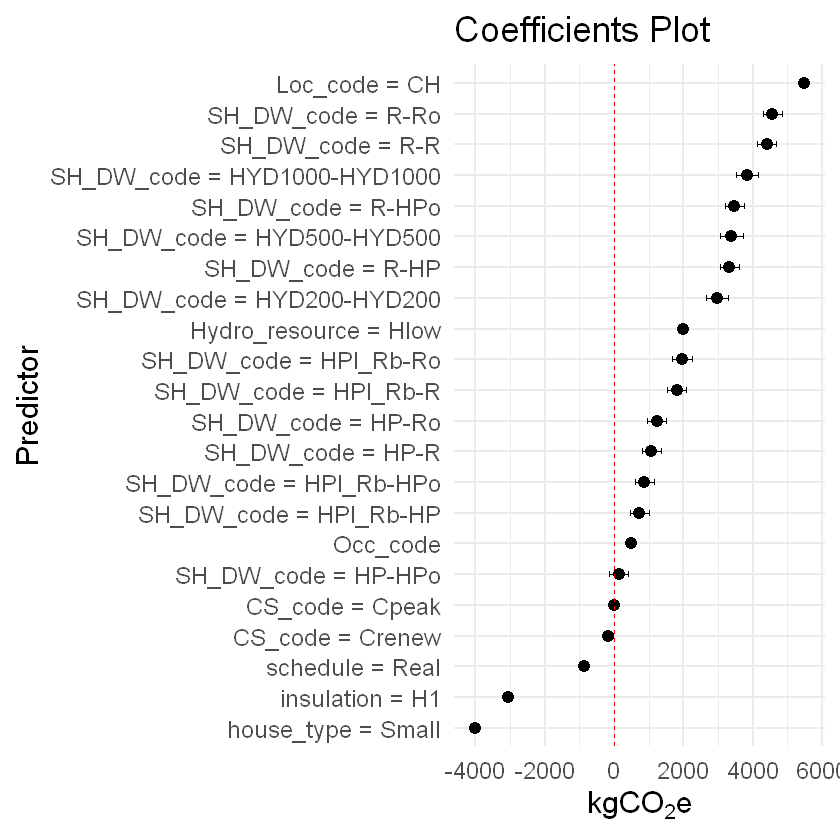

In [4]:
coeff_plot <- ggplot(coef_df, aes(x = reorder(term_clean, estimate), y = estimate)) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  coord_flip() +
  labs(
    x = "Predictor",
    y = expression(kgCO[2]*e),
    title = "Coefficients Plot"  
  ) +
  theme_minimal(base_size = 18)

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/coeff_plot.png",  # File path
  plot = coeff_plot,                       # Plot object
  width = 16,                             # Width in inches
  height = 10,                             # Height in inches
  dpi = 300                               # Resolution
)

coeff_plot


### Discussion
Our regression analysis reveals the following key drivers of lifetime CO₂ emissions, ranked by effect size and statistical significance (all p < 0.001):
#### Most Impactful Variables
| Variable                  | Effect Size (kg CO₂e) | Interpretation                                                                 |
|---------------------------|-----------------------|-------------------------------------------------------------------------------|
| **Location (CH vs AK)**   | +5480             | Christchurch homes emit **5400+ kg CO₂e more** than Auckland homes            |
| **House Type (Large vs Small)** | -4012         | Large houses emit **~4000 kg CO₂e more** than small houses                   |
| **Insulation (Base vs H1)** | -3064           | Base insulation adds **3000+ kg CO₂e** vs H1-standard                      |
| **Hydrology (Low vs High)** | +1986          | Low-hydro years increase emissions by **~1980 kg CO₂e**                        |
| **Resistive Heating**      | +4399            | Resistive systems emit **4400+ kg CO₂e more** than heat pumps (reference)     |

#### Key Implications
1. **Geographic Disparity**:  
   - The >5-tonne location effect suggests climate zone is the **strongest predictor** of emissions.  
2. **Building Standards Matter**:  
   - Houses with nominal insulation may emit **~3000 kg CO₂e more** than well-insulated ones.  
3. **Technology Choice**:  
   - Christchurch’s colder climate increases resistive heating emissions due to higher thermal demands and lower system efficiency.

## Impact of Location, House Type, and Insulation
This part of the analysis is based on the following considerations:
1. **Data Filtering**  
   - Excluded low-occupancy scenarios (<3 occupants) to ensure comparability  
     *(Rationale: Hydronic systems are only viable for households with ≥3 occupants)*  
2. **Variable Selection**  
   Focused on the most impactful predictors from regression analysis:  
   - **Location** (Auckland vs. Christchurch)  
   - **House Type** (Modern vs. State)  
   - **Insulation** (Base vs. H1-standard)  
3. **Aggregation Approach**  
   - Grouped by technology setup → Calculated mean lifetime emissions  

The following plot reveals:  
1. **Geographic Disparities**  
   - Christchurch (`CH`) emissions >> Auckland (`AK`) due to heating demand  
2. **Building Envelope Effects**  
   - Homes built to ‘base’ insulation standards produce higher operational emissions than those meeting H1 requirements due to increased thermal losses.  
3. **Technology setups**  
   - Key comparison: Heat pumps (`HP`) vs. resistive (`R`) vs. hydronic (`HYD`)  

In [5]:
library(patchwork)
household_lifetime_Call_location <- household_lifetime_Call %>% filter(Occ_code > 2) %>%
group_by(Loc_code, house_type, insulation, SH_DW_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_location <- household_lifetime_Call_location %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions")

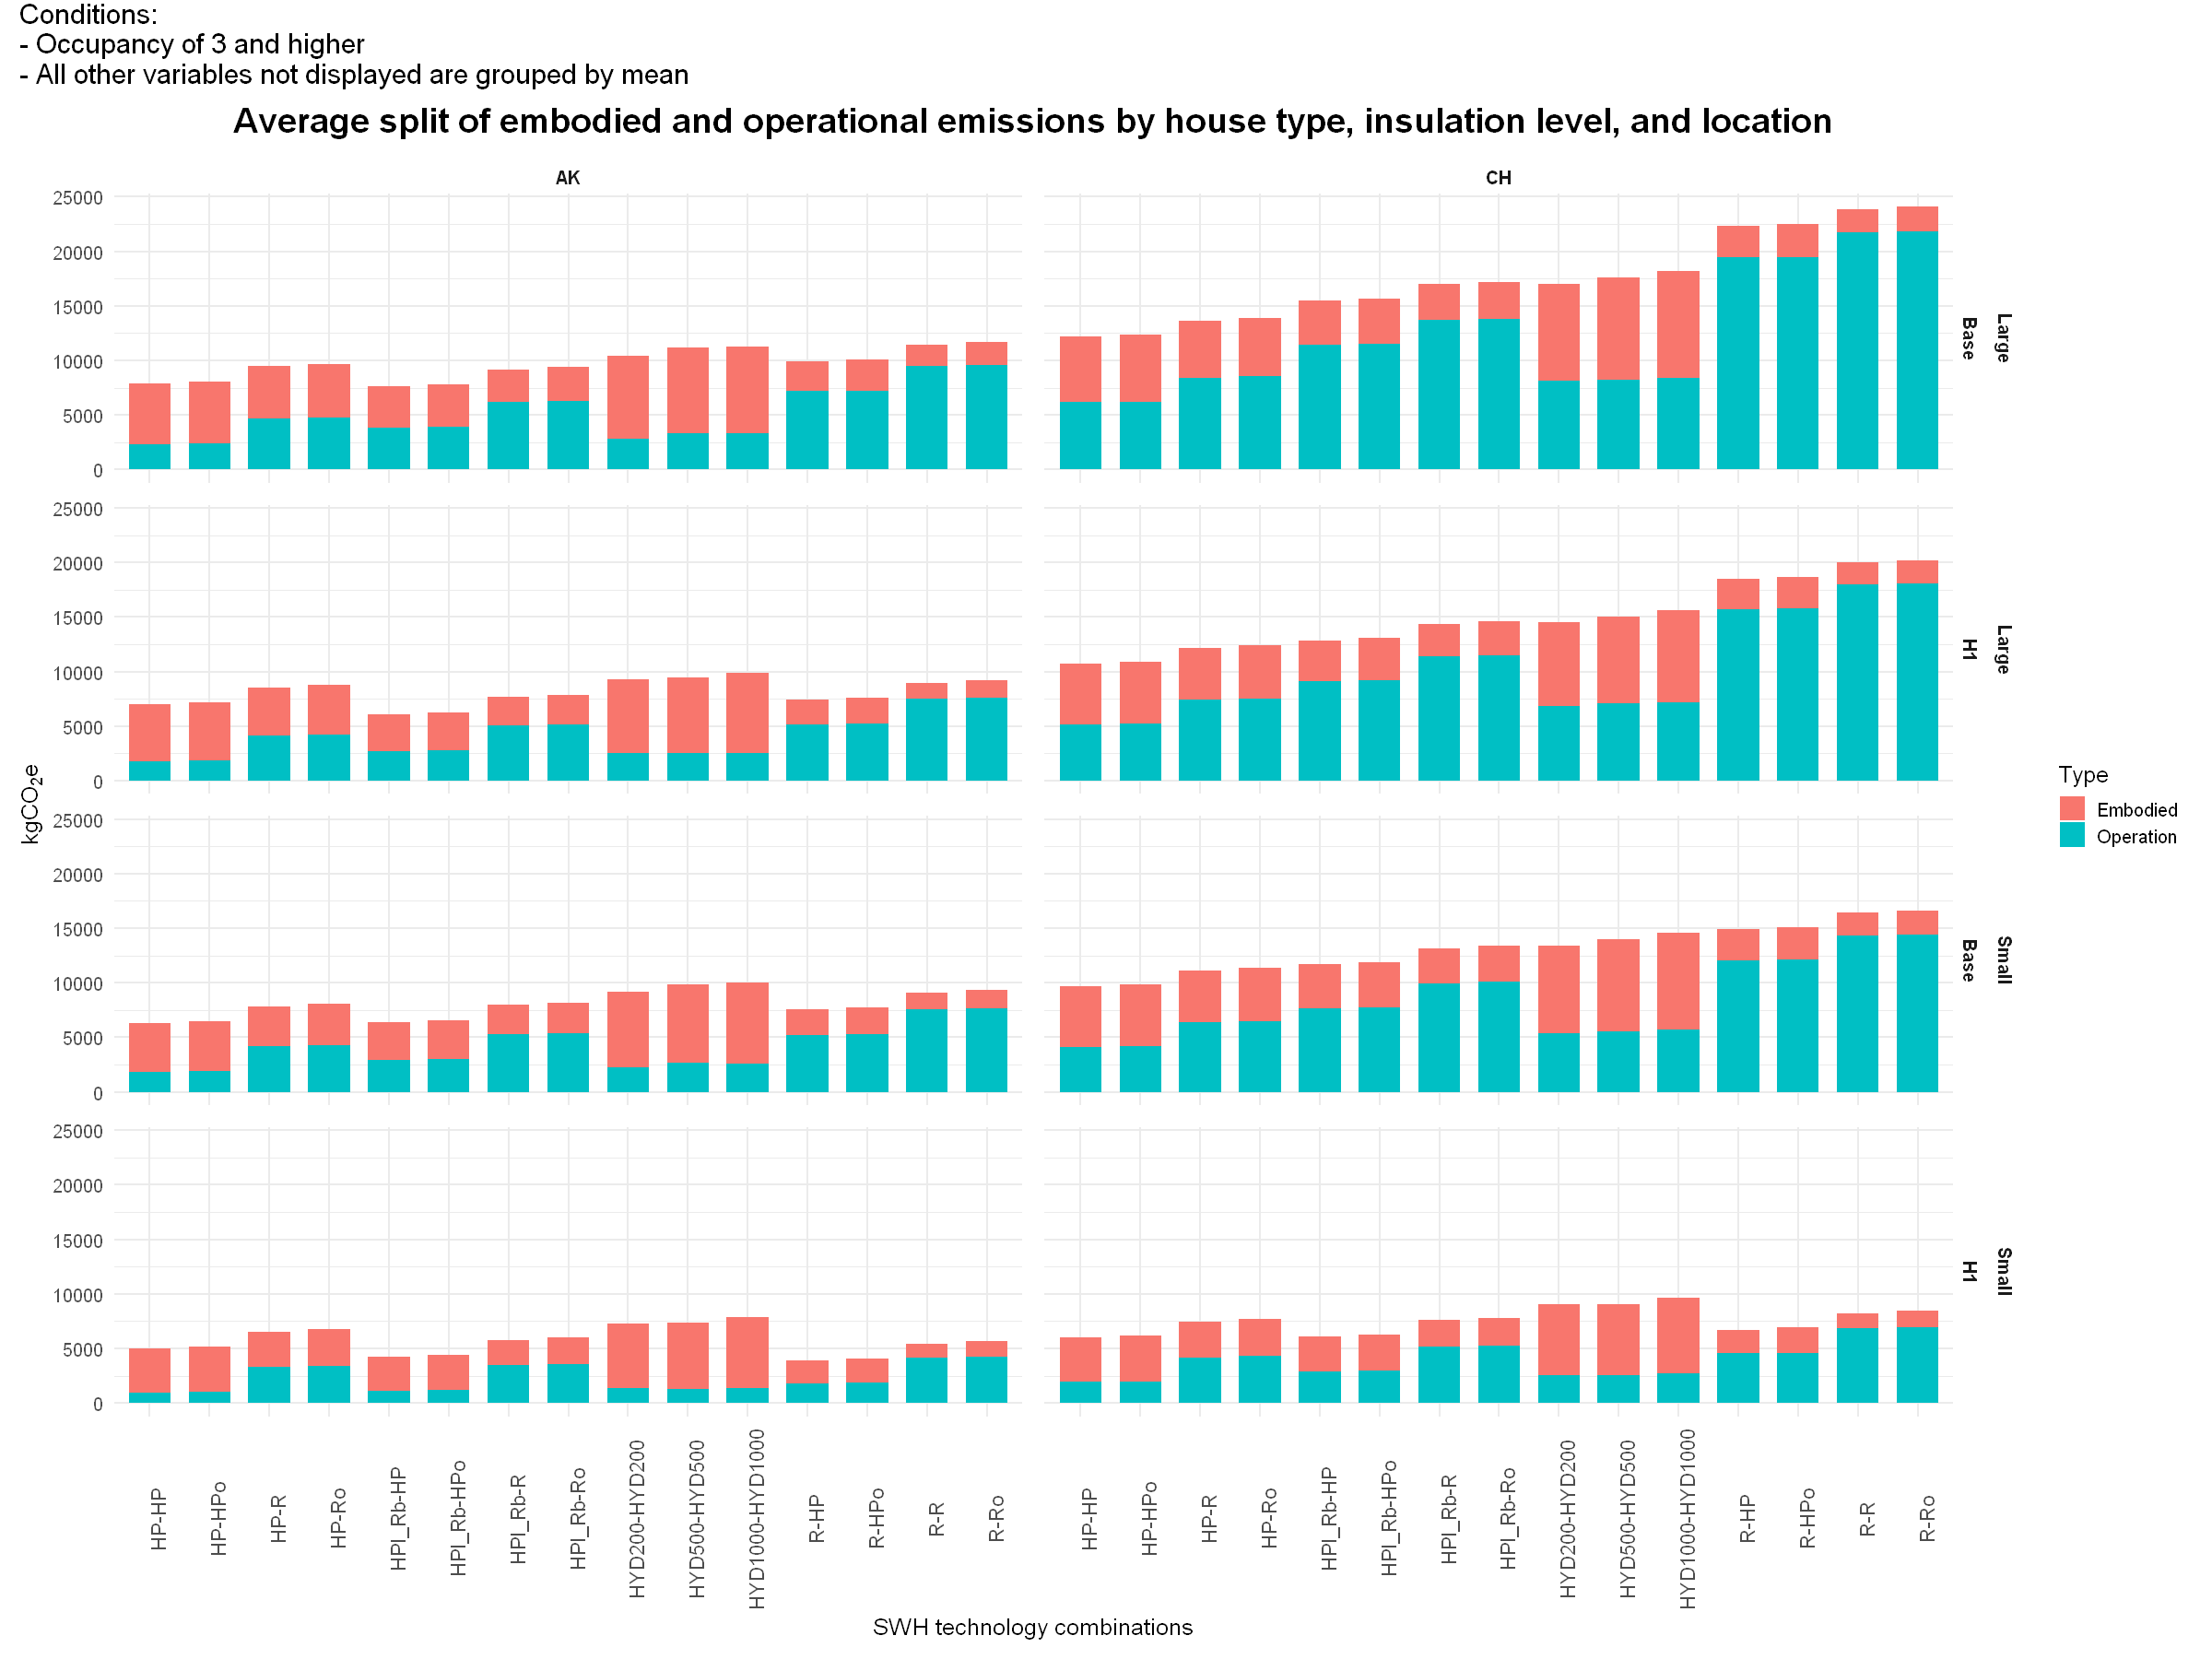

In [6]:
# Plot
options(repr.plot.width=20, repr.plot.height=15)
emissions_plot <- ggplot(plot_location, aes(x = SH_DW_code, y = Emissions, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  facet_grid(house_type + insulation ~ Loc_code) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH technology combinations",
       y = expression(kgCO[2]*e),
       title = "Average split of embodied and operational emissions by house type, insulation level, and location") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 13),
    strip.text = element_text(face = "bold"),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5, vjust = 2)  
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/total_emissions_plot.png",  # File path
  plot = emissions_plot,                       # Plot object
  width = 16,                             # Width in inches
  height = 10,                             # Height in inches
  dpi = 300                               # Resolution
)

emissions_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

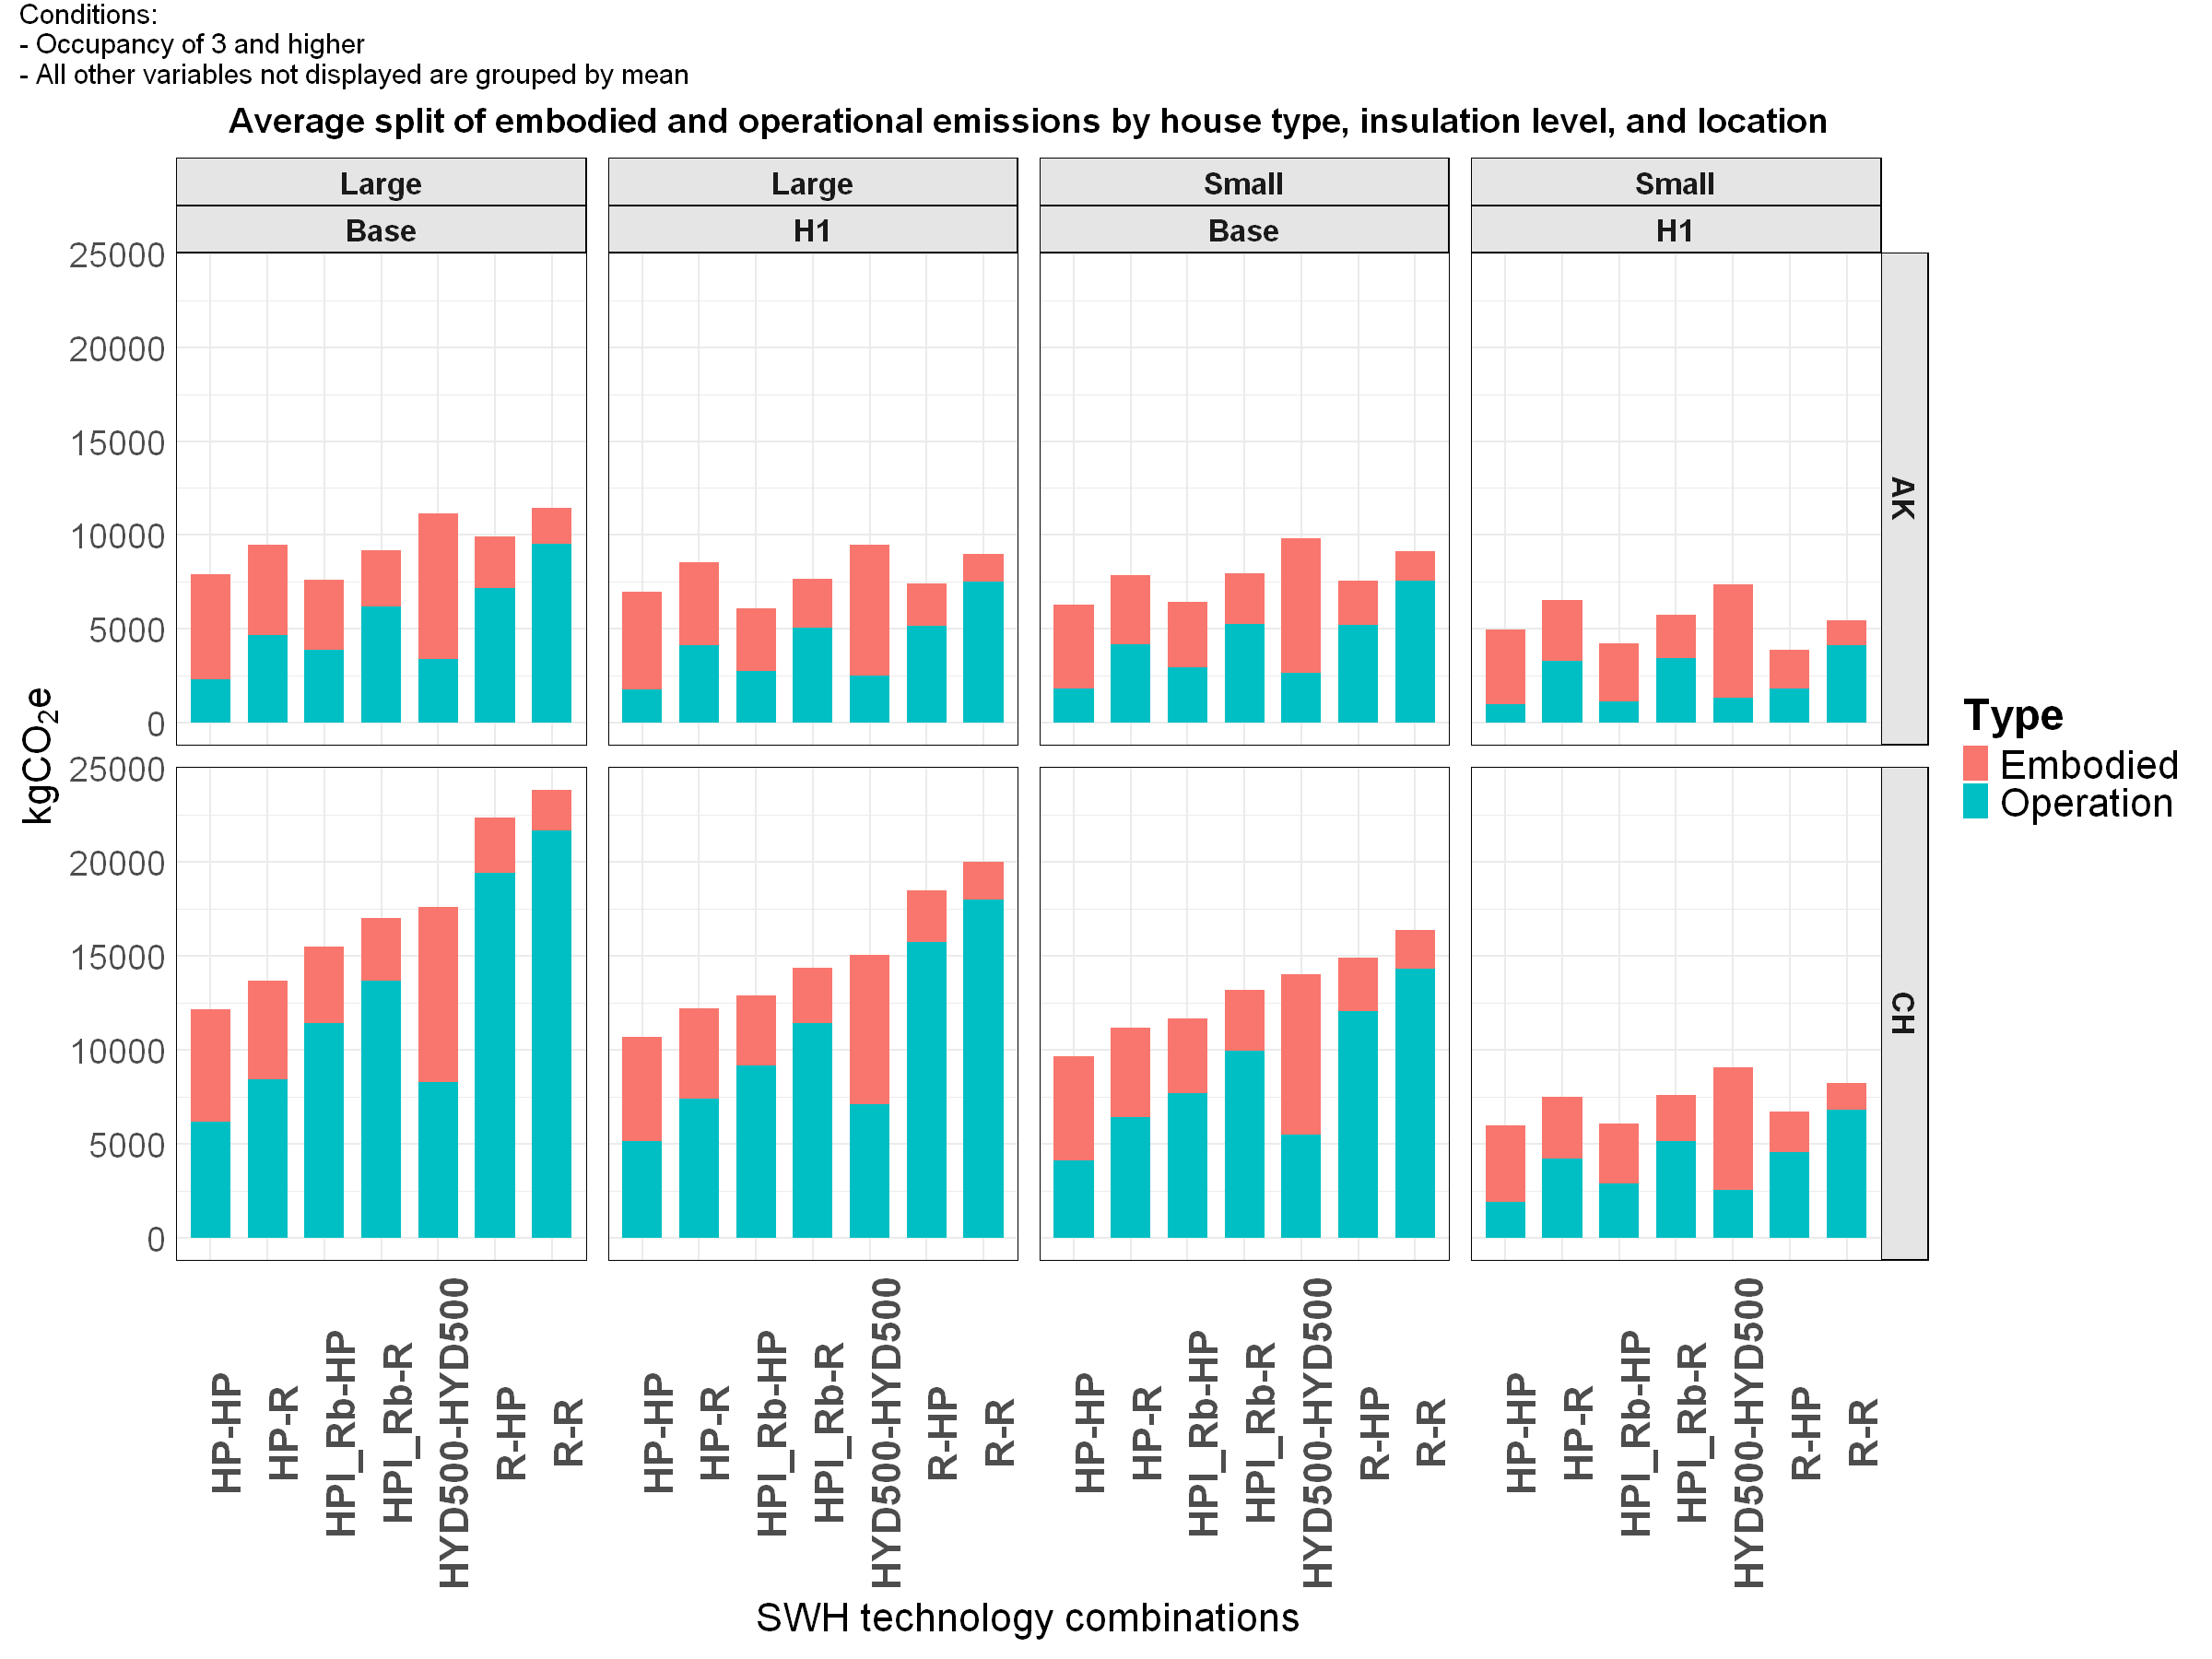

In [7]:
# Plot
options(repr.plot.width=20, repr.plot.height=15)
emissions_plot <- plot_location %>%
  filter(SH_DW_code %in% c('HP-HP','HPl_Rb-HP','HPl_Rb-R','HP-R','HYD500-HYD500','R-HP','R-R')) %>%  
  ggplot(aes(x = SH_DW_code, y = Emissions, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  facet_grid(Loc_code ~ house_type + insulation) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH technology combinations",
       y = expression(kgCO[2]*e),
       title = "Average split of embodied and operational emissions by house type, insulation level, and location") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26, face = 'bold'),
    axis.title.x = element_text(size = 26),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 28, face = "bold"),
    legend.text = element_text(size = 26), 
    strip.text = element_text(face = "bold", size = 20),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5, vjust = 2)
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/total_emissions_plot_a.png",  # File path
  plot = emissions_plot,                       # Plot object
  width = 16,                             # Width in inches
  height = 10,                             # Height in inches
  dpi = 300                               # Resolution
)

emissions_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

In [8]:
household_lifetime_Call_location_energy <- household_lifetime_Call %>% filter(Occ_code > 2) %>%
group_by(Loc_code, house_type, insulation, SH_DW_code) %>%
  summarise(Embodied = mean(Embodied_life_MJ),
            Operation = mean(P_annual_kWh_life/0.278), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_location_energy <- household_lifetime_Call_location_energy %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "MJ")

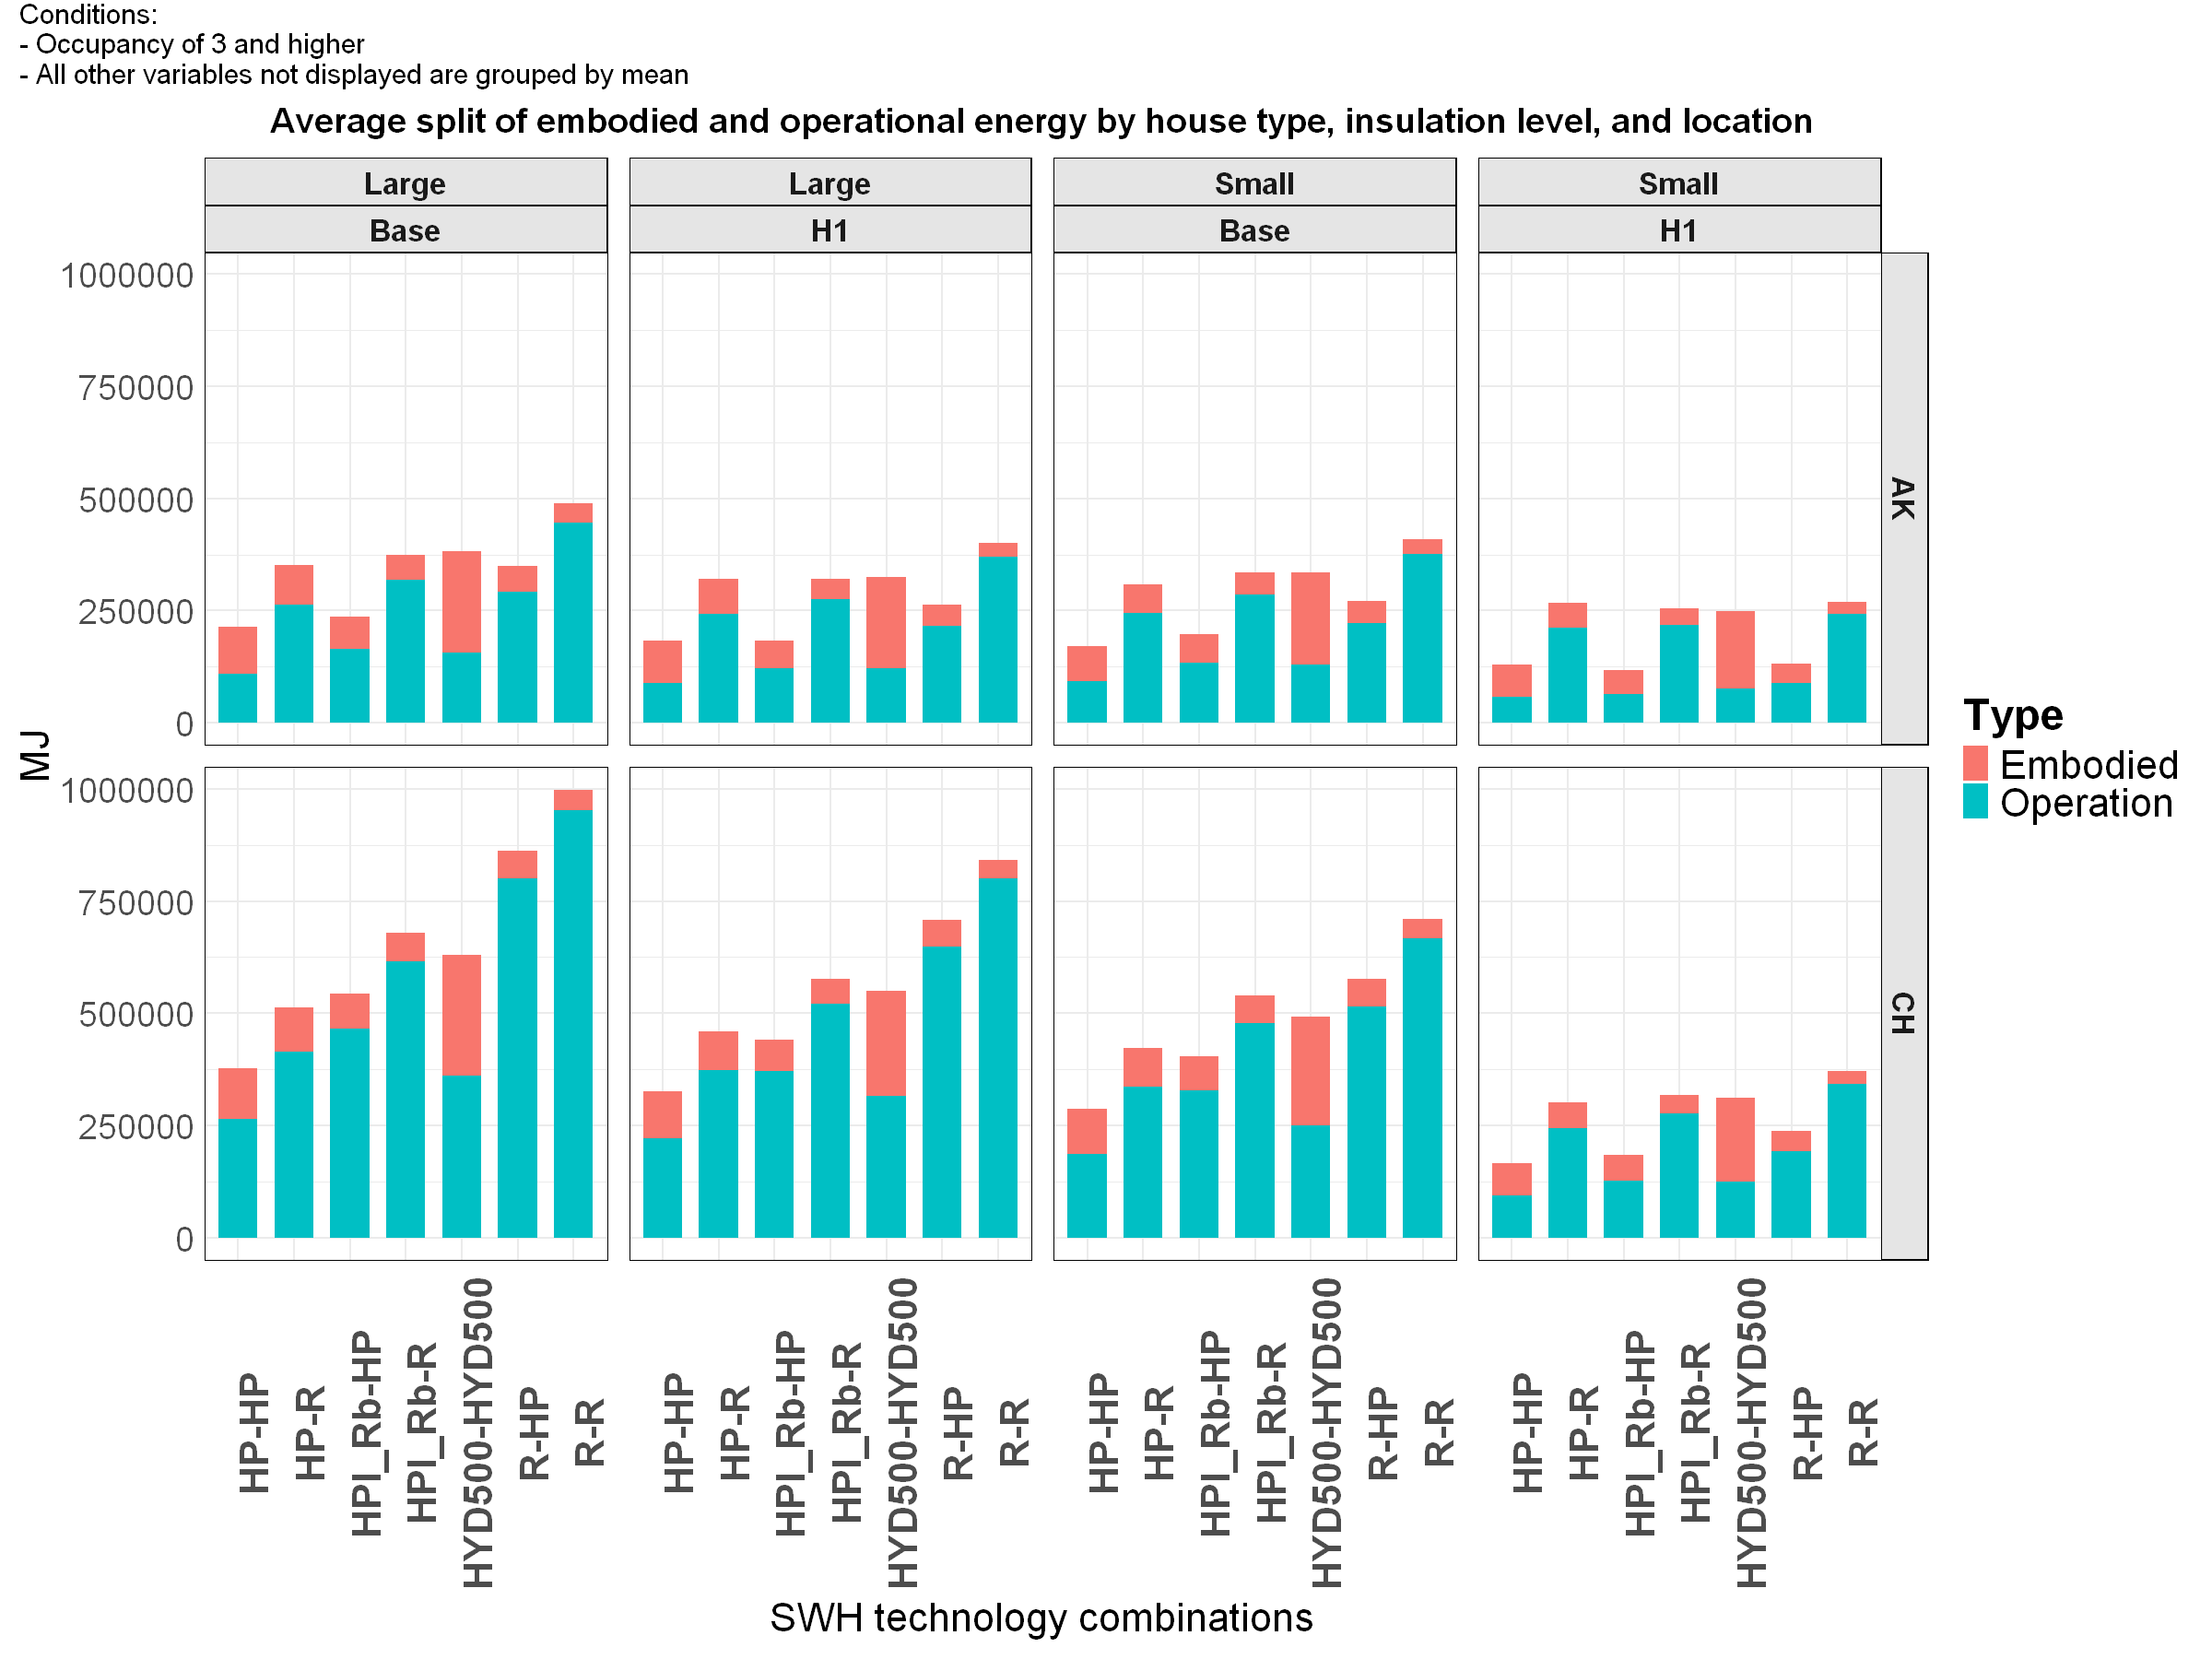

In [9]:
options(repr.plot.width=20, repr.plot.height=15)
emissions_plot <- plot_location_energy %>%
  filter(SH_DW_code %in% c('HP-HP','HPl_Rb-HP','HPl_Rb-R','HP-R','HYD500-HYD500','R-HP','R-R')) %>%  
  ggplot(aes(x = SH_DW_code, y = MJ, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  facet_grid(Loc_code ~ house_type + insulation) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH technology combinations",
       y = 'MJ',
       title = "Average split of embodied and operational energy by house type, insulation level, and location") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26, face = 'bold'),
    axis.title.x = element_text(size = 26),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 28, face = "bold"),
    legend.text = element_text(size = 26), 
    strip.text = element_text(face = "bold", size = 20),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5, vjust = 2)
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/total_energy_plot_a.png",  # File path
  plot = emissions_plot,                       # Plot object
  width = 16,                             # Width in inches
  height = 10,                             # Height in inches
  dpi = 300                               # Resolution
)

emissions_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
#### Key Findings

1. **Operational Emissions Dominate**  
   - Differences in total emissions across all SWH technologies are **primarily driven by operational components** (energy use during operation).  
   - *Exception*: Hydronic systems and 'HP-HP' combinations show a more balanced operational/embodied split.  

2. **Geographic Impact**  
   - Christchurch (CH) systems exhibit **higher lifetime emissions** than Auckland (AK) across all setups. This results from Christchurch’s colder climate, which necessitates higher-capacity heaters, increasing both operational energy use and embodied emissions.  
3. **House Type Effect**  
   | House Size | Bedrooms | Avg. Added Emissions (vs Mass) | Primary Contributor |  
   |------------|----------|-------------------------------|---------------------|  
   | Large | 4       | +4000 kg CO₂e                  | Larger space heating demand |  
   | Small | 2       | Baseline                       | -                   |  

   - The **+4000 kg CO₂e** estimate (from regression) aligns with observed emission differences.  

4. **Technology-Specific Trends**  
   - **Hydronic systems**: Embodied emissions play a larger role (~50-75% share) primarily due to the added complexity from components like buffer tanks and fan coil units.

#### Policy Implications  
- **Retrofitting priorities**: Houses in Christchurch offer the highest potential savings.  
- **Technology selection**: Heat pumps outperform resistive systems in all scenarios.  

At this stage, variables such as control signal, occupancy, and operation schedule have been aggregated into the analysis. In the next section, however, individual impacts are examined in isolation.

## Impact of Electricity Emission Factor

- **Operational emissions** are highly sensitive to the electricity emission factor (EF), which varies temporally based on:
  - Grid demand patterns
  - Installed capacity mix
  - Renewable resource availability (especially hydro)

1. **Data Selection**:
   - Scenario: `C0` (no control signal)
   - Location: Christchurch only (*Higher operational emission share*)
   - Systems: Filtered to exclude oversized setups
   - Focus Technologies:
     - `HP-HP` (Full heat pump)
     - `R-R` (Full resistive)
     - `HPl_Rb-R` (Hybrid heat pump/resistive)
     - `HYD500-HYD500` (Mid-size hydronic)

2. **Temporal Analysis**:
   - Used annual EF time series accounting for:
     - Hydro inflow variability (`high` vs `low`)
     - Power Demand-Generation capacity interaction (EDGS: `Ref` vs `Env`)

In [10]:
library(tidyverse)
household_annual_ref <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/household_year_C0.csv") %>%
  suppressMessages() %>% mutate(EDGS = 'Ref') %>% select(-EOL_S_WH, -EOL_S_SH, -EOL_S, -Other_S_WH, -Other_S_SH, -Other_S,
                                                         -Manufacture_MJ,-Distribution_MJ,-Installation_MJ,-EOL_MJ,-Other_MJ,
                                                        -Manufacture_WH_MJ,-Distribution_WH_MJ,-Installation_WH_MJ,-EOL_WH_MJ,-Other_WH_MJ,
                                                        -Manufacture_SH_MJ,-Distribution_SH_MJ,-Installation_SH_MJ,-EOL_SH_MJ,-Other_SH_MJ) 
household_annual_env <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/household_year_env_C0.csv") %>%
  suppressMessages() %>% mutate(EDGS = 'Env')
household_annual_summary <- rbind(household_annual_ref, household_annual_env) %>% 
  filter(Loc_code == 'CH', 
         year>2024, 
         Occ_code>2,
         SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD500-HYD500'),
        schedule == 'Real') %>% 
  mutate(house_type = ifelse(house_type == 'Mod', 'Large', 'Small')) %>%
  mutate(insulation = ifelse(insulation == 'Nom', 'Base', insulation)) %>%
  mutate(Embodied = Manufacture + Distribution + Installation + EOL + Other) %>%
  group_by(house_type, insulation, Hydro_resource, SH_DW_code, year, EDGS) %>%
  summarise(Embodied_annual = mean(Embodied),
            Operation_annual = mean(Operation)) %>% 
  suppressMessages() %>%
  ungroup()
# Reshape data to long format for ggplot2
household_annual_summary_long <- household_annual_summary %>%
  pivot_longer(cols = c(Embodied_annual, Operation_annual), names_to = "Type", values_to = "Emissions")

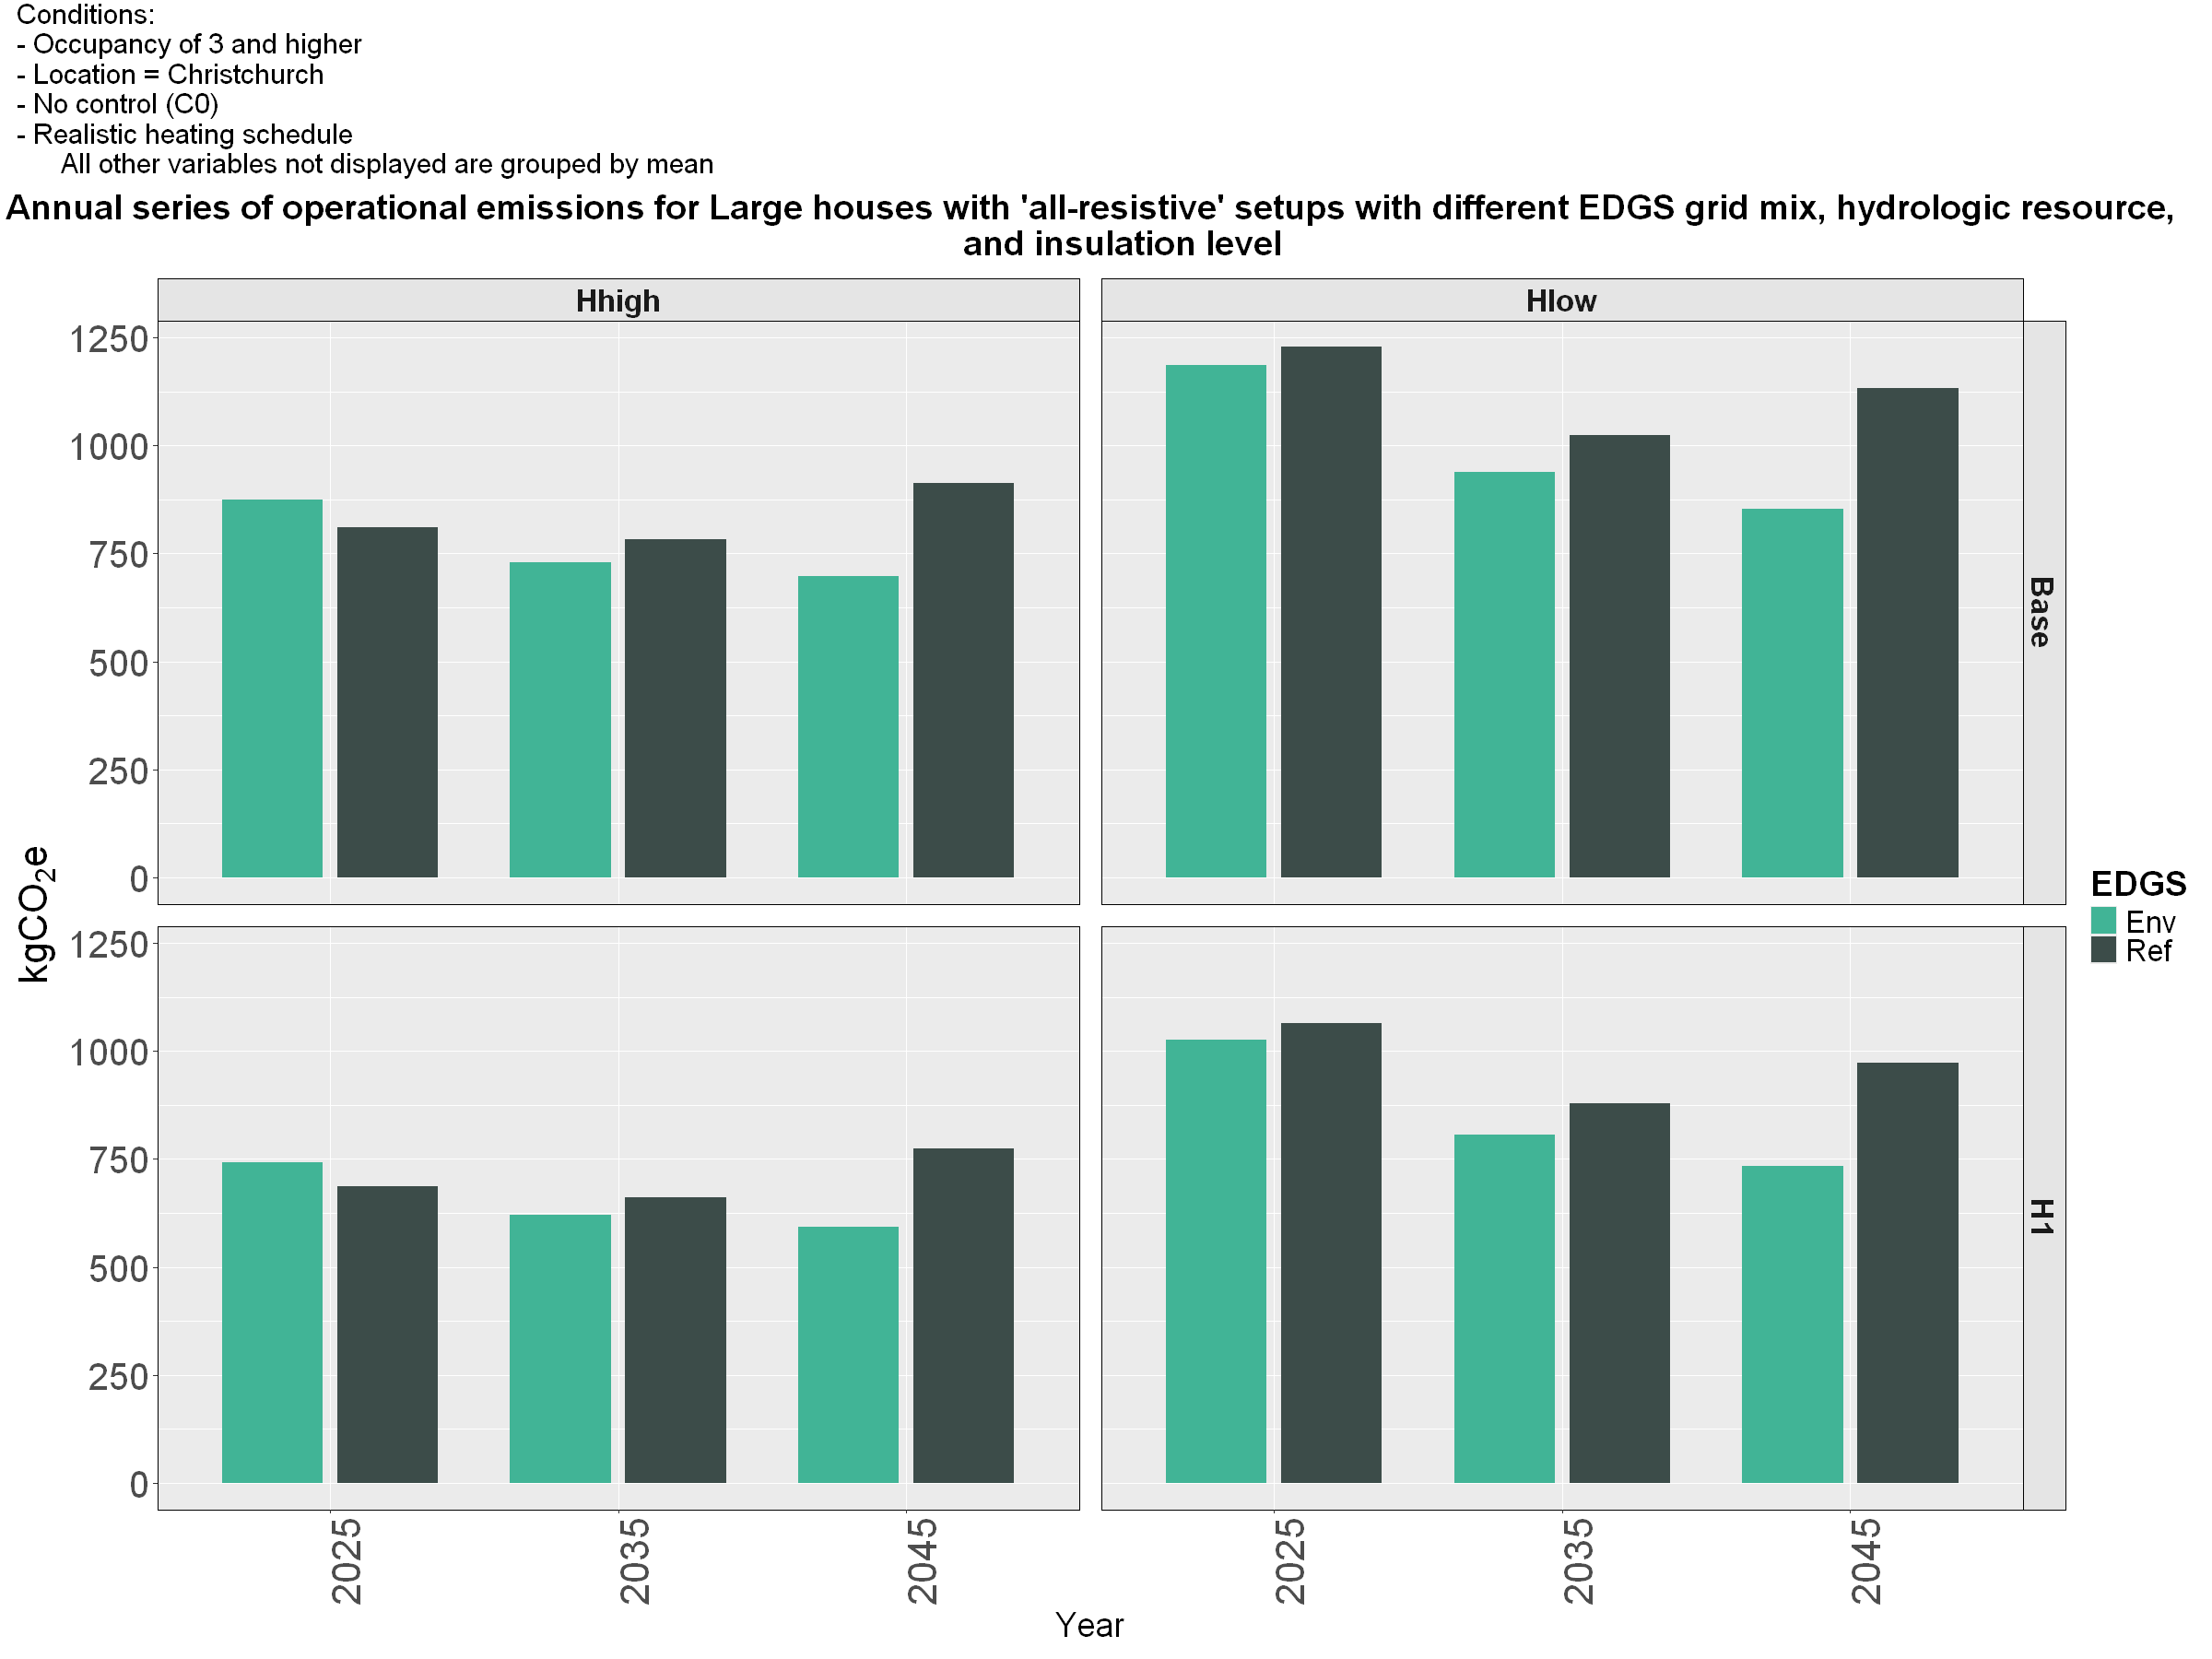

In [11]:
intensity_plot <- household_annual_summary_long %>% 
  filter(Type == 'Operation_annual') %>%
  filter(SH_DW_code == 'R-R') %>%  
  filter(house_type == 'Large') %>%  
  filter(year %in% c(2025,2035,2045)) %>%
  ggplot(aes(x = factor(year), y = Emissions, fill = EDGS)) +
  geom_col(width = 0.7, position = position_dodge(width = 0.8)) +
  scale_fill_manual(values = c("Ref" = '#3c4c49', "Env" = '#41b496')) +
  facet_grid(insulation ~ Hydro_resource) +
  labs(x = "Year",
       y = expression(kgCO[2]*e),
       title = "Annual series of operational emissions for Large houses with 'all-resistive' setups with different EDGS grid mix, hydrologic resource,
       and insulation level") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26),
    axis.title.x = element_text(size = 22),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 24),
    legend.title = element_text(size = 22, face = "bold"),
    legend.text = element_text(size = 20), 
    strip.text = element_text(face = "bold", size = 20),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5, vjust = 2)   
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/intensity_plot.png",  # File path
  plot = intensity_plot,                       # Plot object
  width = 16,                             # Width in inches
  height = 10,                             # Height in inches
  dpi = 300                               # Resolution
)

intensity_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- Location = Christchurch\n- No control (C0)\n- Realistic heating schedule
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

In [52]:
household_lifetime_ref <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/household_lifetime_C0.csv") %>% 
  suppressMessages() %>% 
  mutate(SH_DW_code = factor(SH_DW_code, levels = c("HP-HP", "HP-HPo", "HP-R", "HP-Ro", "HPl_Rb-HP", "HPl_Rb-HPo",
                                                    "HPl_Rb-R", "HPl_Rb-Ro", "HYD200-HYD200", "HYD500-HYD500", "HYD1000-HYD1000", 
                                                    "R-HP", "R-HPo", "R-R", "R-Ro"))) %>%
  mutate(house_type = ifelse(house_type == 'Mod', 'Large', 'Small')) %>%
  mutate(insulation = ifelse(insulation == 'Nom', 'Base', insulation)) %>%
  mutate(CS_code = 'C0') %>%
  mutate(EDGS = 'Ref') %>%
  select(-EOL_S_WH, -EOL_S_SH, -EOL_S, -Other_S_WH, -Other_S_SH, -Other_S, -Embodied_life_R, -Total_life_R,
        -Manufacture_MJ,-Distribution_MJ,-Installation_MJ,-EOL_MJ,-Other_MJ,
        -Manufacture_WH_MJ,-Distribution_WH_MJ,-Installation_WH_MJ,-EOL_WH_MJ,-Other_WH_MJ,
        -Manufacture_SH_MJ,-Distribution_SH_MJ,-Installation_SH_MJ,-EOL_SH_MJ,-Other_SH_MJ,
        -Total_life_MJ, -Embodied_life_MJ)

household_lifetime_env <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/household_lifetime_env_C0.csv") %>% 
  suppressMessages() %>% 
  mutate(SH_DW_code = factor(SH_DW_code, levels = c("HP-HP", "HP-HPo", "HP-R", "HP-Ro", "HPl_Rb-HP", "HPl_Rb-HPo",
                                                                           "HPl_Rb-R", "HPl_Rb-Ro", "HYD200-HYD200", "HYD500-HYD500", "HYD1000-HYD1000", 
                                                                           "R-HP", "R-HPo", "R-R", "R-Ro"))) %>%
  mutate(house_type = ifelse(house_type == 'Mod', 'Large', 'Small')) %>%
  mutate(insulation = ifelse(insulation == 'Nom', 'Base', insulation)) %>%
  mutate(CS_code = 'C0') %>%
  mutate(EDGS = 'Env')

household_lifetime_edgs <- rbind(household_lifetime_ref, household_lifetime_env) %>%
  filter(Occ_code>2,
         SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD500-HYD500'),
         Hydro_resource == 'Hhigh',
        schedule == 'Real') %>%
  group_by(Loc_code, house_type, insulation, SH_DW_code, EDGS) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)

# Step 2: Compute base case 
household_lifetime_edgs_base <- household_lifetime_edgs %>%
  filter(EDGS == "Ref") %>%
  select(SH_DW_code, Loc_code, house_type, insulation, Total_base = Total)

# Step 3: Join and calculate differences
household_lifetime_edgs_diff <- household_lifetime_edgs %>%
  left_join(
    household_lifetime_edgs_base,
    by = c("SH_DW_code", "Loc_code", "house_type", "insulation")
  ) %>%
  mutate(
    diff_p = (Total - Total_base) / Total_base * 100, # percent difference from base case
    diff_a = Total - Total_base # percent difference from base case  
  )

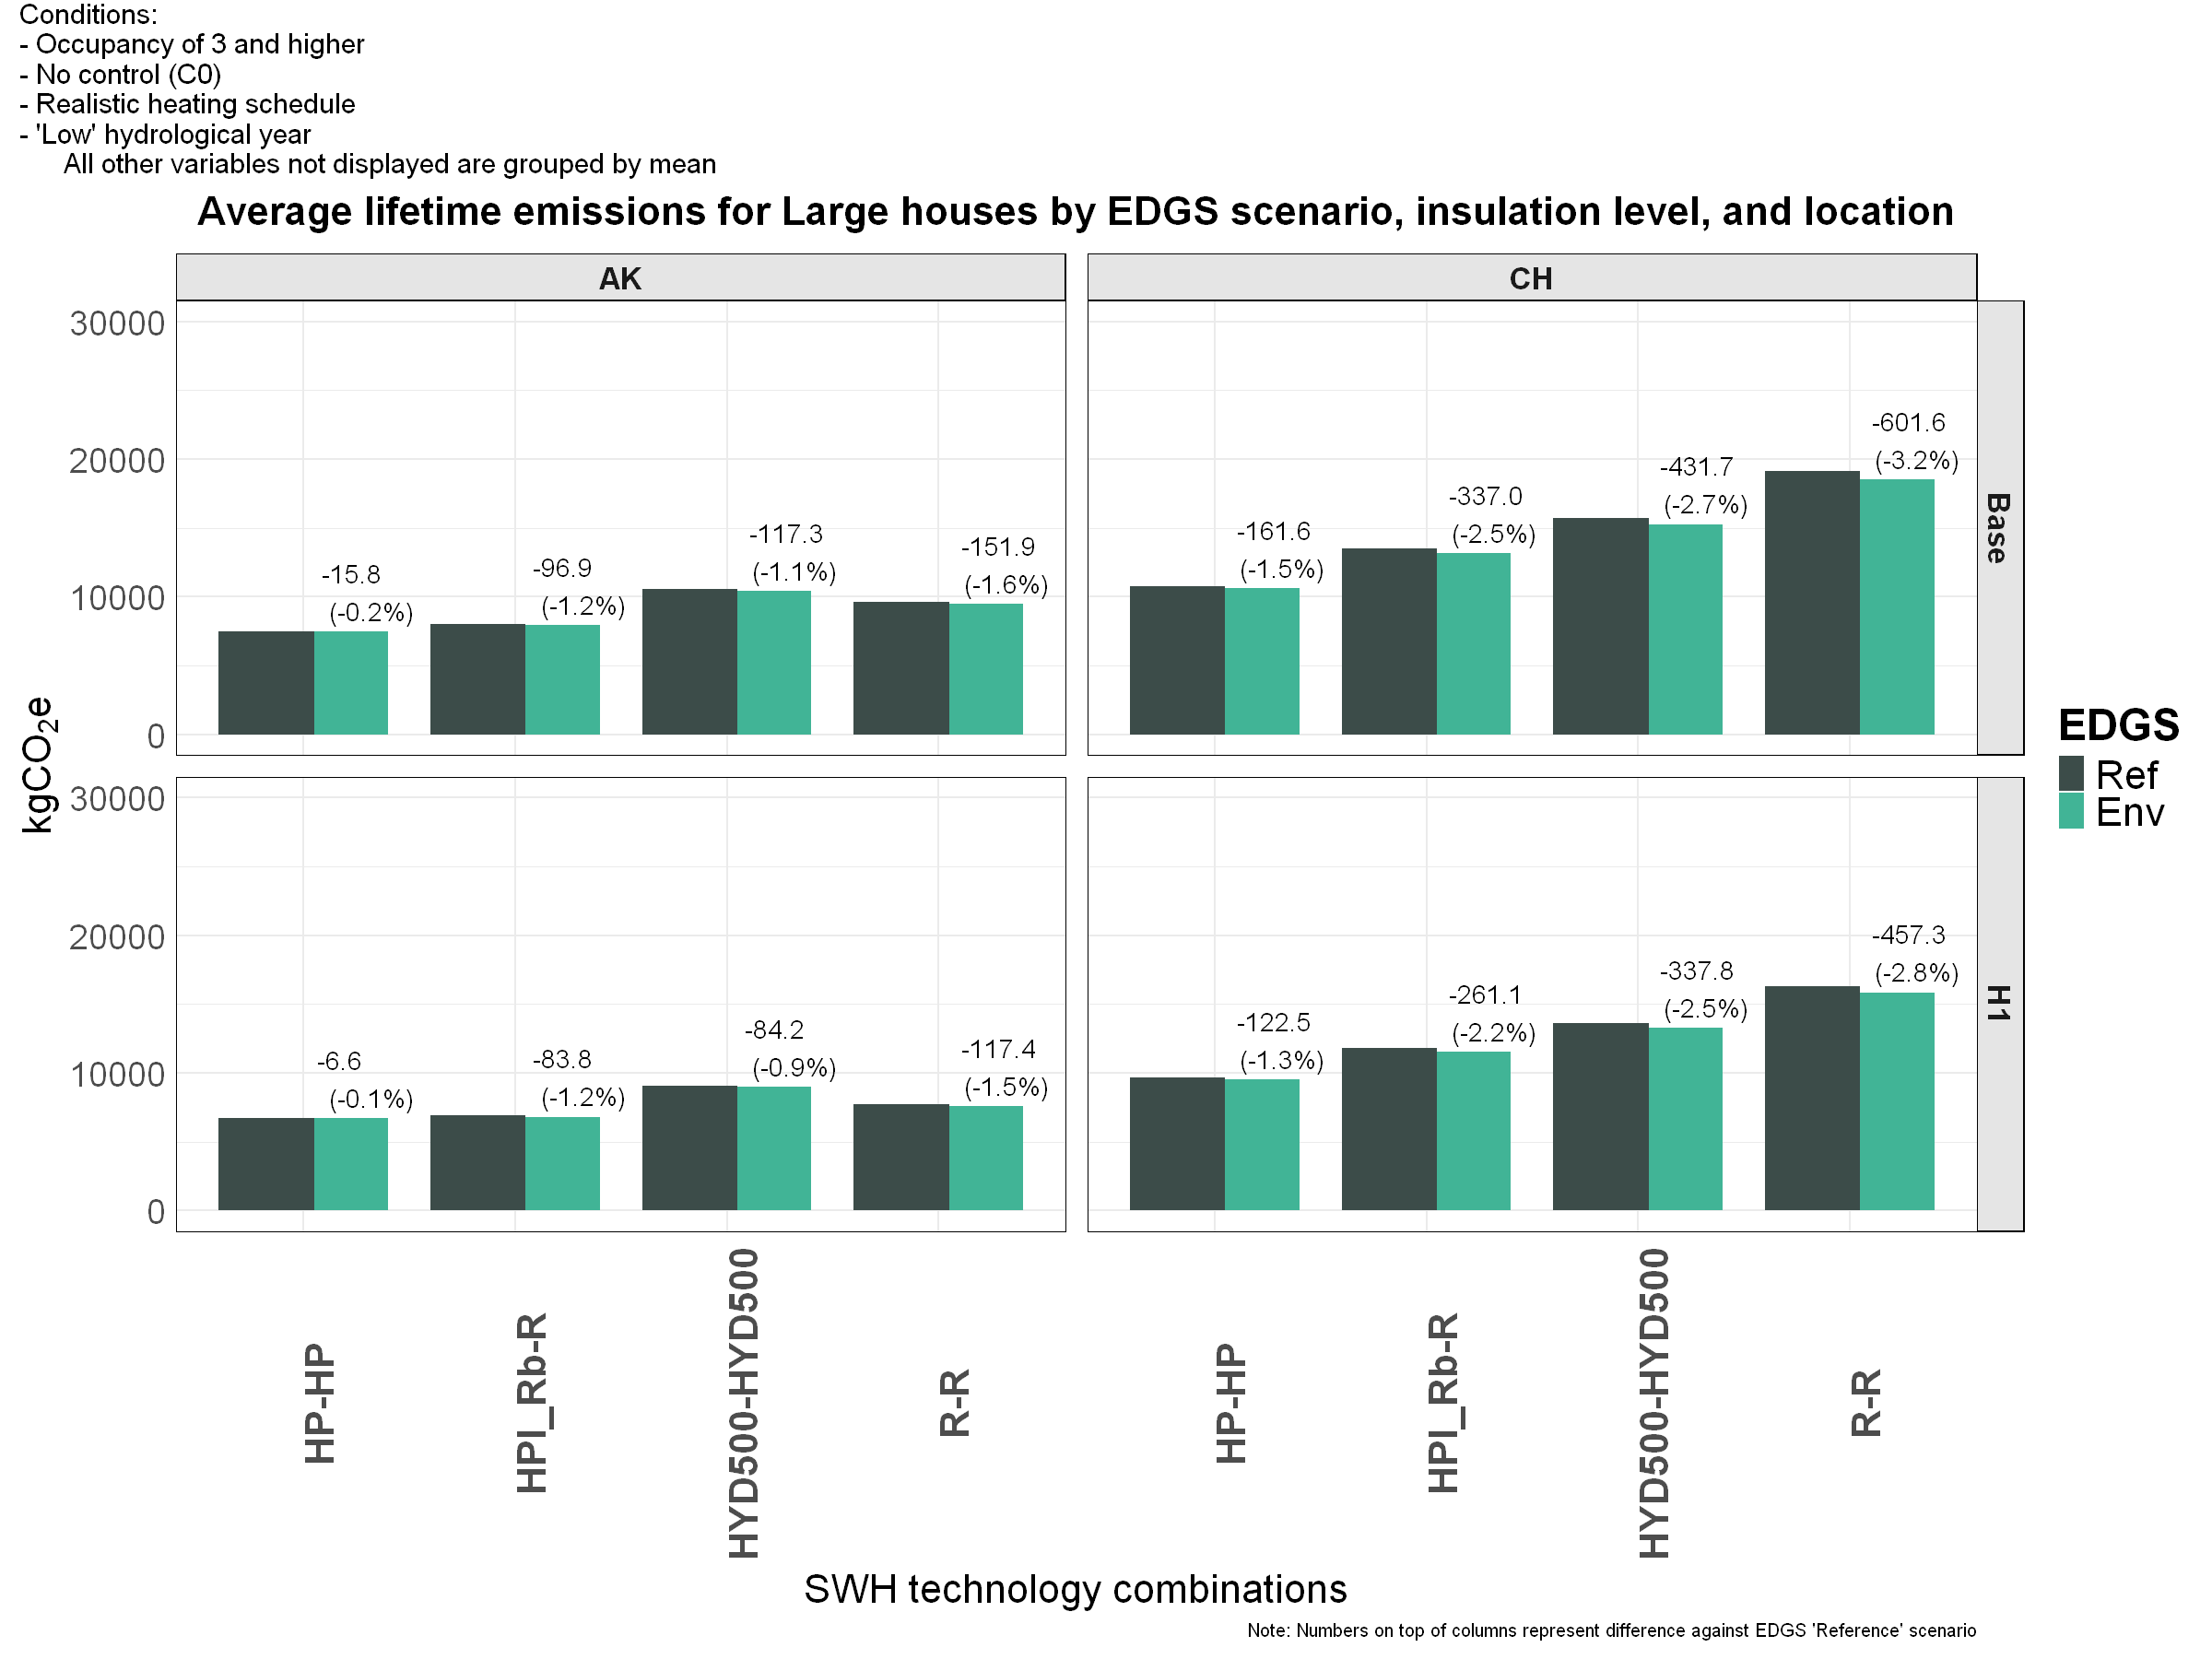

In [53]:
life_edgs_plot <-household_lifetime_edgs_diff %>%
  mutate(EDGS = factor(EDGS, levels = c('Ref','Env'))) %>%  
  filter(house_type == 'Large') %>%  
  ggplot(aes(x = SH_DW_code, 
             y = Total, 
             fill = EDGS)) + 
  # Use position_stack() inside position_dodge2() to combine the two
  geom_col(position = position_dodge(width = 0.7)) +
  scale_y_continuous(limits = c(0, 30000)) +
  geom_text(
    aes(label = ifelse(!is.na(diff_a) & EDGS == 'Env', sprintf("%.1f\n(%.1f%%)", diff_a,diff_p), "")),
    size = 6,
    color = "black",
    hjust = -0.3,
    vjust = -0.2  
  ) +
  scale_fill_manual(values = c("Ref" = '#3c4c49', "Env" = '#41b496')) +
  facet_grid(insulation ~ Loc_code) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH technology combinations",
       y = expression(kgCO[2]*e),
       title = "Average lifetime emissions for Large houses by EDGS scenario, insulation level, and location",
       caption = "Note: Numbers on top of columns represent difference against EDGS 'Reference' scenario") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26, face = 'bold'),
    axis.title.x = element_text(size = 26),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 28, face = "bold"),
    legend.text = element_text(size = 26), 
    strip.text = element_text(face = "bold", size = 20),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 26, face = "bold", hjust = 0.5, vjust = 2)  
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/life_edgs_plot_high.png",  # File path
  plot = life_edgs_plot,                       # Plot object
  width = 16,                             # Width in inches
  height = 10,                             # Height in inches
  dpi = 300                               # Resolution
)

life_edgs_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- No control (C0)\n- Realistic heating schedule\n- 'Low' hydrological year
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
Looking at the operational emissions under different hydrological conditions, the pattern is as expected: emissions are consistently lower in high hydrological years compared to low years, highlighting the strong dependence on water resource availability.

The previous plots also compare generation mix projections from [MBIE's Electricity Demand and Generation Scenarios](https://www.mbie.govt.nz/building-and-energy/energy-and-natural-resources/energy-statistics-and-modelling/energy-modelling/electricity-demand-and-generation-scenarios):

- Reference (Ref) series: Emissions decline until ~2035, then rise again. This reflects the electricity emission factor trend, where gains from added renewable capacity are offset by rising demand.
- Environmental (Env) series: Emissions steadily decline, reaching minimal levels by the end of the analysis. Interestingly, in some early years emissions are higher than in the Reference case, due to the assumption of high electrification rates. Over time, the faster uptake of renewables ensures a sustained net reduction.

When lifetime emissions are considered across technology combinations, house type, insulation, and EDGS scenario, the outcome is clear: a grid mix with a higher share of renewables (i.e., the Environmental scenario) achieves reductions in the range of 2–8%.

## Impact of Control Signal on Direct Emissions
The previous plot analysed the 'C0' (no control) scenario. A novel aspect of this study is investigating the ability to defer demand by making use of thermal storage. Specifically, we examine key configurations: HP-HP (heat pumps used for both space and water heating), HPl_Rb-R (Hybrid system used for space heating and resistive system used for water heating), and hydronic systems with varying storage capacities. Notably, in hydronic scenarios, thermal storage is applied to both space and water heating systems, whereas in other configurations it is associated only with water heating.  
Hypothetically, appropriate control signals could:  
- Enable systems to prioritise operation when renewable generation share is high ('Crenew') 
- Shift operation to off-peak times, potentially reducing indirect emissions from power system infrastructure ('Cpeak')  

In [14]:
household_lifetime_Call_CS <- household_lifetime_Call %>% 
filter(Occ_code > 2, 
       Loc_code == 'CH',
       SH_DW_code %in% c('HP-HP', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000'),
       schedule == 'Real') %>%
#group_by(house_type, insulation, SH_DW_code, CS_code, Occ_code) %>%
#  summarise(Embodied = mean(Embodied_life),
#            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied_life + Operation_life)
# Reshape data to long format for ggplot2
plot_CS <- household_lifetime_Call_CS %>%
  pivot_longer(cols = c(Embodied_life, Operation_life), names_to = "Type", values_to = "Emissions")

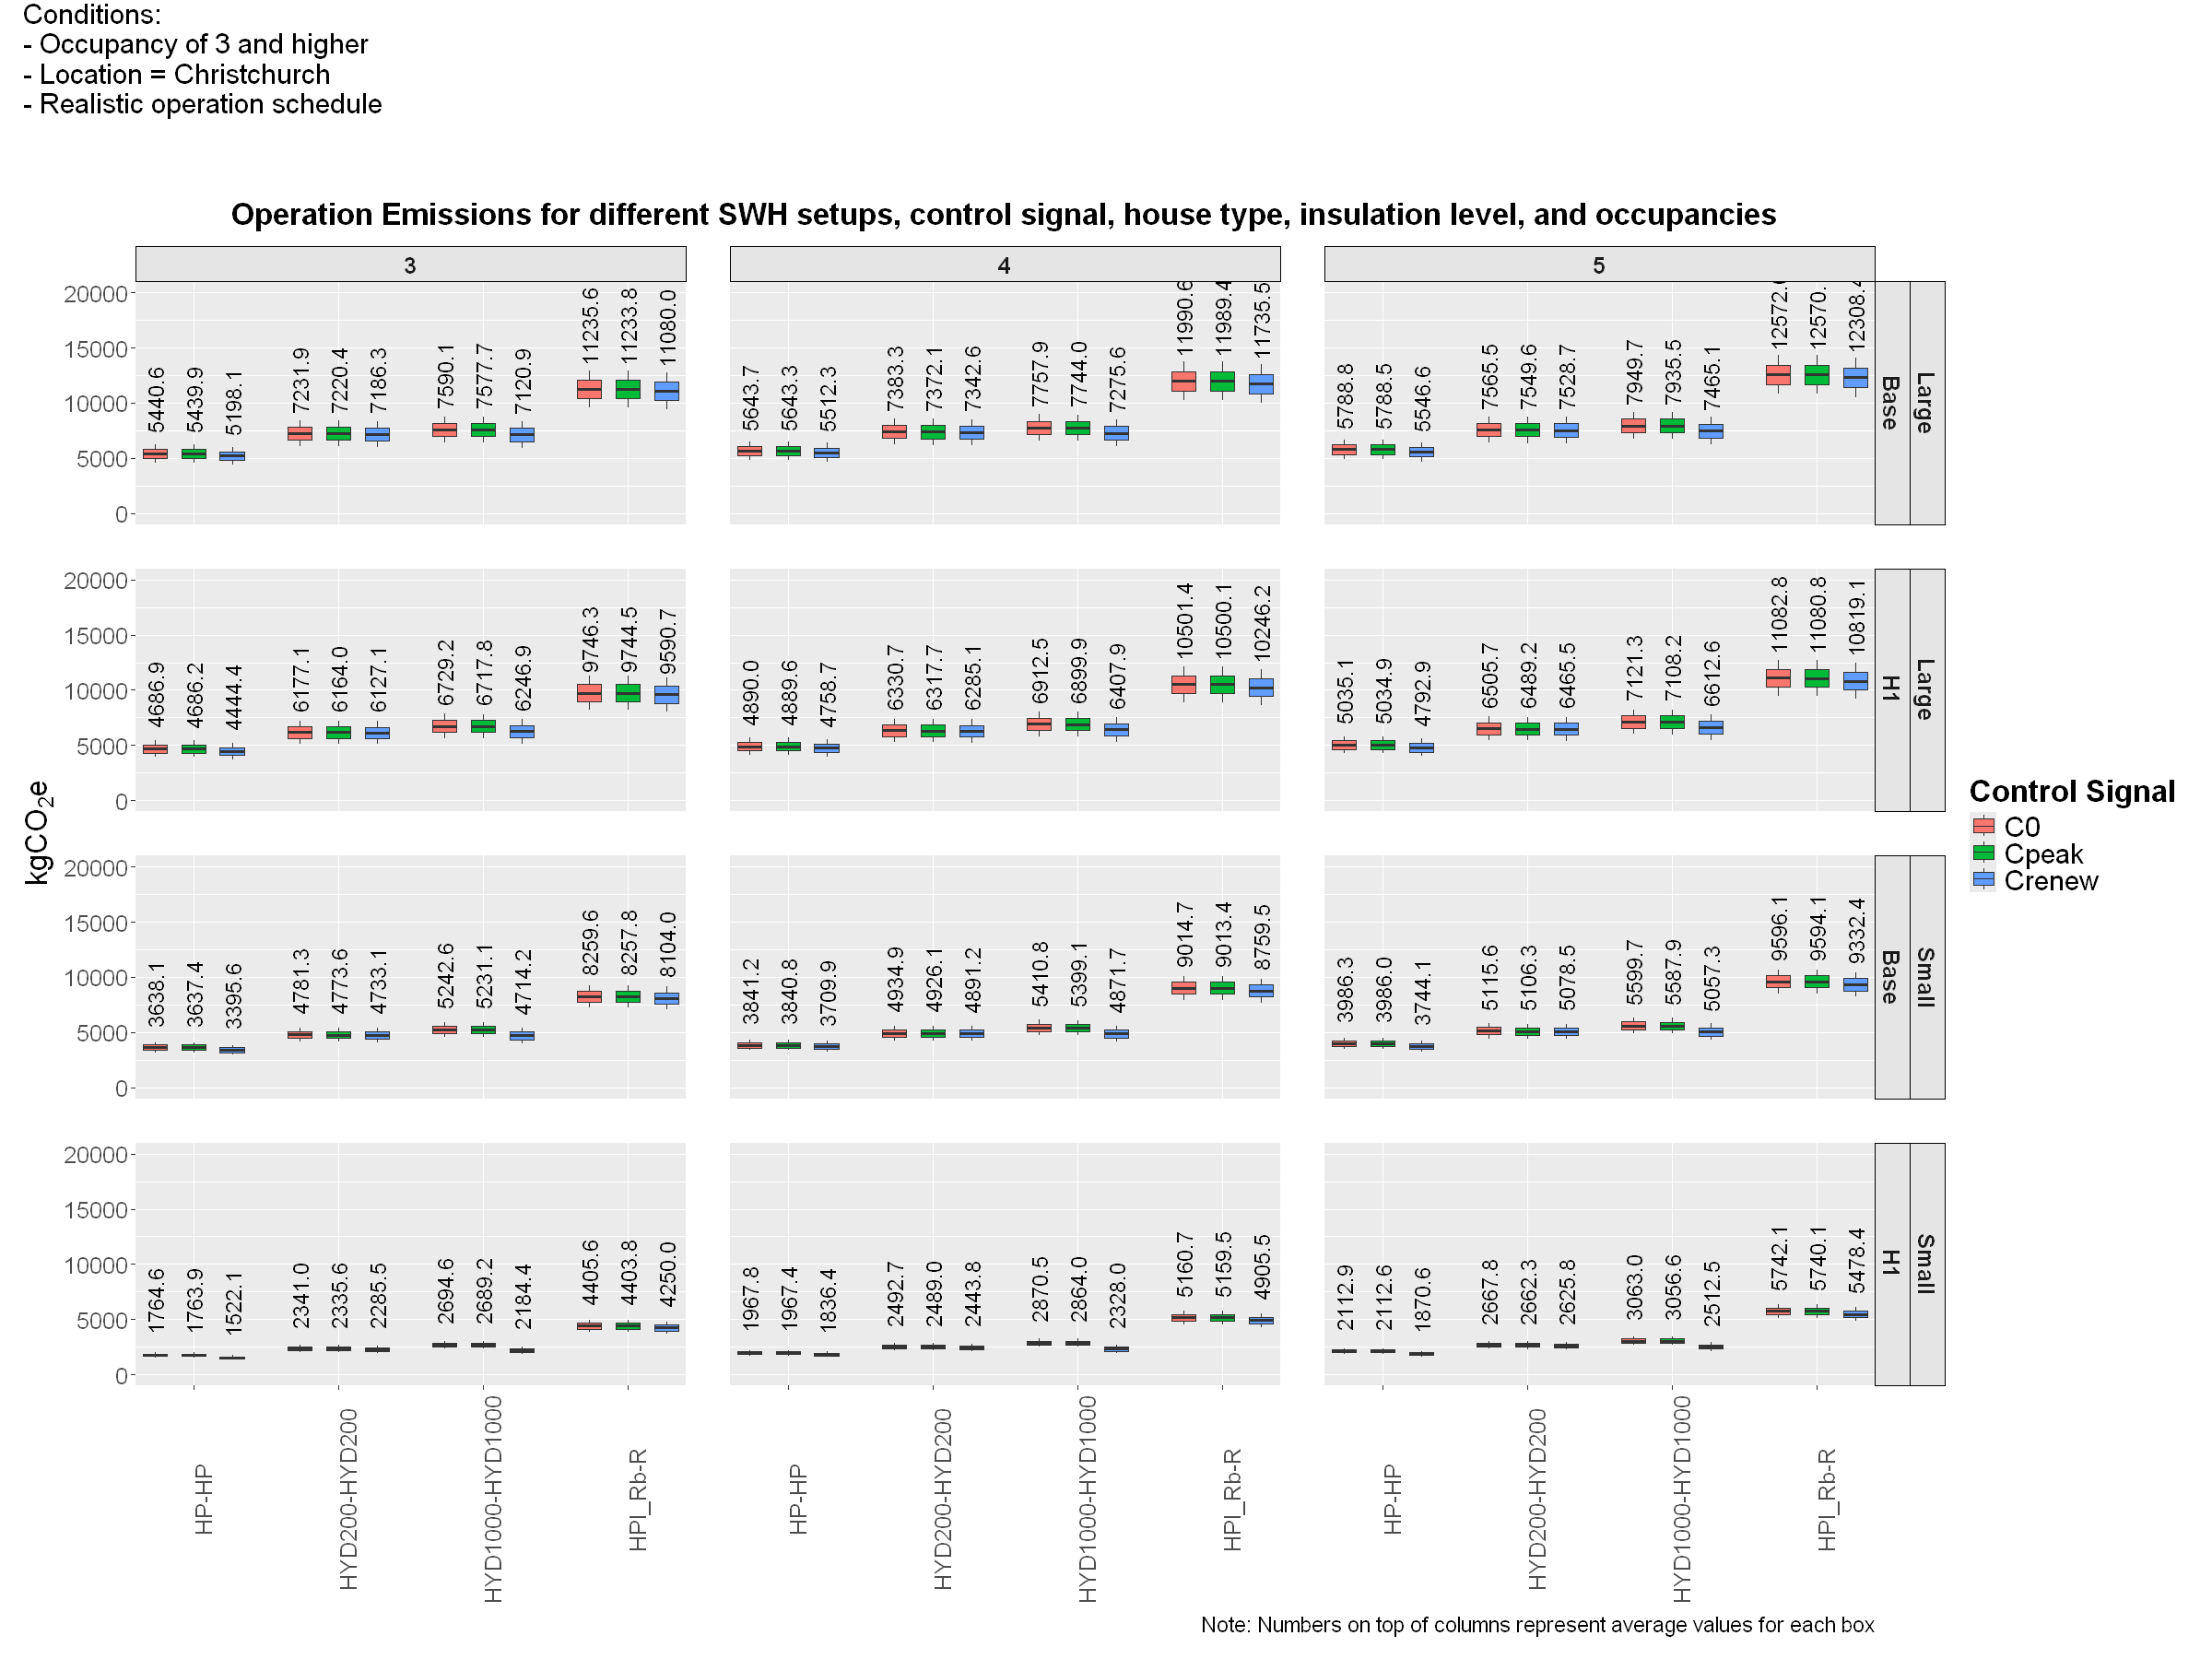

In [71]:
CS_plot_emission <- plot_CS %>% 
  filter(Type == 'Operation_life') %>%
  mutate(SH_DW_code = factor(SH_DW_code, levels = c('HP-HP', 'HYD200-HYD200', 'HYD1000-HYD1000', 'HPl_Rb-R'))) %>% 
  ggplot(aes(x = SH_DW_code, y = Emissions, fill = CS_code)) +
  #geom_col(width = 0.7, position = position_dodge(width = 0.8)) +
  geom_boxplot(width = 0.5, position = position_dodge(width = 0.8)) +
  stat_summary(
    fun = mean,
    geom = "text",
    aes(label = sprintf("%.1f", ..y..)),
    hjust = -0.3,
    #vjust= -0.01,  
    color = "black",
    size = 5,
    angle = 90,
    position = position_dodge(width = 0.8)  
  ) +
  facet_grid(house_type + insulation ~ Occ_code) + # Remove CS_code from facets
  scale_x_discrete(expand = expansion(mult = c(0.1, 0.1))) +
  scale_y_continuous(limits = c(0, 20000)) +  # <-- Set y axis from 0 to 18000
  coord_cartesian(clip = "off") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.title.y = element_text(size = 20),  
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    legend.title = element_text(size = 20, face = "bold"),
    legend.text = element_text(size = 18),  
    panel.spacing = unit(2, "lines"),
    plot.margin = margin(t = 30, r = 10, b = 10, l = 10),
    plot.caption = element_text(size = 14),
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
  labs(caption = "Note: Numbers on top of columns represent average values for each box",
       x = NULL,
       y = expression(kgCO[2]*e),
       title = "Operation Emissions for different SWH setups, control signal, house type, insulation level, and occupancies",
       fill = 'Control Signal')

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/CS_plot_emission.png",  # File path
  plot = CS_plot_emission,                       # Plot object
  width = 12,                             # Width in inches
  height = 16,                             # Height in inches
  dpi = 300                               # Resolution
)

CS_plot_emission + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- Location = Christchurch\n- Realistic operation schedule\n",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
The plot above displays only operational emissions; embodied (not displayed) emissions remain constant across all control signal scenarios. The values shown above each column represent average values for each box. 
- Overall, systems in large houses exhibit higher operational emissions than those in small houses. Likewise, houses with base insulation have higher emissions than those meeting H1 insulation standards. Interestingly, the impact of insulation on emissions is more pronounced in small houses. This suggests that large houses—classified as modern in the retrofit study—may be better suited, or face fewer constraints, in adopting improved thermal envelopes.
- The spread of values is notably larger for large houses and for those with base insulation, compared with small houses and H1 insulation, respectively. This indicates that these cases are more sensitive to variations in emissions intensity, which depend on annual hydrological inflows. In addition, systems incorporating resistive technology for water heating exhibit greater spread than other technology configurations.   
- Hydronic configurations with large thermal storage capacity (1000 L) demonstrate strong potential for operational emission reductions when using an 'intermittent following' (Crenew) control strategy. In other cases, the benefits of Crenew are more limited due to: (1) smaller storage volumes, and (2) the inability to buffer space heating demand.
- The no-control ('C0') and peak shaving ('Cpeak') scenarios yield nearly identical emission results. This occurs because the peak shaving control signal was activated only during the 30 highest national demand hours each year. While this approach aims to investigate the potential benefit of reducing capacity requirements for generation and grid infrastructure during peak periods, the limited activation time results in negligible emission reductions, as shown in the results.  

### Savings in operational emissions are limited by temporal variations in the electricity emission factor 
When focusing solely on the operation of SWH systems, it is clear that changes in technology and their associated performance can reduce emissions. In addition, the implementation of intermittent-following control can contribute further reductions. However, in this case the extent of savings depends on the temporal variation of electricity emission intensity.
The plot below illustrates how thermal demand—expressed as modelled electricity use from resistive heaters in living spaces—varies across seasons. It also shows the corresponding variation in emission intensity for the same periods. Furthermore, the following plot shows hourly variations in electricity emission intensity, for different seasons.

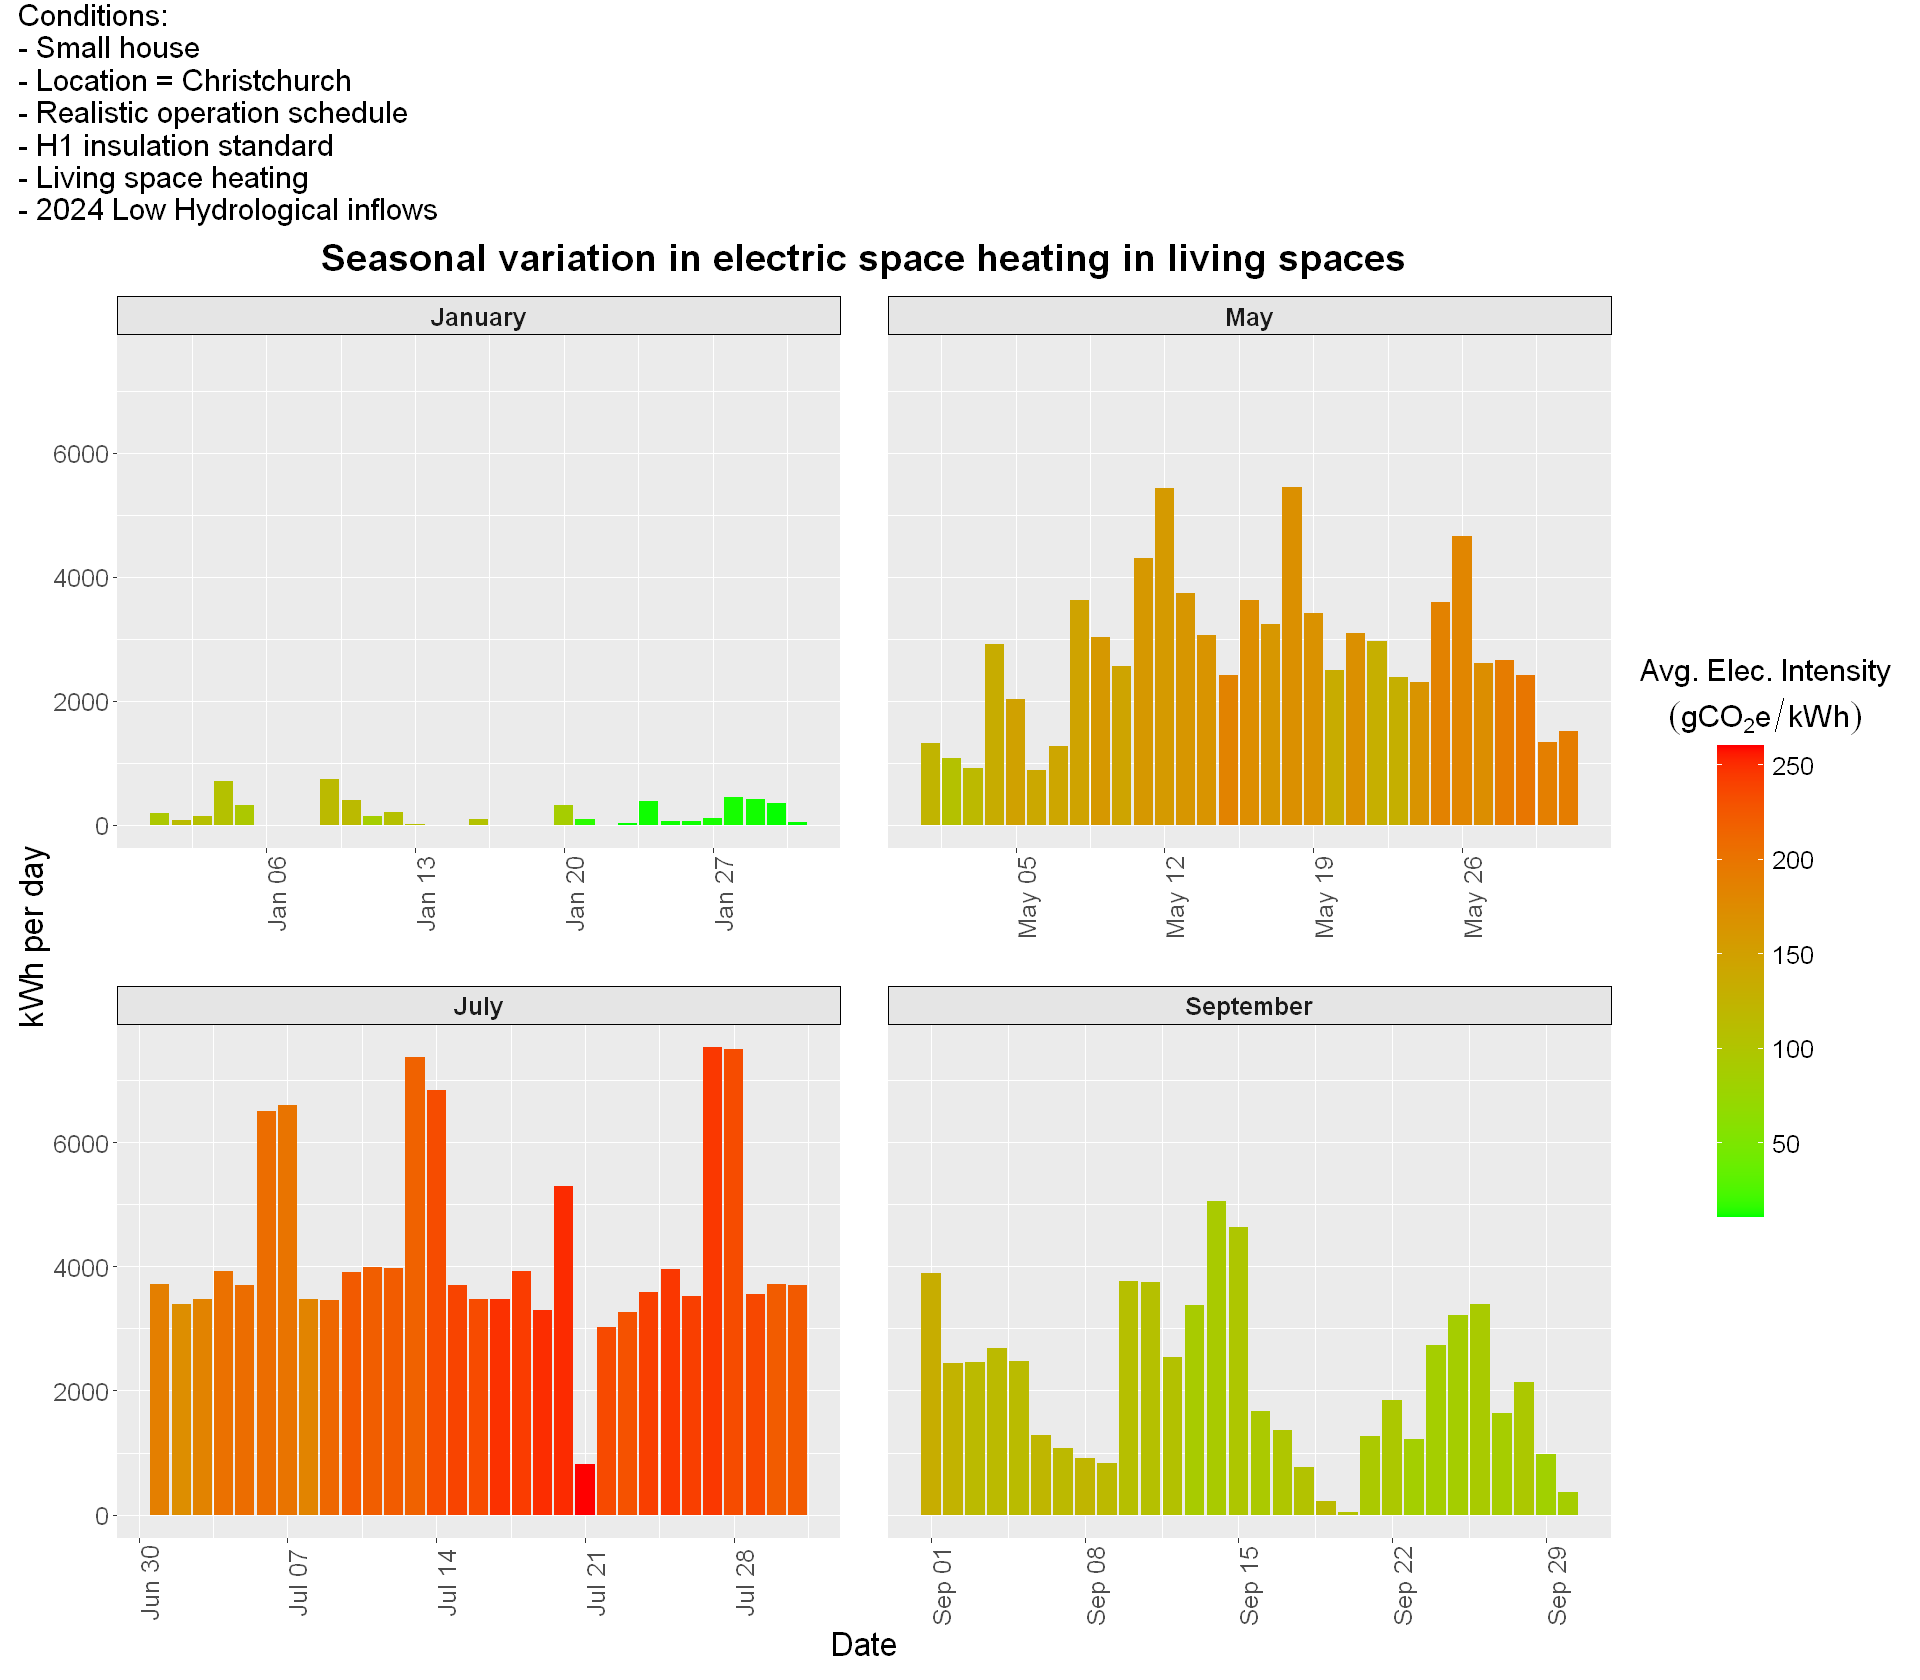

In [220]:
living_elec <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/raw/thermal/living_elec_eso.csv") %>% 
suppressMessages()
EF_base_2024_low <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/energy/All_Base_2024_low.csv") %>%
suppressMessages()
# create datetime columns
living_elec <- living_elec %>%
  mutate(datetime = ymd_h("2025-01-01 00") + hours(row_number() - 1))

# Extract month and day
living_elec <- living_elec %>%
  mutate(
    month = month(datetime, label = TRUE, abbr = FALSE),
    day = day(datetime),
    date = as_date(datetime)
  ) %>%
# Add emission intensity series column
  mutate(EF_gCO2_per_kWh = 1000*EF_base_2024_low$EF_tCO2_per_MWh_)

months_of_interest <- c("January", "May", "July", "September")
living_elec_subset <- living_elec %>%
  filter(month %in% months_of_interest)

daily_data <- living_elec_subset %>%
  group_by(month, date) %>%
  summarise(Daily_Electricity_Wh = sum(`State House Christchurch Realistic New H1`, na.rm = TRUE),
            Avg_EF_gCO2_per_kWh = mean(EF_gCO2_per_kWh, na.rm = TRUE)) %>%
  suppressMessages() %>%
  mutate(Daily_Electricity_kWh = Daily_Electricity_Wh/1000)

intensity_thermal <- ggplot(daily_data, aes(x = date, y = Daily_Electricity_kWh, fill = Avg_EF_gCO2_per_kWh)) +
  geom_col() +
  facet_wrap(~ month, scales = "free_x", nrow = 2) +
  scale_fill_gradient(
    low = "green",
    high = "red",
    name = expression(atop("Avg. Elec. Intensity", (gCO[2]*e/kWh)))
  ) +
  labs(
    title = "Seasonal variation in electric space heating in living spaces",
    x = "Date",
    y = "kWh per day"    
  ) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    legend.title = element_text(size = 18, hjust = 0.5),
    legend.text = element_text(size = 15),
    legend.key.height = unit(2, "cm"),
    legend.key.width = unit(1, "cm"),  
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.title = element_text(size = 23, face = "bold", hjust = 0.5, vjust = 2)  
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/intensity_thermal.png",  # File path
  plot = intensity_thermal,                       # Plot object
  width = 16,                             # Width in inches
  height = 16,                             # Height in inches
  dpi = 300                               # Resolution
)

intensity_thermal + 
  plot_annotation(
    title = "Conditions:\n- Small house\n- Location = Christchurch\n- Realistic operation schedule\n- H1 insulation standard\n- Living space heating\n- 2024 Low Hydrological inflows",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

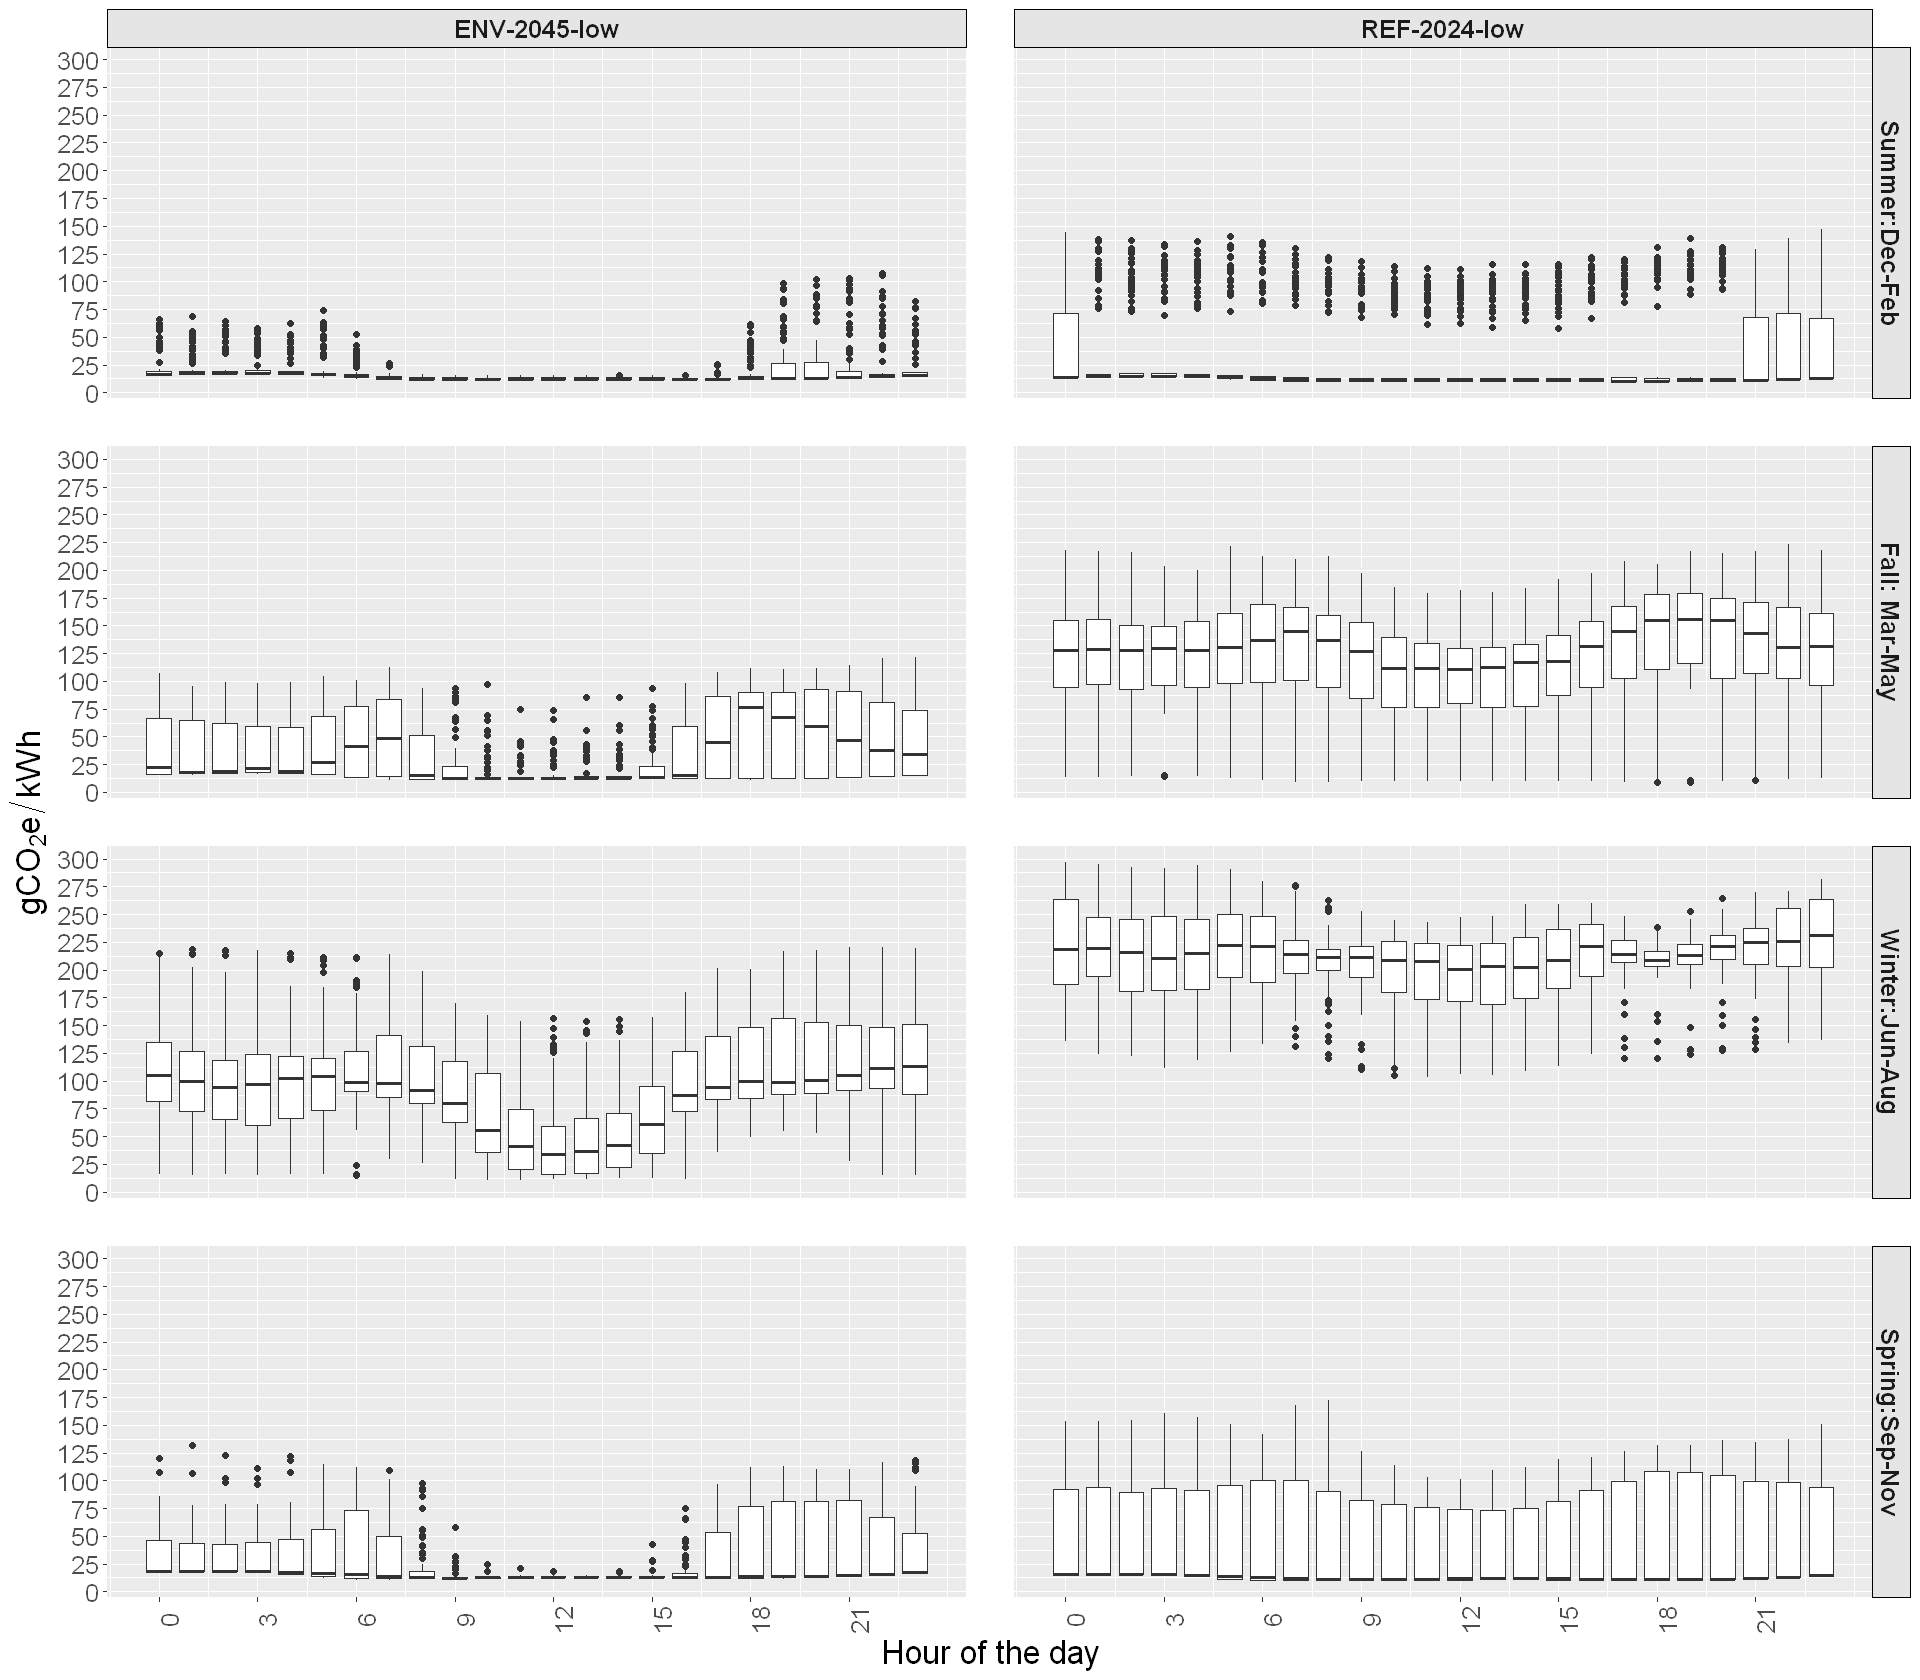

In [232]:
library(lubridate)
start_datetime <- as.POSIXct("2024-01-01 00:00", tz = "UTC")
date_hour_utc <- start_datetime + hours(0:(nrow(EF_base_2024_low) - 1))

date_hour <- with_tz(date_hour_utc, tzone = "Pacific/Auckland")

EF_base_2024_low_time <- EF_base_2024_low %>% mutate(hour = hour(date_hour), day = day(date_hour), month = month(date_hour), 
                                                weekday = wday(date_hour, label = TRUE, abbr = FALSE),
                                                day_of_year = yday(date_hour)) %>% mutate(scenario = 'REF-2024-low') %>%
  dplyr::select(hour,day,month,weekday,day_of_year,scenario,EF_tCO2_per_MWh_)

EF_env_2025_low <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/energy/All_Environmental_2045_low.csv") %>%
  suppressMessages()

EF_env_2025_low_time <- EF_env_2025_low %>% mutate(hour = hour(date_hour), day = day(date_hour), month = month(date_hour), 
                                                     weekday = wday(date_hour, label = TRUE, abbr = FALSE),
                                                     day_of_year = yday(date_hour)) %>% mutate(scenario = 'ENV-2045-low') %>%
  dplyr::select(hour,day,month,weekday,day_of_year,scenario,EF_tCO2_per_MWh_)


EF_compare <- rbind(EF_base_2024_low_time, EF_env_2025_low_time)

hour_intensity <- EF_compare %>% filter(!is.na(month)) %>%
  mutate(season = ifelse(month %in% c(12,1,2), 'Summer:Dec-Feb',
                         ifelse(month %in% c(3,4,5), 'Fall: Mar-May',
                                ifelse(month %in% c(6,7,8), 'Winter:Jun-Aug','Spring:Sep-Nov')))) %>%
  mutate(season = factor(season, levels = c('Summer:Dec-Feb','Fall: Mar-May','Winter:Jun-Aug','Spring:Sep-Nov'))) %>%
  group_by(hour,season) %>%
  ggplot(aes(x=hour, y=1000*EF_tCO2_per_MWh_, group = hour)) +
  geom_boxplot() +
  scale_x_continuous(breaks = seq(0, 23, by = 3)) +
  scale_y_continuous(breaks = seq(0, 300, by = 25))+
  facet_grid(season~scenario) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    legend.title = element_text(size = 18, hjust = 0.5),
    legend.text = element_text(size = 15),
    legend.key.height = unit(2, "cm"),
    legend.key.width = unit(1, "cm"),  
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.title = element_text(size = 23, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
  labs(x = 'Hour of the day',
       y = expression(gCO[2]*e/kWh))

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/hour_elec_intensity.png",  # File path
  plot = hour_intensity,                       # Plot object
  width = 14,                             # Width in inches
  height = 16,                             # Height in inches
  dpi = 300                               # Resolution
)

hour_intensity

### Discussion
The plots above shows how electricity demand for space heating varies throughout the year, with peak demand in July, moderate demand in the shoulder months (September and May), and minimal demand in January. Emission intensity follows a similar pattern, increasing during periods of high national electricity demand—driven largely by residential heating. This overlap is critical: the SWH systems assessed in this study operate predominantly during colder months, precisely when the grid is under the greatest pressure and emission intensities are at their highest. As a result, even when technological improvements or control strategies are applied, the potential for reducing operational emissions is constrained by seasonal variations in grid intensity. In effect, the bulk of emissions from SWH systems are locked into cold-month operation, where both demand and grid emissions converge unfavourably. Plots also show the intraday hourly variation in emission intensities, highlighting notable differences across years and EDGS scenarios. Hydrological conditions follow base year trends. The plot reveals consistent patterns across multiple cases, particularly the presence of morning and afternoon peaks, which are more pronounced during colder months.
In winter of the base year (2024), the difference between the lowest and highest median hourly emission intensities exceeds 30 gCO₂e/kWh—a substantial margin considering the annual average of approximately 100 gCO₂e/kWh. Looking ahead to 2045 under the Environmental scenario, overall emission intensities decrease markedly across all hours and seasons, with the most pronounced reductions occurring in winter and fall. The intraday range of emission intensities also widens; in winter, the difference between the lowest and highest median hourly values surpasses 70 gCO₂e/kWh. This reflects the impact of projected large-scale deployment of solar PV capacity in the Environmental scenario
The increase in solar PV generation not only influences emission intensities during daylight hours but also affects dispatch patterns during non-daylight periods. The power dispatch model regulates hydro storage levels, enabling hydro generation to be deferred to times of high demand and low intermittent supply. These intraday variations in emission intensity highlight the importance of implementing a power dispatch model with hourly resolution, as it allows for a more accurate assessment of demand response strategies.

## A closer look to hydronic setups
Hydronic setups showed relatively better potential for reducing emissions when adopting a 'Cenew' control. Hydronic setups are isolated to explore the impact of thermal storage size on the operational emissions. Furthermore, this section looks at the impact of house type and thermal envelope on the operation of these setups. The analysis focuses on Christchurch, which showed significant potential for operational energy savings in hydronic systems.

In [17]:
technology_lifetime_Call <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/technology_lifetime_Call.csv") %>%
    suppressMessages() %>%
mutate(house_type = ifelse(house_type == 'Mod', 'Large', 'Small')) %>%
    mutate(insulation = ifelse(insulation == 'Nom', 'Base', insulation))

In [92]:
# Step 1: Filter and aggregate
technology_lifetime_Call_hyd <- technology_lifetime_Call %>% 
  filter(!is.na(DW_code)) %>% 
  filter(DW_code %in% c("HYD200", "HYD500", "HYD1000")) %>%  
  filter(CS_code != 'Cpeak') %>%
  filter(Loc_code == 'CH') %>%
  filter(schedule == 'Real') %>%
  filter(Occ_code == 3) %>%  
  mutate(DW_code = factor(DW_code, levels = c("HYD200", "HYD500", "HYD1000"))) %>%
  group_by(DW_code, Loc_code, house_type, insulation, HP_cap, `Tank_Volume (L)`, CS_code, Hydro_resource) %>% 
  summarise(
    kgCO2 = mean(kgCO2_oper_life),
    kWh = mean(P_annual_kWh_life),
    .groups = "drop"
  ) %>%
  mutate(kgCO2_per_kWh = kgCO2 / kWh)

# Step 2: Compute base case (CS_code == "C0") per DW_code
technology_lifetime_Call_hyd_base <- technology_lifetime_Call_hyd %>%
  filter(CS_code == "C0") %>%
  select(DW_code, Loc_code, house_type, insulation, HP_cap, `Tank_Volume (L)`, Hydro_resource, kgCO2_base = kgCO2)

# Step 3: Join and calculate differences
technology_lifetime_Call_hyd_diff <- technology_lifetime_Call_hyd %>%
  left_join(
    technology_lifetime_Call_hyd_base,
    by = c("DW_code", "Loc_code", "house_type", "insulation", "HP_cap", "Tank_Volume (L)","Hydro_resource")
  ) %>%
  mutate(
    diff_p = (kgCO2 - kgCO2_base) / kgCO2_base * 100, # percent difference from base case
    diff_a = kgCO2 - kgCO2_base # percent difference from base case  
  )

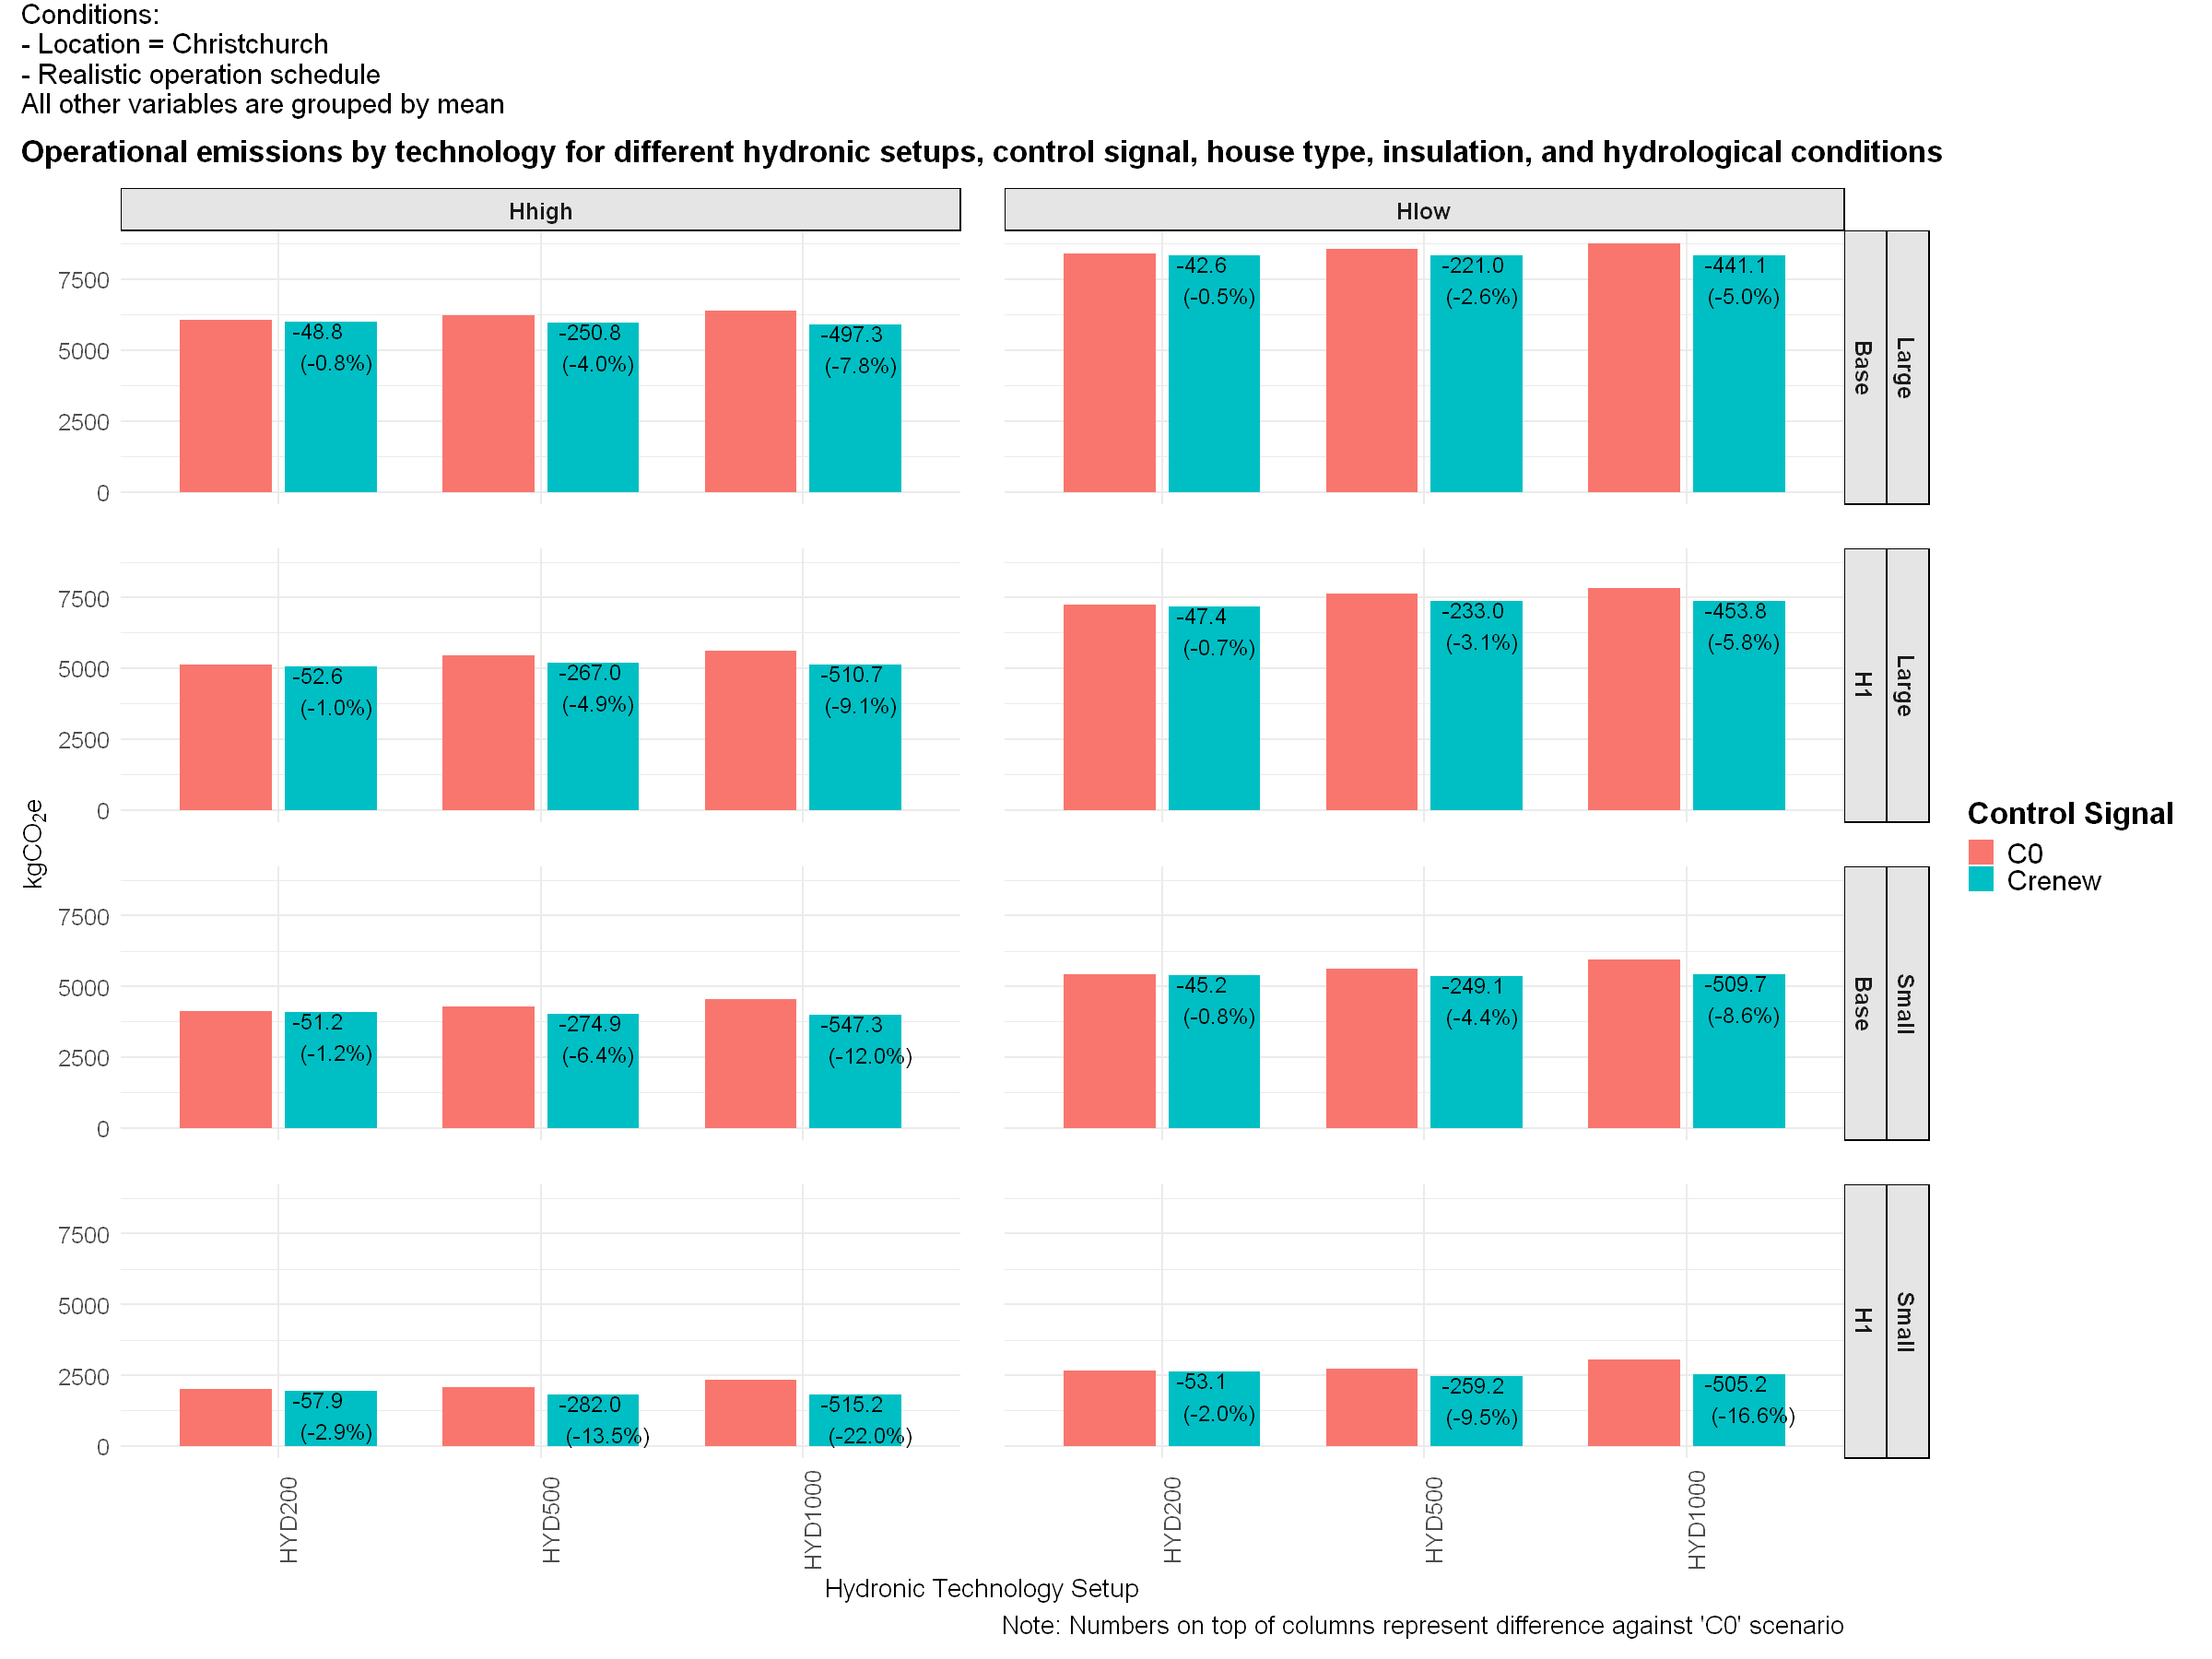

In [98]:
hyd_plot <- technology_lifetime_Call_hyd_diff %>%
  ggplot(aes(x = DW_code, y = kgCO2, fill = CS_code)) + 
  geom_col(width = 0.7, position = position_dodge(width = 0.8)) +
  geom_text(
    aes(label = ifelse(!is.na(diff_a) & CS_code == 'Crenew', sprintf("%.1f\n(%.1f%%)", diff_a,diff_p), "")),
    size = 5,
    color = "black",
    hjust = -0.3,
    vjust = 1  
  ) +
  facet_grid(house_type + insulation ~ Hydro_resource) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size = 15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    legend.title = element_text(size = 20, face = "bold"),
    legend.text = element_text(size = 18),  
    plot.caption = element_text(size = 16),
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
  labs(
    x = "Hydronic Technology Setup",
    y = expression(kgCO[2]*e),
    fill = 'Control Signal',
    title = "Operational emissions by technology for different hydronic setups, control signal, house type, insulation, and hydrological conditions",
    caption = "Note: Numbers on top of columns represent difference against 'C0' scenario",
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/hyd_plot.png",  # File path
  plot = hyd_plot,                       # Plot object
  width = 16,                             # Width in inches
  height = 16,                             # Height in inches
  dpi = 300                               # Resolution
)

hyd_plot + 
  plot_annotation(
    title = "Conditions:\n- Location = Christchurch\n- Realistic operation schedule\nAll other variables are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
Interestingly, the plot above shows that emission reductions from using an intermittent-following control signal (Crenew) are strengthened under specific conditions:

- House type: Smaller houses achieve larger percentage reductions compared to larger houses.
- Insulation: Better-insulated houses (H1) yield higher savings, in some cases nearly doubling the reductions relative to base insulation.
- Hydrological conditions: Favourable (“High”) inflows not only reduce emissions overall but also amplify the potential savings from implementing a Crenew control signal in hydronic setups.

The results also indicate that larger storage tanks enable greater emission savings, though this will likely come at the cost of higher embodied emissions.
Additionally, when looking only at the no-control cases, emissions tend to increase with larger tank sizes, despite serving the same thermal demand (e.g., in a small house with base insulation), due to the additional standing losses associated with bigger tanks.

#### How does the ability to use thermal storage for load shifting affect the overall attractiveness of hydronic scenarios?
More thermal storage increases flexibility for demand shifting, but it also raises the embodied emissions of the system. To assess the net attractiveness of the three hydronic setups, we can compare both operational and embodied emissions to determine whether the reduction potential of intermittent-following hydronic setups makes them more appealing than:
- the all heat pump setups (so far the most favourable in terms of emissions), and
- the hybrid setup (HPl_Rb-R), which likely represents business-as-usual (BAU).

Again, the analysis is based on Christchurch, where the potential for emission reductions is greatest.

In [ ]:
household_lifetime_Call_CS_high <- household_lifetime_Call %>% 
filter(Occ_code == 3, 
       Loc_code == 'CH',
      SH_DW_code %in% c('HP-HP', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD500-HYD500', 'HYD1000-HYD1000'),
      Hydro_resource == 'Hhigh',
      schedule == 'Real') %>%
group_by(house_type, insulation, SH_DW_code, CS_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_CS_high <- household_lifetime_Call_CS_high %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions")

diff_df <- household_lifetime_Call_CS_high %>%
  filter(CS_code %in% c("Crenew", "C0")) %>%
  select(house_type, insulation, SH_DW_code, CS_code, Total) %>%
  pivot_wider(names_from = CS_code, values_from = Total) %>%
  mutate(diff = Crenew - C0)

# Join with max y position from plot_CS_high (stacked height for 'Crenew')
label_pos <- plot_CS_high %>%
  filter(CS_code == "Crenew") %>%
  group_by(house_type, insulation, SH_DW_code) %>%
  summarise(y = sum(Total), .groups = "drop")

diff_df <- left_join(diff_df, label_pos, by = c("house_type", "insulation", "SH_DW_code"))

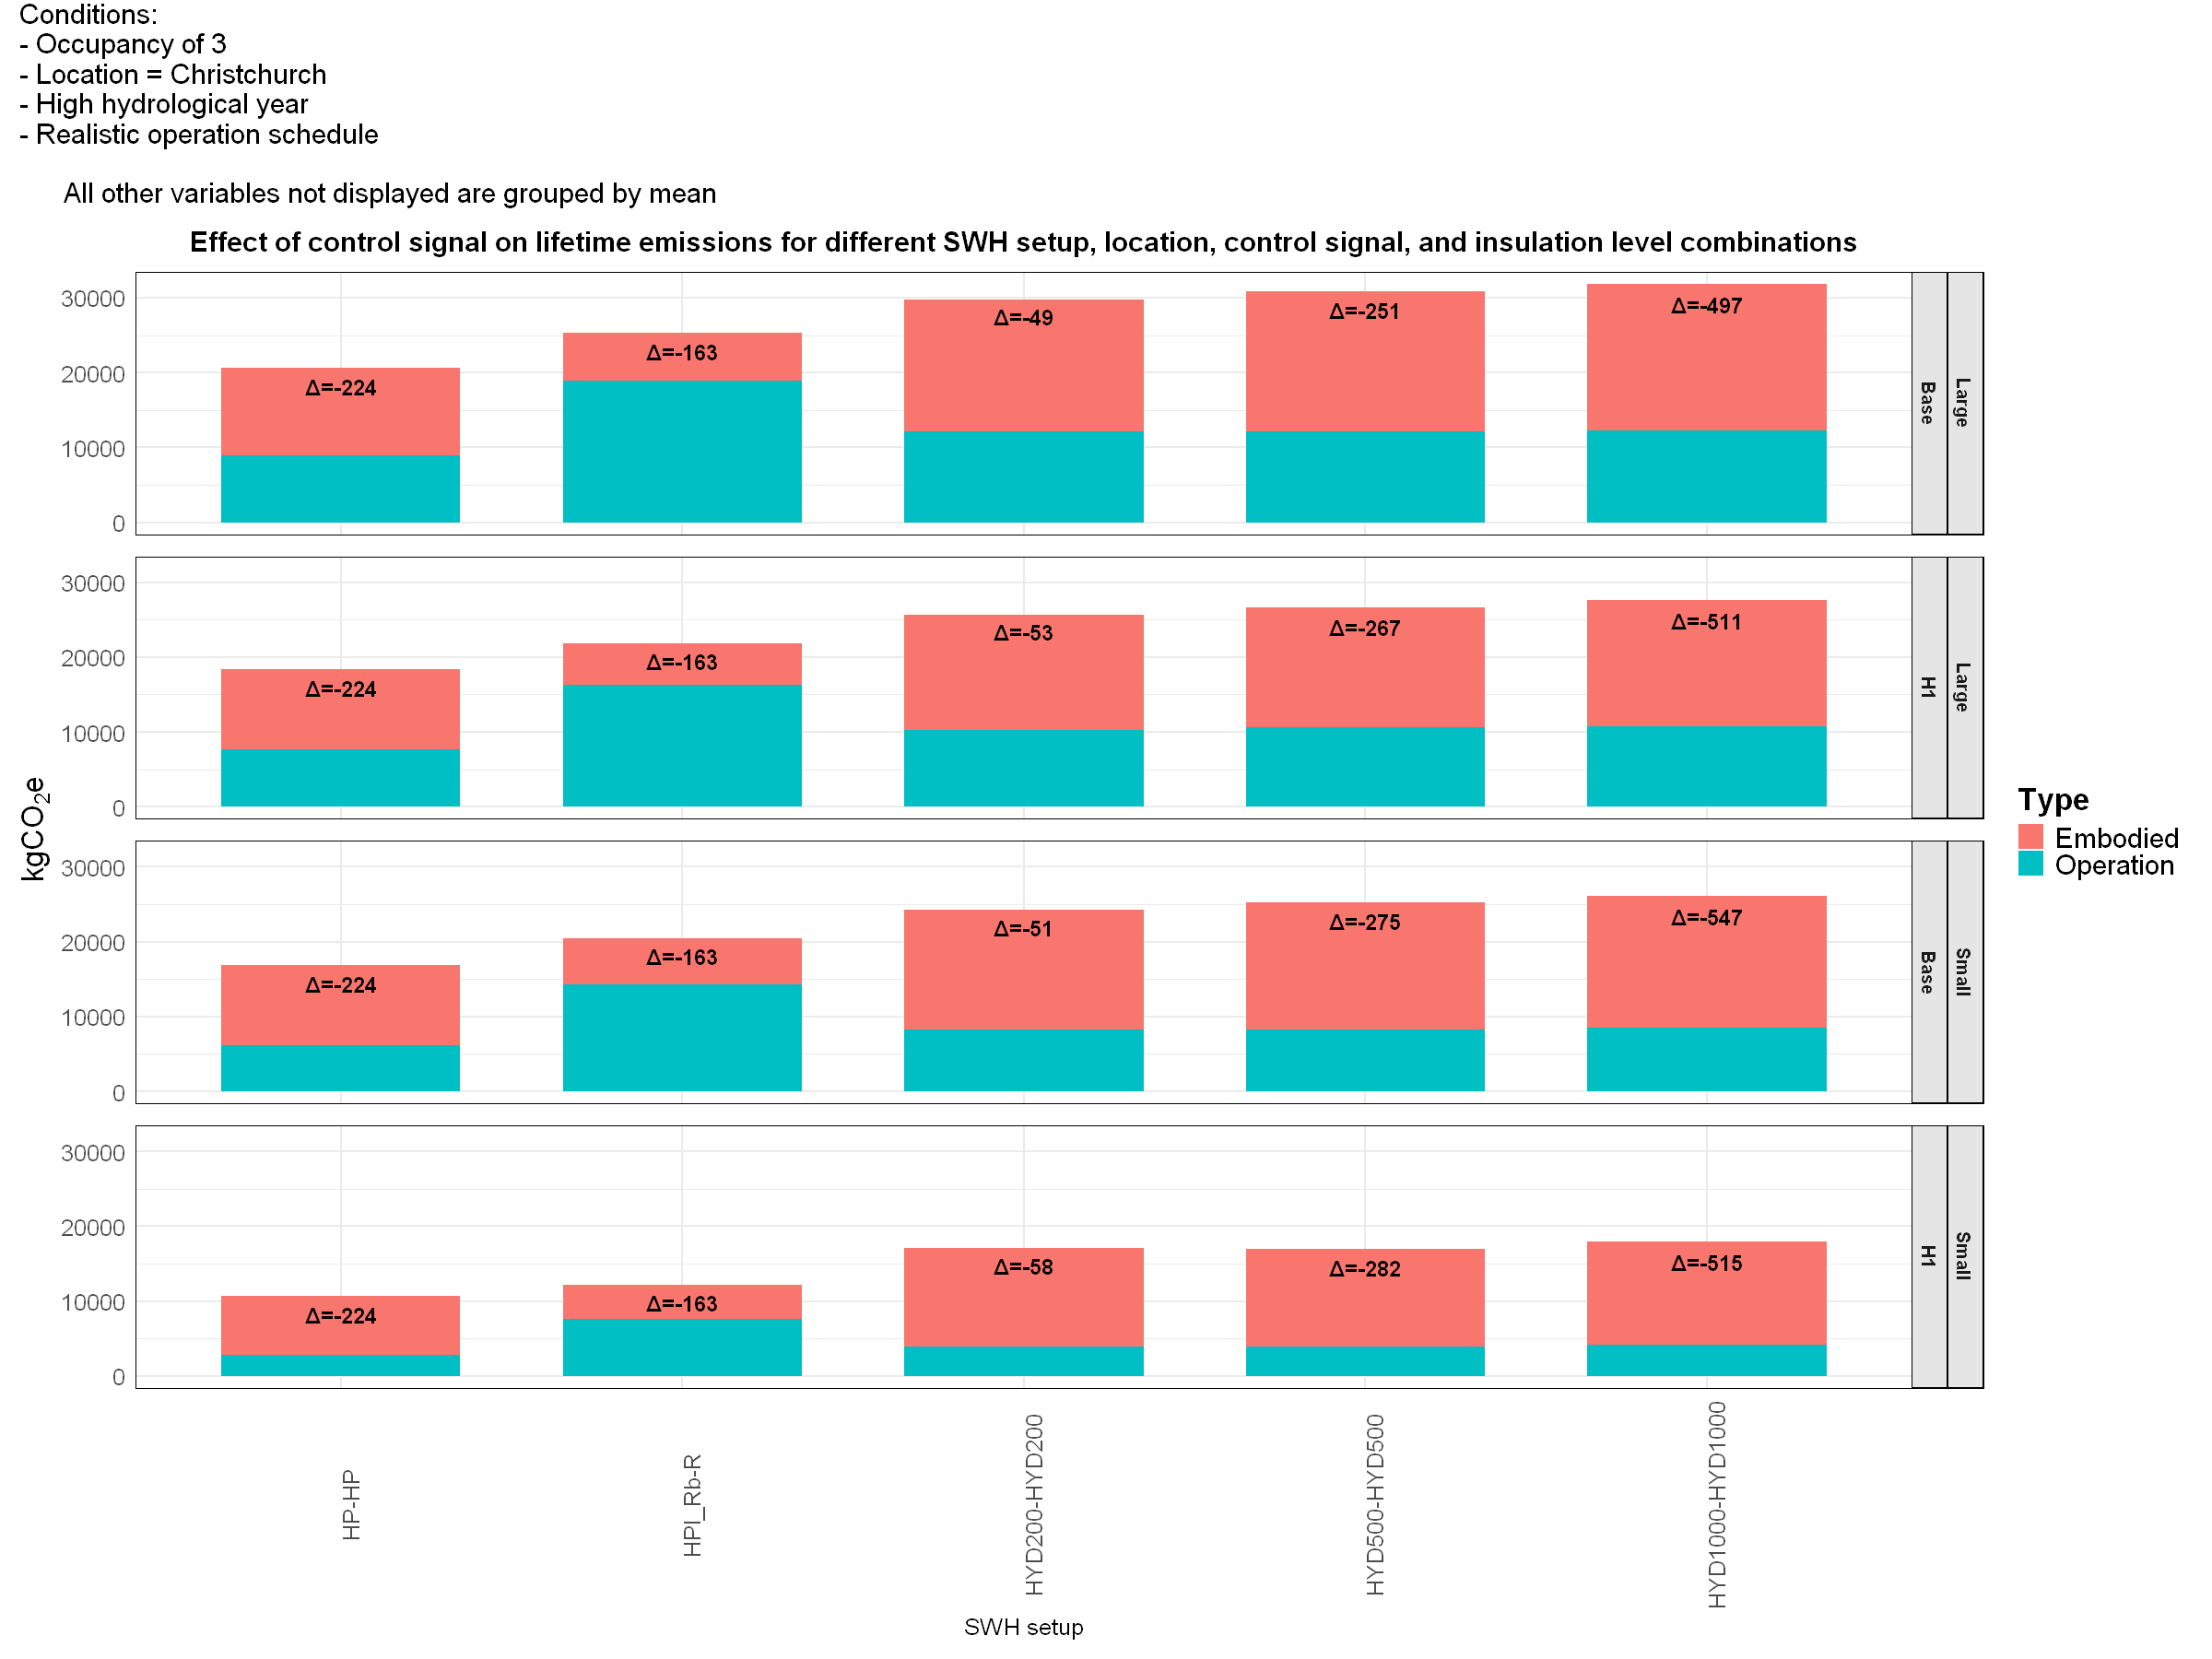

In [97]:
CS_attractiveness_plot <- plot_CS_high %>%
  filter(CS_code != 'Cpeak') %>%
  ggplot(aes(x = SH_DW_code, y = Emissions, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  facet_grid(house_type + insulation ~ .) +   # Only facet by house_type and insulation
  geom_text(
    data = diff_df,
    aes(x = SH_DW_code, y = y - 4000, label = sprintf("Δ=%.0f", diff)),
    vjust = -0.3,
    fontface = "bold",
    color = "black",
    size = 5,
    inherit.aes = FALSE
  ) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH setup",
       y = expression(kgCO[2]*e),
       title = "Effect of control signal on lifetime emissions for different SWH setup, location, control signal, and insulation level combinations") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.title.y = element_text(size = 20),  
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(size = 20, face = "bold"),
    legend.text = element_text(size = 18),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5, vjust = 2)  
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/CS_attractiveness_plot.png",  # File path
  plot = CS_attractiveness_plot,                       # Plot object
  width = 16,                             # Width in inches
  height = 14,                             # Height in inches
  dpi = 300                               # Resolution
)

CS_attractiveness_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3\n- Location = Christchurch\n- High hydrological year\n- Realistic operation schedule\n
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
The plot above displays both embedded and operational emissions for a few cases. In terms of total lifetime emissions, it can be seen that both the all-heat pump (HP-HP) and BAU (HPl_Rb-R) outperform the hydronic setups even for the 'intermittent-following' signal cases. 
For hydronic cases, the reduction in operational emissions achieved through greater thermal storage is not enough to offset the resulting increase in embodied emissions.

## Impact of oversizing water heating storage in non-hydronic settings
In non-hydronic settings, thermal storage only provides load-shifting flexibility for water heating demand. This part looks at the potential benefits for these cases, particularly for systems running with a heat pump. 

In [22]:
technology_lifetime_Call_DW <- technology_lifetime_Call %>% 
  filter(!is.na(DW_code)) %>% 
  filter(DW_code %in% c("HP", "HPo")) %>%  
  filter(CS_code != 'Cpeak') %>%
  #filter(Hydro_resource == 'Hhigh') %>%
  filter(Loc_code == 'CH') %>%  
  group_by(DW_code, Loc_code, Occ_code, HP_cap,`Tank_Volume (L)`, CS_code, Hydro_resource) %>% 
  summarise(kgCO2 = mean(kgCO2_oper_life),
            kWh = mean(P_annual_kWh_life)) %>% 
  suppressMessages() %>%
  ungroup() %>%
  mutate(kgCO2_per_kWh = kgCO2/kWh) 
# Calculate base case emissions
technology_lifetime_Call_DW_base <- technology_lifetime_Call_DW %>%
  filter(CS_code == 'C0') %>%
  select(Loc_code, DW_code, Occ_code, HP_cap, `Tank_Volume (L)`, Hydro_resource, kgCO2_C0 = kgCO2)
# Join base emissions onto all CS_code values
technology_lifetime_Call_DW_diff <- technology_lifetime_Call_DW %>%
  left_join(technology_lifetime_Call_DW_base, by = c("Loc_code", "DW_code", "Occ_code", "HP_cap", "Tank_Volume (L)", 'Hydro_resource')) %>%
  mutate(diff_p = 100*(kgCO2 - kgCO2_C0)/kgCO2,
         diff_a = kgCO2 - kgCO2_C0
        )

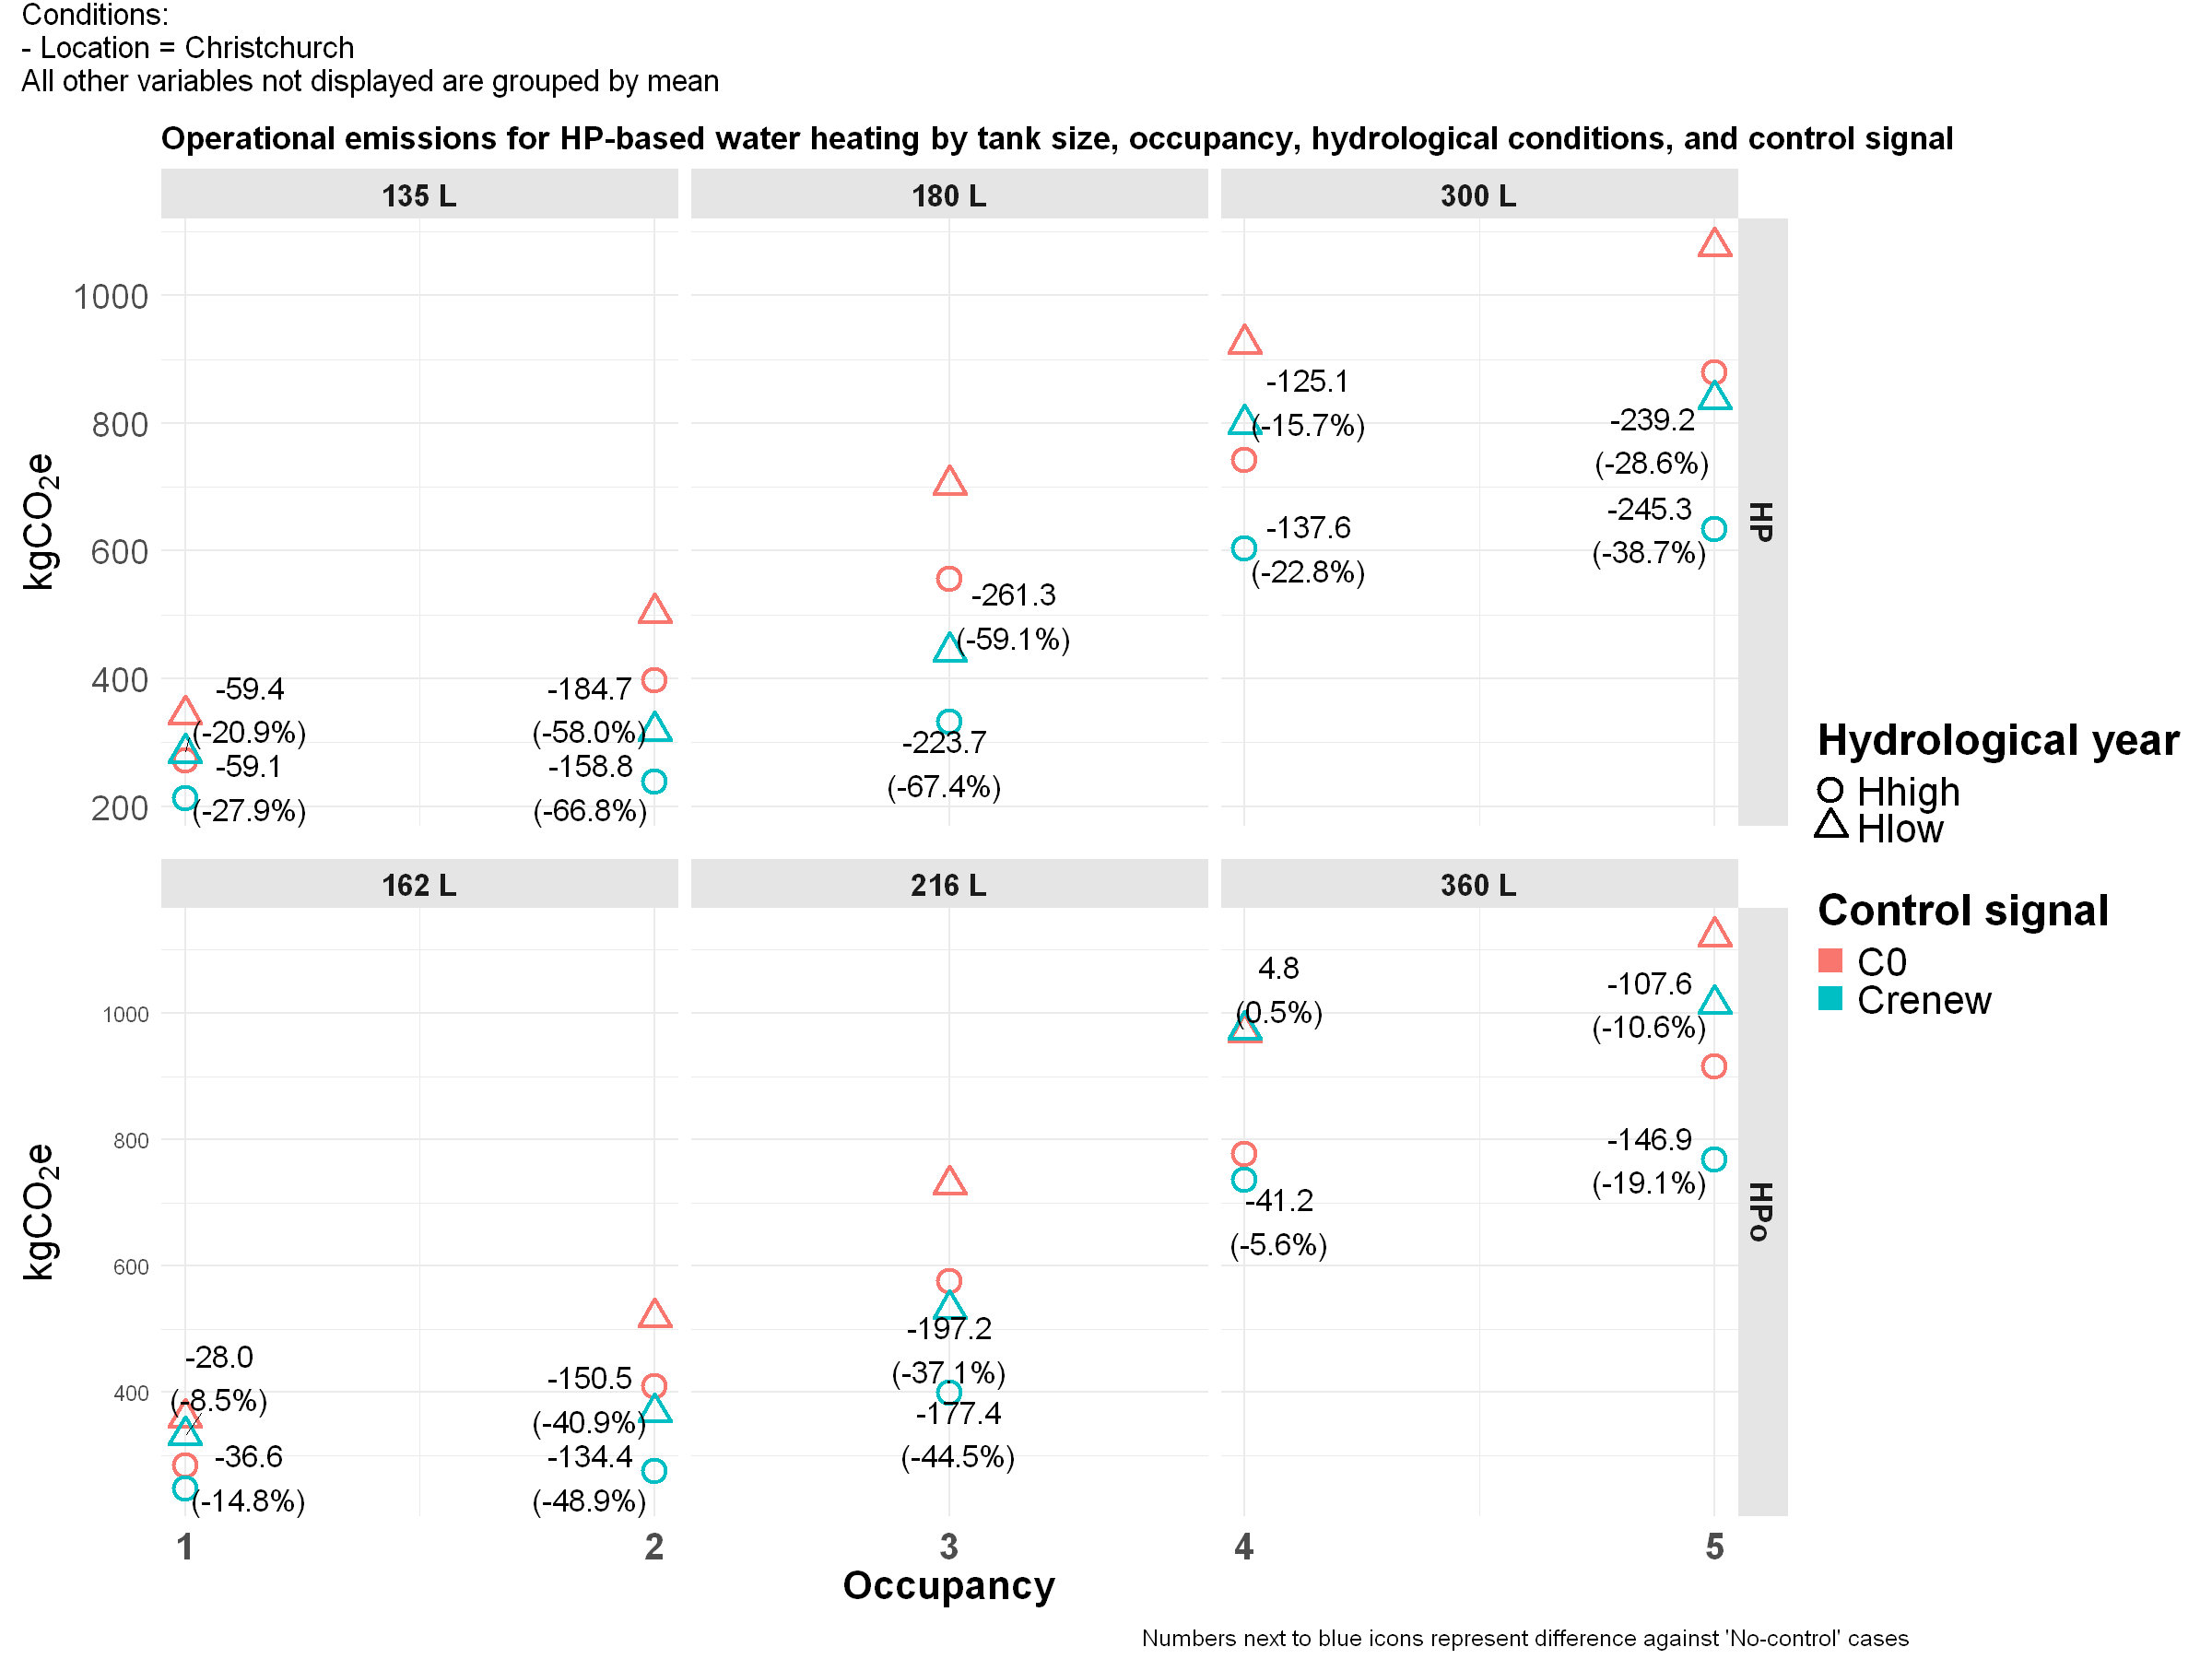

In [106]:
library(ggrepel)
df_HP  <- technology_lifetime_Call_DW_diff %>% filter(DW_code == 'HP')  %>%
  mutate(Tank_Label = paste0(`Tank_Volume (L)`, " L"))
df_HPo <- technology_lifetime_Call_DW_diff %>% filter(DW_code == 'HPo') %>%
  mutate(Tank_Label = paste0(`Tank_Volume (L)`, " L"))

plot_HP <- ggplot(df_HP, aes(x = as.integer(Occ_code), y = kgCO2)) + 
  geom_point(aes(color = CS_code, shape = Hydro_resource), size = 6, stroke = 2) + 
  geom_text_repel(
    aes(label = ifelse(!is.na(diff) & CS_code == 'Crenew', sprintf("%.1f\n(%.1f%%)", diff_a, diff_p), "")),
    #vjust = 1.2,
    size = 7,
    color = "black"
  ) +
  facet_grid(DW_code ~ Tank_Label, scales = "free_x", drop = TRUE) +
  scale_x_continuous(breaks = unique(as.integer(df_HP$Occ_code))) +
  scale_shape_manual(values = c("Hhigh" = 1, "Hlow" = 2)) +
  guides(color = guide_legend(override.aes = list(shape = 15, size = 6))) +  
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 26, face = 'bold'),  
    axis.text.y = element_text(size = 22),  
    legend.title = element_text(size = 28, face = "bold"),
    legend.text = element_text(size = 26),  
    strip.background = element_rect(fill = "grey90", color = NA),
    axis.text.x = element_blank(), 
    axis.ticks.x = element_blank(),
    strip.text = element_text(face = "bold", size=20),
    plot.title =  element_text(face = "bold", size=21)
  ) +
  labs(title = 'Operational emissions for HP-based water heating by tank size, occupancy, hydrological conditions, and control signal')   

plot_HPo <- ggplot(df_HPo, aes(x = as.integer(Occ_code), y = kgCO2)) + 
  geom_point(aes(color = CS_code, shape = Hydro_resource), size = 6, stroke = 2) + 
  geom_text_repel(
    aes(label = ifelse(!is.na(diff) & CS_code == 'Crenew', sprintf("%.1f\n(%.1f%%)", diff_a, diff_p), "")),
    #vjust = 1.2,
    size = 7,
    color = "black"
  ) +
  facet_grid(DW_code ~ Tank_Label, scales = "free_x", drop = TRUE) +
  scale_x_continuous(breaks = unique(as.integer(df_HPo$Occ_code))) +
  coord_cartesian(clip = "off") +
  scale_shape_manual(values = c("Hhigh" = 1, "Hlow" = 2)) +
  guides(color = guide_legend(override.aes = list(shape = 15, size = 6))) +  
  theme_minimal(base_size = 17) +
  theme(
    axis.title.x = element_text(size = 26, face = 'bold'),
    axis.text.x = element_text(size = 24, face = 'bold', vjust=0.5),  
    axis.title.y = element_text(size = 26, face = 'bold'),  
    legend.title = element_text(size = 28, face = "bold"),
    legend.text = element_text(size = 26),  
    strip.background = element_rect(fill = "grey90", color = NA),
    strip.text = element_text(face = "bold", size=20)     
    )

plot_oversized_tank <- (plot_HP / plot_HPo) +
  plot_layout(guides = "collect") &
  labs(x = "Occupancy", y = expression(kgCO[2]*e),
      color = "Control signal", shape = 'Hydrological year') &
  plot_annotation(
    title = "Conditions:\n- Location = Christchurch\nAll other variables not displayed are grouped by mean",
    caption = "Numbers next to blue icons represent difference against 'No-control' cases",  
    theme = theme(
      plot.title = element_text(size = 20, hjust = 0, vjust = 2),
      plot.caption = element_text(size = 15, hjust = 0.8)
    ))

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/plot_oversized_tank.png",  # File path
  plot = plot_oversized_tank,                       # Plot object
  width = 16,                             # Width in inches
  height = 14,                             # Height in inches
  dpi = 300                               # Resolution
)

plot_oversized_tank


### Discussion
The plot above shows operational emissions for water heating with heat pumps, including cases with oversized storage tanks ("HPo").
Key observations:
- Compared to hydronic systems, emissions are significantly lower because heat pumps only operate to meet water-heating demand.
- Emissions are higher in "oversized" setups, despite identical water draws between base and oversized cases.
- Emissions increase with both occupancy level and tank size.
- In most cases, emissions are higher under No-control (C0) scenarios.

Across facets with tank sizes below 180 L and above 216 L, the differences between control scenarios grow with occupancy. At lower occupancies and/or with oversized tanks, storage utilisation is reduced, and more electricity is lost through standing losses. As a result, relative emission reductions are smaller in these cases. There is a single instance where emissions under C0 are marginally lower (0.5%) than under a controlled case, which aligns with this trend.
Unlike hydronic systems, increasing tank size does not lower emissions; it raises them, since larger tanks increase standing losses without providing enough additional storage to enable meaningful operational flexibility.

## Impact of climate on heat pump performance
It is worth exploring this aspect, since heat pump water heaters in the model are defined with control signal, occupancy, tank size, and outside temperature (climate) as independent variables. Additionally, the water-heating demand was assumed to be constant across all locations, house types, and insulation levels. Cases with a high hydrological year were isolated for analysis.

In [24]:
technology_lifetime_Call_DW_HP <- technology_lifetime_Call %>% 
  filter(!is.na(DW_code)) %>% 
  filter(DW_code %in% c("HP")) %>%  
  filter(Hydro_resource == 'Hhigh') %>% 
  filter(CS_code != 'Cpeak') %>%
  group_by(DW_code, Loc_code, Occ_code, HP_cap,`Tank_Volume (L)`, CS_code) %>% 
  summarise(kgCO2 = mean(kgCO2_oper_life),
            kWh = mean(P_annual_kWh_life)) %>% 
  suppressMessages() %>%
  ungroup() %>%
  mutate(kgCO2_per_kWh = kgCO2/kWh) 
# Calculate base case emissions
technology_lifetime_Call_DW_HP_base <- technology_lifetime_Call_DW_HP %>%
  filter(Loc_code == 'AK') %>%
  select(Occ_code, HP_cap, `Tank_Volume (L)`, kgCO2_AK = kgCO2, CS_code)
# Join base emissions onto all CS_code values
technology_lifetime_Call_DW_HP_diff <- technology_lifetime_Call_DW_HP %>%
  left_join(technology_lifetime_Call_DW_HP_base, by = c("Occ_code", "HP_cap", "Tank_Volume (L)","CS_code")) %>%
  mutate(diff_p = 100*(kgCO2 - kgCO2_AK)/kgCO2,
         diff_a = kgCO2 - kgCO2_AK)

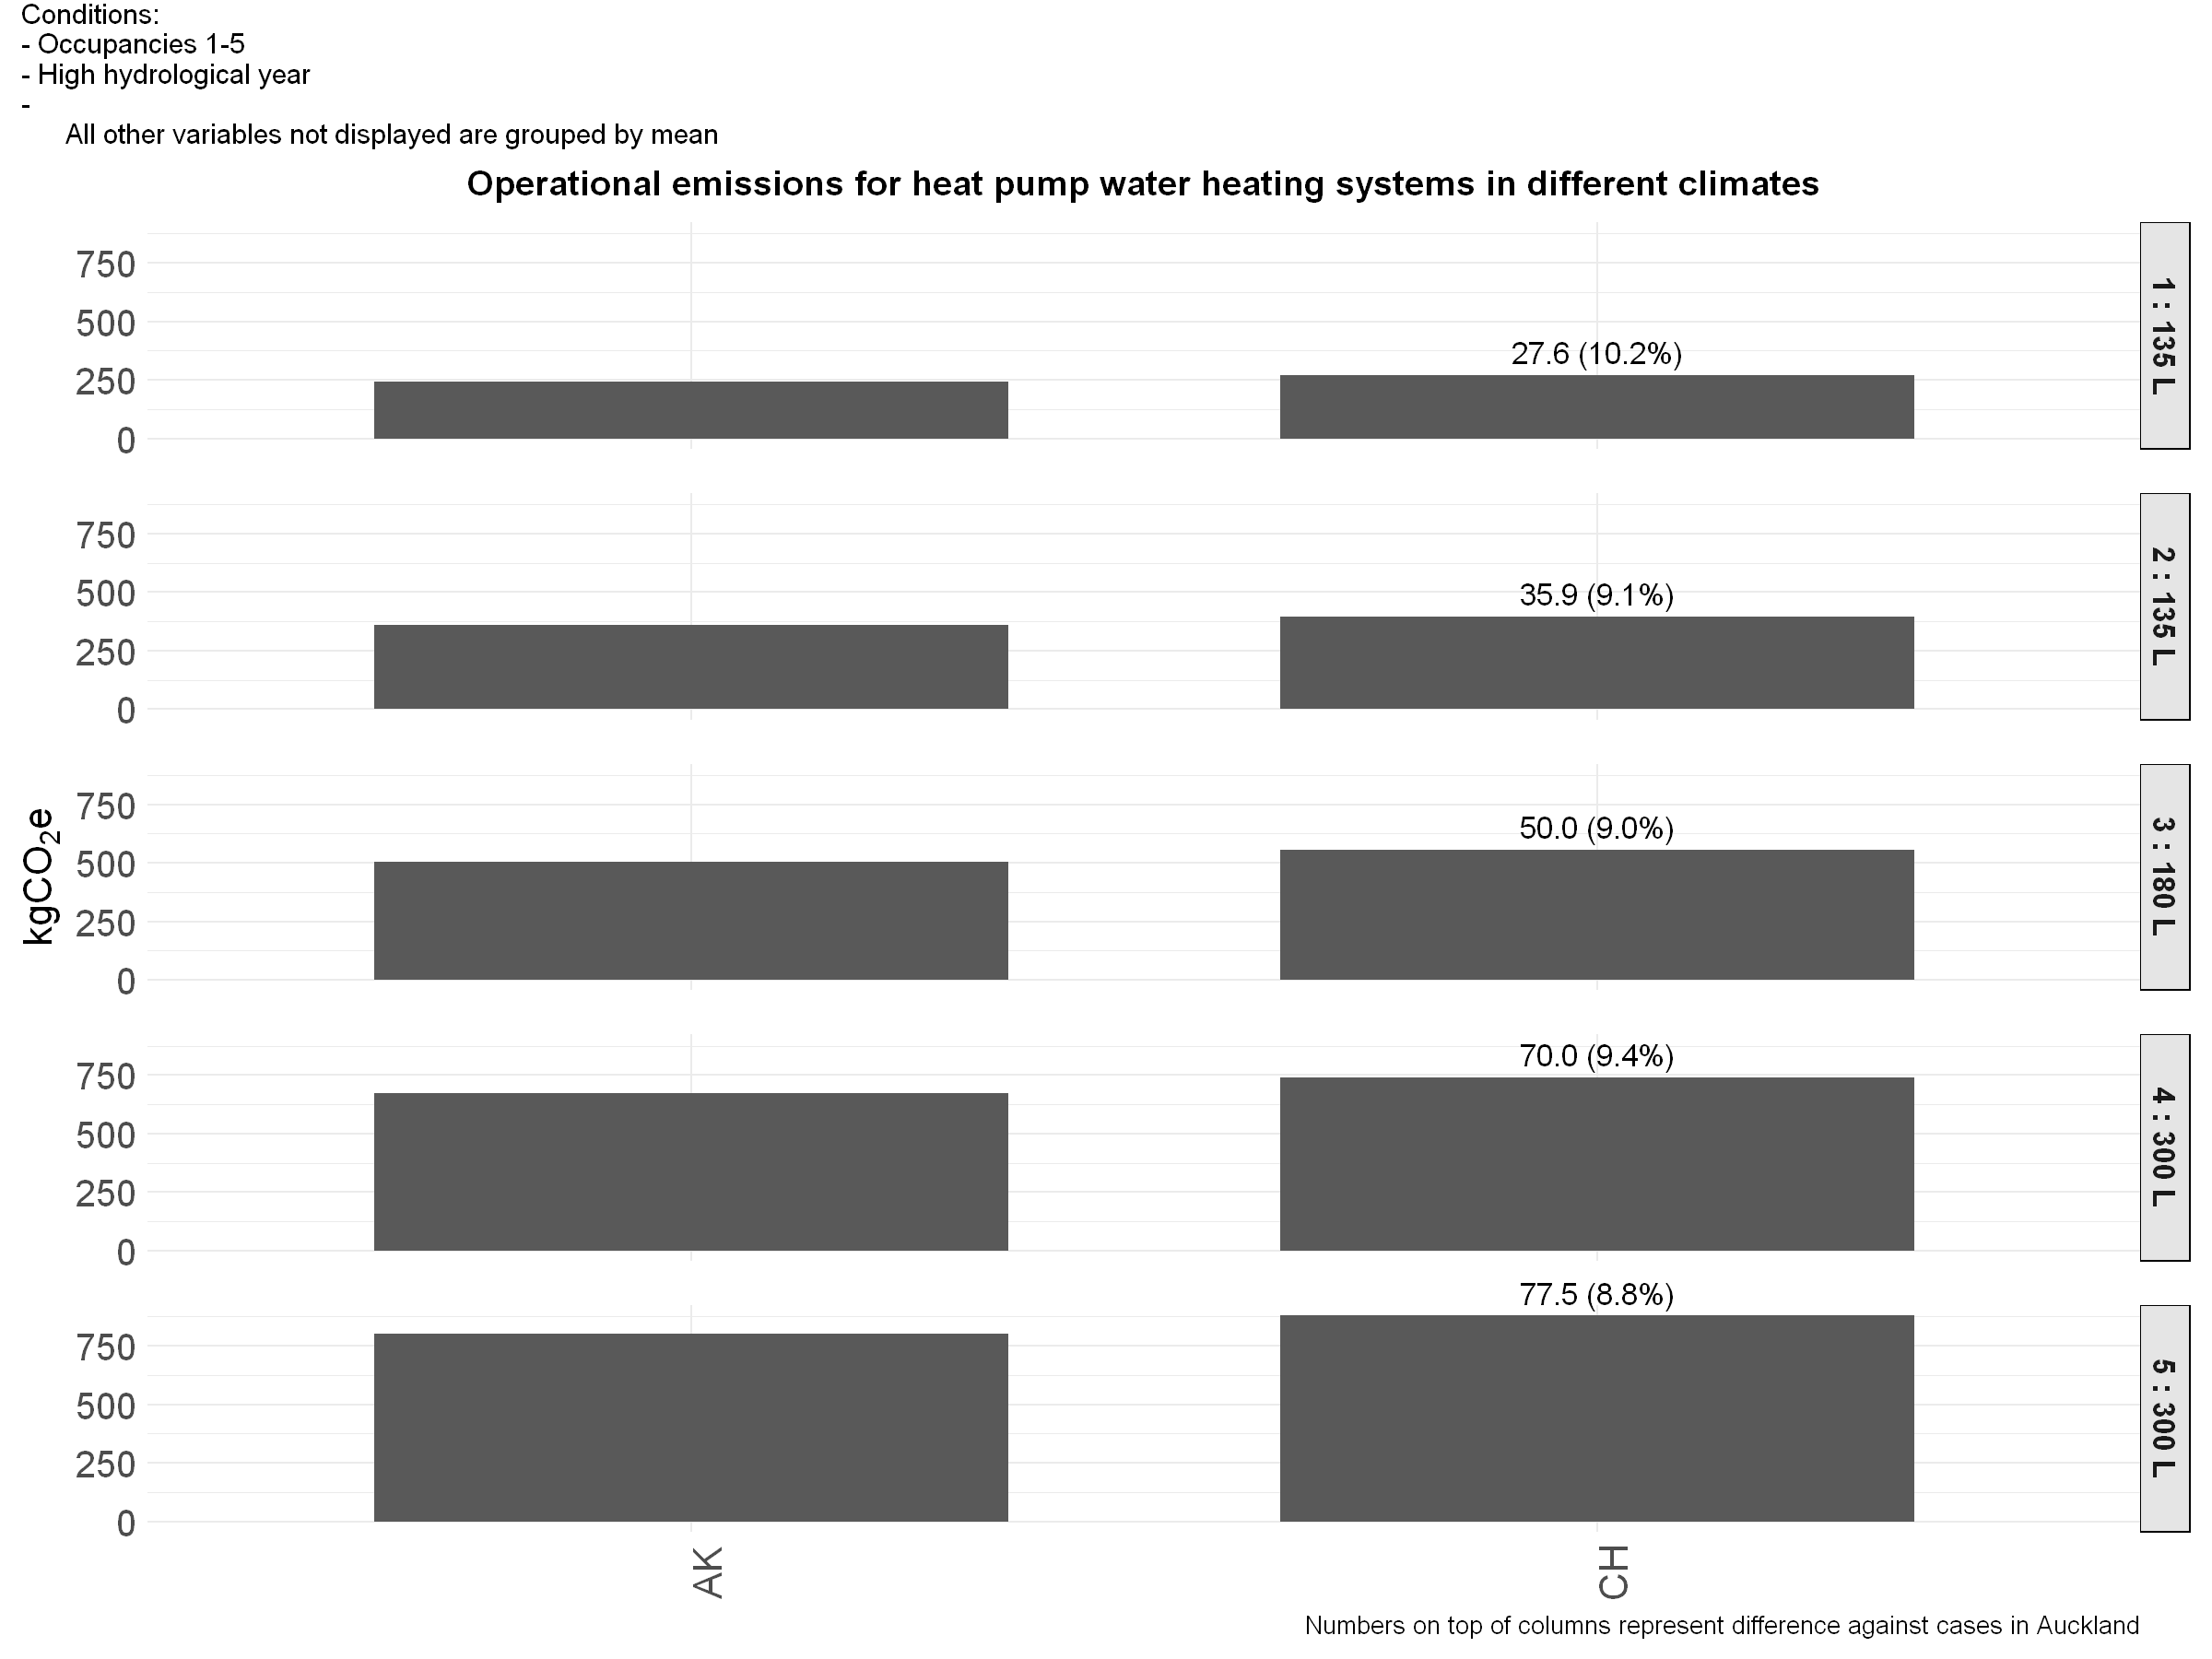

In [113]:
climate_plot <- technology_lifetime_Call_DW_HP_diff %>%
  mutate(Tank_Label = paste0(`Tank_Volume (L)`, " L")) %>%
  filter(CS_code== 'C0') %>%
  ggplot(aes(x= Loc_code, y = kgCO2)) + 
  geom_col(width = 0.7, position = position_dodge(width = 0.8)) +
  geom_text(
    aes(label = ifelse(!is.na(diff) & Loc_code == 'CH', sprintf("%.1f (%.1f%%)", diff_a, diff_p), "")),
    #hjust = -0.6,
    vjust = -0.5, 
    size = 7,
    color = "black"
  ) +
  facet_grid(interaction(Occ_code, Tank_Label, sep= " : ") ~ .) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 24),
    legend.title = element_text(size = 22, face = "bold"),
    legend.text = element_text(size = 20), 
    strip.text = element_text(face = "bold", size = 20),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.caption = element_text(size = 16),
    plot.title = element_text(size = 23, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
  labs(x= NA,
       y = expression(kgCO[2]*e),
       title = "Operational emissions for heat pump water heating systems in different climates",
       fill= "Location",
       caption = "Numbers on top of columns represent difference against cases in Auckland")

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/climate_plot.png",  # File path
  plot = climate_plot,                       # Plot object
  width = 10,                             # Width in inches
  height = 14,                             # Height in inches
  dpi = 300                               # Resolution
)

climate_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancies 1-5\n- High hydrological year\n- 
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
The plot above shows operational emissions for water heating with heat pumps across different locations (i.e., climate zones). The patterns are consistent with those observed in earlier plots: systems that align their operation with renewable generation have lower emissions, while emissions increase with the number of occupants.
Thermal demand is assumed to be identical for both locations. However, operational emissions are higher in Christchurch due to lower air temperatures—particularly during the night and early morning—which reduce the performance of air-source heat pumps. In the worst-case scenario (a single-occupant house in Christchurch with a no-control signal), emissions are up to 10.2% higher than in Auckland. No-control cases show greater variation in emissions across climates. This is likely due to the reduced efficiency of heat pumps operating at lower ambient temperatures. Applying intermittent control signals could mitigate this effect by shifting loads to periods with higher renewable generation, which may also coincide with warmer temperatures and thus improved heat pump performance.

## Impacts of control signal on peak power demand
As shown above, the use of thermal storage can contribute to reducing operational emissions by enabling systems to operate during periods when the electricity emission factor is relatively low. In addition to emissions reductions, thermal storage offers a secondary benefit. It allows for load shifting to off-peak periods, improving the overall utilisation of the power system. By shifting demand away from peak times, thermal storage can help reduce peak loads, potentially lowering the required capacity for power generation, transmission, and distribution infrastructure.
In this section, we provide insights into the potential reduction in peak power demand achieved through systems operating under a peak shaving control strategy. The plot will be based on Christchurch data, for occupancy higher than 2, and for a subset of the technology combinations.

In [26]:
household_lifetime_Call_CS_power <- household_lifetime_Call %>% 
  filter(
    Occ_code > 2, 
    Loc_code == 'CH',
    SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000','HYD500-HYD500')
  ) 

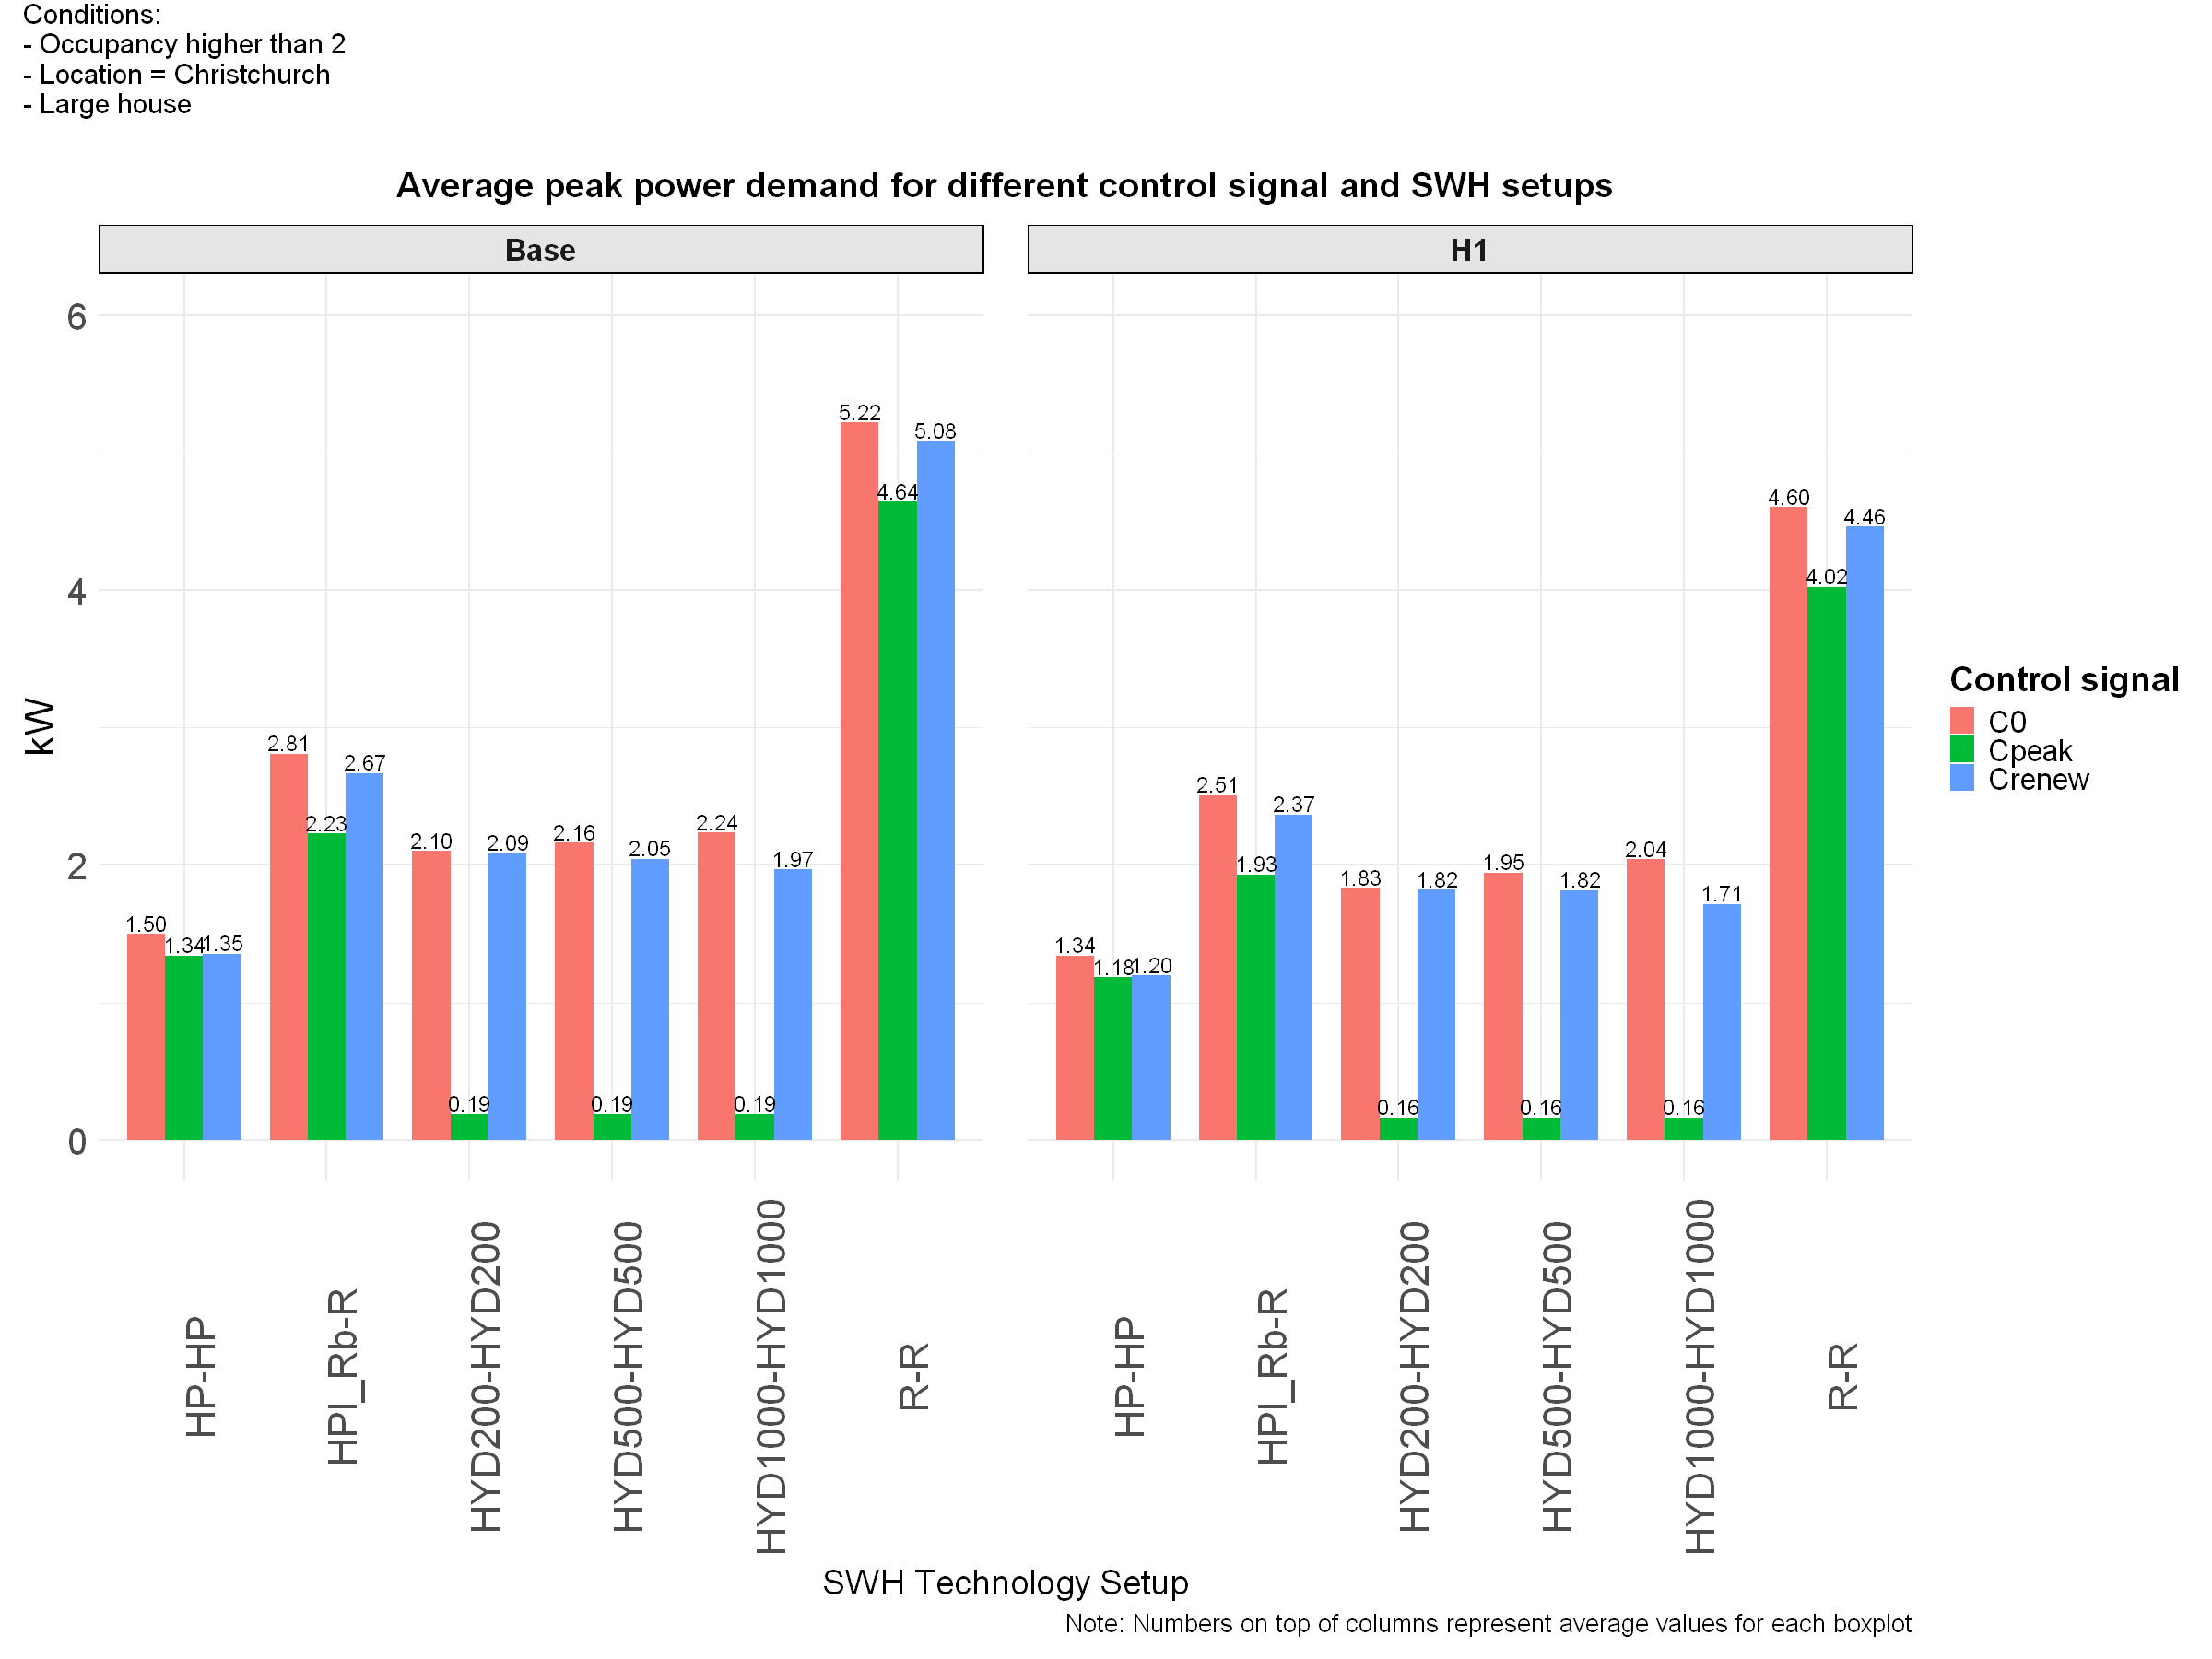

In [100]:
max_y <- max(household_lifetime_Call_CS_power$P_avg_peak_kW_year, na.rm = TRUE)
options(repr.plot.width=20, repr.plot.height=15)
main_plot <- household_lifetime_Call_CS_power %>%
  group_by(house_type,insulation,CS_code,SH_DW_code) %>%
  summarise(P_avg_peak_kW_year = mean(P_avg_peak_kW_year), .groups = "drop") %>%
  filter(house_type == 'Large') %>%
  ggplot(aes(x = SH_DW_code, y = P_avg_peak_kW_year, fill = CS_code)) +
  geom_col(width = 0.8,  position = position_dodge(width = 0.8)) +
  scale_y_continuous(limits = c(0, 1.1 * max_y)) +   
  geom_text(
    aes(label = sprintf("%.2f", P_avg_peak_kW_year), group = CS_code),
    vjust = -0.2, 
    size = 5,
    color = "black",
    position = position_dodge(width = 0.8)  
  ) +
  facet_grid(. ~ insulation) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26),
    axis.title.x = element_text(size = 22),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 24),
    legend.title = element_text(size = 22, face = "bold"),
    legend.text = element_text(size = 20), 
    strip.text = element_text(face = "bold", size = 20),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.margin = margin(t = 30, r = 10, b = 10, l = 10),
    plot.caption = element_text(size = 16),
    plot.title = element_text(size = 23, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
    labs(caption = "Note: Numbers on top of columns represent average values for each boxplot",
        x = "SWH Technology Setup",
        y = "kW",
        fill = 'Control signal', 
        title = "Average peak power demand for different control signal and SWH setups")

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/individual_peak_analysis.png",  # File path
  plot = main_plot,                       # Plot object
  width = 16,                             # Width in inches
  height = 14,                             # Height in inches
  dpi = 300                               # Resolution
)

main_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy higher than 2\n- Location = Christchurch\n- Large house",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

The plot above show the lifetime average power consumption, calculated from the annual mean power demand during peak periods for different SWH configurations, highlighting the effect of control signals. The control signal was applied to the top 30 hours of national electricity demand each year, and the average power demand over that subset was then calculated for each technology–scenario combination.

Hydronic setups demonstrate the greatest potential to reduce SWH-related peak demand compared with other configurations. For example, assuming a typical SWH configuration (HPl-Rb-R) with a heat pump in living areas, resistive heaters in bedrooms, and a resistive hot water cylinder, hydronic systems with intermittent-following control could reduce household peak demand by about 2.35 kW (2.51 → 0.16 kW) to 2.6 kW (2.81 → 0.19 kW). However, the aggregated impact at the national scale cannot be directly inferred, as it depends on household diversity in typology, conditions, and geography.

It is also important to consider trade-offs between control strategies. For instance, peak-shaving controls may lower embodied emissions from power infrastructure, whereas intermittent-following controls may yield greater reductions in operational emissions. Comparing these effects would clarify which strategy delivers the best overall emissions outcome.

## Closing the loop – impact of aggregated peak power reduction on lifecycle emissions 
Capturing the aggregated effect of peak reduction cannot be done by simply summing household-level contributions. This study proposes a method that provides a more realistic estimate of aggregated peak reduction, and the resulting marginal (per-house) reductions in embodied emissions from power infrastructure. The following plot shows lifetime emissions for both control scenarios and different locations. Unlike previous figures, however, the ‘peak shaving’ cases have been adjusted to reflect reductions in embodied emissions from power infrastructure.

In [28]:
household_lifetime_Call_all <- household_lifetime_Call %>% filter(Occ_code == 3) %>%
group_by(Loc_code, house_type, insulation, SH_DW_code, CS_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), 
            Embodied_MJ = mean(Embodied_life_MJ),
            Operation_MJ = mean(P_annual_kWh_life/0.278),
            .groups = 'drop') %>% ungroup() %>%
  mutate(Total_kgCO2e = Embodied + Operation,
        Total_MJ = Embodied_MJ + Operation_MJ)
# Read results of reduction in embedded emissions from peak reduction
peak_power_embedded <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/aggregate_peak_embedded.csv") %>% 
    suppressMessages()
# Reshape data to long format for ggplot2 and join embedded results
plot_all <- household_lifetime_Call_all %>%
    pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions") %>%
    left_join(peak_power_embedded,  by = c("SH_DW_code", "Loc_code", "house_type", "insulation", "CS_code")) %>%
    mutate(Emissions_adj = ifelse(!is.na(Reduction_kgCO2e) & Type == 'Embodied', Emissions - Reduction_kgCO2e, Emissions))

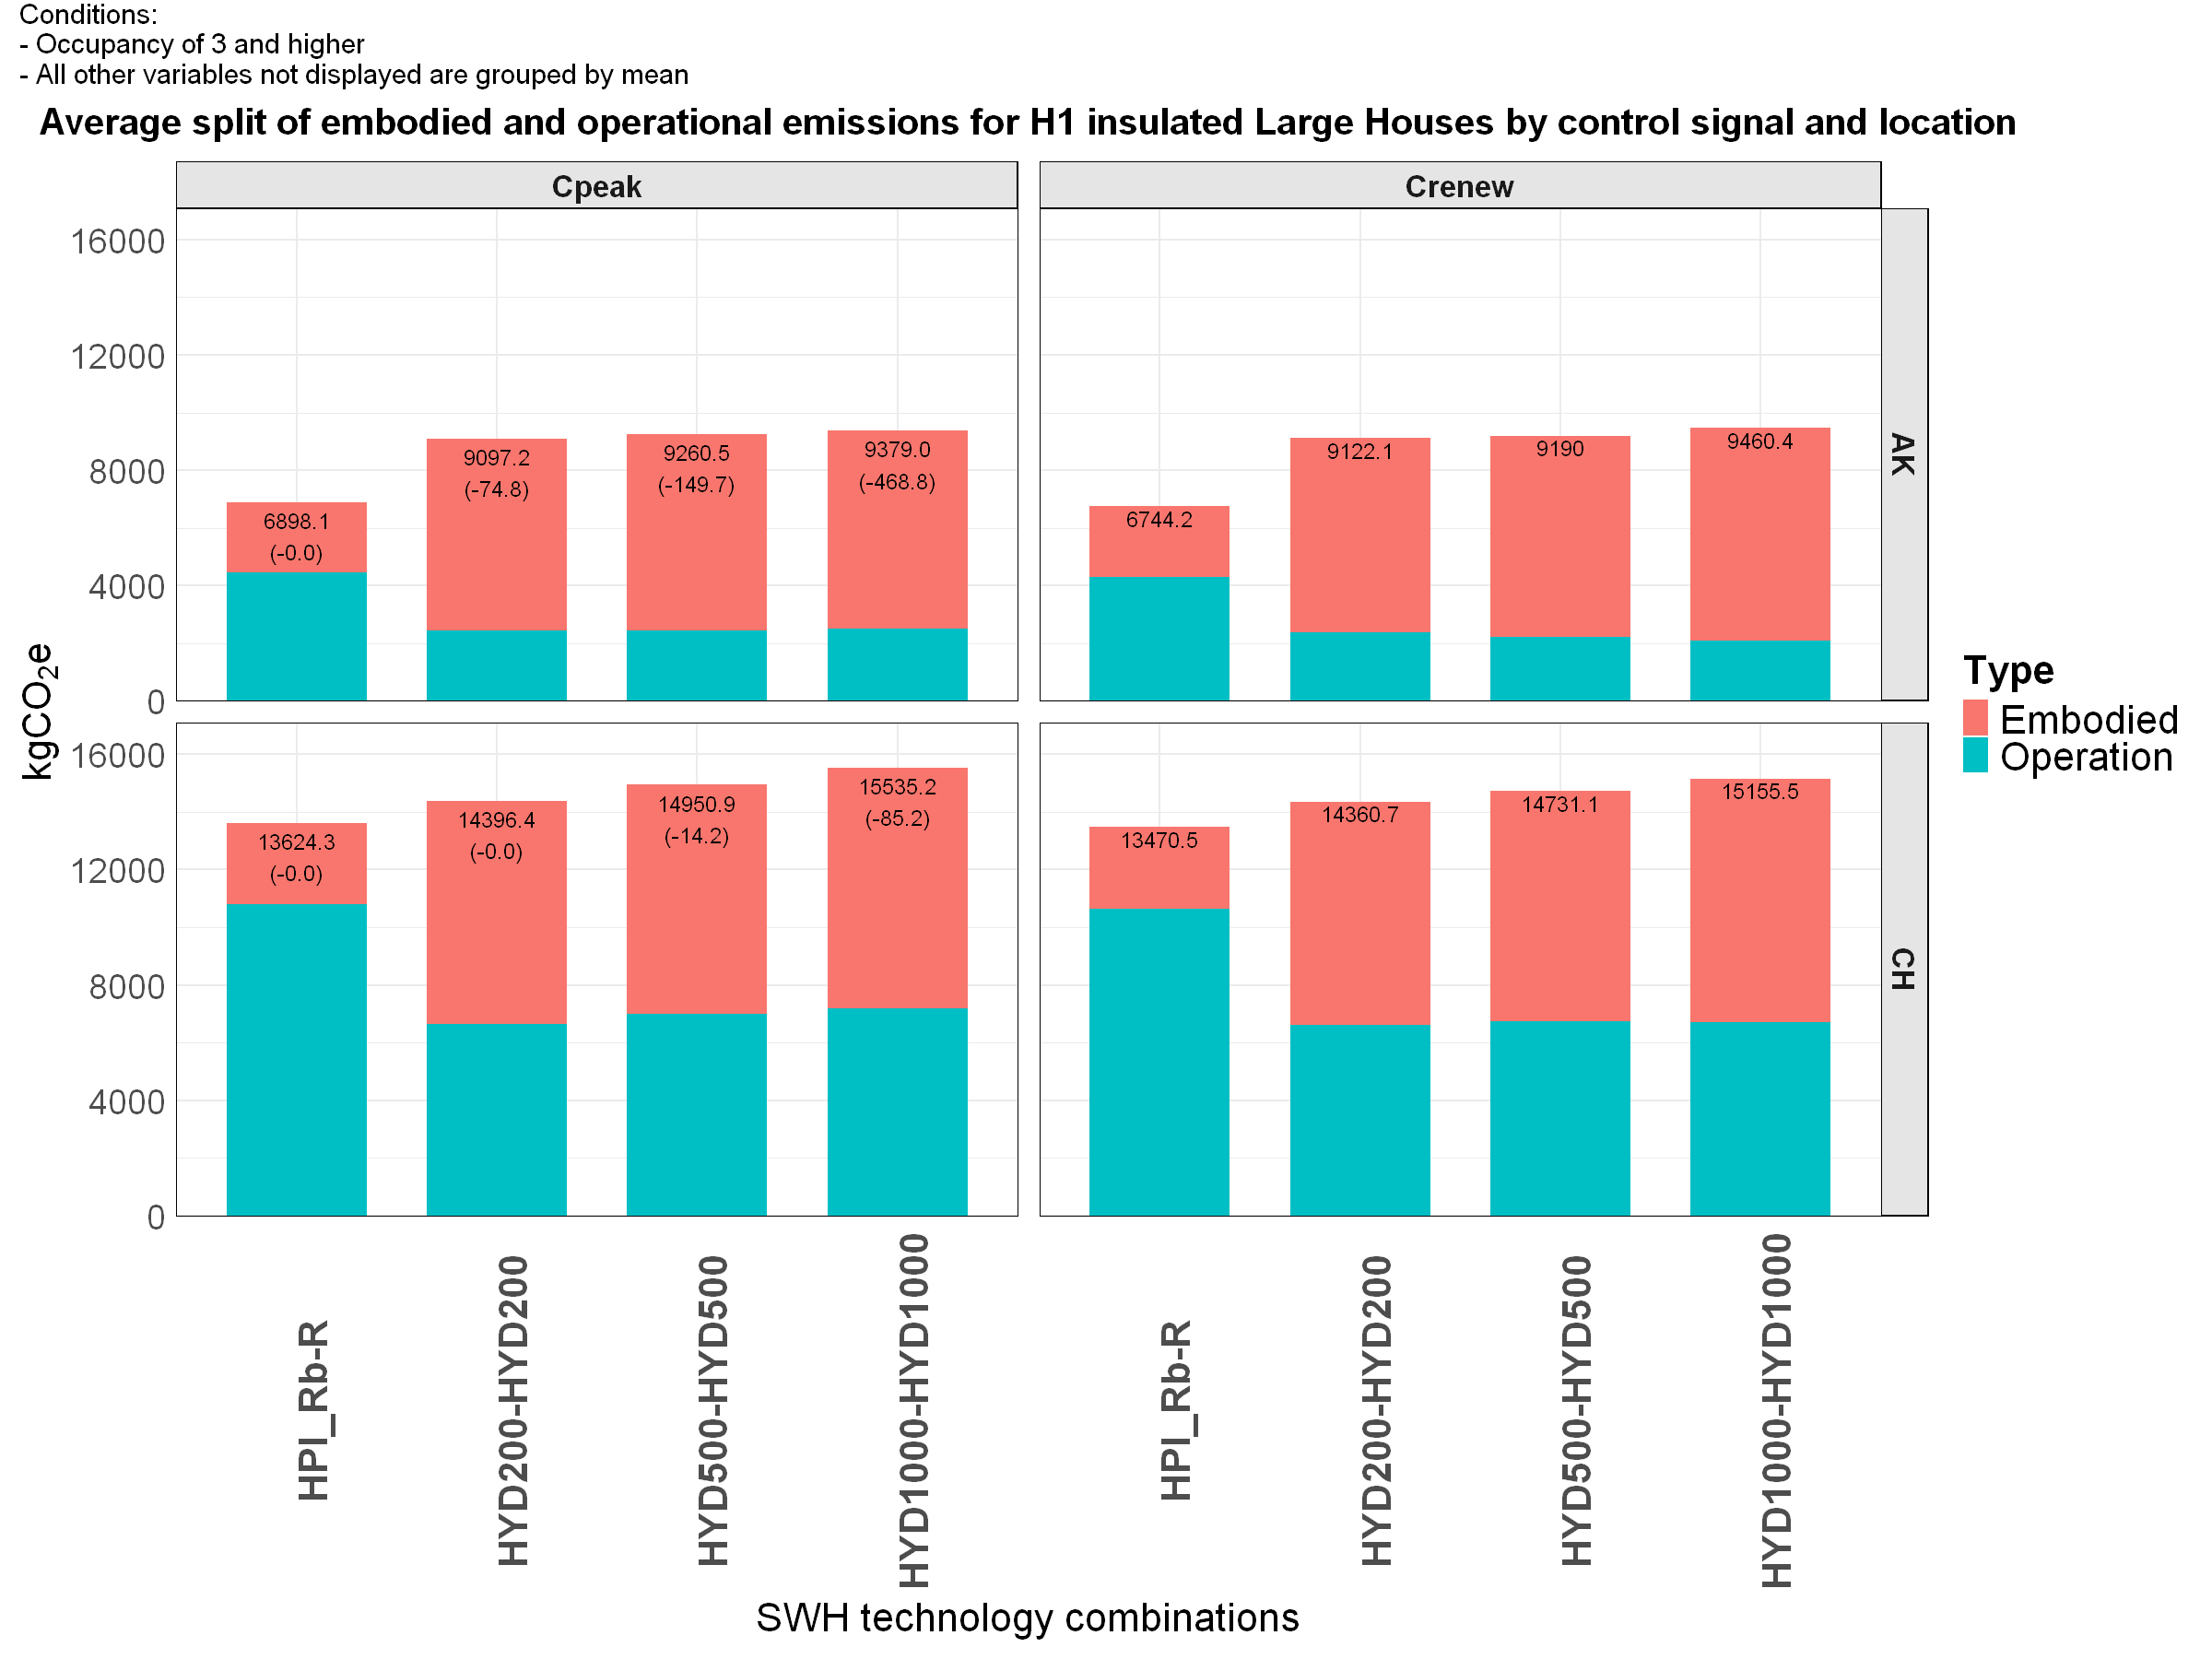

In [101]:
options(repr.plot.width=20, repr.plot.height=15)

# First, calculate the total emissions for each facet group
emissions_totals <- plot_all %>%
  filter(SH_DW_code %in% c('HPl_Rb-R','HYD200-HYD200','HYD500-HYD500','HYD1000-HYD1000')) %>%  
  mutate(SH_DW_code = factor(SH_DW_code, levels = c("HPl_Rb-R","HYD200-HYD200", "HYD500-HYD500", "HYD1000-HYD1000"))) %>%  
  filter(house_type == 'Large') %>%
  filter(insulation == 'H1') %>%  
  filter(CS_code != 'C0') %>%
  group_by(SH_DW_code, Loc_code, CS_code) %>%
  summarize(total_emissions = sum(Emissions_adj),
            diff = sum(Emissions) - sum(Emissions_adj),
            .groups = 'drop')

emissions_plot_all <- plot_all %>%
  filter(SH_DW_code %in% c('HPl_Rb-R','HYD200-HYD200','HYD500-HYD500','HYD1000-HYD1000')) %>%  
  mutate(SH_DW_code = factor(SH_DW_code, levels = c("HPl_Rb-R","HYD200-HYD200", "HYD500-HYD500", "HYD1000-HYD1000"))) %>%  
  filter(house_type == 'Large') %>%
  filter(insulation == 'H1') %>%  
  filter(CS_code != 'C0') %>%
  ggplot(aes(x = SH_DW_code, y = Emissions_adj, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  geom_text(data = emissions_totals, 
            aes(x = SH_DW_code, y = total_emissions,
                label = ifelse(!is.na(diff) & CS_code == 'Cpeak', sprintf("%.1f\n(-%.1f)", total_emissions, diff), round(total_emissions,1))),
            inherit.aes = FALSE,
            vjust = 1.2,
            size = 5,
            color = "black") +
  facet_grid(Loc_code ~ CS_code) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH technology combinations",
       y = expression(kgCO[2]*e),
       title = "Average split of embodied and operational emissions for H1 insulated Large Houses by control signal and location") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26, face = 'bold'),
    axis.title.x = element_text(size = 26),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 26, face = "bold"),
    legend.text = element_text(size = 26), 
    strip.text = element_text(face = "bold", size = 20),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 24, face = "bold", hjust = 0.5, vjust = 2)
  ) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1))) # Add space for labels

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/emissions_plot_all.png",  # File path
  plot = emissions_plot_all,                       # Plot object
  width = 16,                             # Width in inches
  height = 14,                             # Height in inches
  dpi = 300                               # Resolution
)

emissions_plot_all + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
The plot confirms the previously observed trend of higher emissions for systems with larger thermal storage. However, when lifecycle emissions are adjusted to include savings from reduced embodied infrastructure emissions, the difference between 'Cpeak' cases becomes almost negligible.
Peak reduction generally leads to lower embodied emissions across most Cpeak cases, with the exception of hydronic setups with 200 L storage in Christchurch, where the storage size is insufficient to defer space and water heating demand.
Overall, as heating demand increases (e.g., in colder climates), the potential reductions are more limited because storage cannot fully buffer demand, particularly for space heating. Conversely, larger storage volumes enable greater reductions in embodied emissions, since the additional capacity provides more flexibility for demand response and lowers peak power requirements.
In Auckland, the findings suggest that peak shaving provides greater emissions reductions than an intermittent-following control signal for the 200 L and 1000 L storage cases.

## Breakdown of embedded emissions
The following plot shows a breakdown of embodied emissions which includes emissions associated to product manufacture, installation, distribution, end-of-life disposal and 'other' (Maintenance/Repair/Replacement/Refurbishment).

In [235]:
# Pivot longer to group lifecycle stages
radar_long_CO2 <- household_lifetime_Call %>%
  filter(Occ_code == 3,
         SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000')) %>%
  select(house_type, insulation, SH_DW_code, Loc_code, 
         Manufacture, Distribution, Installation, EOL, Other) %>%
  distinct() %>%
  rename(
    FixedUse = Other,
    Transport = Distribution,
    Eol= EOL  
  ) %>%
  pivot_longer(
    cols = c(Manufacture, Eol, FixedUse, Transport, Installation),
    names_to = "Lifecycle_Stage",
    values_to = "Value"
  ) %>% # Order stages clockwise
  mutate(Lifecycle_Stage = factor(Lifecycle_Stage,
                                 levels = c("Manufacture", "Eol", "Transport", "Installation",  "FixedUse")))

common_max <- max(radar_long_CO2$Value) * 1.1  # 10% padding
mid_value <- common_max / 2
n_vars <- nlevels(radar_long_CO2$Lifecycle_Stage)
angles <- seq(0, 2*pi, length.out = n_vars + 1)[-(n_vars + 1)]  # Remove duplicate 360°

df_polygons_CO2 <- radar_long_CO2 %>%
  group_by(house_type, insulation, SH_DW_code, Loc_code) %>%
  arrange(Lifecycle_Stage) %>%
  mutate(
    angle = angles[as.numeric(Lifecycle_Stage)],
    x = Value * sin(angle),
    y = Value * cos(angle)
  ) %>%
  # Add first point again to close polygons
  group_modify(~ add_row(.x, .x[1,])) %>%
  ungroup()

scale_circles_CO2 <- tibble(
  value = c(mid_value, common_max),
  label = c(round(mid_value, 1), round(common_max, 1))
) %>%
  expand_grid(
    angle = seq(0, 2*pi, length.out = 100)
  ) %>%
  mutate(
    x = value * sin(angle),
    y = value * cos(angle)
  )

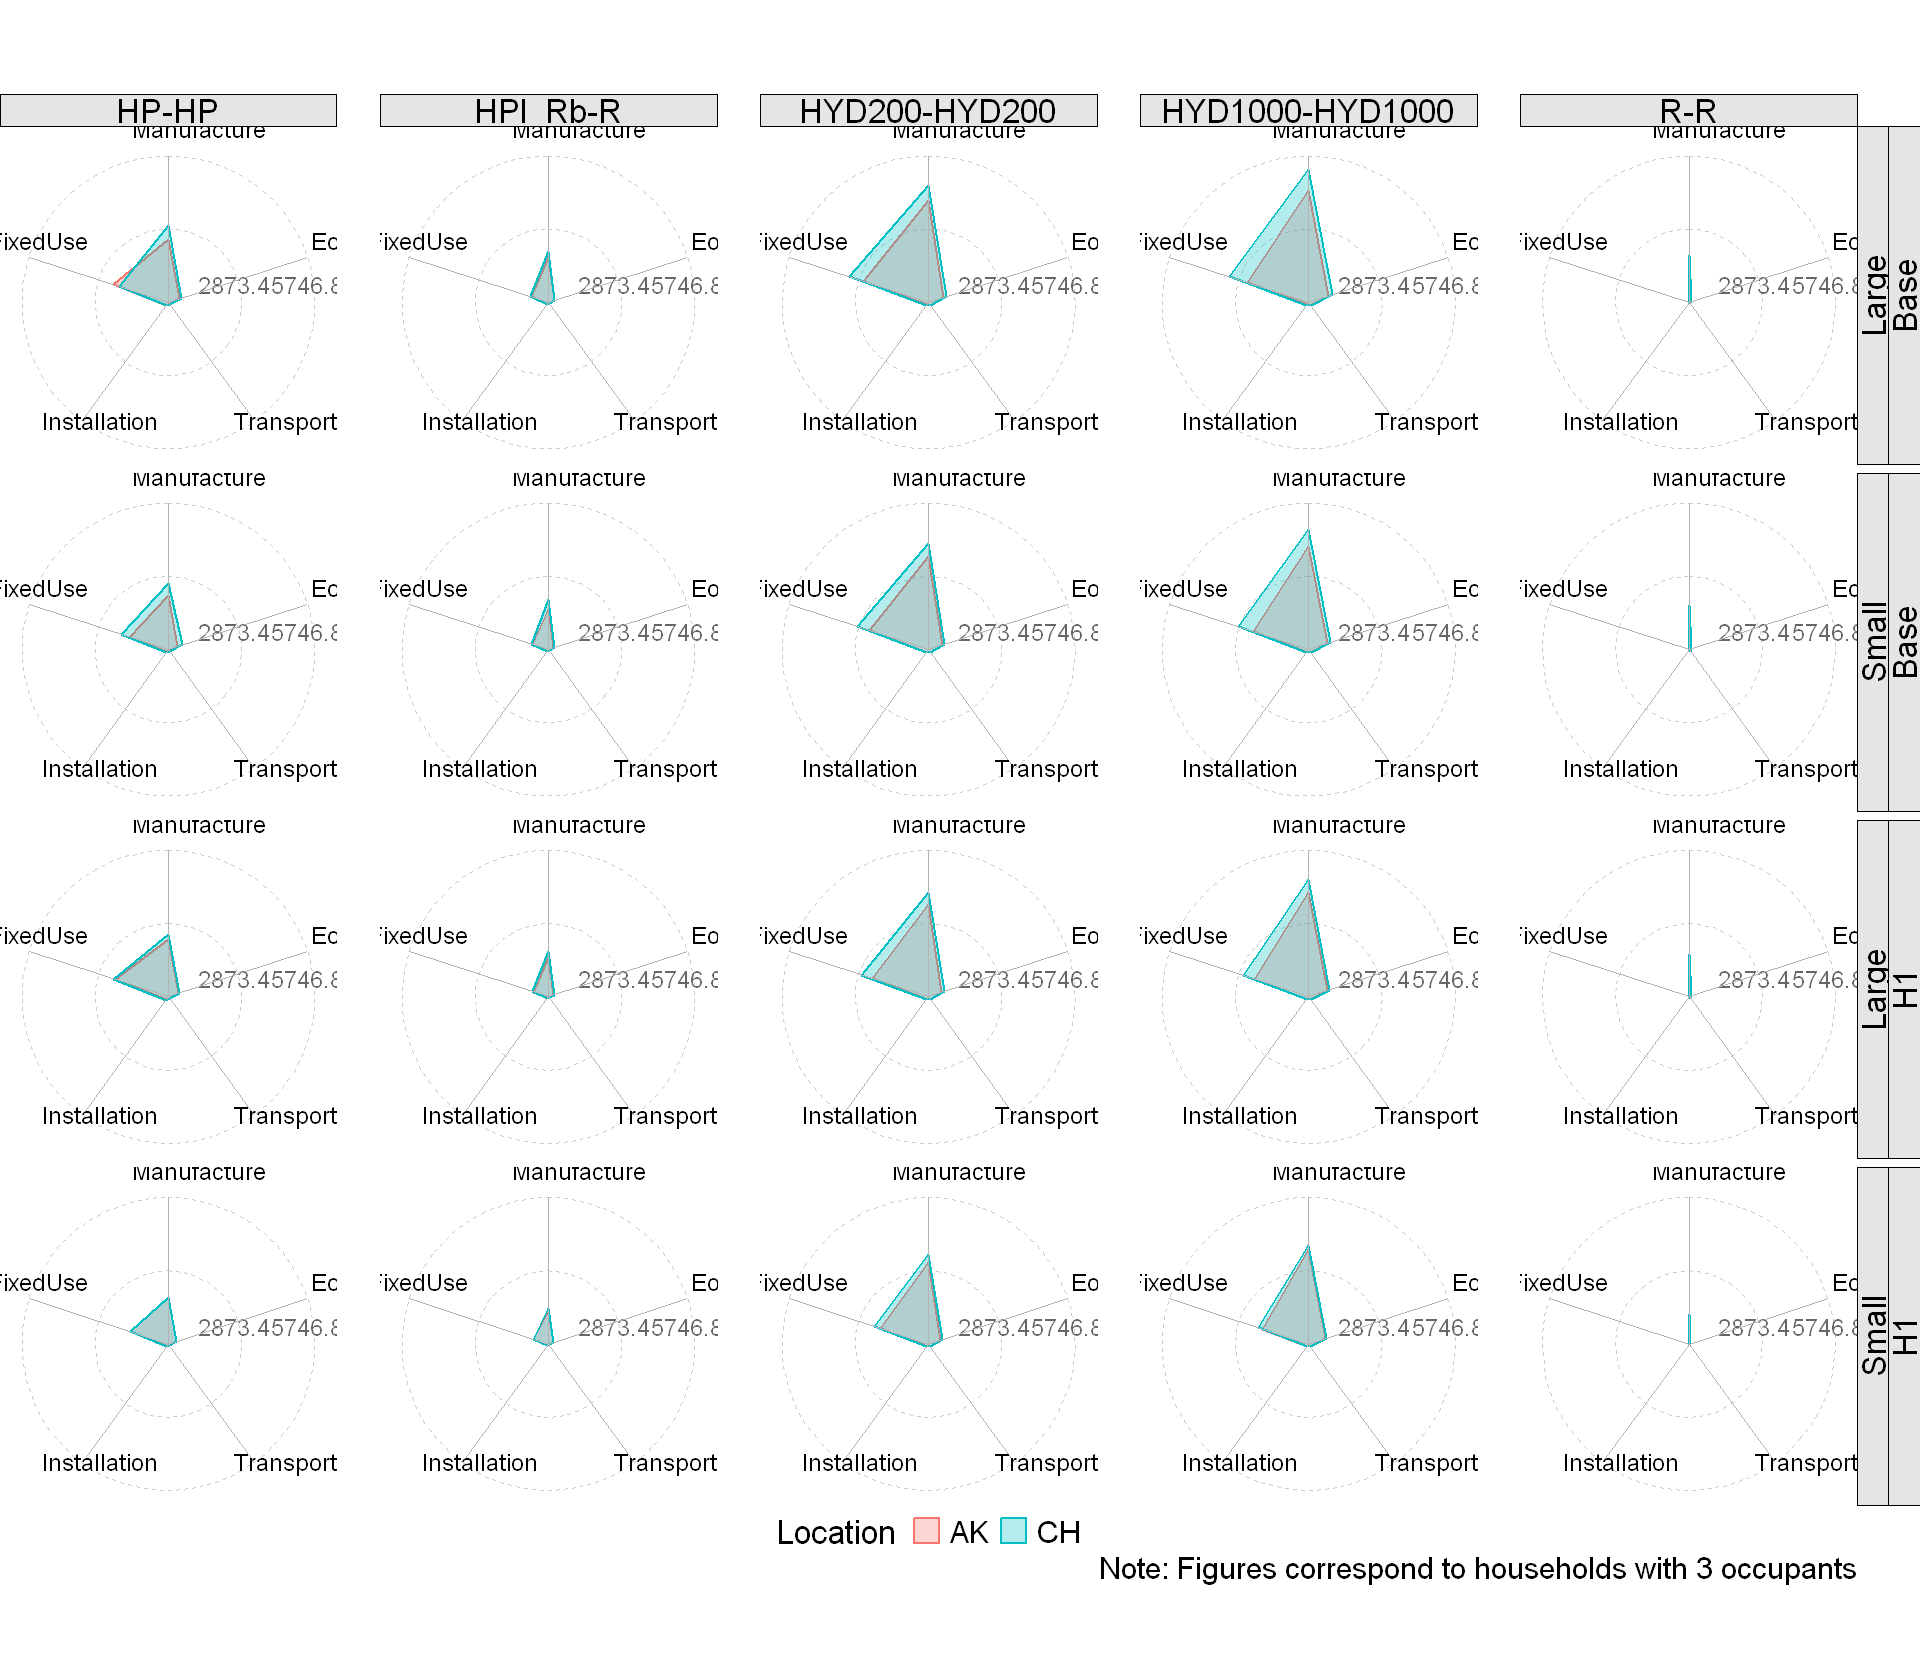

In [236]:
embodied_emissions_radar <- ggplot() +
  # Background scale circles
  geom_path(
    data = scale_circles_CO2,
    aes(x = x, y = y, group = value),
    color = "gray80",
    linetype = "dashed",
    size = 0.3
  ) +
  # Scale value labels
  geom_text(
    data = scale_circles_CO2 %>% 
      filter(angle == 0) %>%
      distinct(value, label),
    aes(x = value, y = 0, label = label),
    hjust = 0.6,
    vjust = -0.5,
    size = 5,
    color = "gray40"
  ) +
  # Filled polygons 
  geom_polygon(
    data = df_polygons_CO2,
    aes(x = x, y = y, 
        group = interaction(Loc_code, house_type, insulation, SH_DW_code),
        fill = Loc_code,
        color = Loc_code),
    alpha = 0.3,  # Transparency
    size = 0.8
  ) +
  # Axis spokes
  geom_segment(
    data = data.frame(
      x = 0, y = 0,
      xend = common_max * sin(angles),
      yend = common_max * cos(angles)
    ),
    aes(x = x, y = y, xend = xend, yend = yend),
    color = "gray70",
    size = 0.3
  ) +
  # Axis labels
  geom_text(
    data = data.frame(
      x = 1.1 * common_max * sin(angles),
      y = 1.1 * common_max * cos(angles),
      label = levels(radar_long_CO2$Lifecycle_Stage)
    ),
    aes(x = x, y = y, label = label),
    hjust = 0.27,
    vjust = -0.2,
    face = "bold",  
    size = 5
  ) +
  facet_grid(
    rows = vars(insulation, house_type),
    cols = vars(SH_DW_code)
  ) +
  coord_fixed() +
  theme_void() +
  labs(
    title = NULL,
    fill = "Location",
    color = "Location",
    caption = "Note: Figures correspond to households with 3 occupants"  
  ) +
  theme(
    legend.position = "bottom",
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 18),  
    strip.text.x = element_text(size = 20),
    strip.text.y = element_text(size = 20, angle = 90),
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5, vjust = 2),
    plot.caption = element_text(size = 18),
    panel.spacing.x = unit(1.8, "lines"),
    strip.background = element_rect(fill = "gray90", color = "black")  
      # Increased spacing between facets
    #plot.margin = margin(30, 30, 30, 30)  # Add more space around the plot
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/embodied_emissions_radar.png",  # File path
  plot = embodied_emissions_radar,                       # Plot object
  width = 40,                             # Width in inches
  height = 20,                             # Height in inches
  dpi = 600                               # Resolution
)

embodied_emissions_radar

In [239]:
# Pivot longer to group lifecycle stages
radar_long_MJ <- household_lifetime_Call %>%
  filter(Occ_code == 3,
         SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000')) %>%
  select(house_type, insulation, SH_DW_code, Loc_code, 
         Manufacture_MJ, Distribution_MJ, Installation_MJ, EOL_MJ, Other_MJ) %>%
  distinct() %>%
  rename(
    Manufacture = Manufacture_MJ,
    Transport = Distribution_MJ,
    Installation = Installation_MJ,  
    Eol = EOL_MJ,
    FixedUse = Other_MJ 
  ) %>%
  pivot_longer(
    cols = c(Manufacture, Eol, FixedUse, Transport, Installation),
    names_to = "Lifecycle_Stage",
    values_to = "Value"
  ) %>% # Order stages clockwise
  mutate(Lifecycle_Stage = factor(Lifecycle_Stage,
                                 levels = c("Manufacture", "Eol", "Transport", "Installation",  "FixedUse")))

common_max <- max(radar_long_MJ$Value) * 1.1  # 10% padding
mid_value <- common_max / 2
n_vars <- nlevels(radar_long_MJ$Lifecycle_Stage)
angles <- seq(0, 2*pi, length.out = n_vars + 1)[-(n_vars + 1)]  # Remove duplicate 360°

df_polygons_MJ <- radar_long_MJ %>%
  group_by(house_type, insulation, SH_DW_code, Loc_code) %>%
  arrange(Lifecycle_Stage) %>%
  mutate(
    angle = angles[as.numeric(Lifecycle_Stage)],
    x = Value * sin(angle),
    y = Value * cos(angle)
  ) %>%
  # Add first point again to close polygons
  group_modify(~ add_row(.x, .x[1,])) %>%
  ungroup()

scale_circles_MJ <- tibble(
  value = c(mid_value, common_max),
  label = c(round(mid_value, 1), round(common_max, 1))
) %>%
  expand_grid(
    angle = seq(0, 2*pi, length.out = 100)
  ) %>%
  mutate(
    x = value * sin(angle),
    y = value * cos(angle)
  )

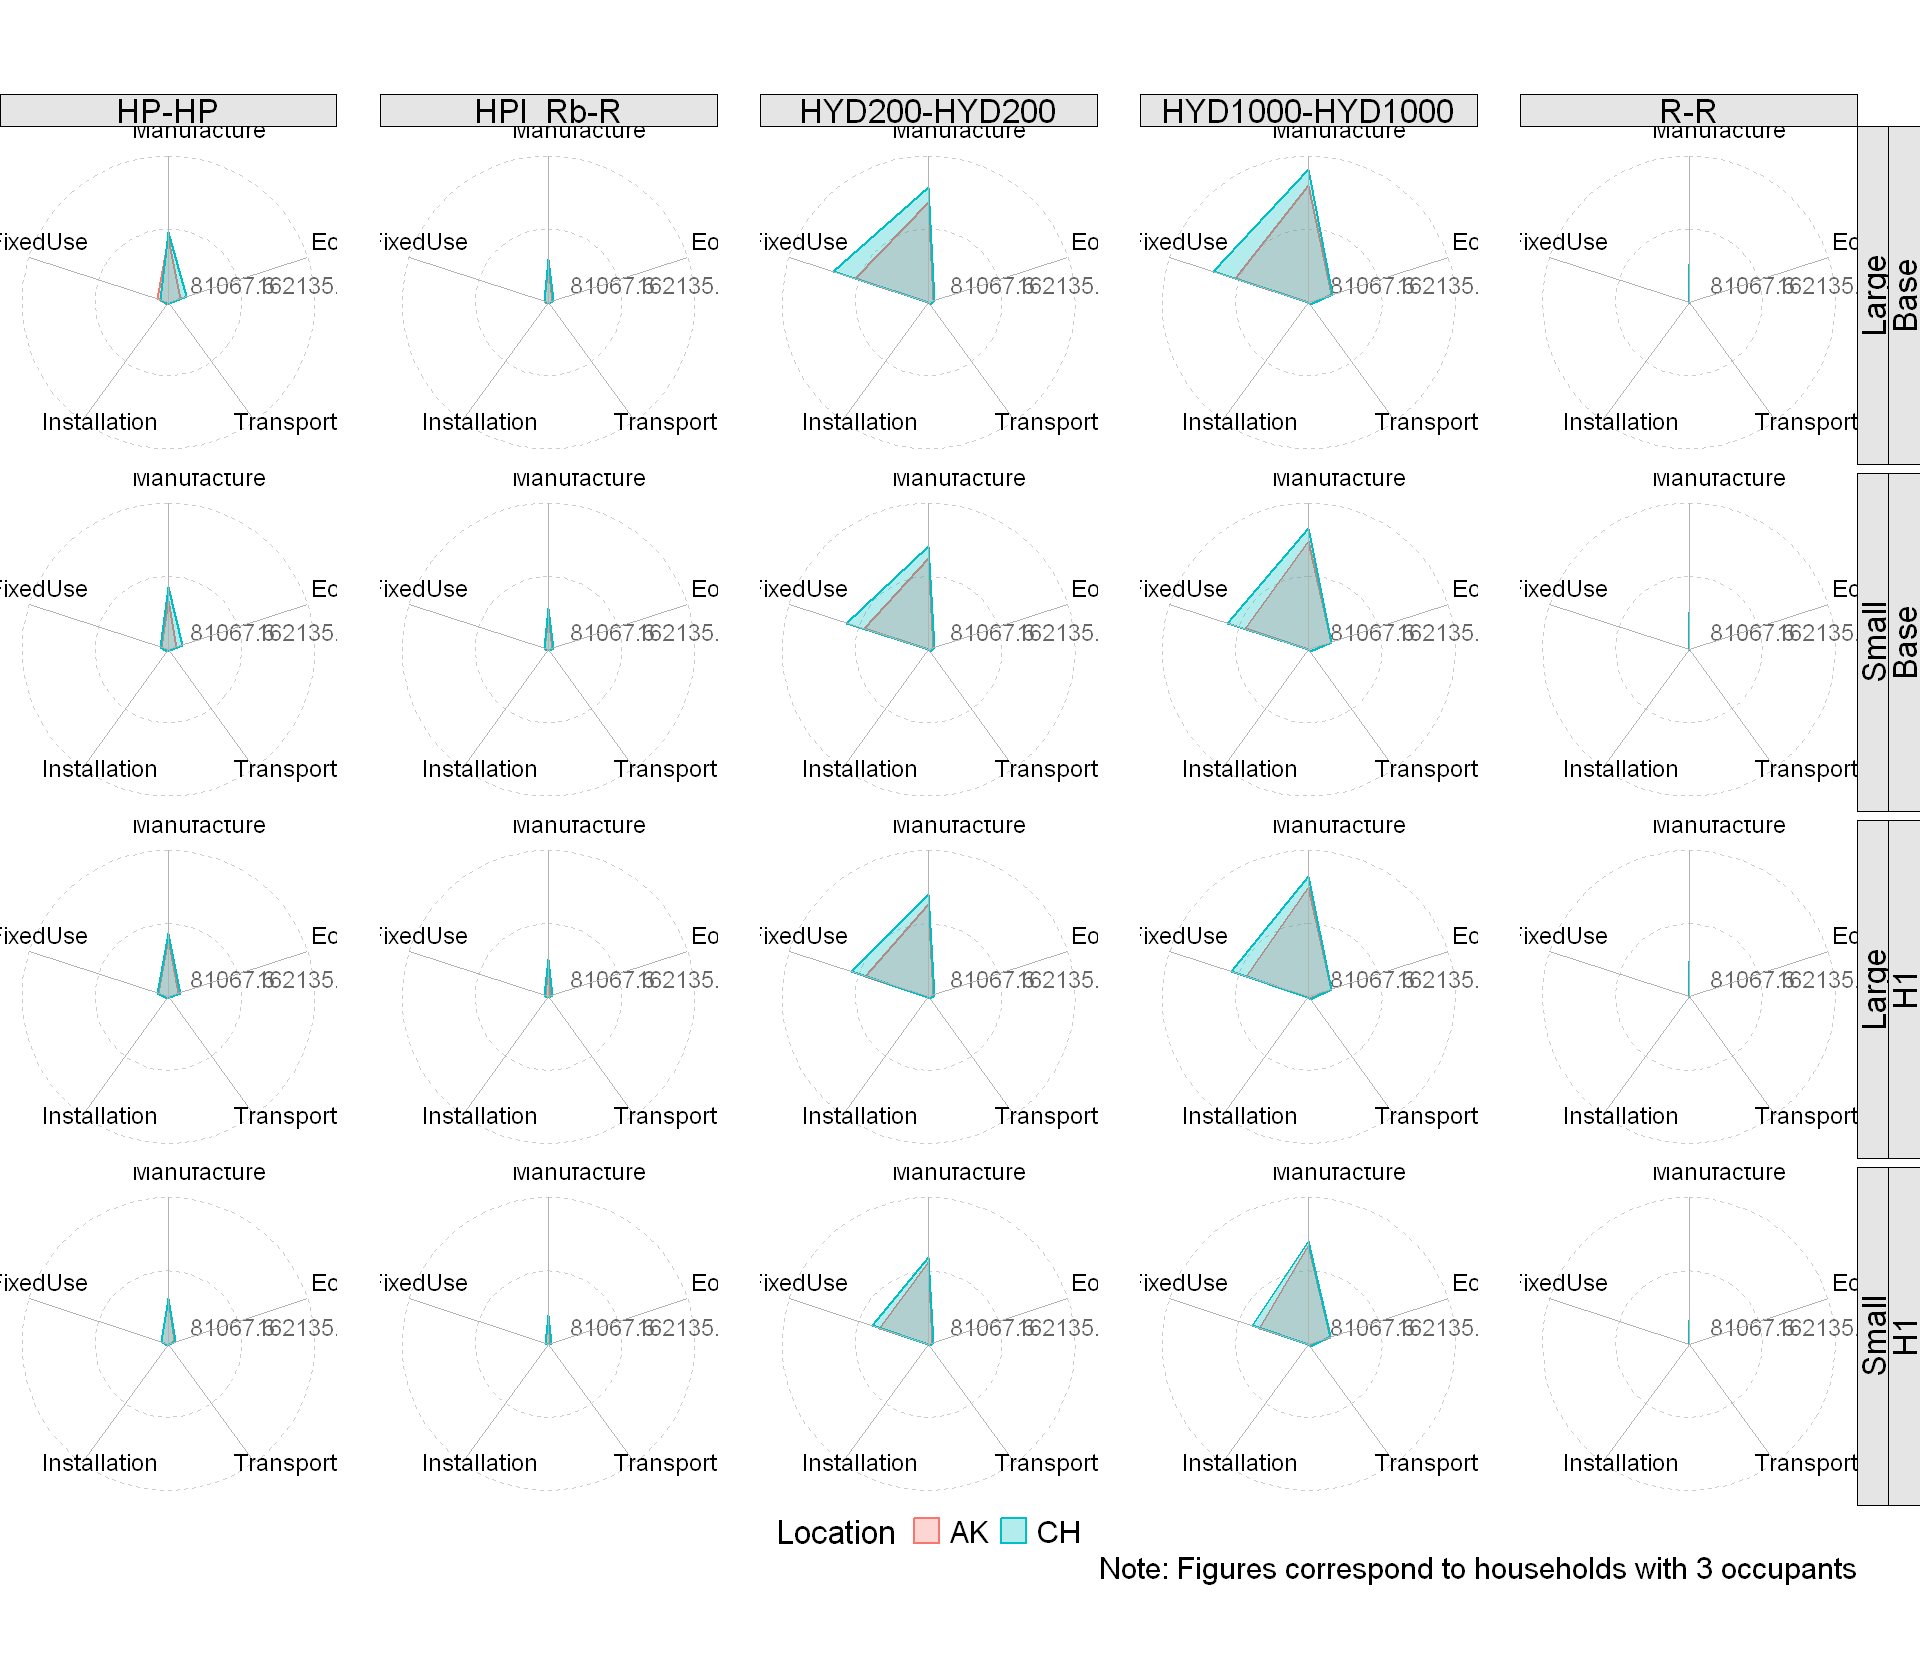

In [240]:
embodied_energy_radar <- ggplot() +
  # Background scale circles
  geom_path(
    data = scale_circles_MJ,
    aes(x = x, y = y, group = value),
    color = "gray80",
    linetype = "dashed",
    size = 0.3
  ) +
  # Scale value labels
  geom_text(
    data = scale_circles_MJ %>% 
      filter(angle == 0) %>%
      distinct(value, label),
    aes(x = value, y = 0, label = label),
    hjust = 0.6,
    vjust = -0.5,
    size = 5,
    color = "gray40"
  ) +
  # Filled polygons 
  geom_polygon(
    data = df_polygons_MJ,
    aes(x = x, y = y, 
        group = interaction(Loc_code, house_type, insulation, SH_DW_code),
        fill = Loc_code,
        color = Loc_code),
    alpha = 0.3,  # Transparency
    size = 0.8
  ) +
  # Axis spokes
  geom_segment(
    data = data.frame(
      x = 0, y = 0,
      xend = common_max * sin(angles),
      yend = common_max * cos(angles)
    ),
    aes(x = x, y = y, xend = xend, yend = yend),
    color = "gray70",
    size = 0.3
  ) +
  # Axis labels
  geom_text(
    data = data.frame(
      x = 1.1 * common_max * sin(angles),
      y = 1.1 * common_max * cos(angles),
      label = levels(radar_long_MJ$Lifecycle_Stage)
    ),
    aes(x = x, y = y, label = label),
    hjust = 0.27,
    vjust = -0.2,
    face = "bold",  
    size = 5
  ) +
  facet_grid(
    rows = vars(insulation, house_type),
    cols = vars(SH_DW_code)
  ) +
  coord_fixed() +
  theme_void() +
  labs(
    title = NULL,
    fill = "Location",
    color = "Location",
    caption = "Note: Figures correspond to households with 3 occupants"  
  ) +
  theme(
    legend.position = "bottom",
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 18),  
    strip.text.x = element_text(size = 20),
    strip.text.y = element_text(size = 20, angle = 90),
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5, vjust = 2),
    plot.caption = element_text(size = 18),
    panel.spacing.x = unit(1.8, "lines"),
    strip.background = element_rect(fill = "gray90", color = "black")  
      # Increased spacing between facets
    #plot.margin = margin(30, 30, 30, 30)  # Add more space around the plot
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/embodied_energy_radar.png",  # File path
  plot = embodied_energy_radar,                       # Plot object
  width = 40,                             # Width in inches
  height = 20,                             # Height in inches
  dpi = 600                               # Resolution
)

embodied_energy_radar

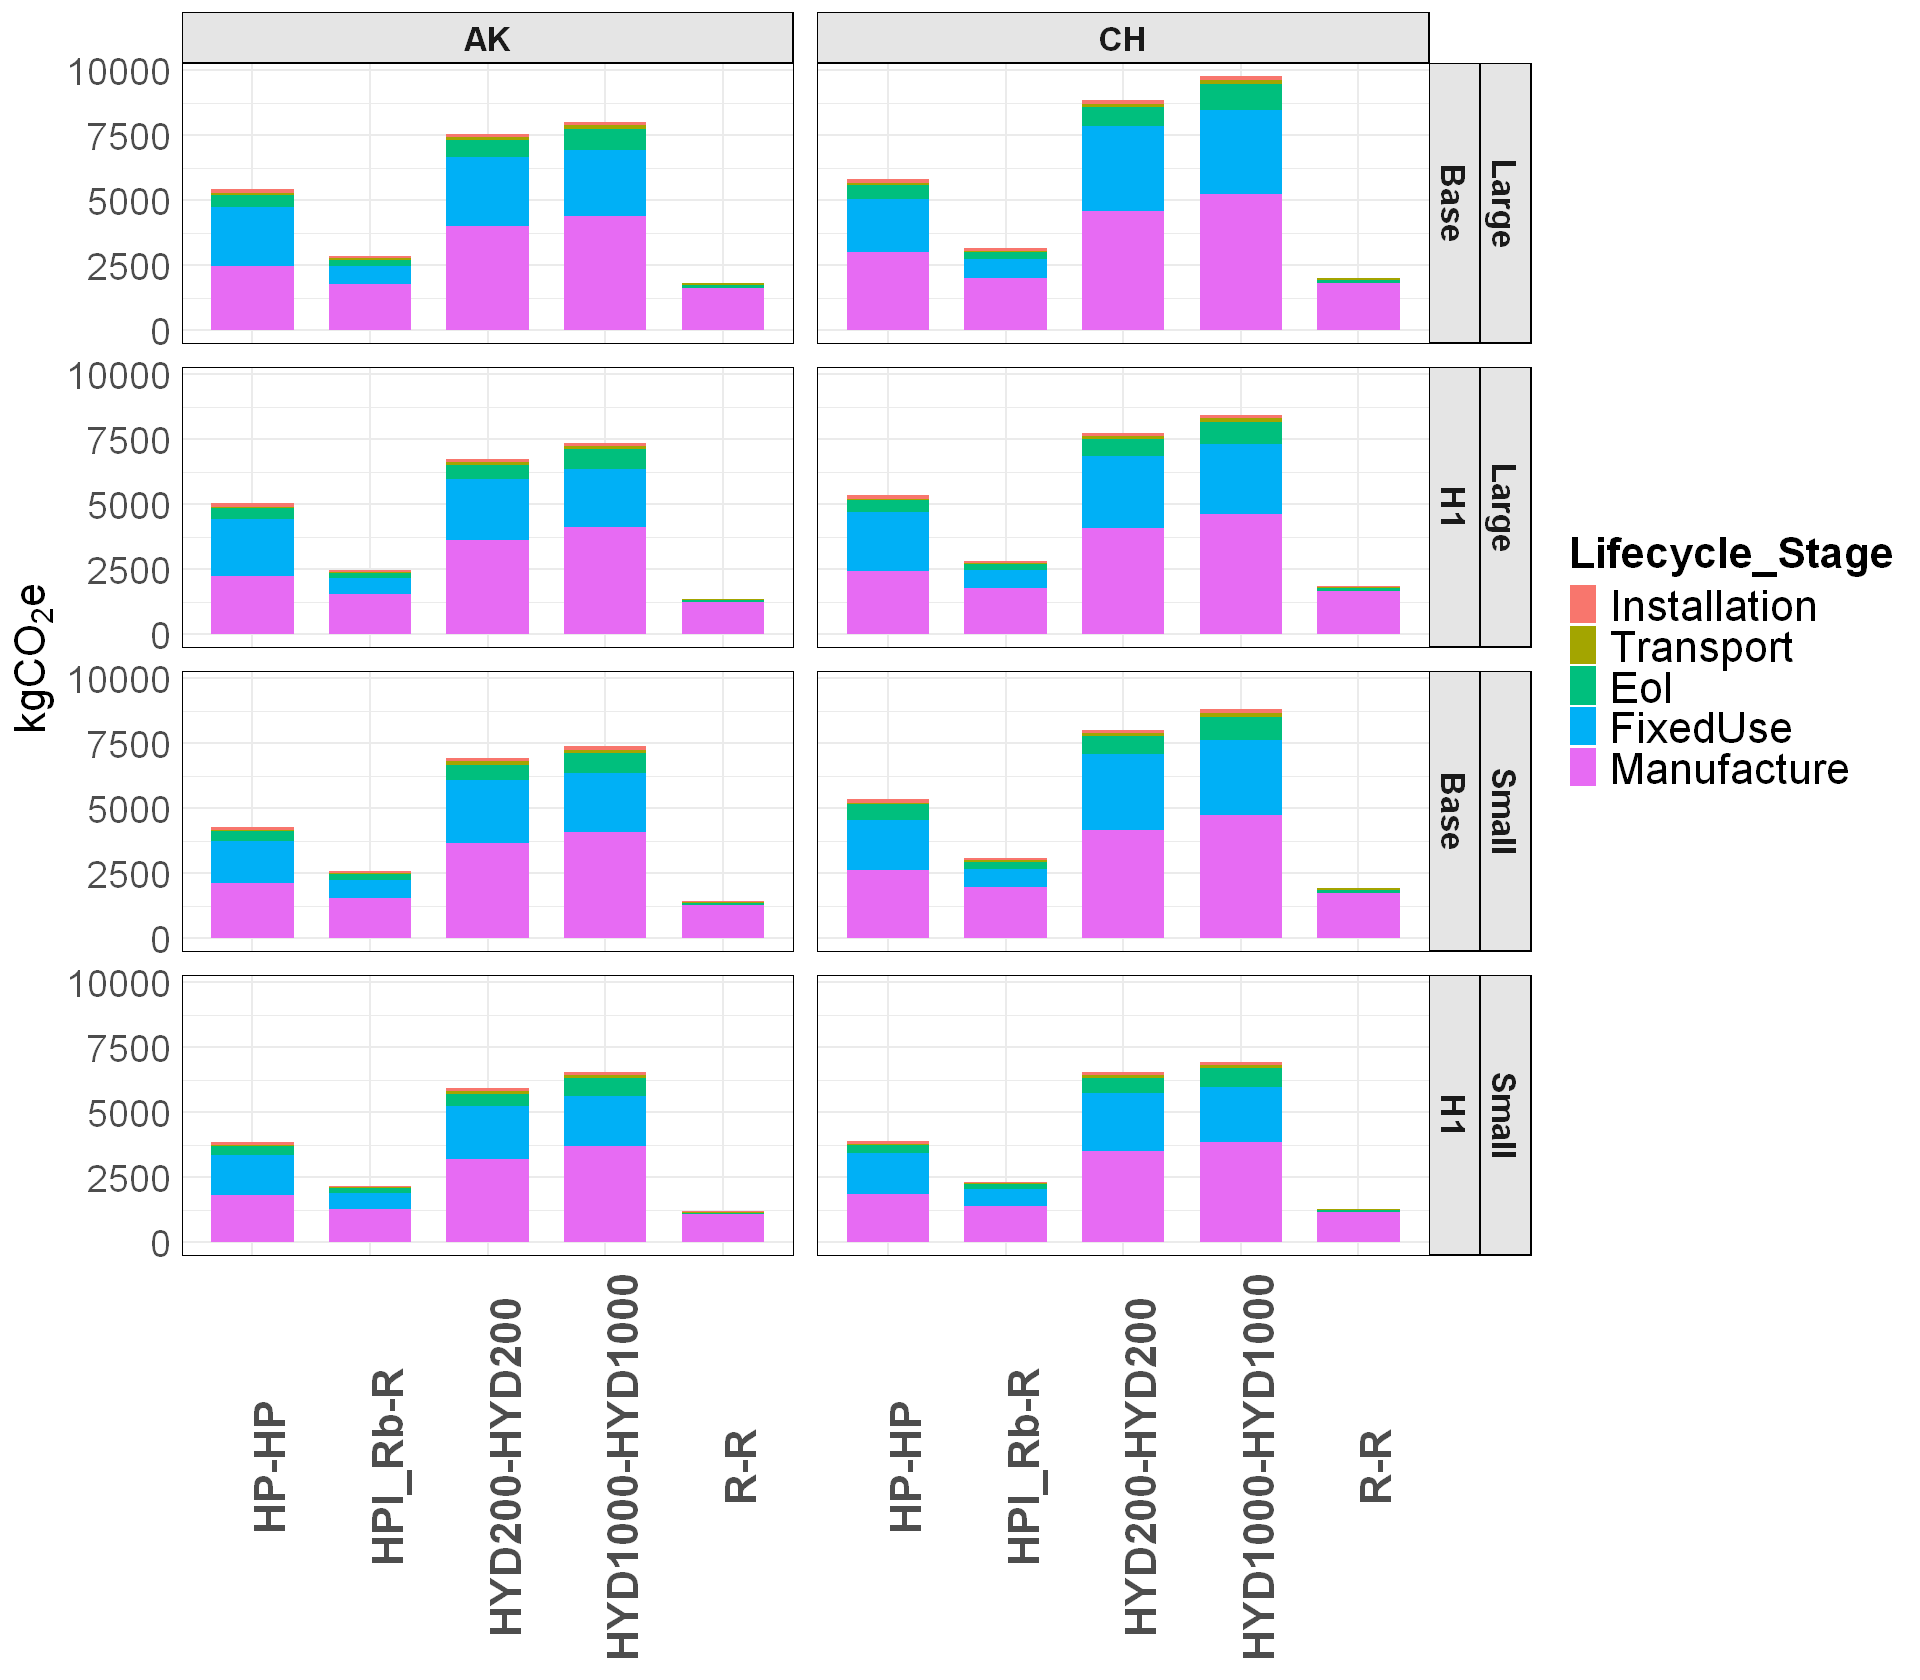

In [241]:
options(repr.plot.width=16, repr.plot.height=14)
stacked_embodied <- radar_long_CO2 %>% 
    mutate(Lifecycle_Stage = factor(Lifecycle_Stage,
                                 levels = c("Installation", "Transport", "Eol", "FixedUse", "Manufacture"))) %>%
    ggplot(aes(x = SH_DW_code, y = Value, fill = Lifecycle_Stage)) +
    geom_col(position = "stack", width = 0.7) +
    facet_grid(house_type + insulation ~ Loc_code) +
    theme_minimal(base_size = 15) +
    labs(x = NULL,
       y = expression(kgCO[2]*e),
       title = NULL,
      ) +
    theme(
        axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26, face = 'bold'),
        axis.title.y = element_text(size = 26),
        axis.text.y = element_text(size = 22),
        legend.title = element_text(size = 26, face = "bold"),
        legend.text = element_text(size = 26), 
        strip.text = element_text(face = "bold", size = 20),
        strip.background = element_rect(fill = "gray90", color = "black"),
        panel.border = element_rect(color = "black", fill = NA, size = 0.1),
        panel.spacing = unit(1, "lines")
      )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/stacked_embodied.png",  # File path
  plot = stacked_embodied,                       # Plot object
  width = 14,                             # Width in inches
  height = 16,                             # Height in inches
  dpi = 300                               # Resolution
)

stacked_embodied

### Discussion
The plots above shows the breakdown of embedded emissions across different locations, house types, and insulation levels:
- Hydronic settings have the highest embedded emissions of all combinations.
- All resistive setups have the lowest embedded emissions.
- Manufacturing embedded emissions dominate over all categories.
- For heat pump-based technologies, the fugitive emissions contribute significantly to MRRR use emissions. 

## Impacts of refrigerant type on embodied emissions
Lastly, the following plot provides insights into the impact of refrigerant selection on the total lifecycle climate performance of SWH systems, with a specific focus on end-of-life disposal, maintenance, replacement, and refrigerant leakage. The contrast in results is primarily attributable to the difference in Global Warming Potential (GWP) between the hydrofluorocarbon R32 (GWP 675) and the hydrocarbon R290 (GWP 3). 

In [242]:
# Base stack: uses EOL and MRRR
embodied_base <- household_lifetime_Call %>%
  filter(Occ_code == 3,
         SH_DW_code %in% c('HP-HP', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000'),
         Loc_code == 'CH') %>%
  select(house_type, insulation, SH_DW_code,  
         Manufacture, Distribution, Installation, EOL, Other, Embodied_life) %>%
  distinct() %>%
  rename(
    MRRR = Other,
    Transportation = Distribution,
    Embodied = Embodied_life  
  ) %>%
  pivot_longer(
    cols = c(Manufacture, EOL, Transportation, Installation, MRRR),
    names_to = "Lifecycle_Stage",
    values_to = "Value"
  ) %>%
  mutate(Stack_Type = "Base_R32")

# Alternative stack: uses EOL_S and MRRR_S
embodied_alt <- household_lifetime_Call %>%
  filter(Occ_code == 3,
         SH_DW_code %in% c('HP-HP', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000'),
         Loc_code == 'CH') %>%
  select(house_type, insulation, SH_DW_code, 
         Manufacture, Distribution, Installation, EOL_S, Other_S, Embodied_life_R) %>%
  distinct() %>%
  rename(
    MRRR = Other_S,
    Transportation = Distribution,
    EOL = EOL_S,
    Embodied = Embodied_life_R   
  ) %>%
  pivot_longer(
    cols = c(Manufacture, EOL, Transportation, Installation, MRRR),
    names_to = "Lifecycle_Stage",
    values_to = "Value"
  ) %>%
  mutate(Stack_Type = "Alternative_R290")

# Combine for faceting
embodied_long_facet <- bind_rows(embodied_base, embodied_alt)


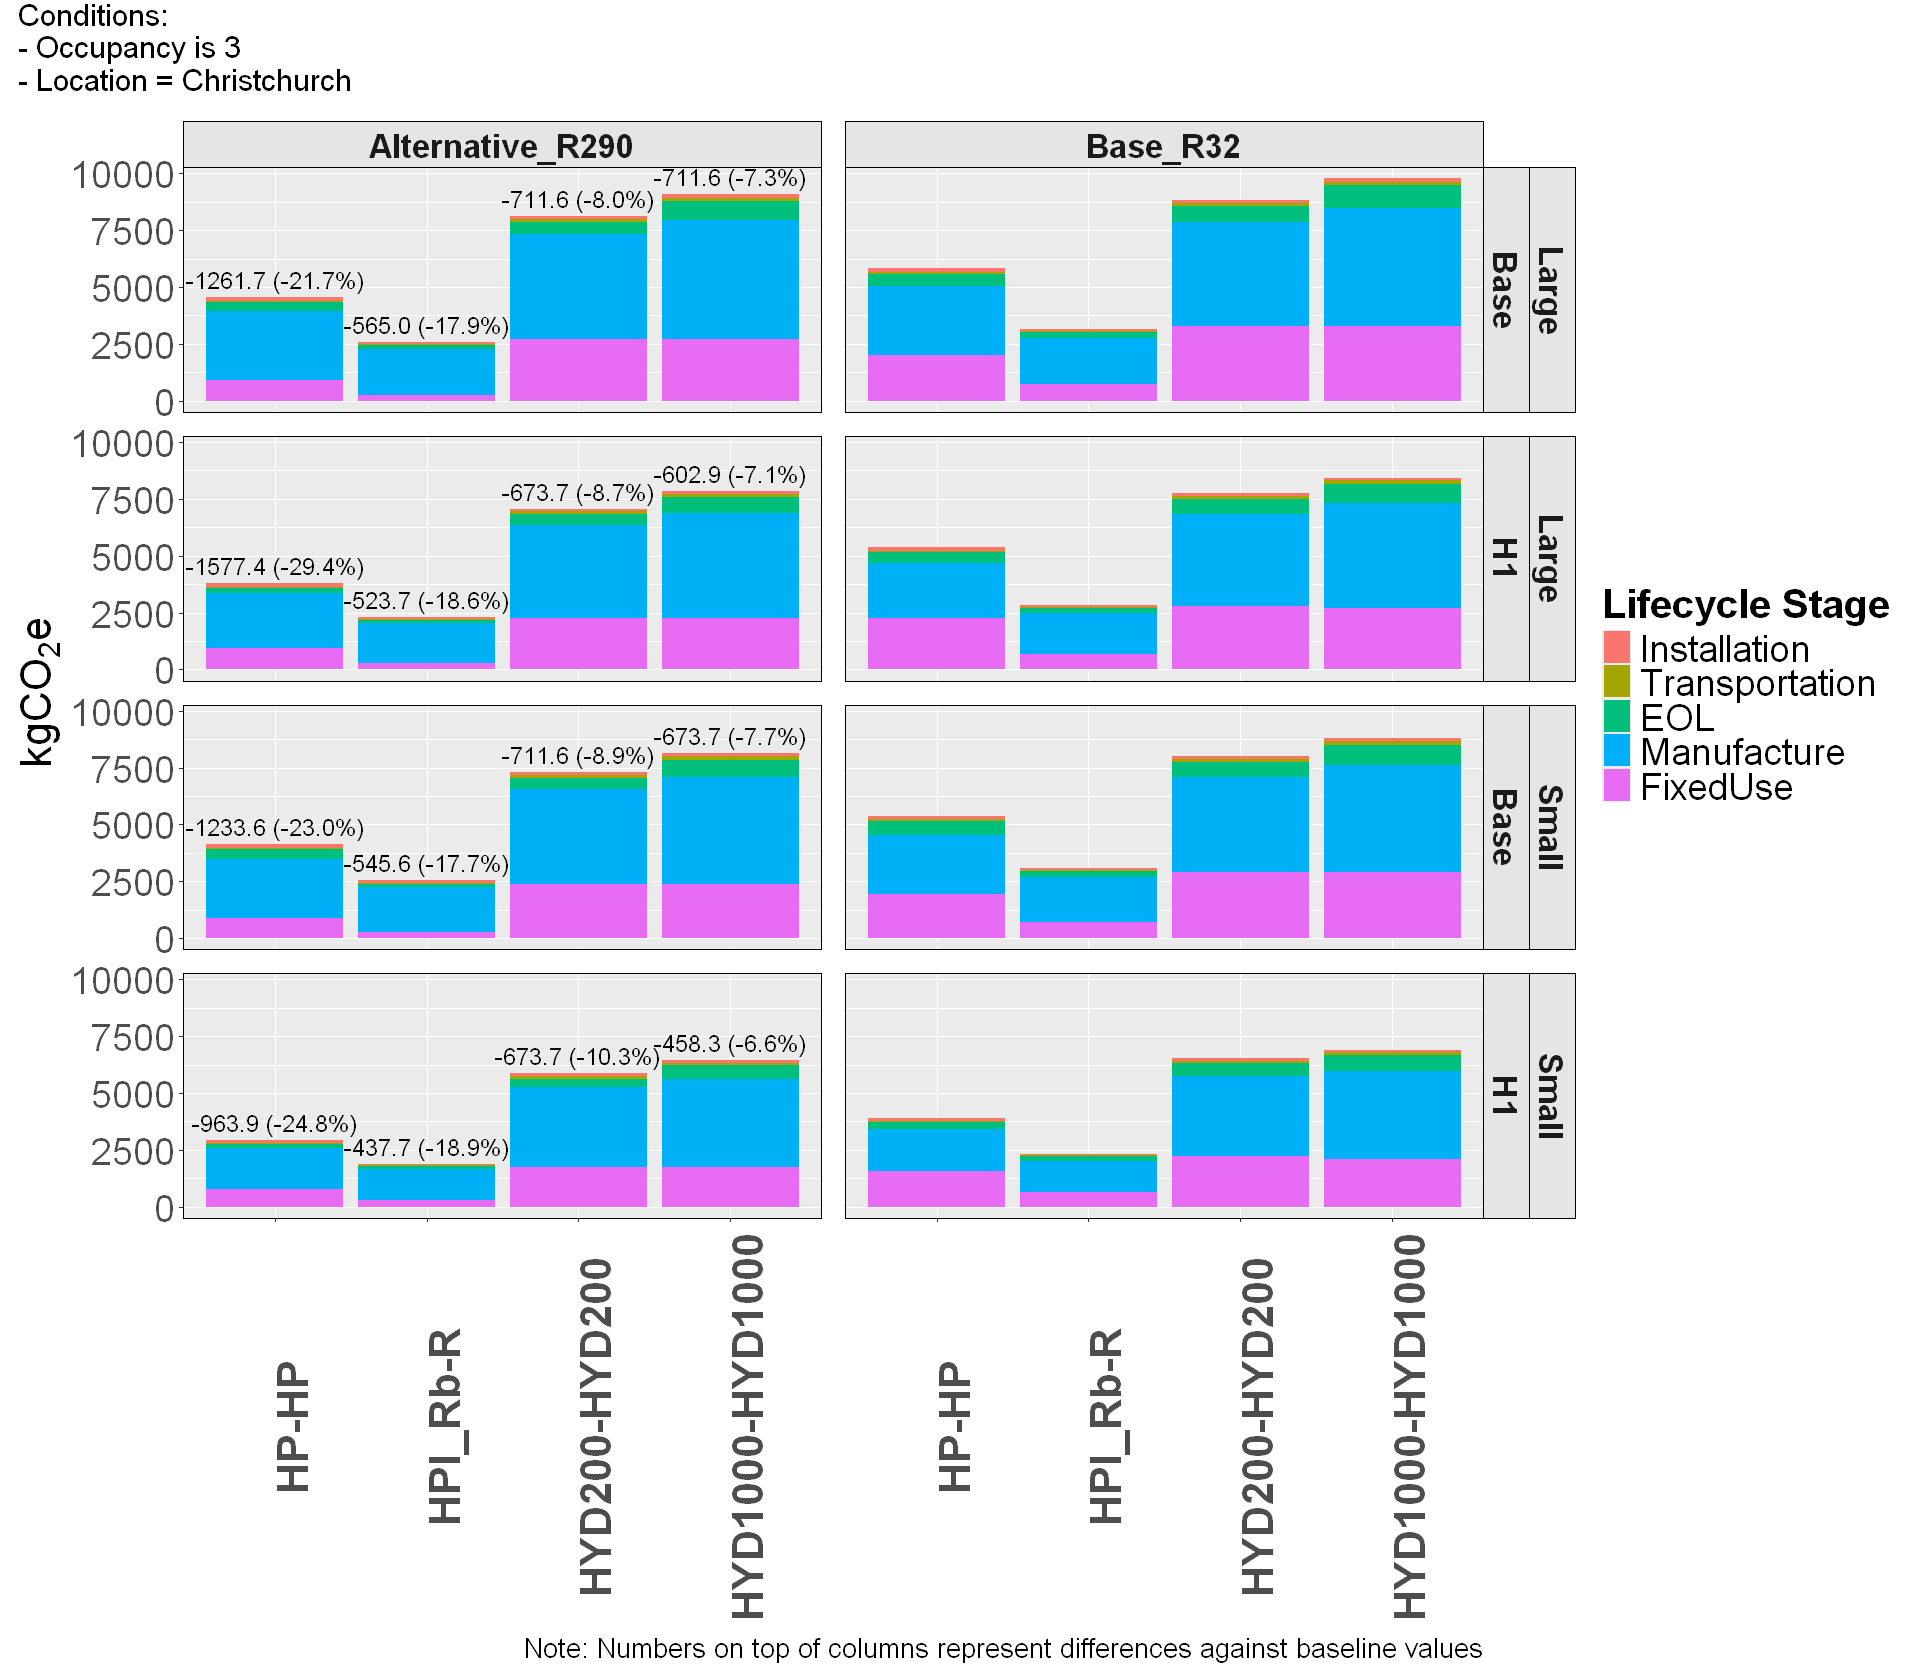

In [243]:
embodied_long_facet <- embodied_long_facet %>%
  mutate(Stack_Type = factor(Stack_Type, levels = c("Alternative_R290", "Base_R32")))

totals <- embodied_long_facet %>% 
  select(SH_DW_code, Stack_Type, house_type, insulation, Embodied) %>%
  distinct()

totals_wide <- totals %>%
  pivot_wider(names_from = Stack_Type, values_from = Embodied)

# Calculate difference only for Alternative
diffs <- totals_wide %>%
  mutate(Diff = Alternative_R290 - Base_R32,
        Diff_p = 100*(Alternative_R290 - Base_R32) / Base_R32)

label_df <- diffs %>%
  select(SH_DW_code, house_type, insulation, Diff, Diff_p) %>%
  left_join(
    totals %>% filter(Stack_Type == "Alternative_R290"),
    by = c("SH_DW_code","house_type", "insulation")
  ) %>%
  mutate(Stack_Type = "Alternative_R290")

R_sens <- embodied_long_facet %>%
  mutate(Lifecycle_Stage = ifelse(Lifecycle_Stage == 'MRRR', 'FixedUse', Lifecycle_Stage)) %>% 
  mutate(Lifecycle_Stage = factor(Lifecycle_Stage,
                                 levels = c("Installation", "Transportation", "EOL", "Manufacture", "FixedUse"))) %>%  
  ggplot(aes(x = SH_DW_code, y = Value, fill = Lifecycle_Stage)) +
  geom_col() +
  facet_grid(house_type + insulation ~ Stack_Type) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26, face = 'bold'),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 24, face = "bold"),
    legend.text = element_text(size = 22),   
    strip.text = element_text(face = "bold", size=20), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.caption = element_text(size = 16)
   
  ) + labs(caption = "Note: Numbers on top of columns represent differences against baseline values",
        x = NULL,
        y = expression(kgCO[2]*e),
        title = NULL,
        fill =  "Lifecycle Stage") +
  # Add difference labels above Alternative columns only
geom_text(
    data = label_df,
    aes(x = SH_DW_code, y = Embodied, label = sprintf("%.1f (%.1f%%)", Diff, Diff_p)),
    vjust = -0.5,
    size = 5,
    inherit.aes = FALSE,
    color = "black"
  )

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/R_sens.png",  # File path
  plot = R_sens,                       # Plot object
  width = 16,                             # Width in inches
  height = 16,                             # Height in inches
  dpi = 300                               # Resolution
)  

R_sens + 
  plot_annotation(
    title = "Conditions:\n- Occupancy is 3\n- Location = Christchurch",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
Figure above compares embodied emissions for heat pump–based systems using different refrigerant types in Christchurch. The most significant percentage reductions—ranging from 17.7% to 29.4%—are observed in non-hydronic configurations, where heat pump–related components account for the largest share of embodied emissions. In contrast, hydronic systems exhibit smaller relative reductions, as their embodied emissions are also influenced by additional components such as buffer tanks, piping, and fan coil units.
Most of the differences between the base (R32) and alternative (R290) cases arise from the Fixed Use and End-of-Life (EoL) stages, reflecting the influence of refrigerant leakage, replacement, and disposal processes over the system’s lifetime.

## <span style="color: red;">Alternative Visualisations</span>

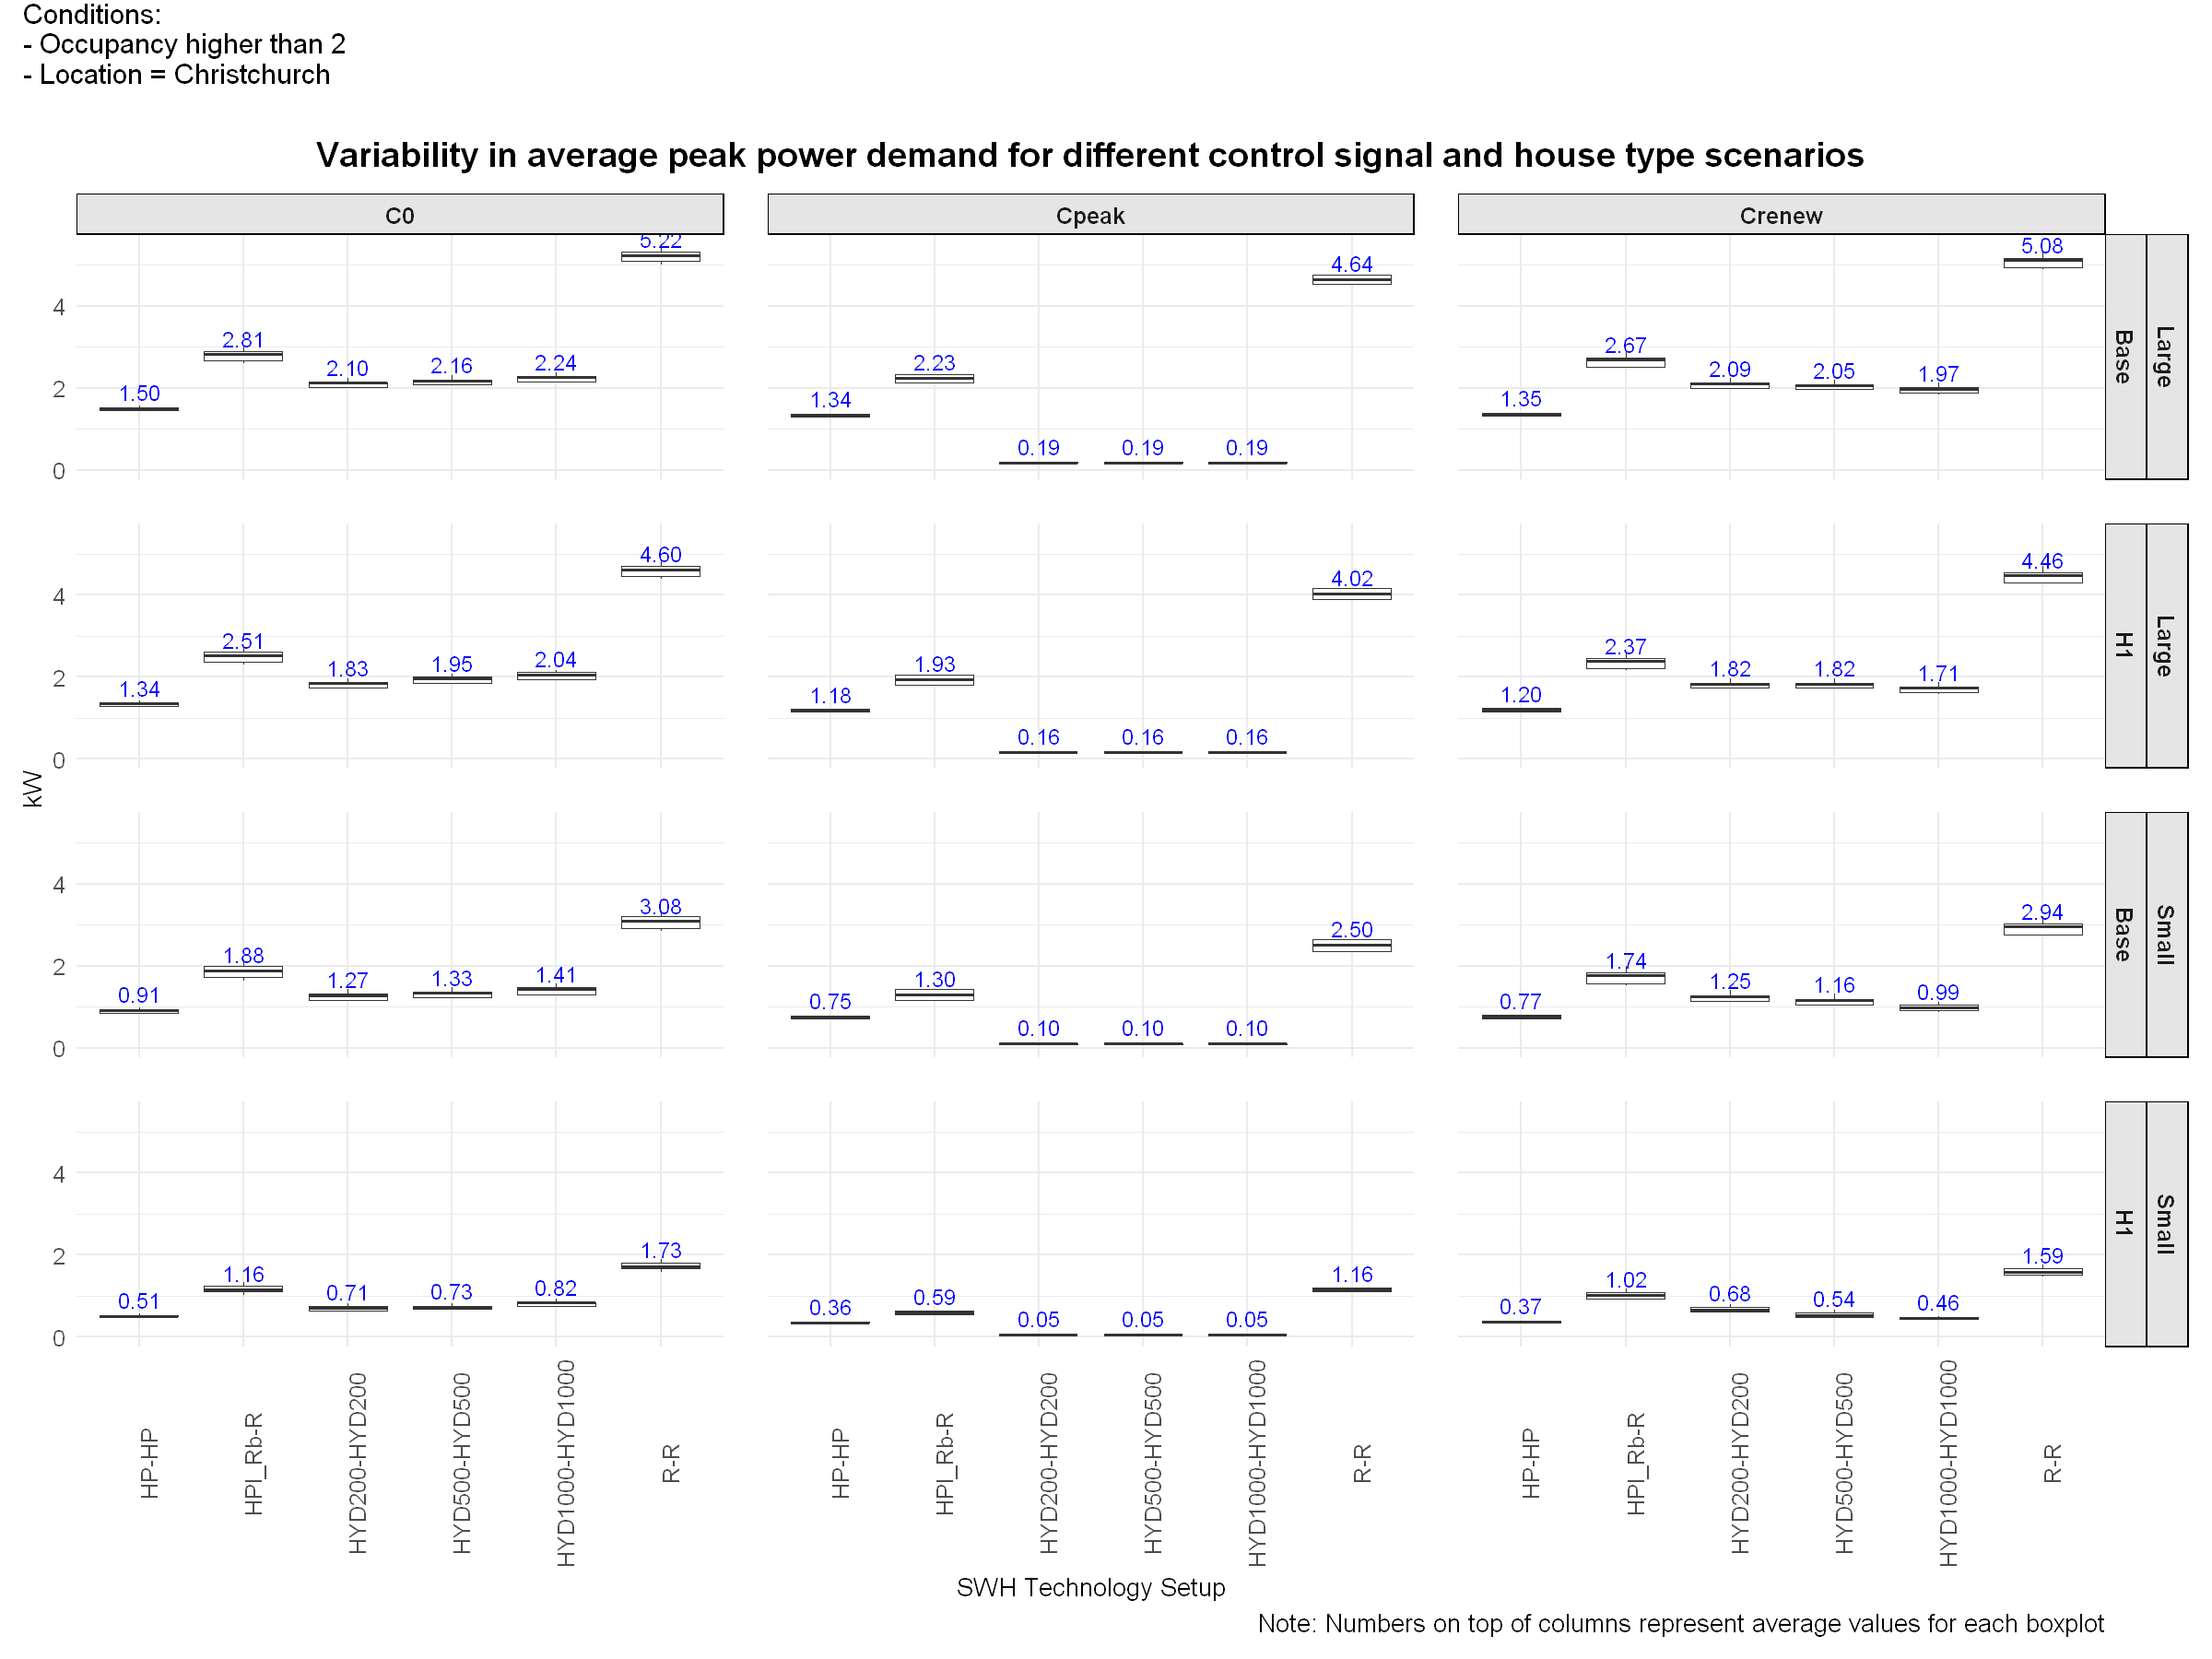

In [37]:
options(repr.plot.width=20, repr.plot.height=15)
main_plot <- household_lifetime_Call_CS_power %>%
  ggplot(aes(x = SH_DW_code, y = P_avg_peak_kW_year)) +
  geom_boxplot() +
  stat_summary(
    fun = mean, 
    geom = "text", 
    aes(label = sprintf("%.2f", after_stat(y))), 
    vjust = -0.5, 
    color = "blue", 
    size = 5
  ) +
  facet_grid(house_type + insulation ~ CS_code) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.margin = margin(t = 30, r = 10, b = 10, l = 10),
    plot.caption = element_text(size = 16),
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
    labs(caption = "Note: Numbers on top of columns represent average values for each boxplot",
        x = "SWH Technology Setup",
        y = "kW",
        title = "Variability in average peak power demand for different control signal and house type scenarios")
main_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy higher than 2\n- Location = Christchurch",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

In [38]:
household_lifetime_Call_CS_high <- household_lifetime_Call %>% 
filter(Occ_code > 2, 
       Loc_code == 'CH',
      SH_DW_code %in% c('HP-HP', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000'),
      Hydro_resource == 'Hhigh',
      schedule == 'Real') %>%
group_by(house_type, insulation, SH_DW_code, CS_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_CS_high <- household_lifetime_Call_CS_high %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions")
# Calculate base case emissions
base_CS_high <- plot_CS_high %>%
  filter(CS_code == 'C0') %>%
  select(house_type, insulation, SH_DW_code, Type, base_Emissions = Emissions)
# Join base emissions onto all CS_code values
plot_CS_diff_high <- plot_CS_high %>%
  left_join(base_CS_high, by = c("house_type", "insulation", "SH_DW_code", "Type")) %>%
  mutate(diff_base = Emissions - base_Emissions)

household_lifetime_Call_CS_low <- household_lifetime_Call %>% 
filter(Occ_code > 2, 
       Loc_code == 'CH',
      SH_DW_code %in% c('HP-HP', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000'),
      Hydro_resource == 'Hlow',
      schedule == 'Real') %>%
group_by(house_type, insulation, SH_DW_code, CS_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_CS_low <- household_lifetime_Call_CS_low %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions")
# Calculate base case emissions
base_CS_low <- plot_CS_low %>%
  filter(CS_code == 'C0') %>%
  select(house_type, insulation, SH_DW_code, Type, base_Emissions = Emissions)
# Join base emissions onto all CS_code values
plot_CS_diff_low <- plot_CS_low %>%
  left_join(base_CS_low, by = c("house_type", "insulation", "SH_DW_code", "Type")) %>%
  mutate(diff_base = Emissions - base_Emissions)

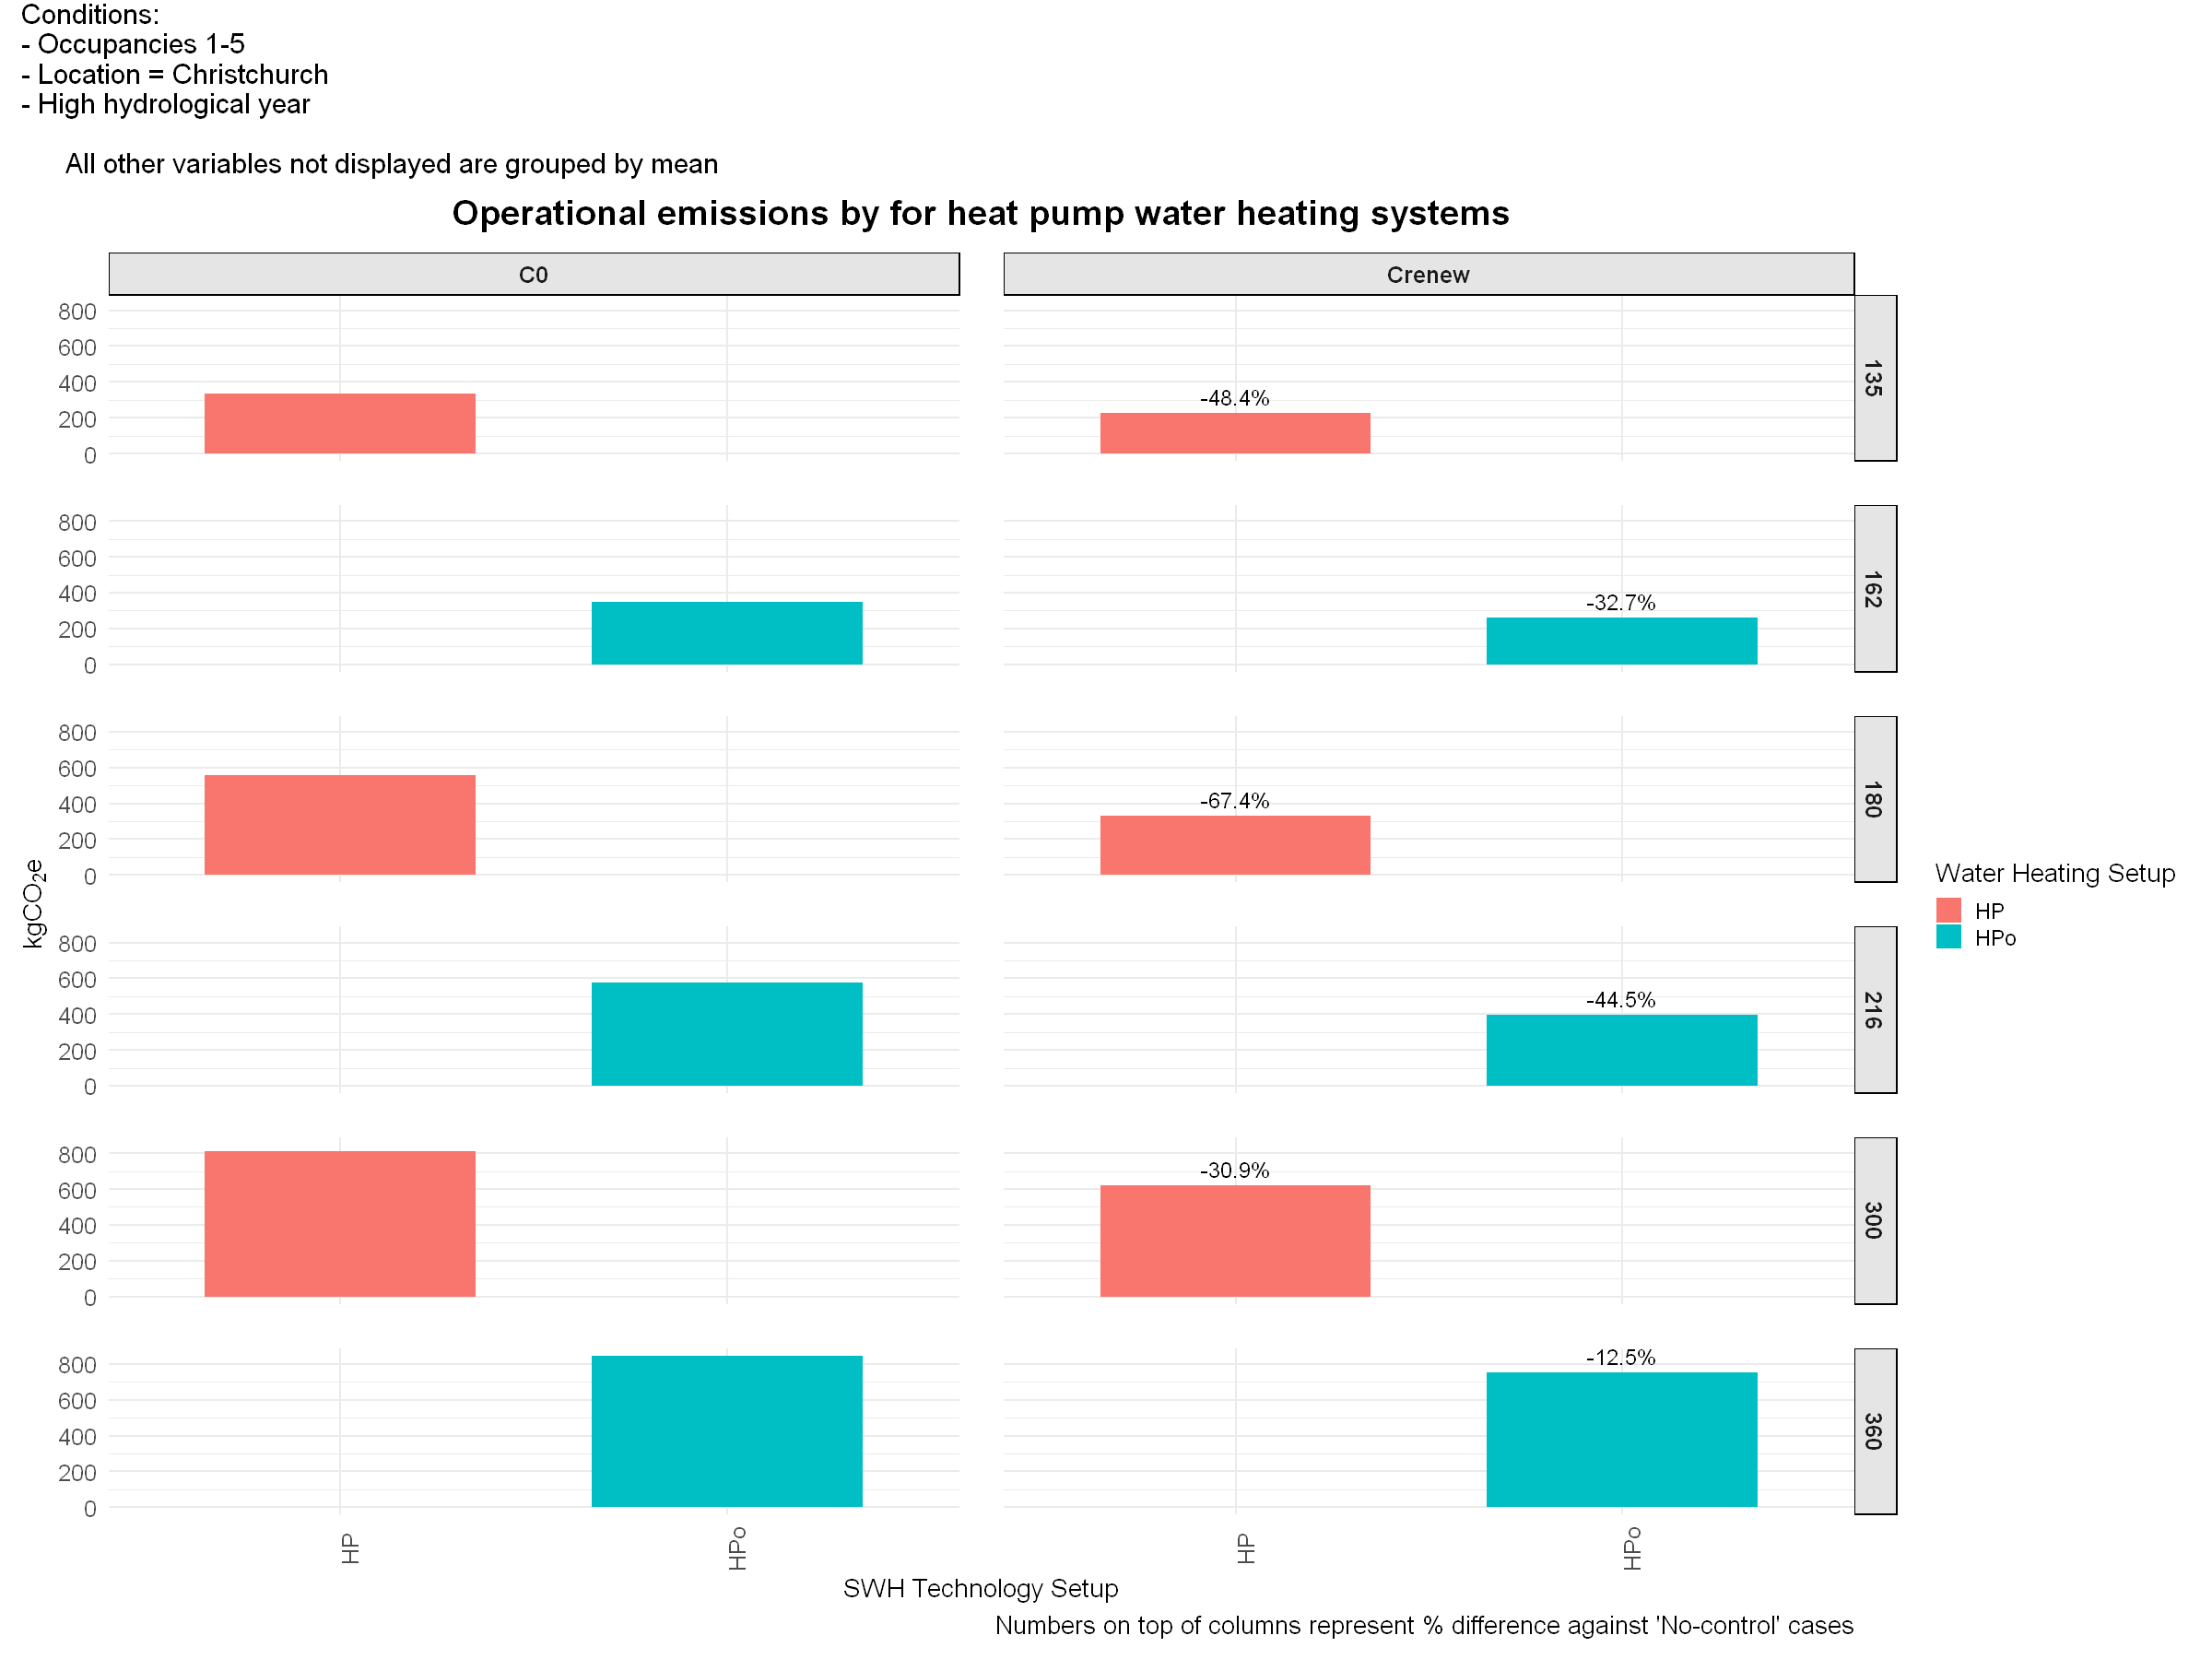

In [39]:
technology_lifetime_Call_DW <- technology_lifetime_Call %>% 
  filter(!is.na(DW_code)) %>% 
  filter(DW_code %in% c("HP", "HPo")) %>%  
  filter(CS_code != 'Cpeak') %>%
  filter(Hydro_resource == 'Hhigh') %>%
  filter(Loc_code == 'CH') %>%  
  group_by(DW_code, Loc_code, HP_cap,`Tank_Volume (L)`, CS_code) %>% 
  summarise(kgCO2 = mean(kgCO2_oper_life),
            kWh = mean(P_annual_kWh_life)) %>% 
  suppressMessages() %>%
  ungroup() %>%
  mutate(kgCO2_per_kWh = kgCO2/kWh) 
# Calculate base case emissions
technology_lifetime_Call_DW_base <- technology_lifetime_Call_DW %>%
  filter(CS_code == 'C0') %>%
  select(Loc_code, DW_code, HP_cap, `Tank_Volume (L)`, kgCO2_C0 = kgCO2)
# Join base emissions onto all CS_code values
technology_lifetime_Call_DW_diff <- technology_lifetime_Call_DW %>%
  left_join(technology_lifetime_Call_DW_base, by = c("Loc_code", "DW_code", "HP_cap", "Tank_Volume (L)")) %>%
  mutate(diff = 100*(kgCO2 - kgCO2_C0)/kgCO2)

oversize_plot <- technology_lifetime_Call_DW_diff %>%    
  ggplot(aes(x = DW_code, y = kgCO2, fill=DW_code)) + 
  geom_col(width = 0.7) +
  geom_text(
    aes(label = ifelse(!is.na(diff) & CS_code == 'Crenew', sprintf("%.1f%%", diff), "")),
    vjust = -0.5, 
    size = 5,
    color = "black"
  ) +
  facet_grid(`Tank_Volume (L)` ~ CS_code) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.caption = element_text(size = 16),
    plot.title = element_text(size = 23, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
  labs(x = "SWH Technology Setup",
       y = expression(kgCO[2]*e),
       title = "Operational emissions by for heat pump water heating systems",
       fill= "Water Heating Setup",
       caption = "Numbers on top of columns represent % difference against 'No-control' cases")

oversize_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancies 1-5\n- Location = Christchurch\n- High hydrological year\n
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

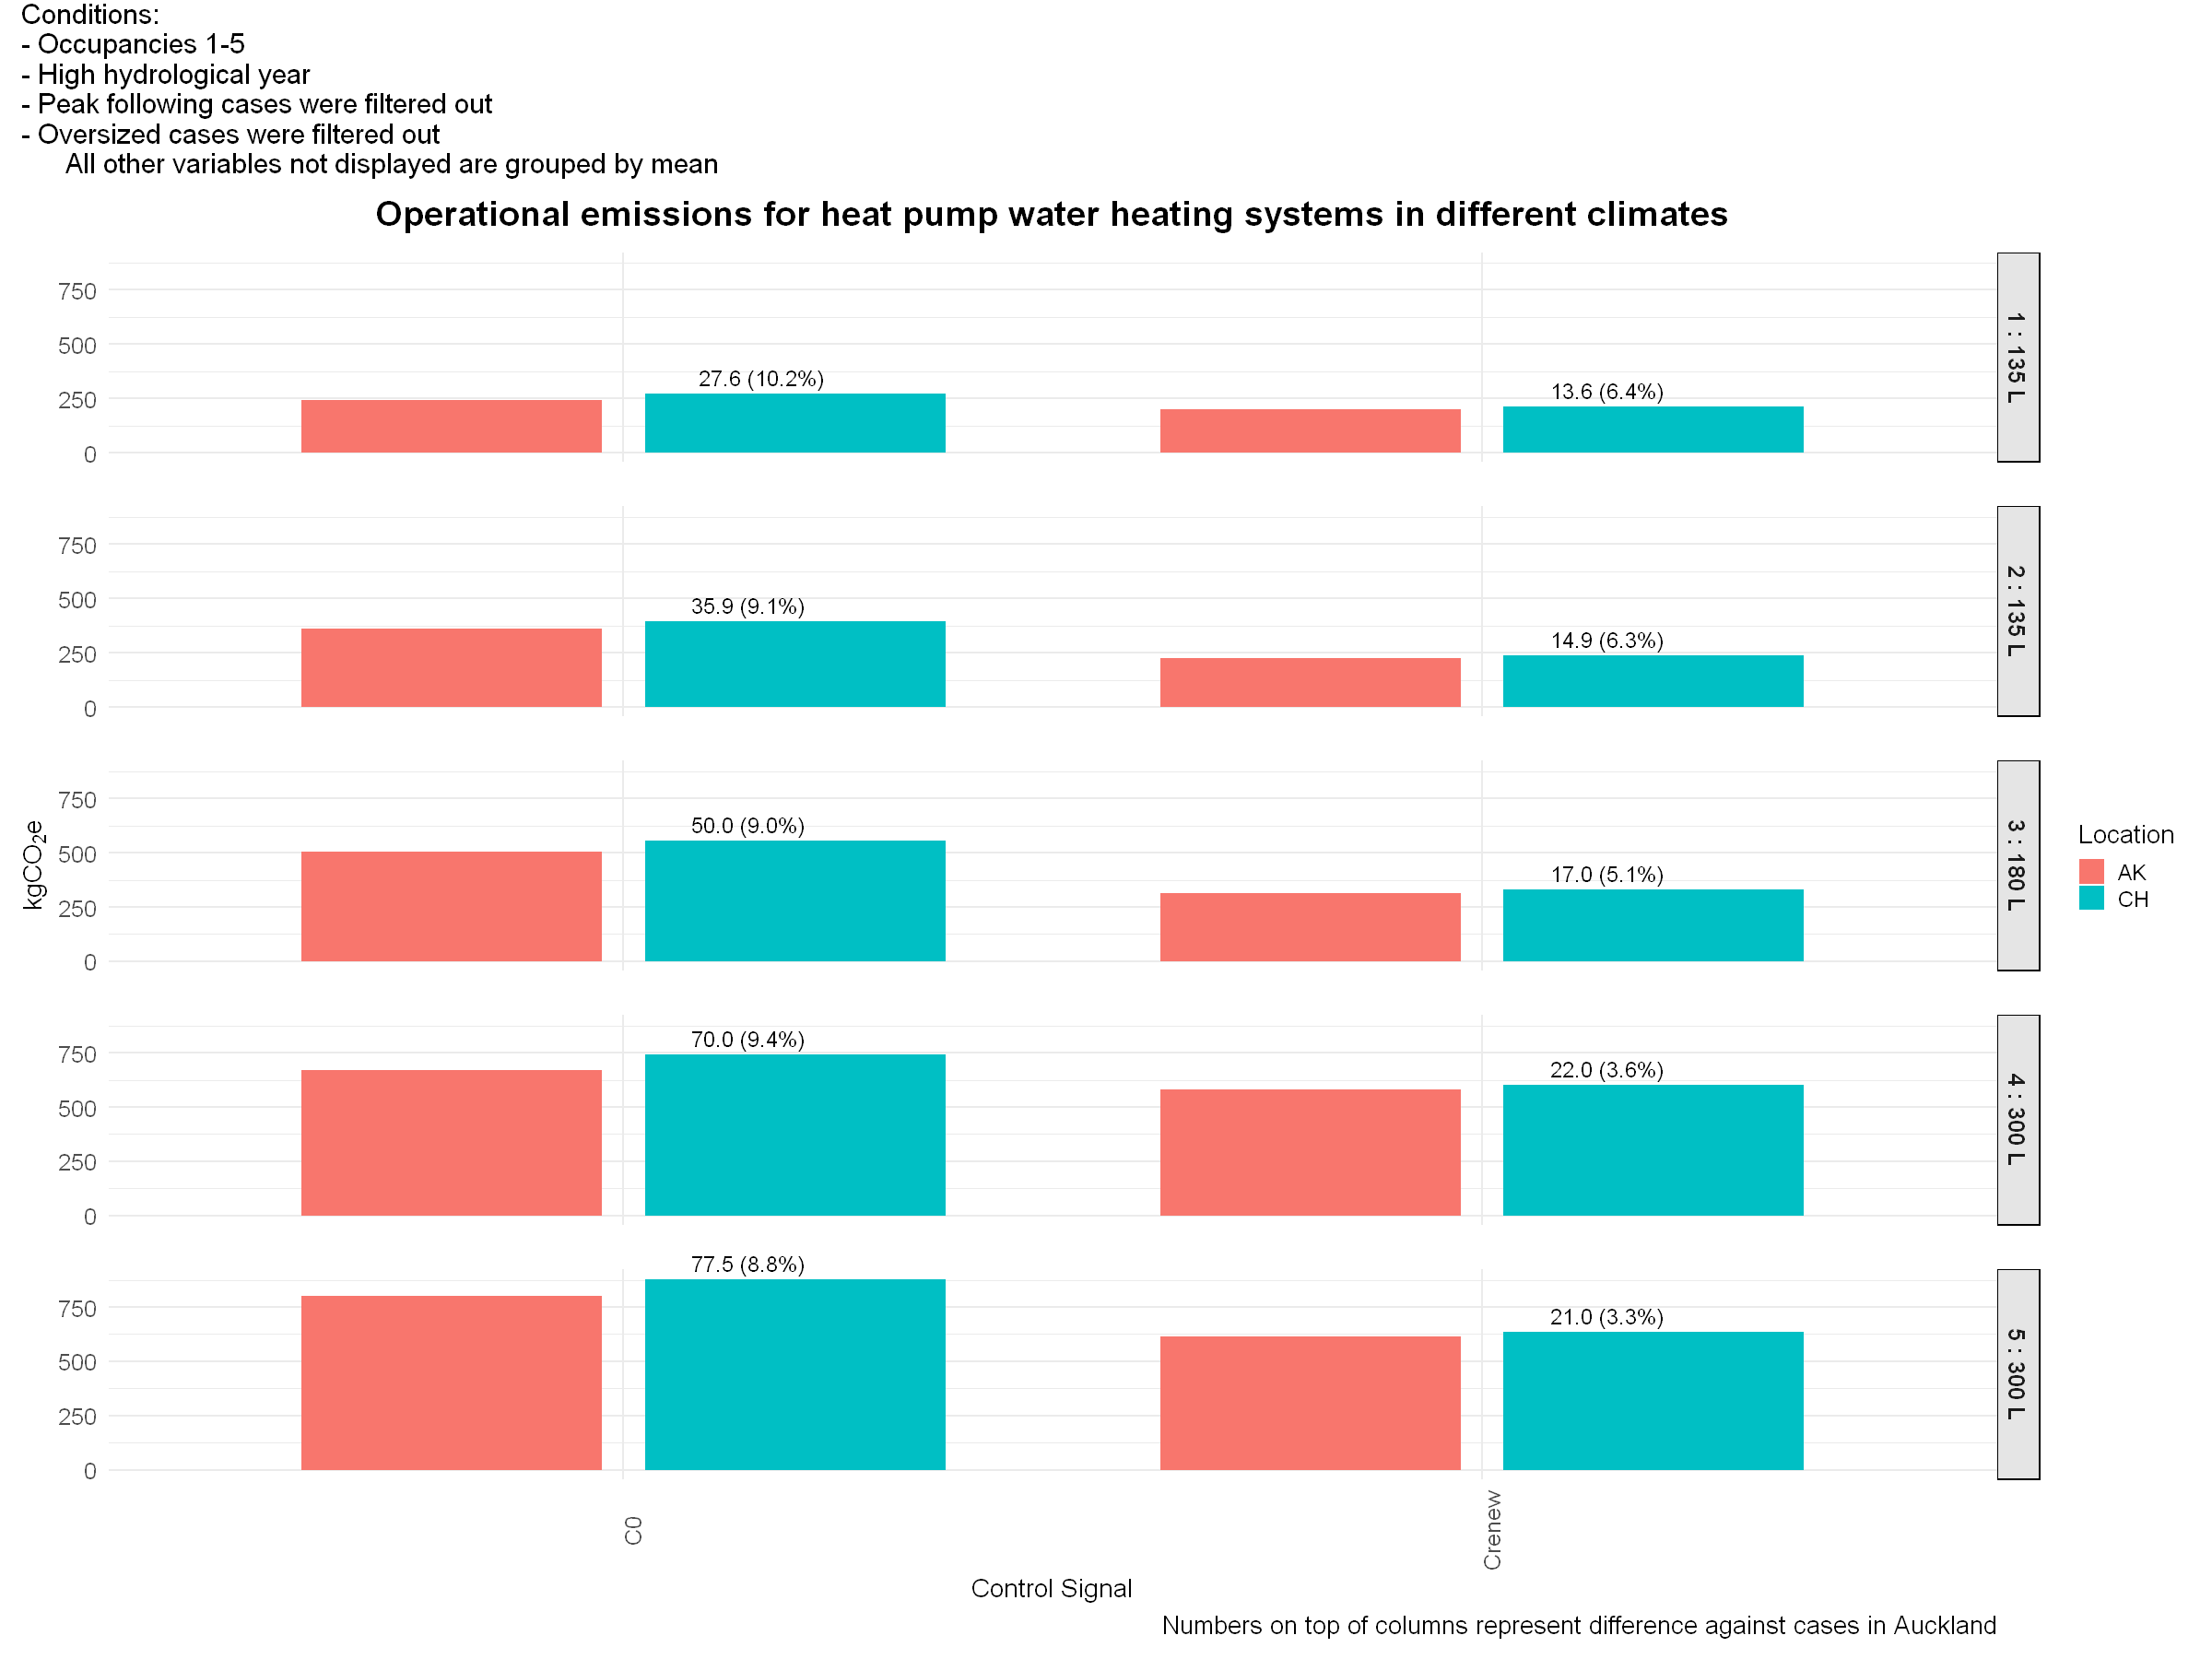

In [40]:
climate_plot <- technology_lifetime_Call_DW_HP_diff %>%
  mutate(Tank_Label = paste0(`Tank_Volume (L)`, " L")) %>%
  ggplot(aes(x = CS_code, y = kgCO2, fill = Loc_code)) + 
  geom_col(width = 0.7, position = position_dodge(width = 0.8)) +
  geom_text(
    aes(label = ifelse(!is.na(diff) & Loc_code == 'CH', sprintf("%.1f (%.1f%%)", diff_a, diff_p), "")),
    hjust = -0.6,
    vjust = -0.5, 
    size = 5,
    color = "black"
  ) +
  facet_grid(interaction(Occ_code, Tank_Label, sep= " : ") ~ .) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.caption = element_text(size = 16),
    plot.title = element_text(size = 23, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
  labs(x = "Control Signal",
       y = expression(kgCO[2]*e),
       title = "Operational emissions for heat pump water heating systems in different climates",
       fill= "Location",
       caption = "Numbers on top of columns represent difference against cases in Auckland")

climate_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancies 1-5\n- High hydrological year\n- Peak following cases were filtered out\n- Oversized cases were filtered out
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

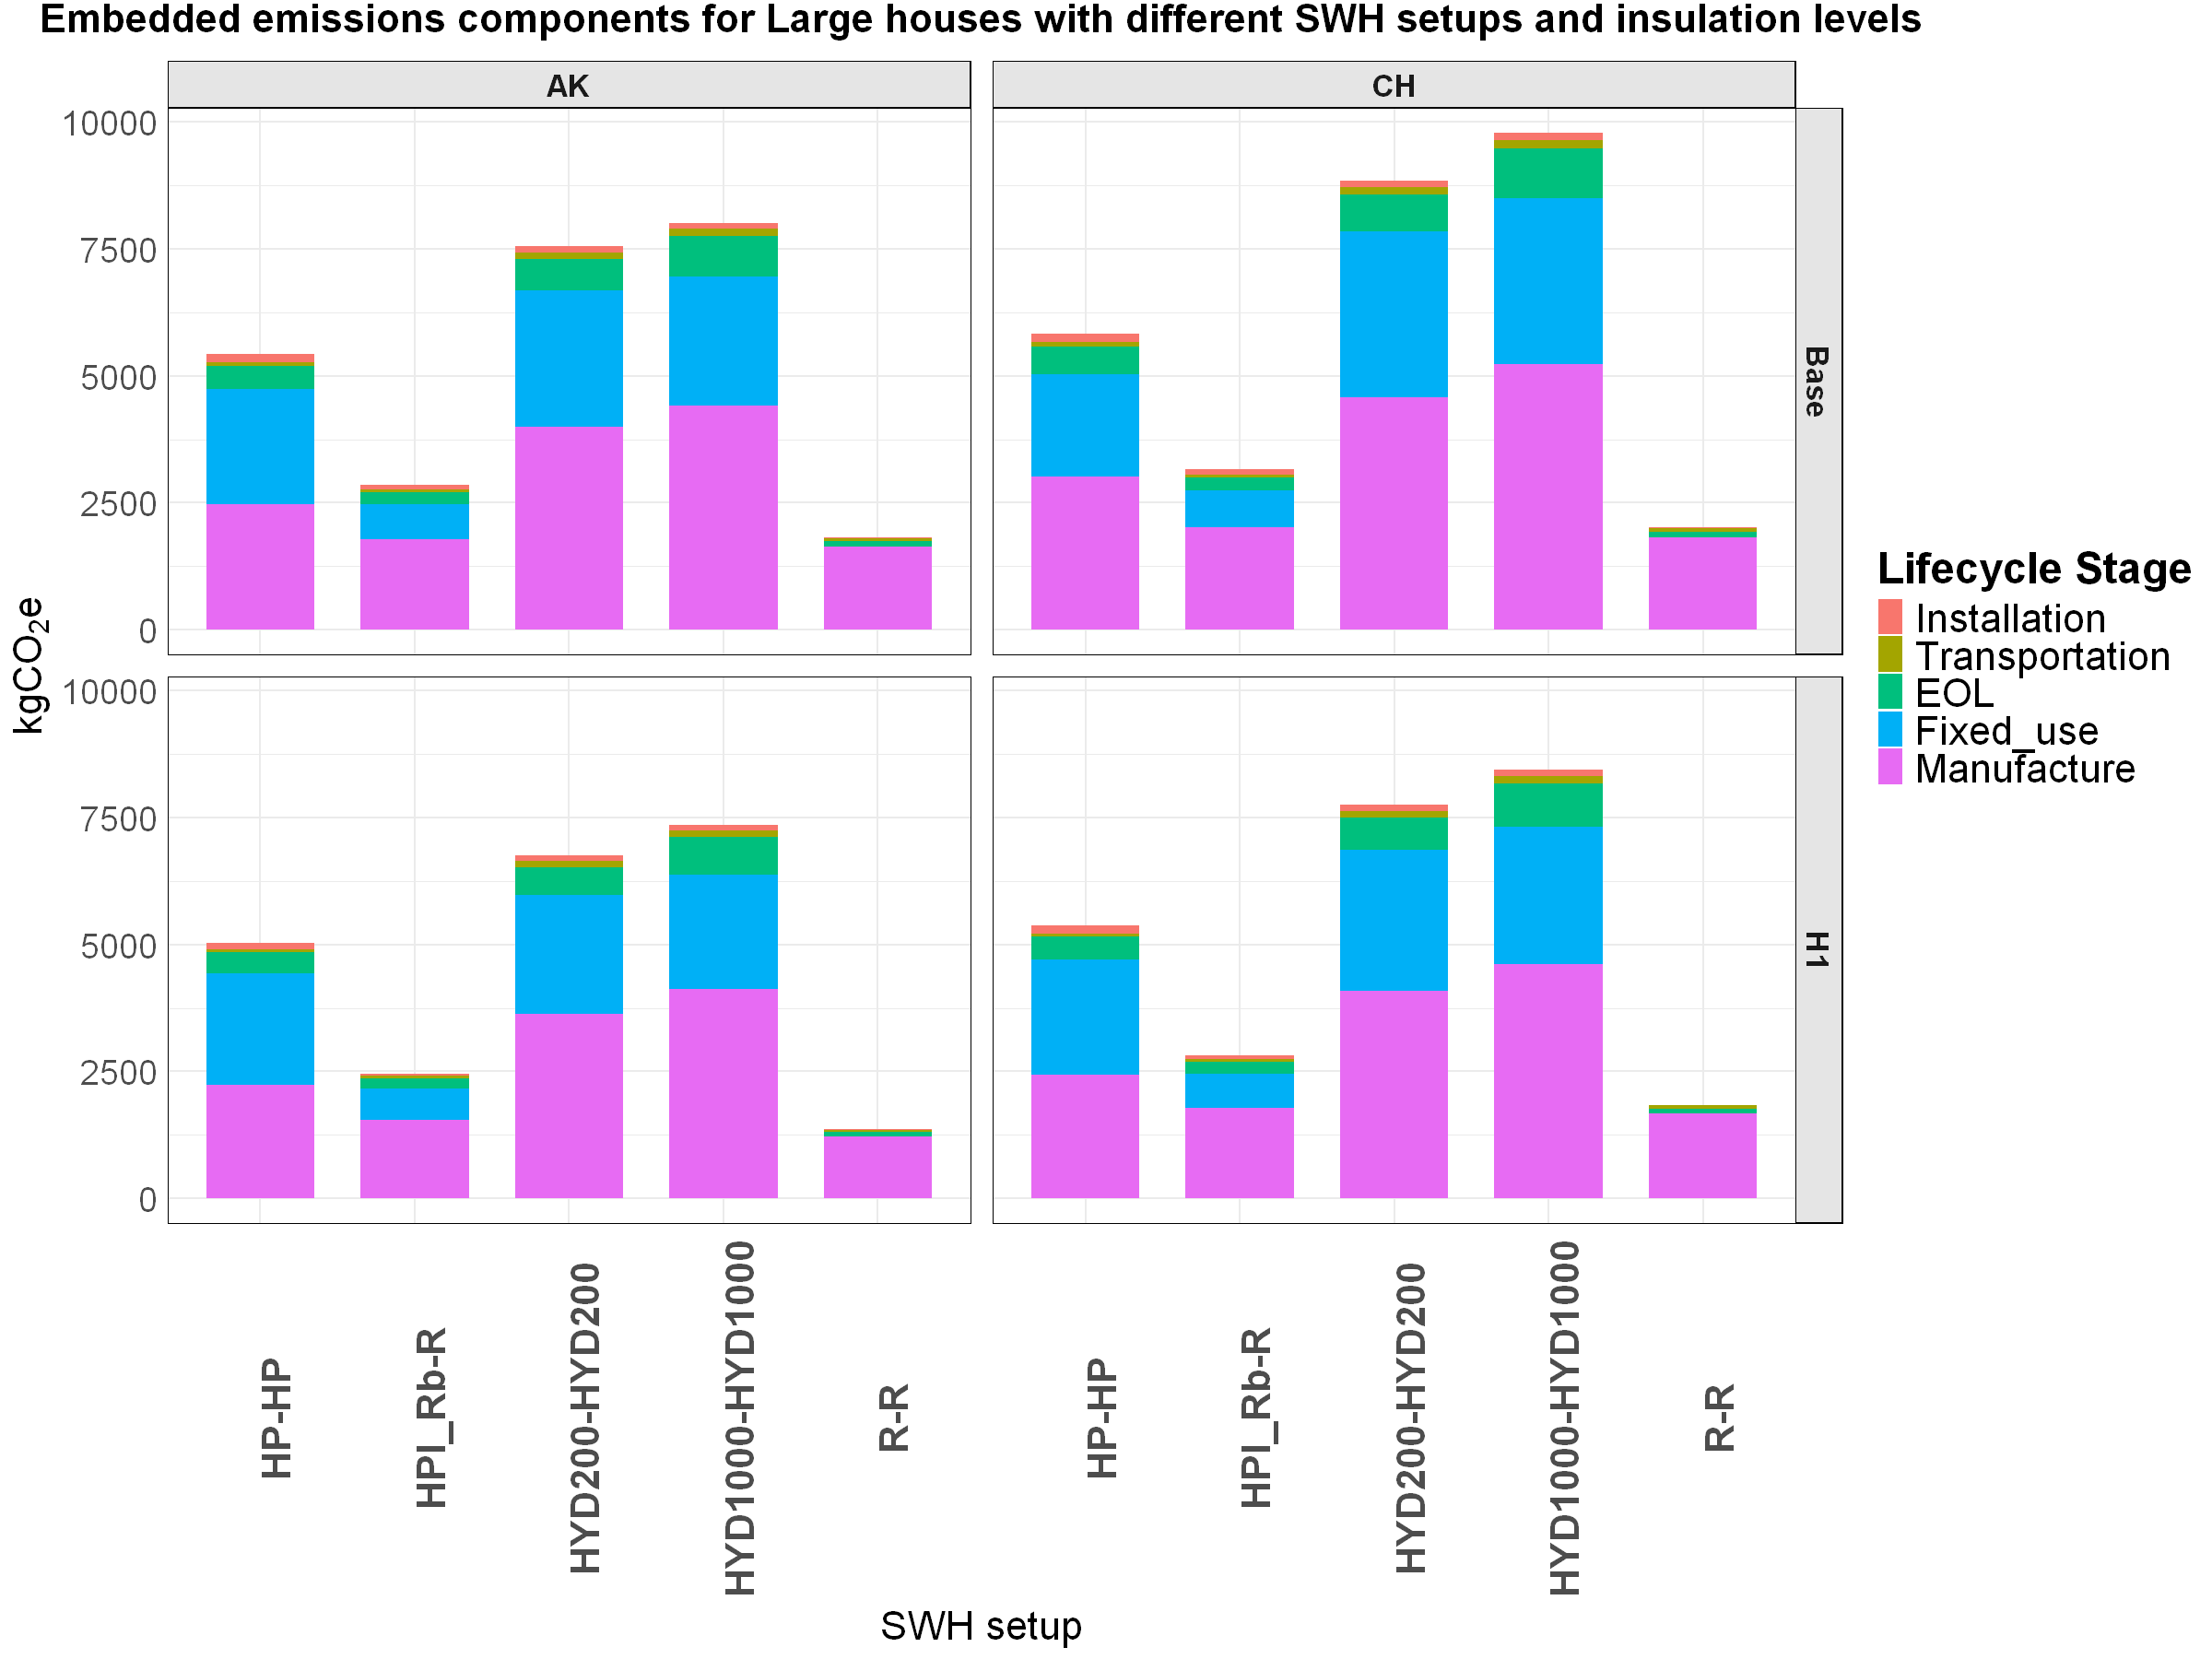

In [41]:
options(repr.plot.width=20, repr.plot.height=15)
radar_long_CO2 %>% 
    filter(house_type == 'Large') %>%
    mutate(Lifecycle_Stage = ifelse(Lifecycle_Stage == 'F_use', 'Fixed_use',as.character(Lifecycle_Stage))) %>%
    mutate(Lifecycle_Stage = factor(Lifecycle_Stage,
                                 levels = c("Installation", "Transportation", "EOL", "Fixed_use", "Manufacture"))) %>%
    ggplot(aes(x = SH_DW_code, y = Value, fill = Lifecycle_Stage)) +
    geom_col(position = "stack", width = 0.7) +
    facet_grid(insulation ~ Loc_code) +
    theme_minimal(base_size = 15) +
    labs(x = "SWH setup",
       y = expression(kgCO[2]*e),
       title = "Embedded emissions components for Large houses with different SWH setups and insulation levels",
       fill = 'Lifecycle Stage'  
      ) +
    theme(
        axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26, face = 'bold'),
        axis.title.x = element_text(size = 26),
        axis.title.y = element_text(size = 26),
        axis.text.y = element_text(size = 22),
        legend.title = element_text(size = 28, face = "bold"),
        legend.text = element_text(size = 26), 
        strip.text = element_text(face = "bold", size = 20),
        strip.background = element_rect(fill = "gray90", color = "black"),
        panel.border = element_rect(color = "black", fill = NA, size = 0.1),
        panel.spacing = unit(1, "lines"),
        plot.title = element_text(size = 26, face = "bold", hjust = 0.5, vjust = 2)
      )

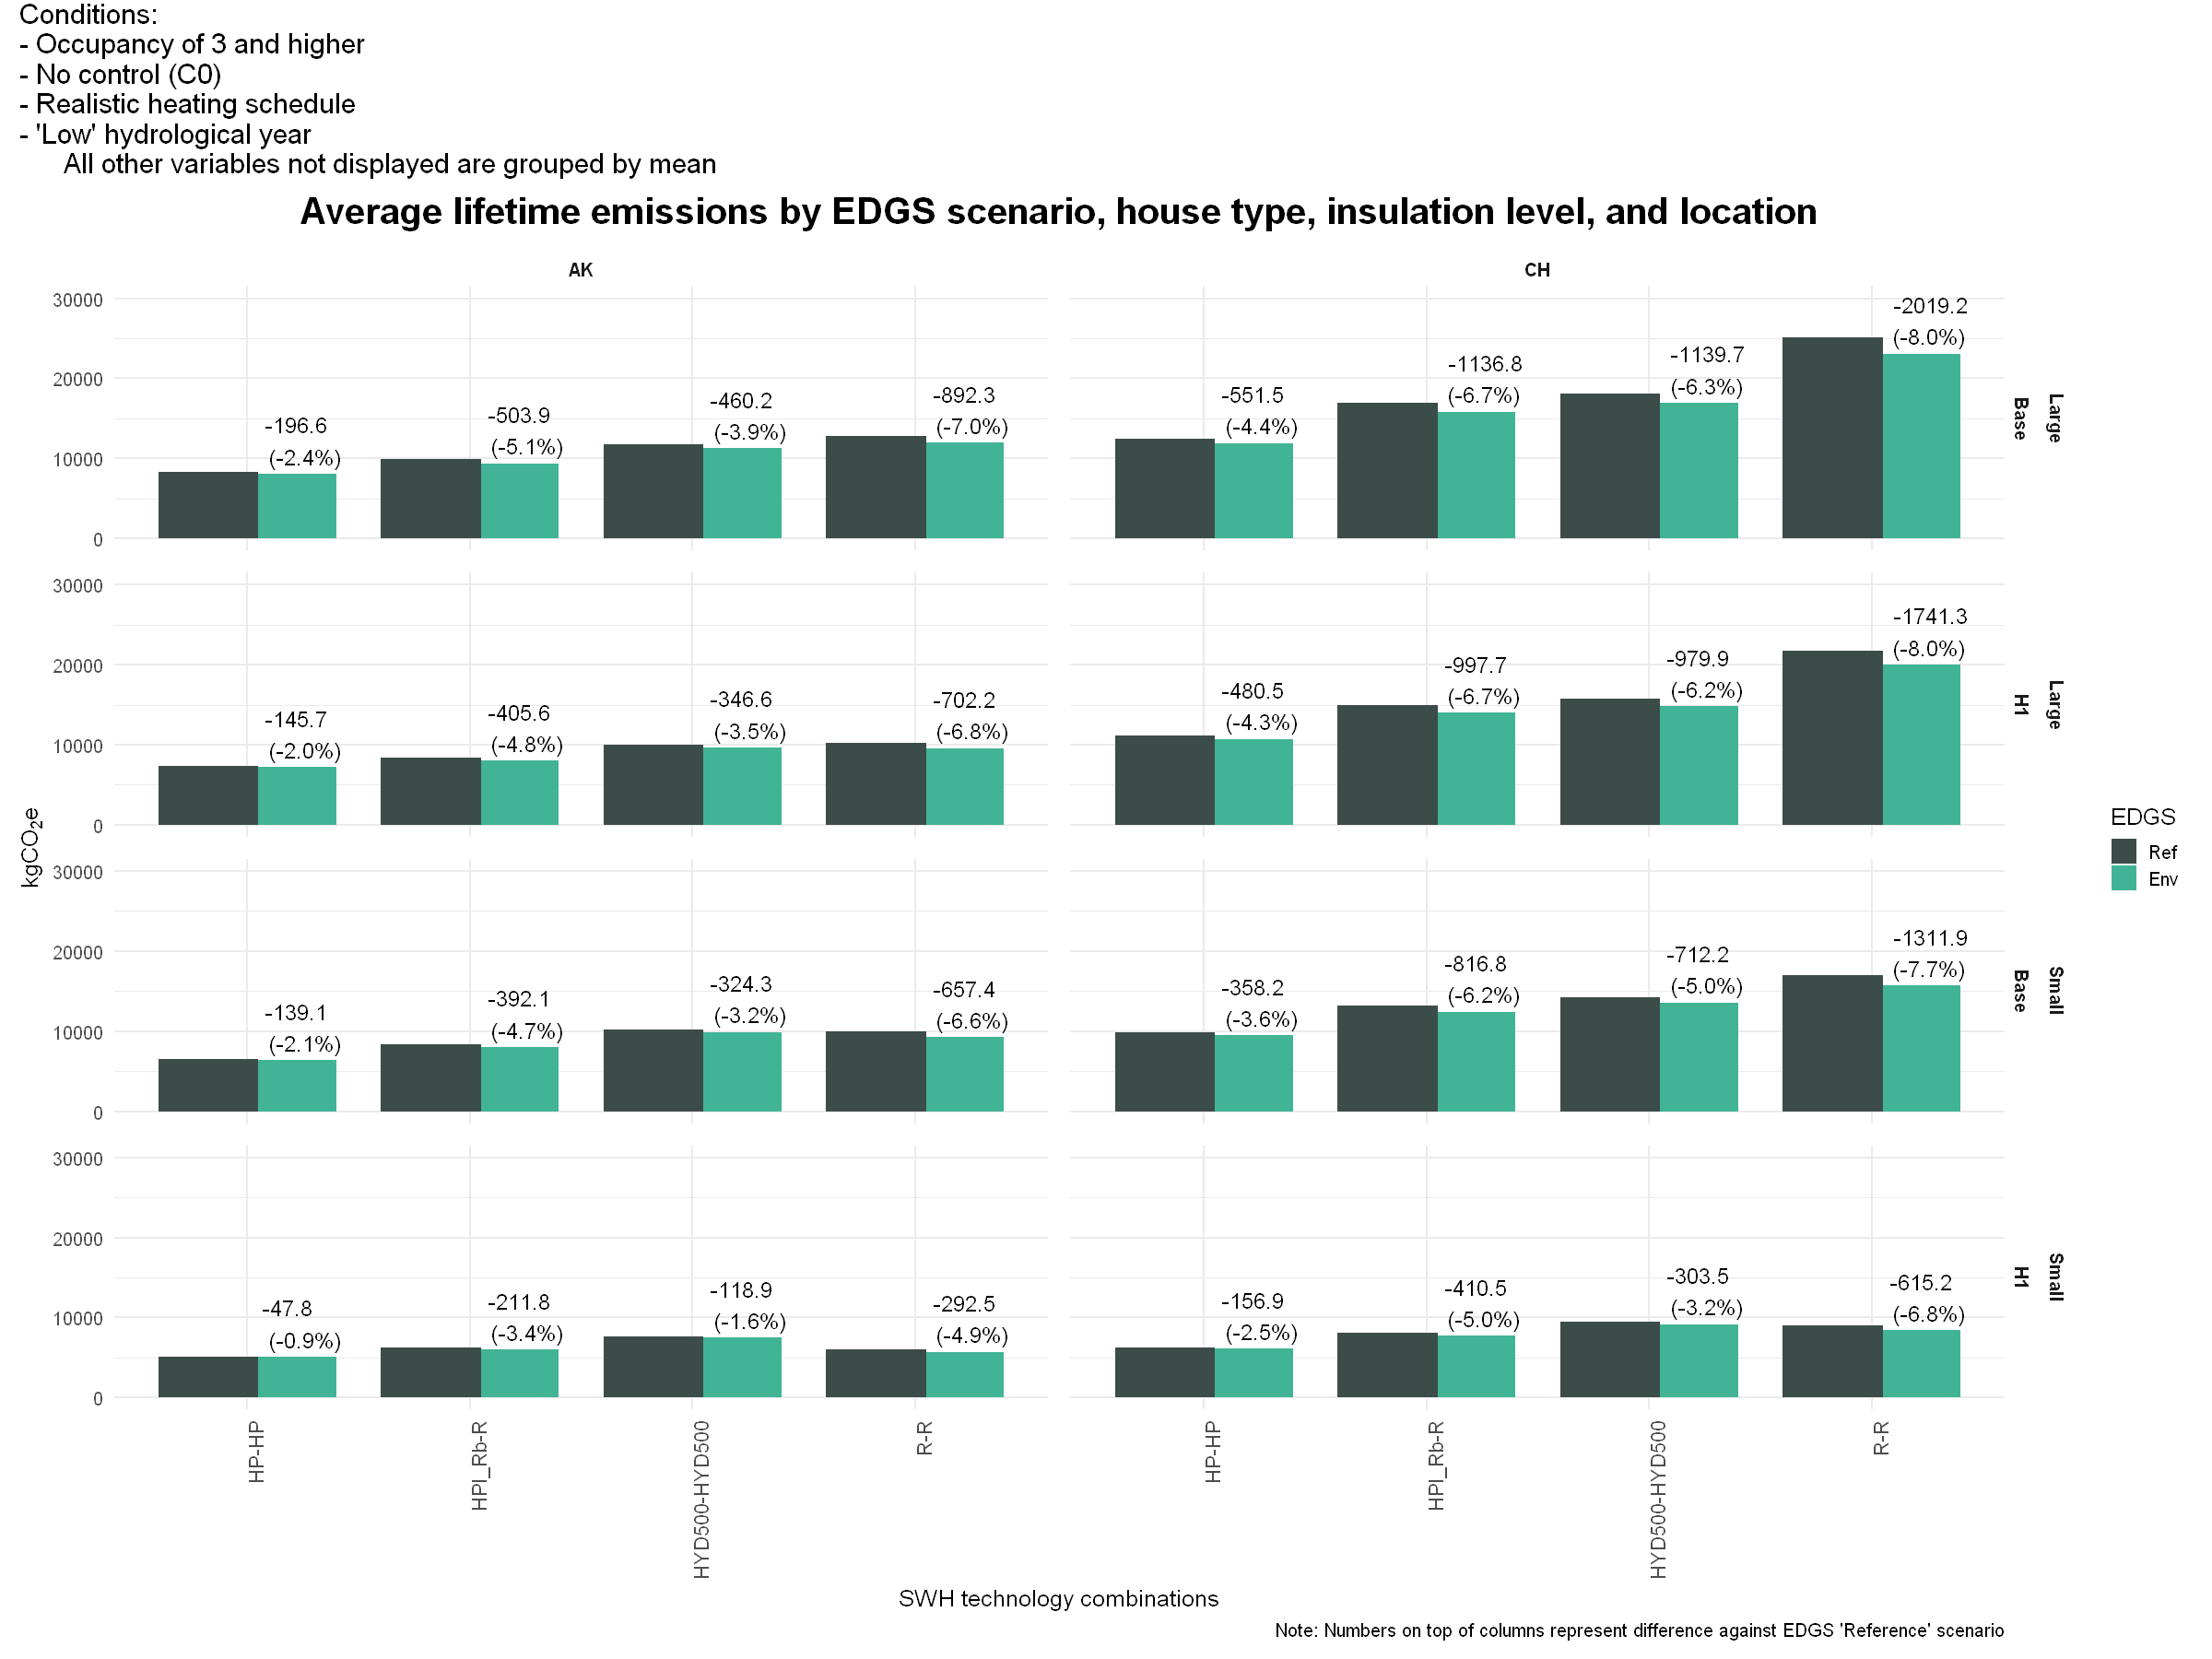

In [42]:
life_edgs_plot <-household_lifetime_edgs_diff %>%
  mutate(EDGS = factor(EDGS, levels = c('Ref','Env'))) %>%  
  ggplot(aes(x = SH_DW_code, 
             y = Total, 
             fill = EDGS)) + 
  # Use position_stack() inside position_dodge2() to combine the two
  geom_col(position = position_dodge(width = 0.7)) +
  scale_y_continuous(limits = c(0, 30000)) +
  geom_text(
    aes(label = ifelse(!is.na(diff_a) & EDGS == 'Env', sprintf("%.1f\n(%.1f%%)", diff_a,diff_p), "")),
    size = 5,
    color = "black",
    hjust = -0.3,
    vjust = -0.2  
  ) +
  scale_fill_manual(values = c("Ref" = '#3c4c49', "Env" = '#41b496')) +
  facet_grid(house_type + insulation ~ Loc_code) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH technology combinations",
       y = expression(kgCO[2]*e),
       title = "Average lifetime emissions by EDGS scenario, house type, insulation level, and location",
       caption = "Note: Numbers on top of columns represent difference against EDGS 'Reference' scenario") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, size = 13), # Changed hjust to 1 for better angled labels
    strip.text = element_text(face = "bold"),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 24, face = "bold", hjust = 0.5, vjust = 2)  
  )

life_edgs_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- No control (C0)\n- Realistic heating schedule\n- 'Low' hydrological year
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

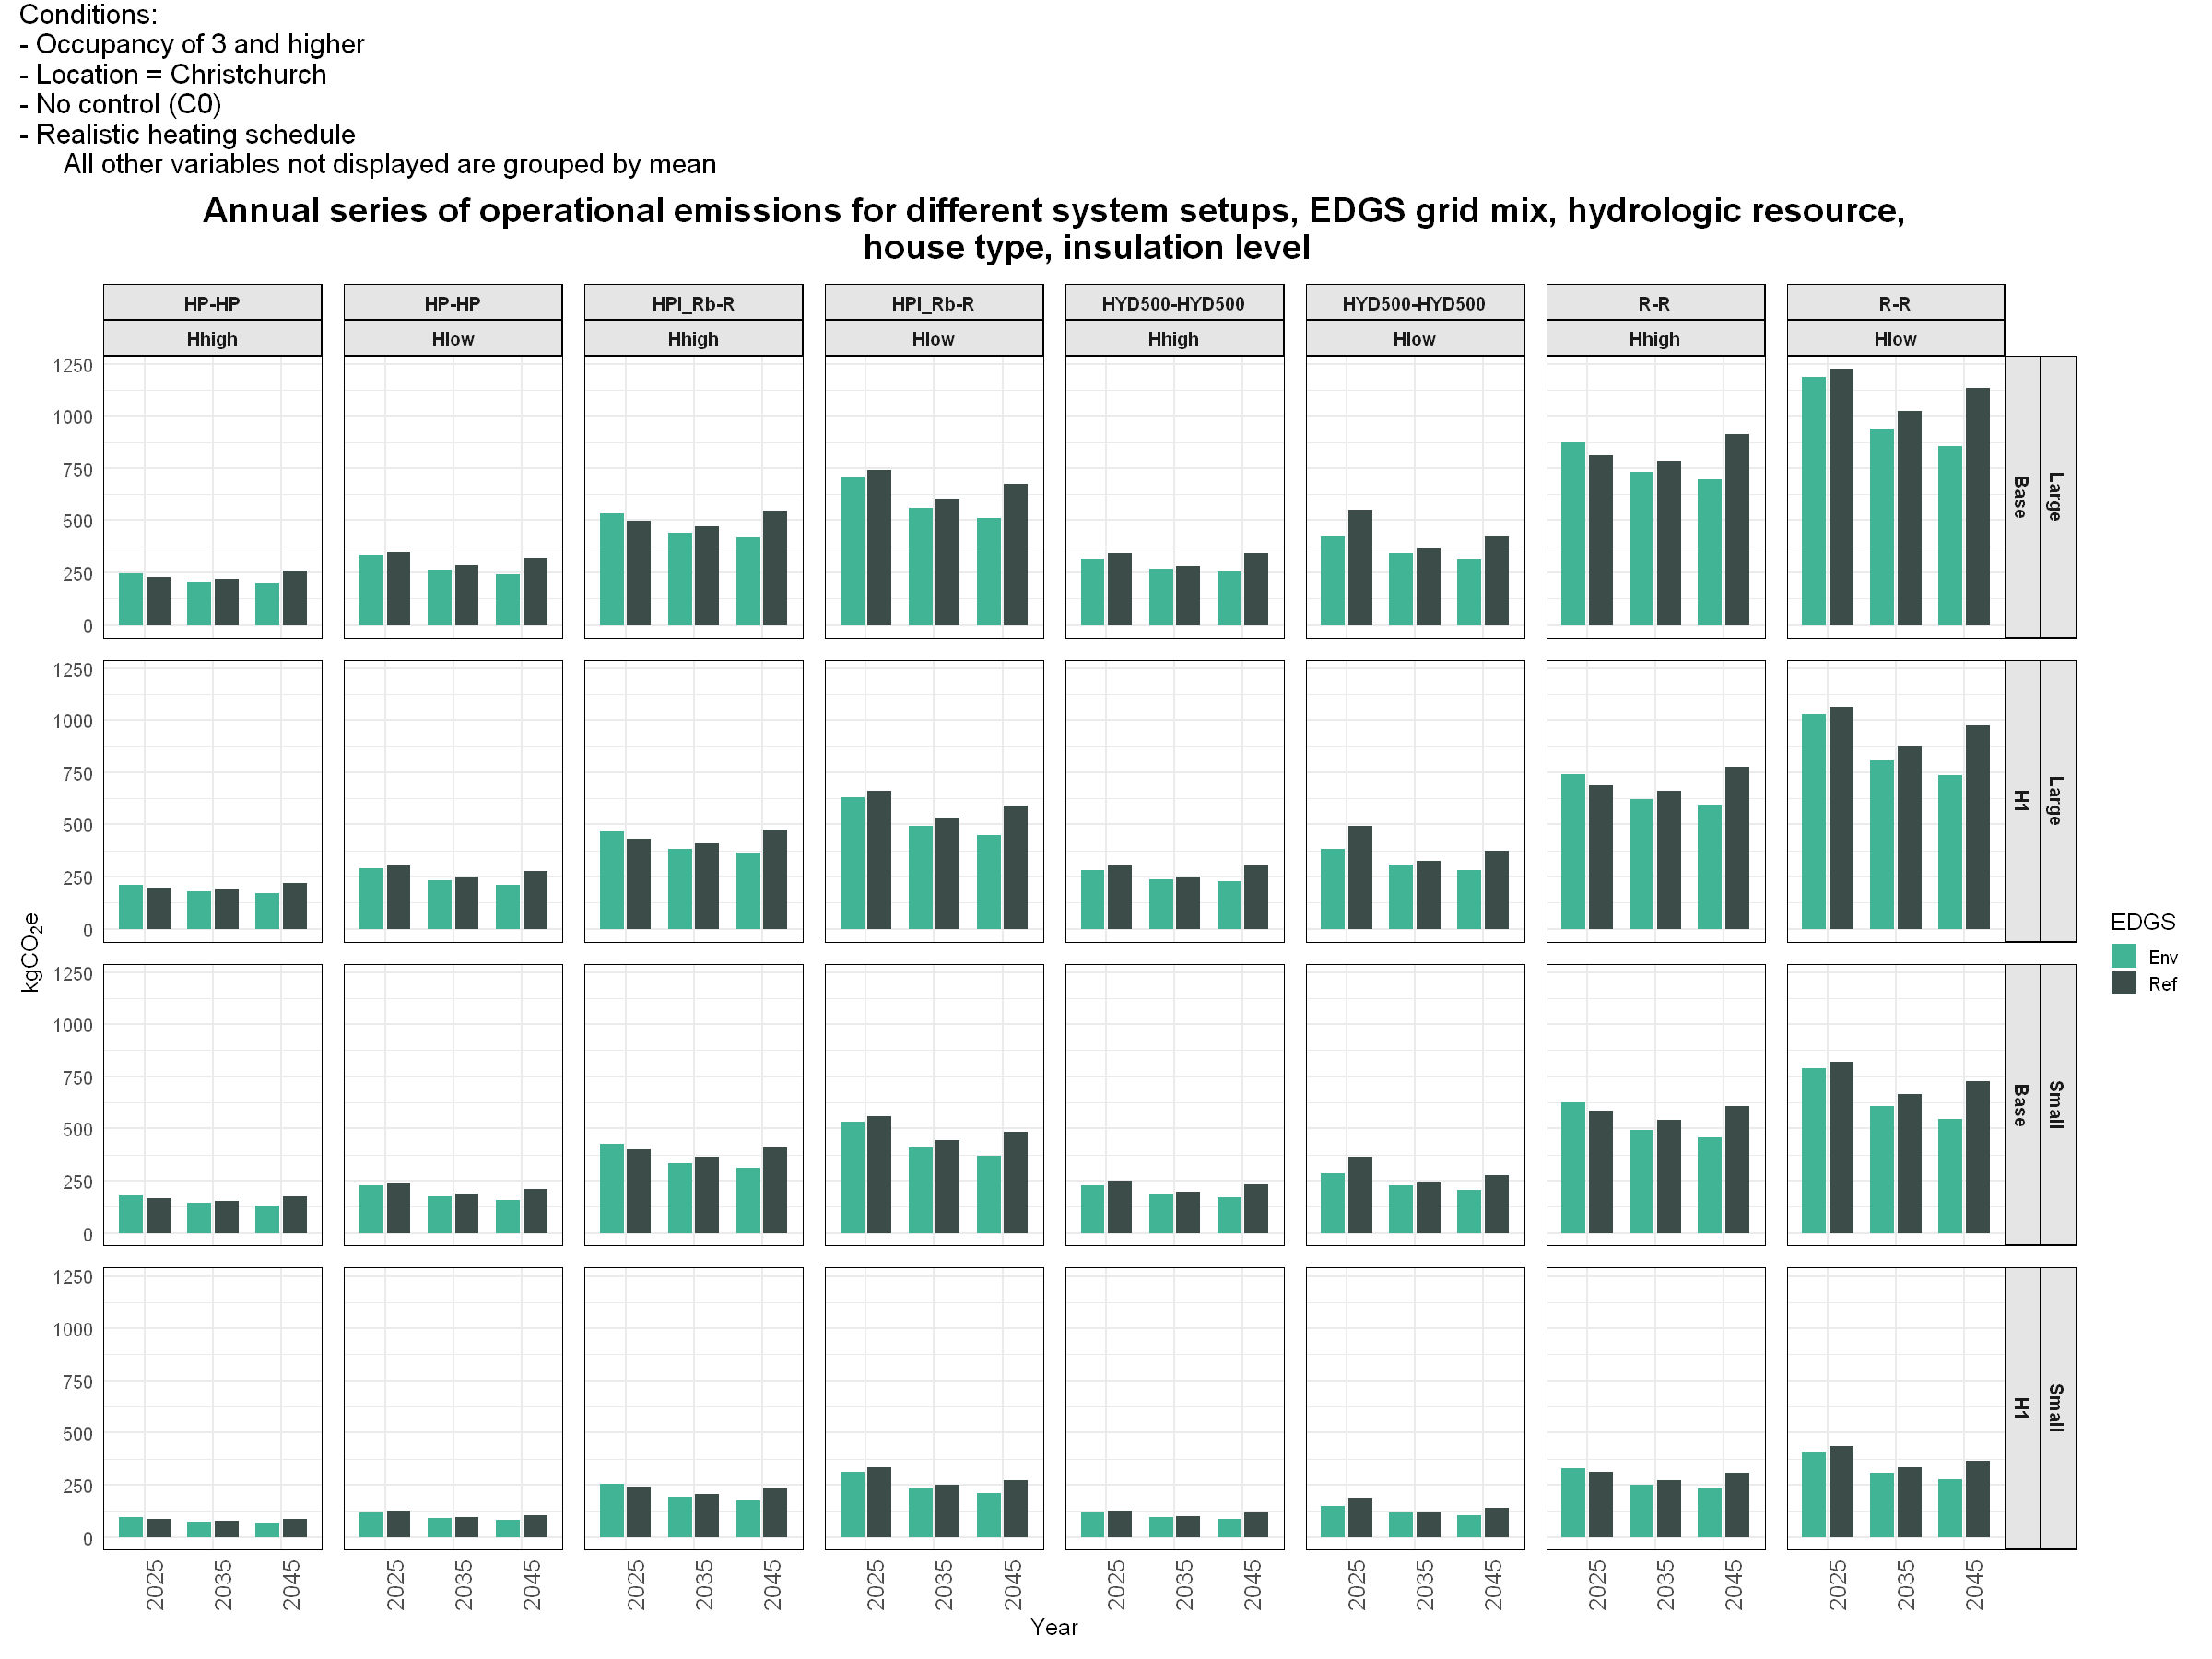

In [43]:
intensity_plot <- household_annual_summary_long %>% 
  filter(Type == 'Operation_annual') %>%
  filter(year %in% c(2025,2035,2045)) %>%
  ggplot(aes(x = factor(year), y = Emissions, fill = EDGS)) +
  geom_col(width = 0.7, position = position_dodge(width = 0.8)) +
  scale_fill_manual(values = c("Ref" = '#3c4c49', "Env" = '#41b496')) +
  scale_x_discrete(breaks = c("2025", "2035", "2045")) +
  facet_grid(house_type + insulation ~ SH_DW_code + Hydro_resource) +
  theme_minimal(base_size = 15) +
  labs(x = "Year",
       y = expression(kgCO[2]*e),
       title = "Annual series of operational emissions for different system setups, EDGS grid mix, hydrologic resource,
       house type, insulation level") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    strip.text = element_text(face = "bold"),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5, vjust = 2)  
  )

intensity_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- Location = Christchurch\n- No control (C0)\n- Realistic heating schedule
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

In [44]:
technology_lifetime_Call_DW <- technology_lifetime_Call %>% 
  filter(!is.na(DW_code)) %>% 
  filter(DW_code %in% c("HP", "HPo")) %>%  
  filter(CS_code != 'Cpeak') %>%
  #filter(Hydro_resource == 'Hhigh') %>%
  filter(Loc_code == 'CH') %>%  
  group_by(DW_code, Loc_code, Occ_code, HP_cap,`Tank_Volume (L)`, CS_code, Hydro_resource) %>% 
  summarise(kgCO2 = mean(kgCO2_oper_life),
            kWh = mean(P_annual_kWh_life)) %>% 
  suppressMessages() %>%
  ungroup() %>%
  mutate(kgCO2_per_kWh = kgCO2/kWh) 
# Calculate base case emissions
technology_lifetime_Call_DW_base <- technology_lifetime_Call_DW %>%
  filter(CS_code == 'C0') %>%
  select(Loc_code, DW_code, Occ_code, HP_cap, `Tank_Volume (L)`, Hydro_resource, kgCO2_C0 = kgCO2)
# Join base emissions onto all CS_code values
technology_lifetime_Call_DW_diff <- technology_lifetime_Call_DW %>%
  left_join(technology_lifetime_Call_DW_base, by = c("Loc_code", "DW_code", "Occ_code", "HP_cap", "Tank_Volume (L)", 'Hydro_resource')) %>%
  mutate(diff_p = 100*(kgCO2 - kgCO2_C0)/kgCO2,
         diff_a = kgCO2 - kgCO2_C0
        )

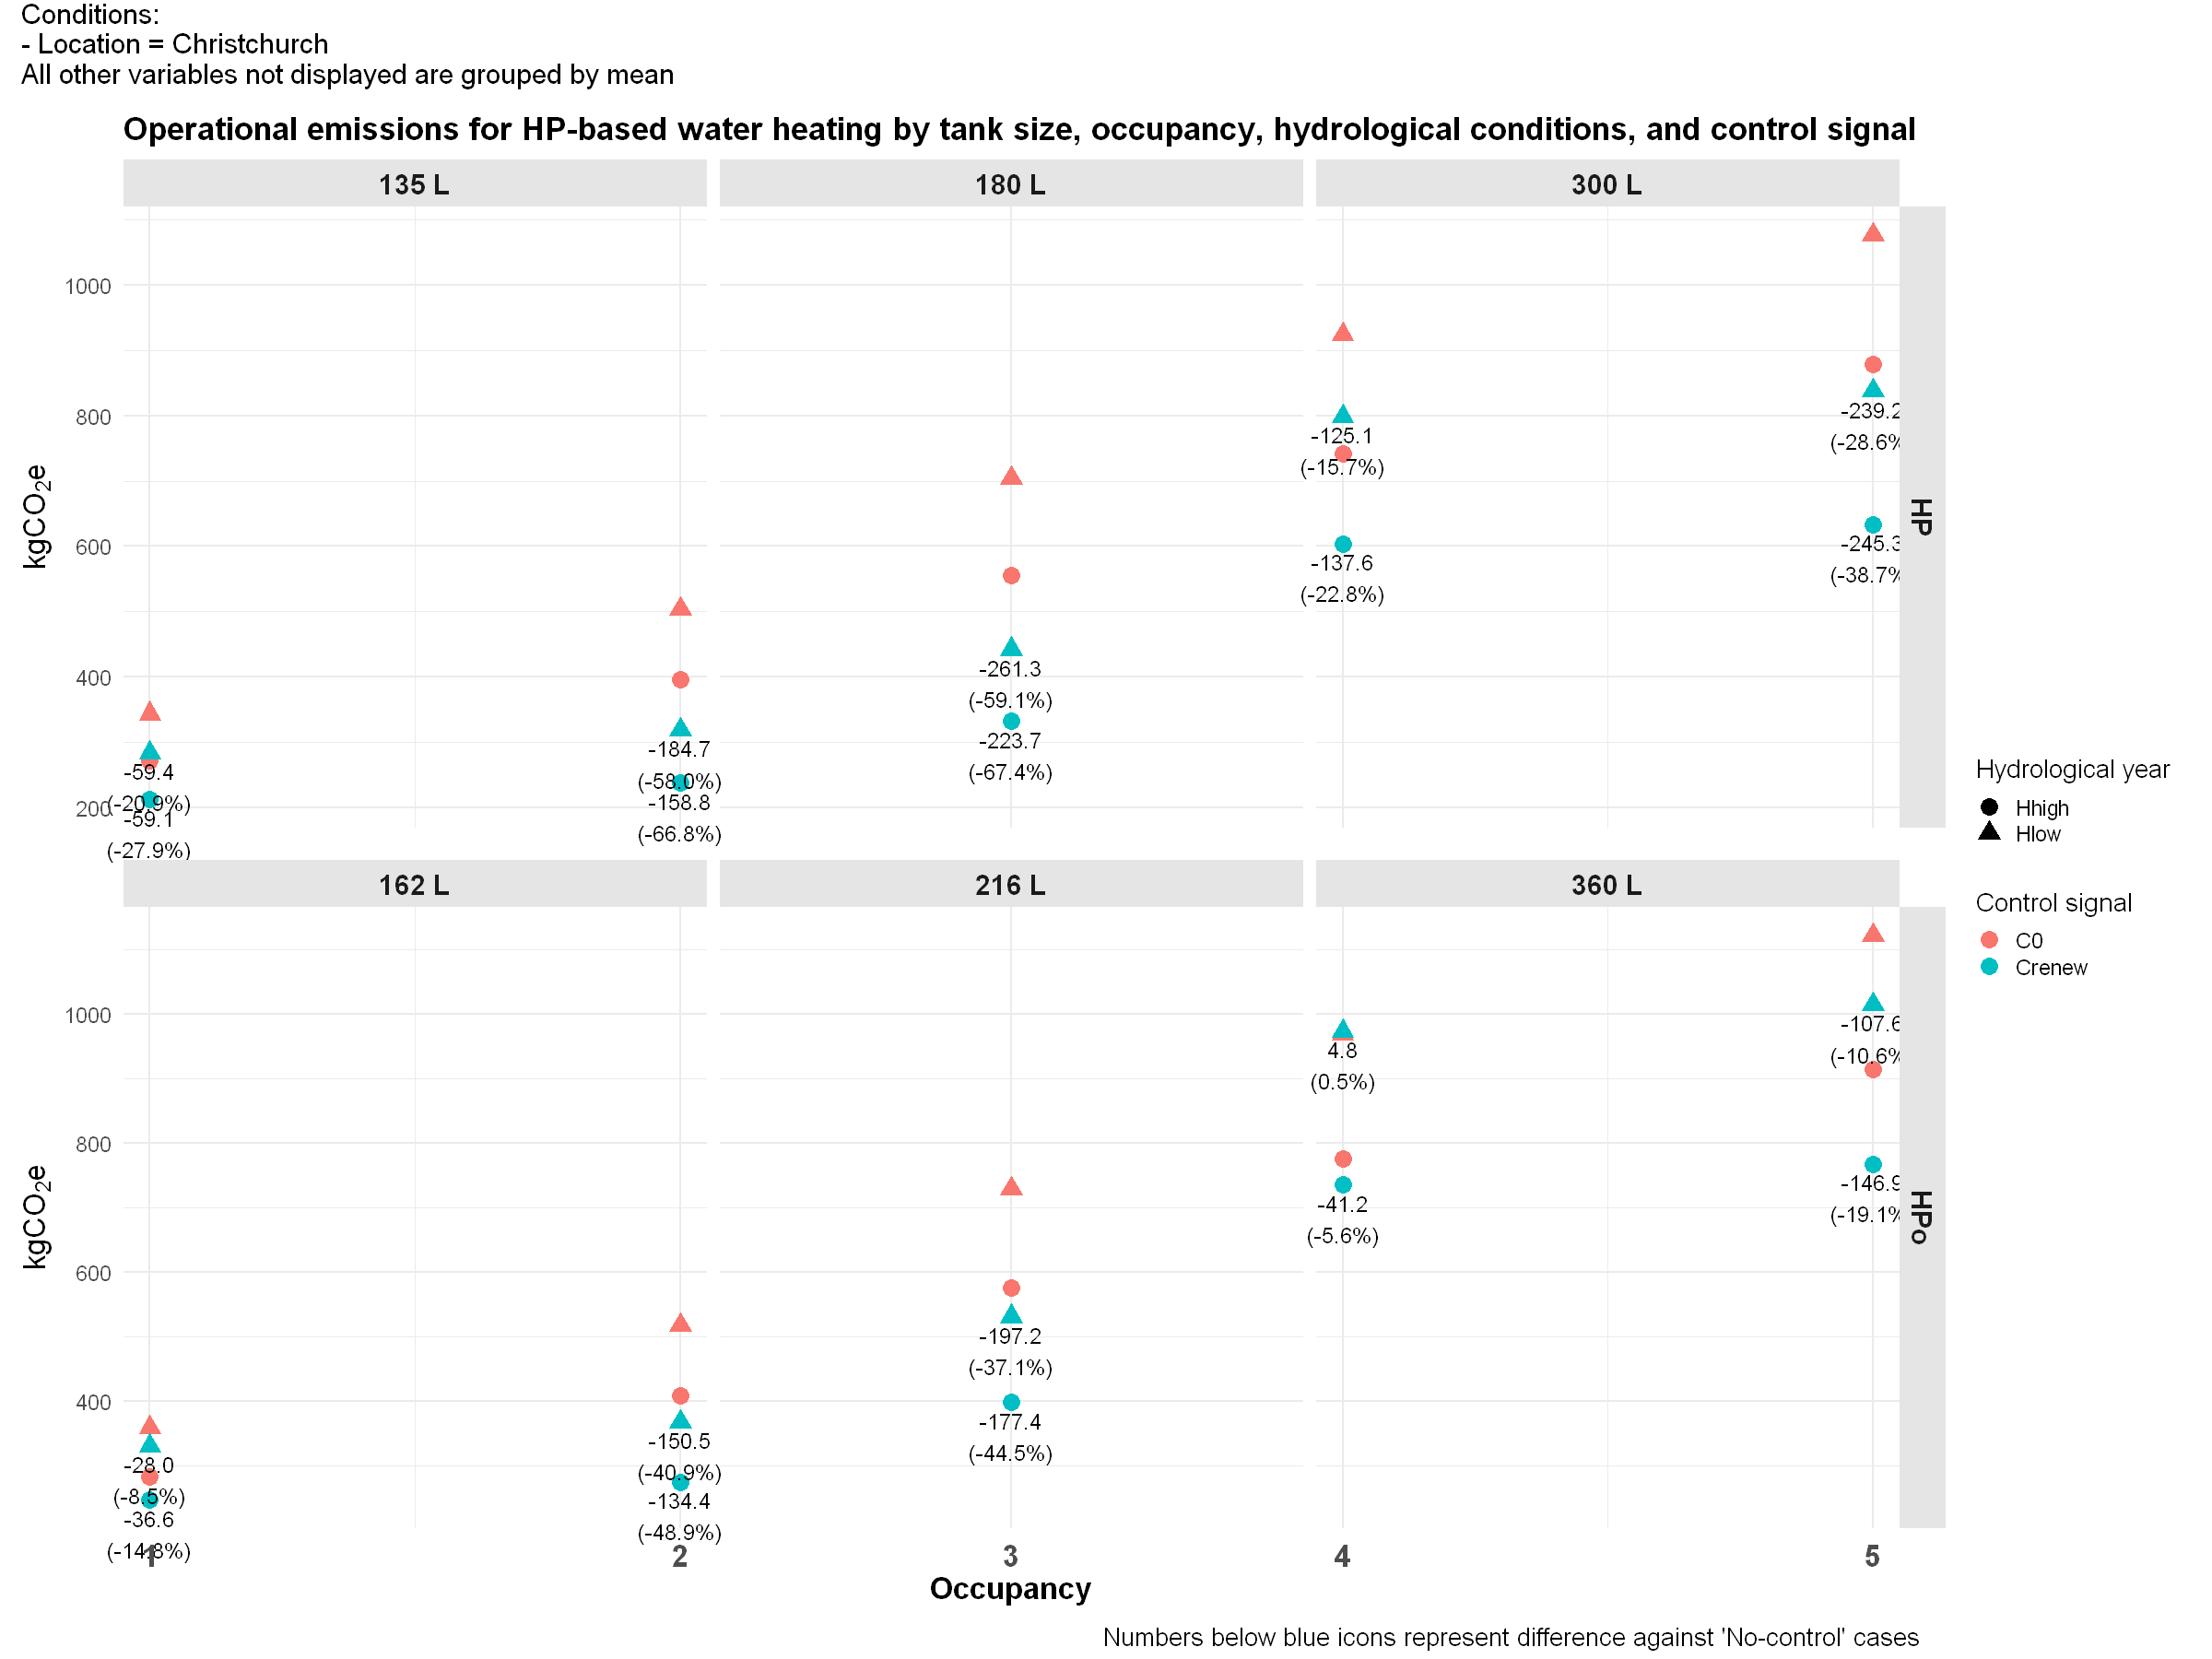

In [45]:
df_HP  <- technology_lifetime_Call_DW_diff %>% filter(DW_code == 'HP')  %>%
  mutate(Tank_Label = paste0(`Tank_Volume (L)`, " L"))
df_HPo <- technology_lifetime_Call_DW_diff %>% filter(DW_code == 'HPo') %>%
  mutate(Tank_Label = paste0(`Tank_Volume (L)`, " L"))

plot_HP <- ggplot(df_HP, aes(x = as.integer(Occ_code), y = kgCO2)) + 
  geom_point(aes(color = CS_code, shape = Hydro_resource), size = 5) + 
  geom_text(
    aes(label = ifelse(!is.na(diff) & CS_code == 'Crenew', sprintf("%.1f\n(%.1f%%)", diff_a, diff_p), "")),
    vjust = 1.2,
    size = 5,
    color = "black"
  ) +
  facet_grid(DW_code ~ Tank_Label, scales = "free_x", drop = TRUE) +
  scale_x_continuous(breaks = unique(as.integer(df_HP$Occ_code))) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 20, face = 'bold'),    
    strip.background = element_rect(fill = "grey90", color = NA),
    axis.text.x = element_blank(), 
    axis.ticks.x = element_blank(),
    strip.text = element_text(face = "bold", size=18),
    plot.title =  element_text(face = "bold", size=21)  
  ) +
  labs(title = 'Operational emissions for HP-based water heating by tank size, occupancy, hydrological conditions, and control signal')   

plot_HPo <- ggplot(df_HPo, aes(x = as.integer(Occ_code), y = kgCO2)) + 
  geom_point(aes(color = CS_code, shape = Hydro_resource), size = 5) + 
  geom_text(
    aes(label = ifelse(!is.na(diff) & CS_code == 'Crenew', sprintf("%.1f\n(%.1f%%)", diff_a, diff_p), "")),
    vjust = 1.2,
    size = 5,
    color = "black"
  ) +
  facet_grid(DW_code ~ Tank_Label, scales = "free_x", drop = TRUE) +
  scale_x_continuous(breaks = unique(as.integer(df_HPo$Occ_code))) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.title.x = element_text(size = 20, face = 'bold'),
    axis.text.x = element_text(size = 20, face = 'bold', vjust=0.5),  
    axis.title.y = element_text(size = 20, face = 'bold'),  
    strip.background = element_rect(fill = "grey90", color = NA),
    strip.text = element_text(face = "bold", size=18)
    )

(plot_HP / plot_HPo) +
  plot_layout(guides = "collect") &
  labs(x = "Occupancy", y = expression(kgCO[2]*e),
      color = "Control signal", shape = 'Hydrological year') &
  plot_annotation(
    title = "Conditions:\n- Location = Christchurch\nAll other variables not displayed are grouped by mean",
    caption = "Numbers below blue icons represent difference against 'No-control' cases",  
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2),
      plot.caption = element_text(size = 16, hjust = 0.8)
    )
  )  

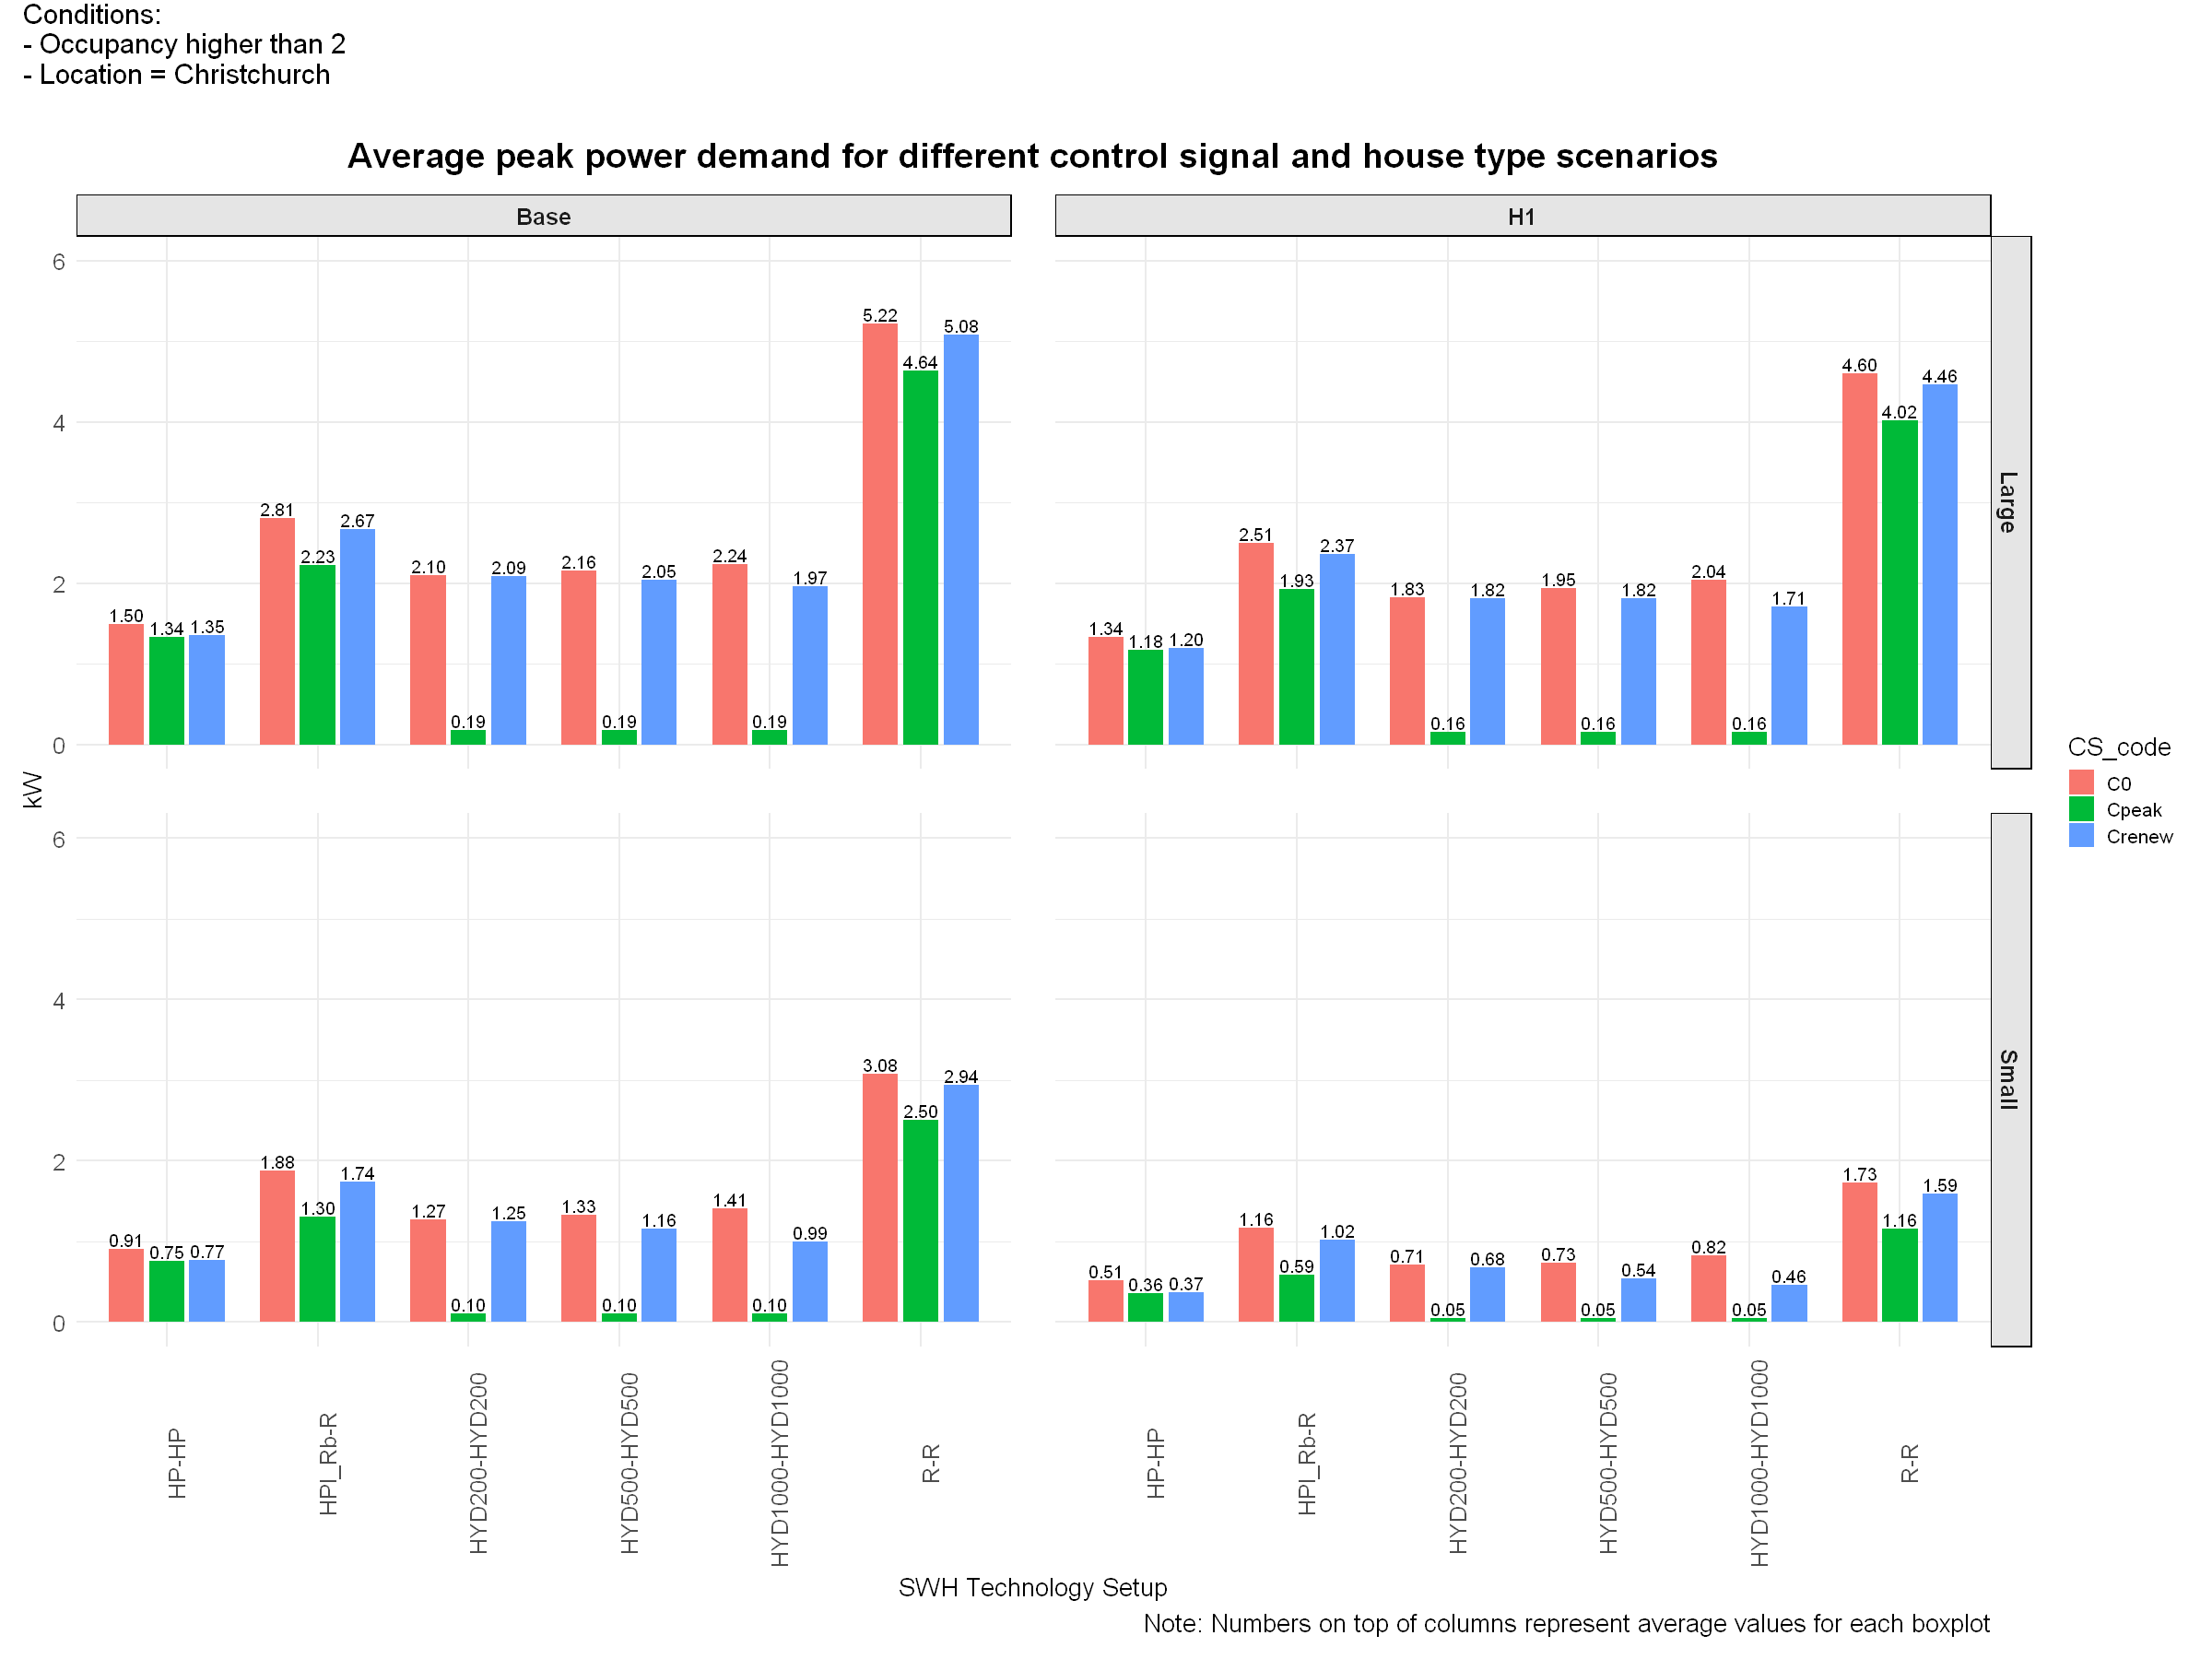

In [46]:
max_y <- max(household_lifetime_Call_CS_power$P_avg_peak_kW_year, na.rm = TRUE)
options(repr.plot.width=20, repr.plot.height=15)
main_plot <- household_lifetime_Call_CS_power %>%
  group_by(house_type,insulation,CS_code,SH_DW_code) %>%
  summarise(P_avg_peak_kW_year = mean(P_avg_peak_kW_year), .groups = "drop") %>%
  ggplot(aes(x = SH_DW_code, y = P_avg_peak_kW_year, fill = CS_code)) +
  geom_col(width = 0.7,  position = position_dodge(width = 0.8)) +
  scale_y_continuous(limits = c(0, 1.1 * max_y)) +   
  geom_text(
    aes(label = sprintf("%.2f", P_avg_peak_kW_year), group = CS_code),
    vjust = -0.2, 
    size = 4,
    color = "black",
    position = position_dodge(width = 0.8)  
  ) +
  facet_grid(house_type ~ insulation) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.margin = margin(t = 30, r = 10, b = 10, l = 10),
    plot.caption = element_text(size = 16),
    plot.title = element_text(size = 23, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
    labs(caption = "Note: Numbers on top of columns represent average values for each boxplot",
        x = "SWH Technology Setup",
        y = "kW",
        title = "Average peak power demand for different control signal and house type scenarios")
main_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy higher than 2\n- Location = Christchurch",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

In [47]:
household_lifetime_Call_all <- household_lifetime_Call %>% filter(Occ_code == 3) %>%
group_by(Loc_code, house_type, insulation, SH_DW_code, CS_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), 
            Embodied_MJ = mean(Embodied_life_MJ),
            Operation_MJ = mean(P_annual_kWh_life/0.278),
            .groups = 'drop') %>% ungroup() %>%
  mutate(Total_kgCO2e = Embodied + Operation,
        Total_MJ = Embodied_MJ + Operation_MJ)
# Read results of reduction in embedded emissions from peak reduction
peak_power_embedded <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/aggregate_peak_embedded.csv") %>% 
    suppressMessages()
# Reshape data to long format for ggplot2 and join embedded results
plot_all <- household_lifetime_Call_all %>%
    pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions") %>%
    left_join(peak_power_embedded,  by = c("SH_DW_code", "Loc_code", "house_type", "insulation", "CS_code")) %>%
    mutate(Emissions_adj = ifelse(!is.na(Reduction_kgCO2e) & Type == 'Embodied', Emissions - Reduction_kgCO2e, Emissions))
 

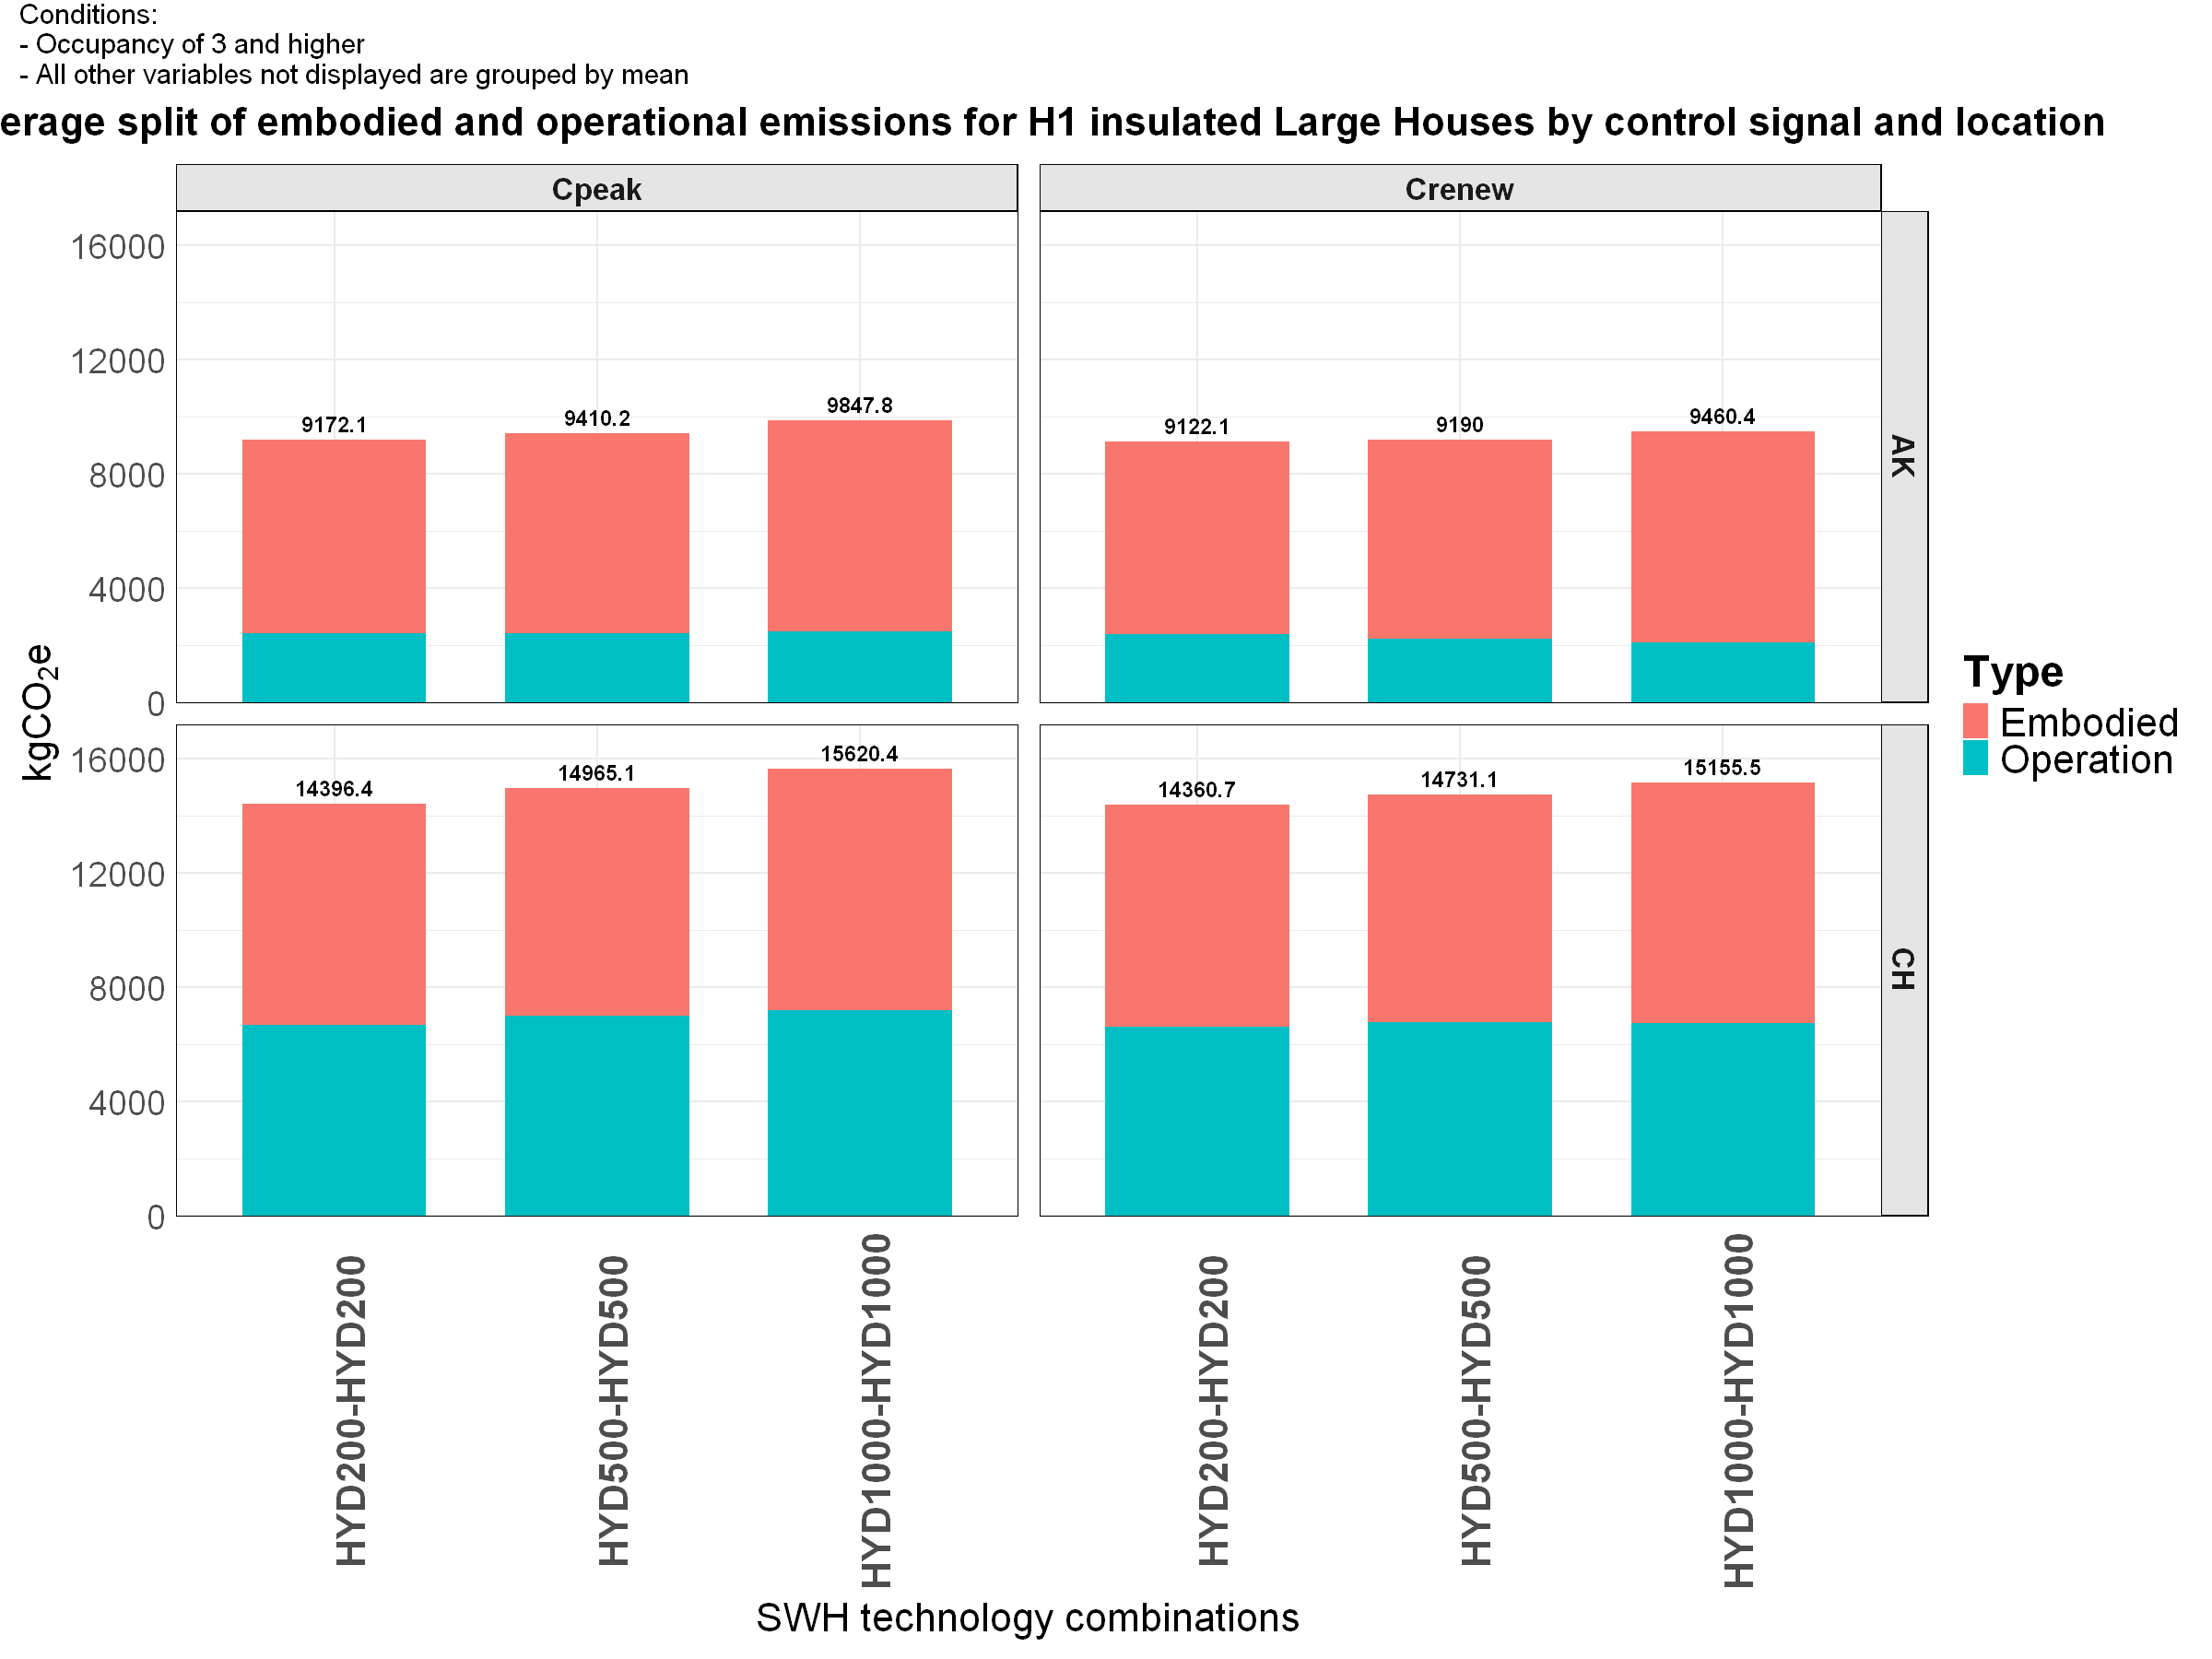

In [48]:
options(repr.plot.width=20, repr.plot.height=15)

# First, calculate the total emissions for each facet group
emissions_totals <- plot_all %>%
  filter(SH_DW_code %in% c('HYD200-HYD200','HYD500-HYD500','HYD1000-HYD1000')) %>%  
  mutate(SH_DW_code = factor(SH_DW_code, levels = c("HYD200-HYD200", "HYD500-HYD500", "HYD1000-HYD1000"))) %>%  
  filter(house_type == 'Large') %>%
  filter(insulation == 'H1') %>%  
  filter(CS_code != 'C0') %>%
  group_by(SH_DW_code, Loc_code, CS_code) %>%
  summarize(total_emissions = sum(Emissions), .groups = 'drop')

emissions_plot_all <- plot_all %>%
  filter(SH_DW_code %in% c('HYD200-HYD200','HYD500-HYD500','HYD1000-HYD1000')) %>%  
  mutate(SH_DW_code = factor(SH_DW_code, levels = c("HYD200-HYD200", "HYD500-HYD500", "HYD1000-HYD1000"))) %>%  
  filter(house_type == 'Large') %>%
  filter(insulation == 'H1') %>%  
  filter(CS_code != 'C0') %>%
  ggplot(aes(x = SH_DW_code, y = Emissions, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  geom_text(data = emissions_totals, 
            aes(x = SH_DW_code, y = total_emissions, 
                label = round(total_emissions, 1)),
            inherit.aes = FALSE,  # Important: don't inherit aesthetics from main plot
            vjust = -0.5, size = 5, fontface = "bold") +
  facet_grid(Loc_code ~ CS_code) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH technology combinations",
       y = expression(kgCO[2]*e),
       title = "Average split of embodied and operational emissions for H1 insulated Large Houses by control signal and location") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26, face = 'bold'),
    axis.title.x = element_text(size = 26),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 28, face = "bold"),
    legend.text = element_text(size = 26), 
    strip.text = element_text(face = "bold", size = 20),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 26, face = "bold", hjust = 0.5, vjust = 2)
  ) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1))) # Add space for labels

emissions_plot_all + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3 and higher\n- All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

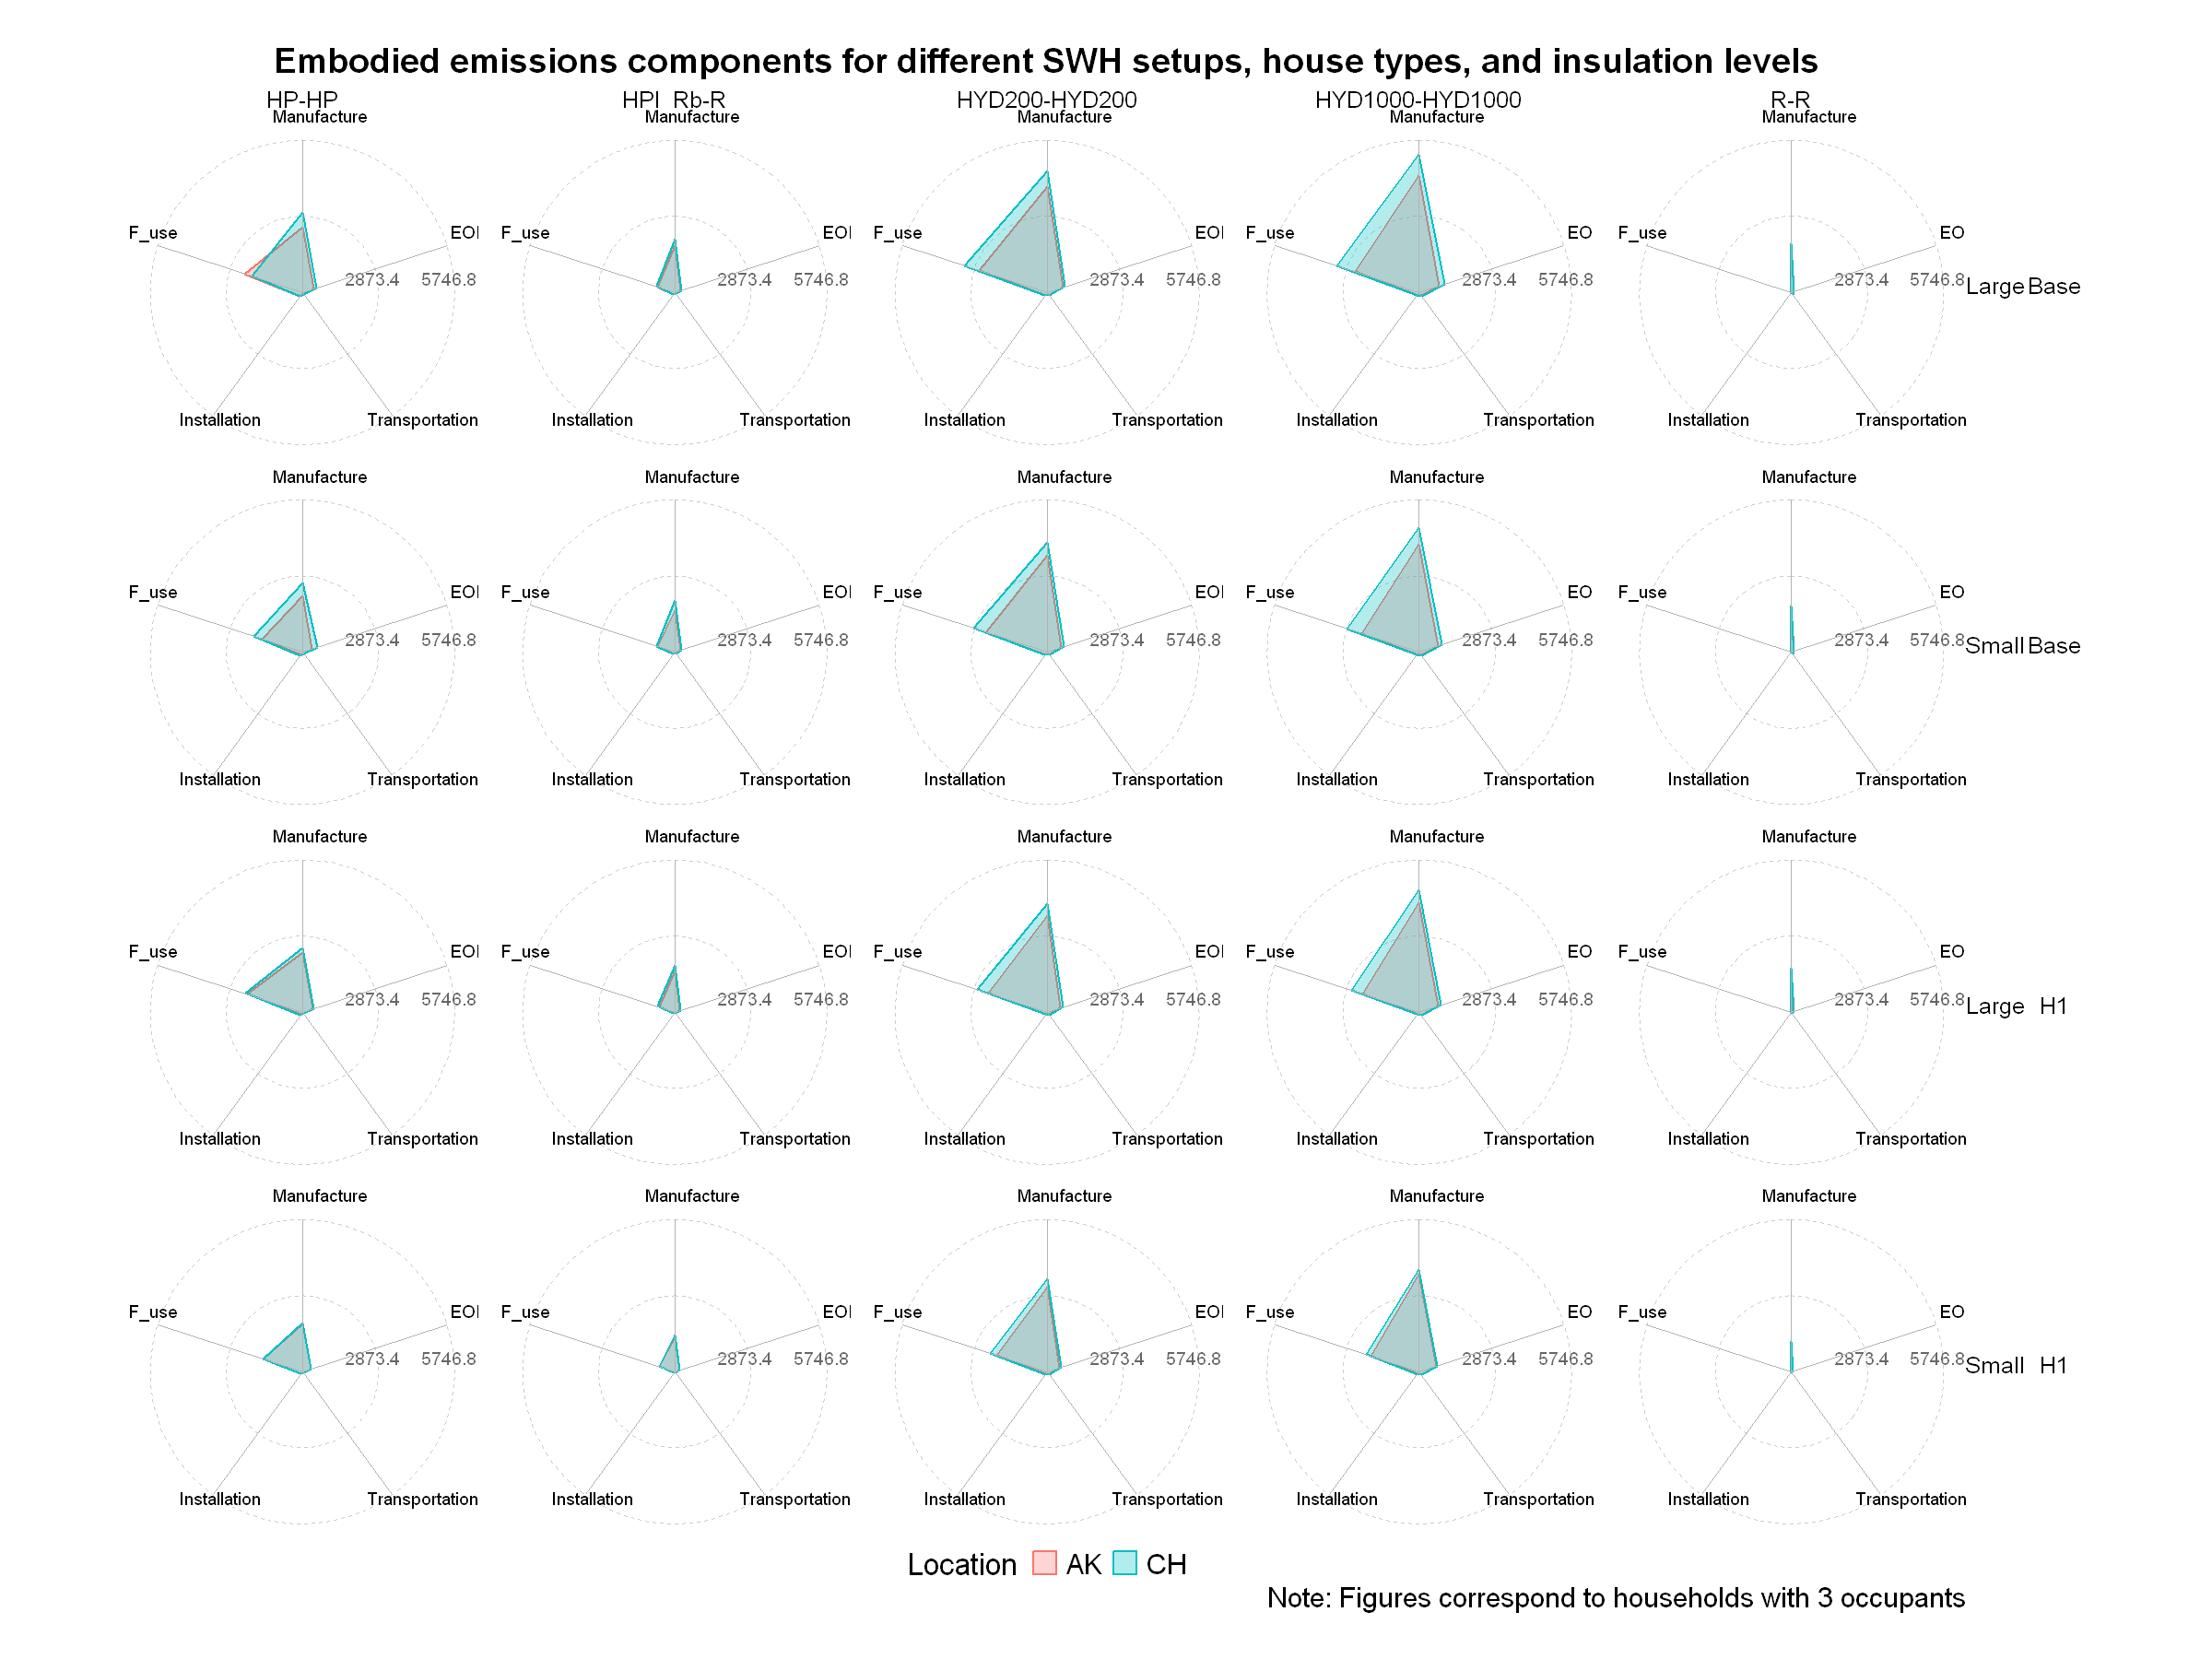

In [49]:
common_max <- max(radar_long_CO2$Value) * 1.1  # 10% padding
mid_value <- common_max / 2
n_vars <- nlevels(radar_long_CO2$Lifecycle_Stage)
angles <- seq(0, 2*pi, length.out = n_vars + 1)[-(n_vars + 1)]  # Remove duplicate 360°

radar_CO2 <- ggplot() +
  # Background scale circles
  geom_path(
    data = scale_circles_CO2,
    aes(x = x, y = y, group = value),
    color = "gray80",
    linetype = "dashed",
    size = 0.3
  ) +
  # Scale value labels
  geom_text(
    data = scale_circles_CO2 %>% 
      filter(angle == 0) %>%
      distinct(value, label),
    aes(x = value, y = 0, label = label),
    hjust = 0.6,
    vjust = -0.5,
    size = 4,
    color = "gray40"
  ) +
  # Filled polygons 
  geom_polygon(
    data = df_polygons_CO2,
    aes(x = x, y = y, 
        group = interaction(Loc_code, house_type, insulation, SH_DW_code),
        fill = Loc_code,
        color = Loc_code),
    alpha = 0.3,  # Transparency
    size = 0.8
  ) +
  # Axis spokes
  geom_segment(
    data = data.frame(
      x = 0, y = 0,
      xend = common_max * sin(angles),
      yend = common_max * cos(angles)
    ),
    aes(x = x, y = y, xend = xend, yend = yend),
    color = "gray70",
    size = 0.3
  ) +
  # Axis labels
  geom_text(
    data = data.frame(
      x = 1.1 * common_max * sin(angles),
      y = 1.1 * common_max * cos(angles),
      label = levels(radar_long_CO2$Lifecycle_Stage)
    ),
    aes(x = x, y = y, label = label),
    hjust = 0.3,
    vjust = -0.2,  
    size = 4
  ) +
  facet_grid(
    rows = vars(insulation, house_type),
    cols = vars(SH_DW_code)
  ) +
  coord_fixed() +
  theme_void() +
  labs(
    title = "Embodied emissions components for different SWH setups, house types, and insulation levels",
    fill = "Location",
    color = "Location",
    caption = "Note: Figures correspond to households with 3 occupants"  
  ) +
  theme(
    legend.position = "bottom",
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 18),  
    strip.text = element_text(size = 15),
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5, vjust = 2),
    plot.caption = element_text(size = 18),
    panel.spacing.x = unit(1, "lines"),   # Increased spacing between facets
    plot.margin = margin(30, 30, 30, 30)  # Add more space around the plot
  )
ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/radar_CO2_plot.png",  # File path
  plot = radar_CO2,                       # Plot object
  width = 24,                             # Width in inches
  height = 16,                             # Height in inches
  dpi = 300                               # Resolution
)
radar_CO2

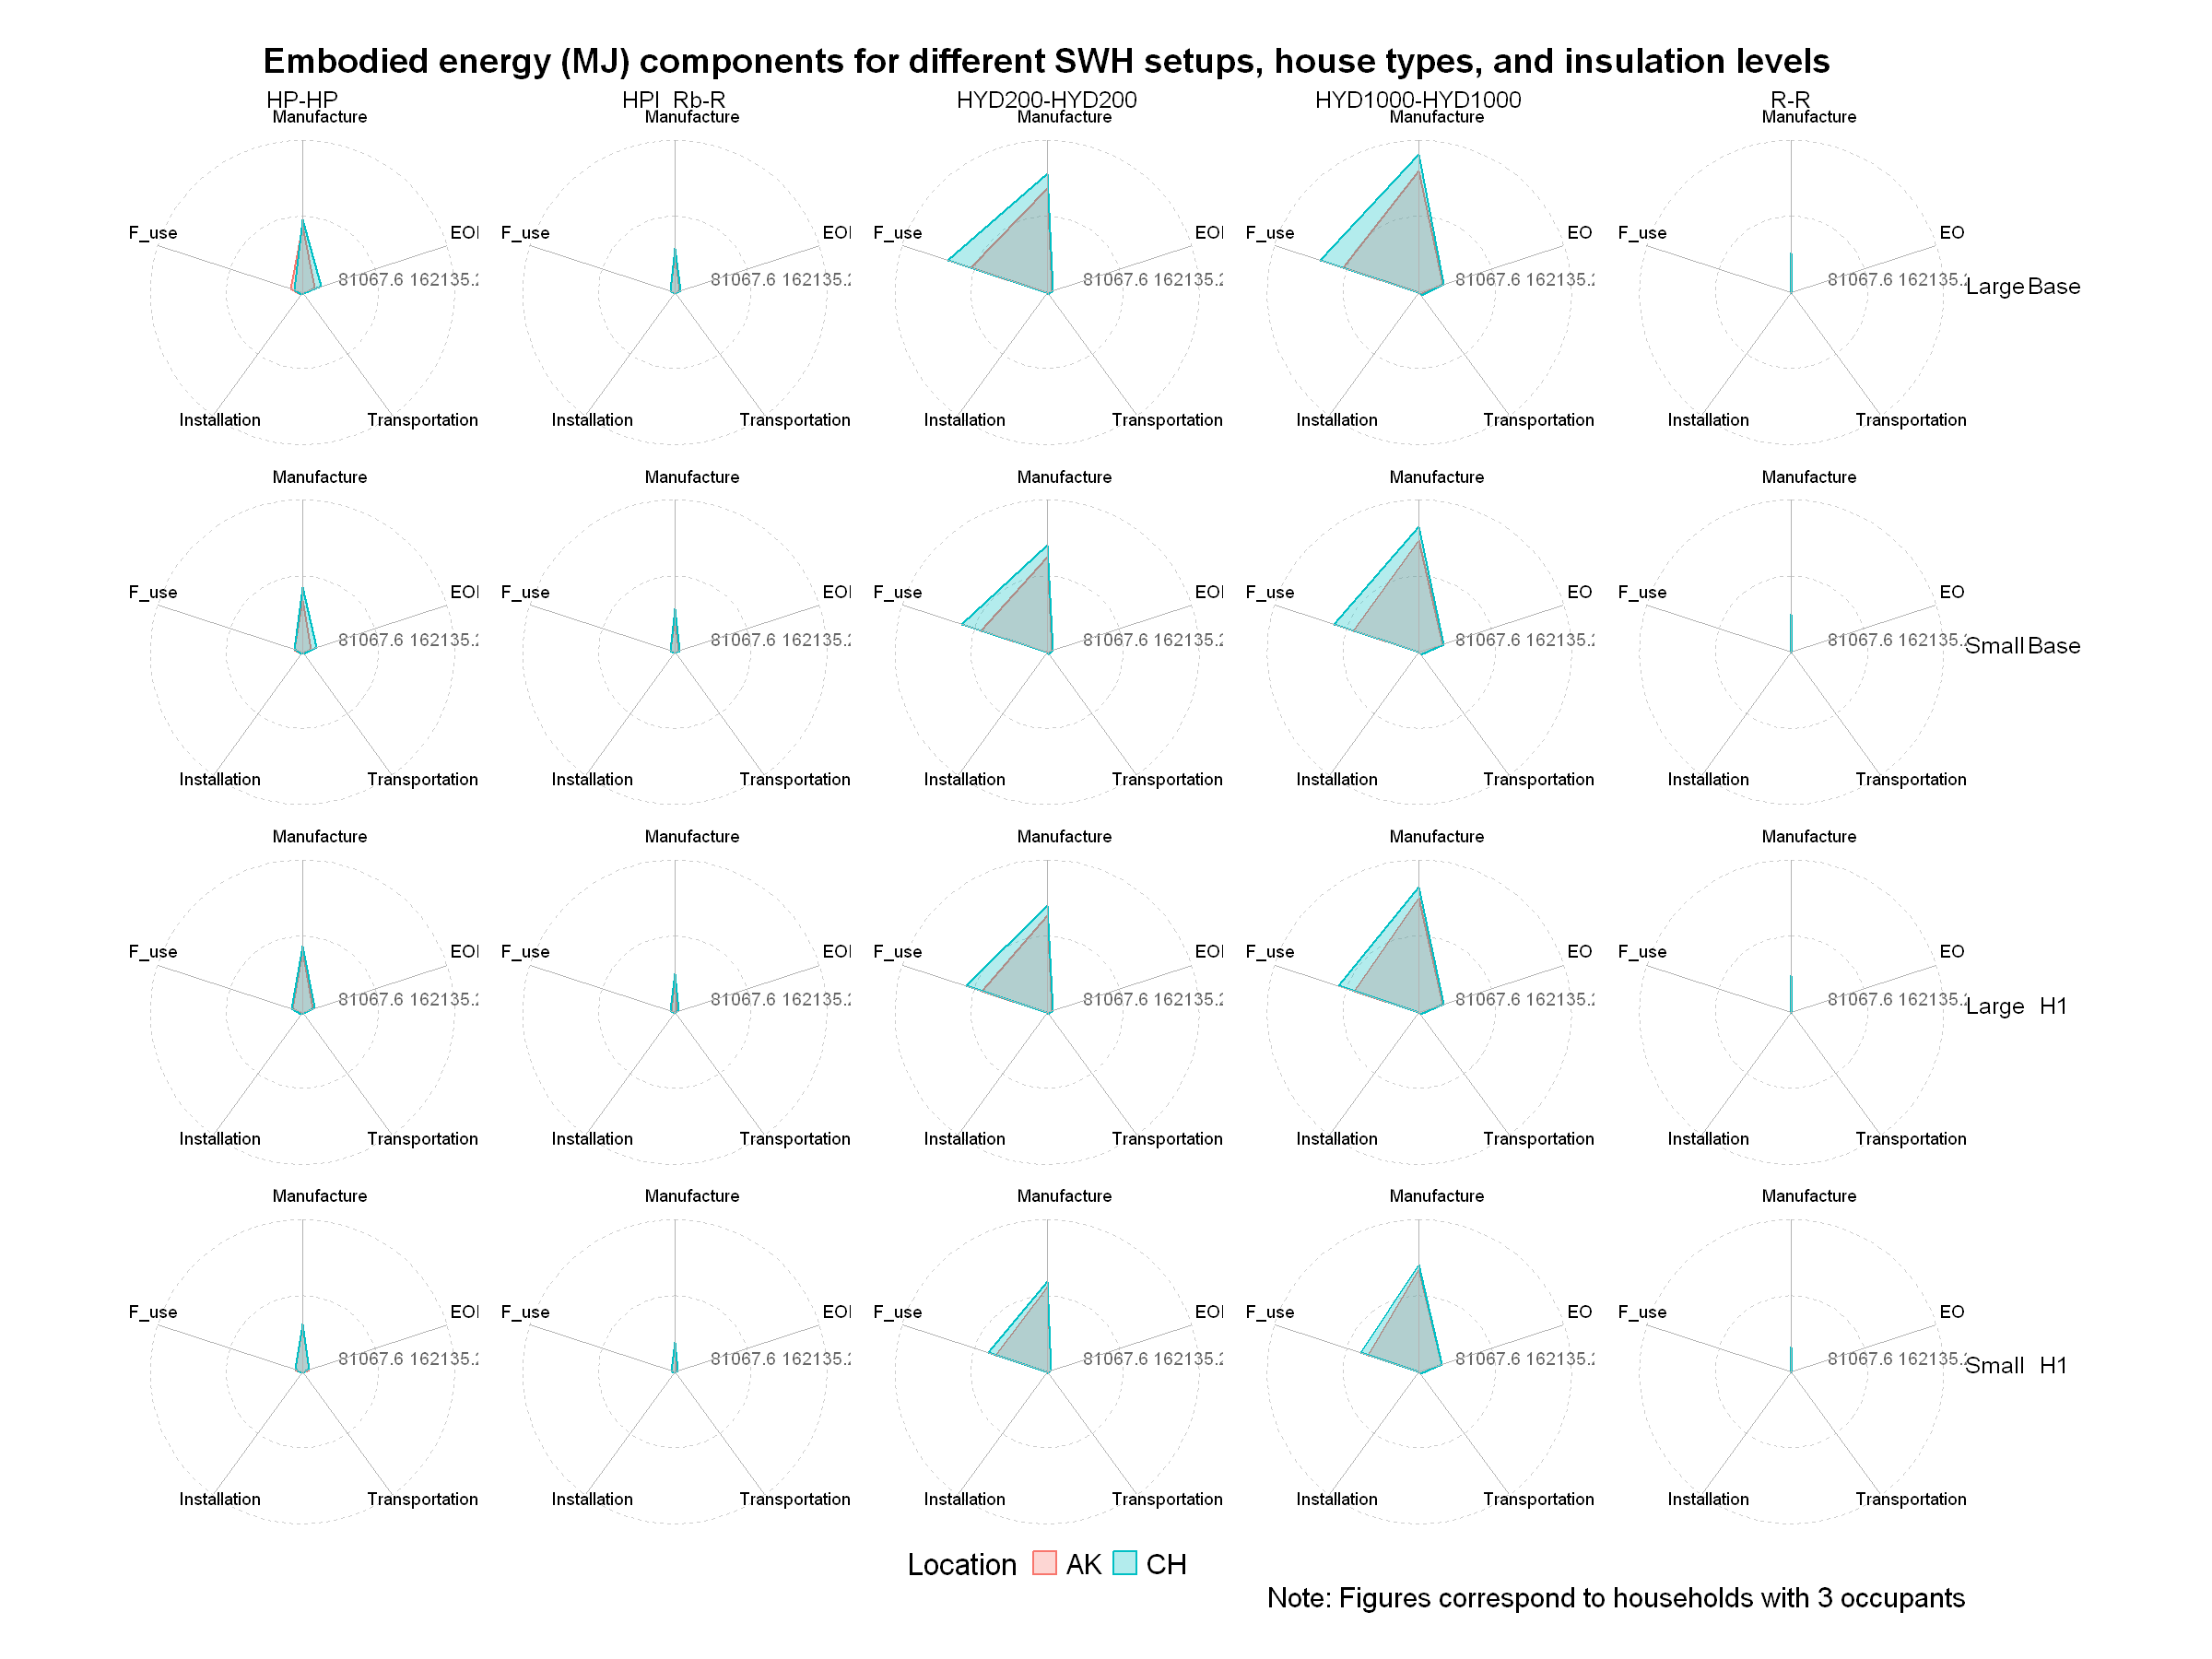

In [50]:
common_max <- max(radar_long_MJ$Value) * 1.1  # 10% padding
mid_value <- common_max / 2
n_vars <- nlevels(radar_long_MJ$Lifecycle_Stage)
angles <- seq(0, 2*pi, length.out = n_vars + 1)[-(n_vars + 1)]  # Remove duplicate 360°

radar_MJ <- ggplot() +
  # Background scale circles
  geom_path(
    data = scale_circles_MJ,
    aes(x = x, y = y, group = value),
    color = "gray80",
    linetype = "dashed",
    size = 0.3
  ) +
  # Scale value labels
  geom_text(
    data = scale_circles_MJ %>% 
      filter(angle == 0) %>%
      distinct(value, label),
    aes(x = value, y = 0, label = label),
    hjust = 0.6,
    vjust = -0.5,
    size = 4,
    color = "gray40"
  ) +
  # Filled polygons 
  geom_polygon(
    data = df_polygons_MJ,
    aes(x = x, y = y, 
        group = interaction(Loc_code, house_type, insulation, SH_DW_code),
        fill = Loc_code,
        color = Loc_code),
    alpha = 0.3,  # Transparency
    size = 0.8
  ) +
  # Axis spokes
  geom_segment(
    data = data.frame(
      x = 0, y = 0,
      xend = common_max * sin(angles),
      yend = common_max * cos(angles)
    ),
    aes(x = x, y = y, xend = xend, yend = yend),
    color = "gray70",
    size = 0.3
  ) +
  # Axis labels
  geom_text(
    data = data.frame(
      x = 1.1 * common_max * sin(angles),
      y = 1.1 * common_max * cos(angles),
      label = levels(radar_long_MJ$Lifecycle_Stage)
    ),
    aes(x = x, y = y, label = label),
    hjust = 0.3,
    vjust = -0.2,  
    size = 4
  ) +
  facet_grid(
    rows = vars(insulation, house_type),
    cols = vars(SH_DW_code)
  ) +
  coord_fixed() +
  theme_void() +
  labs(
    title = "Embodied energy (MJ) components for different SWH setups, house types, and insulation levels",
    fill = "Location",
    color = "Location",
    caption = "Note: Figures correspond to households with 3 occupants"  
  ) +
  theme(
    legend.position = "bottom",
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 18),  
    strip.text = element_text(size = 15),
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5, vjust = 2),
    plot.caption = element_text(size = 18),
    panel.spacing.x = unit(1, "lines"),   # Increased spacing between facets
    plot.margin = margin(30, 30, 30, 30)  # Add more space around the plot
  )
ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/radar_MJ_plot.png",  # File path
  plot = radar_MJ,                       # Plot object
  width = 28,                             # Width in inches
  height = 18,                             # Height in inches
  dpi = 300                               # Resolution
)
radar_MJ

In [20]:
household_lifetime_Call_CS_high <- household_lifetime_Call %>% 
filter(Occ_code == 3, 
       Loc_code == 'CH',
      SH_DW_code %in% c('HP-HP', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD500-HYD500', 'HYD1000-HYD1000'),
      Hydro_resource == 'Hhigh',
      schedule == 'Real') %>%
group_by(house_type, insulation, SH_DW_code, CS_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_CS_high <- household_lifetime_Call_CS_high %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions")

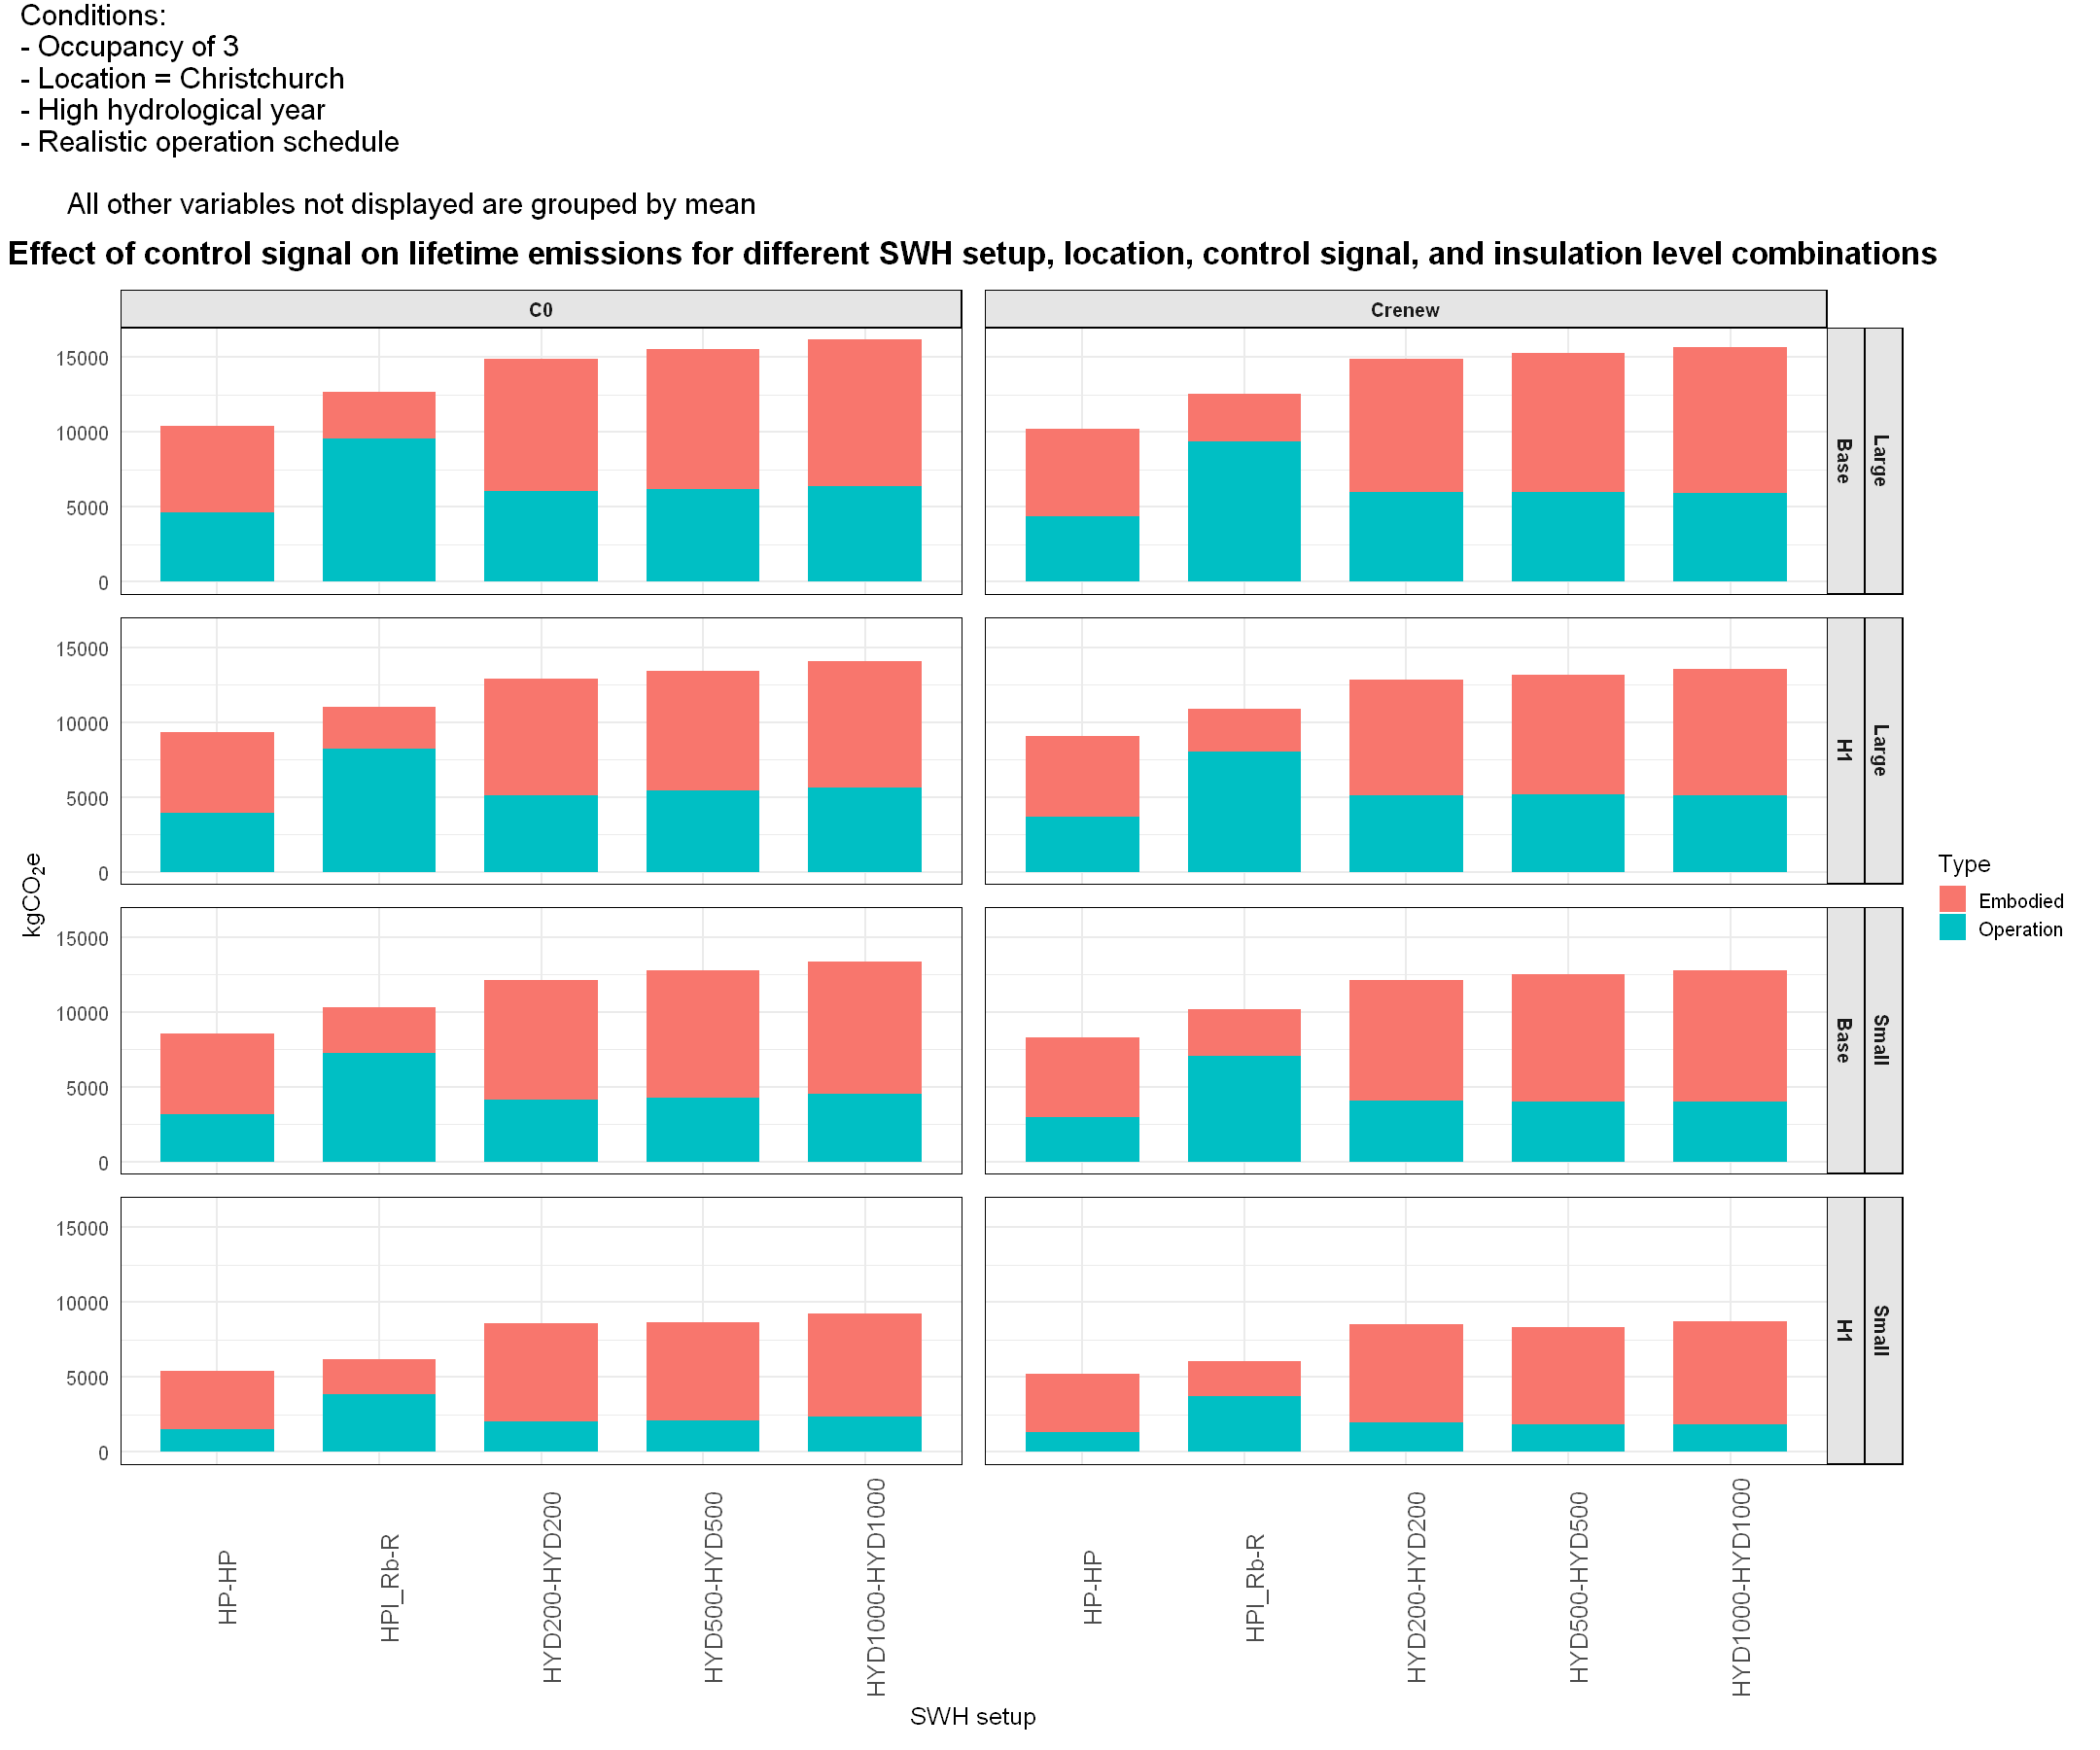

In [21]:
options(repr.plot.width=18, repr.plot.height=15)
CS_attractiveness_plot <- plot_CS_high %>%
  filter(CS_code != 'Cpeak') %>%
  ggplot(aes(x = SH_DW_code, y = Emissions, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  facet_grid(house_type + insulation ~ CS_code) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH setup",
       y = expression(kgCO[2]*e),
       title = "Effect of control signal on lifetime emissions for different SWH setup, location, control signal, and insulation level combinations") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    strip.text = element_text(face = "bold"),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines"),
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5, vjust = 2)  
  )

CS_attractiveness_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3\n- Location = Christchurch\n- High hydrological year\n- Realistic operation schedule\n
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

In [119]:
technology_lifetime_Call_DW_HP <- technology_lifetime_Call %>% 
  filter(!is.na(DW_code)) %>% 
  filter(DW_code %in% c("HP")) %>%  
  filter(Hydro_resource == 'Hhigh') %>% 
  filter(CS_code != 'Cpeak') %>%
  group_by(DW_code, Loc_code, Occ_code, HP_cap,`Tank_Volume (L)`, CS_code) %>% 
  summarise(kgCO2 = mean(kgCO2_oper_life),
            kWh = mean(P_annual_kWh_life)) %>% 
  suppressMessages() %>%
  ungroup()  
# Calculate base case emissions
technology_lifetime_Call_DW_HP_base <- technology_lifetime_Call_DW_HP %>%
  filter(Loc_code == 'AK') %>%
  select(Occ_code, HP_cap, `Tank_Volume (L)`, kWh_AK = kWh, CS_code)
# Join base emissions onto all CS_code values
technology_lifetime_Call_DW_HP_diff <- technology_lifetime_Call_DW_HP %>%
  left_join(technology_lifetime_Call_DW_HP_base, by = c("Occ_code", "HP_cap", "Tank_Volume (L)","CS_code")) %>%
  mutate(diff_p = 100*(kWh - kWh_AK)/kWh,
         diff_a = kWh - kWh_AK)

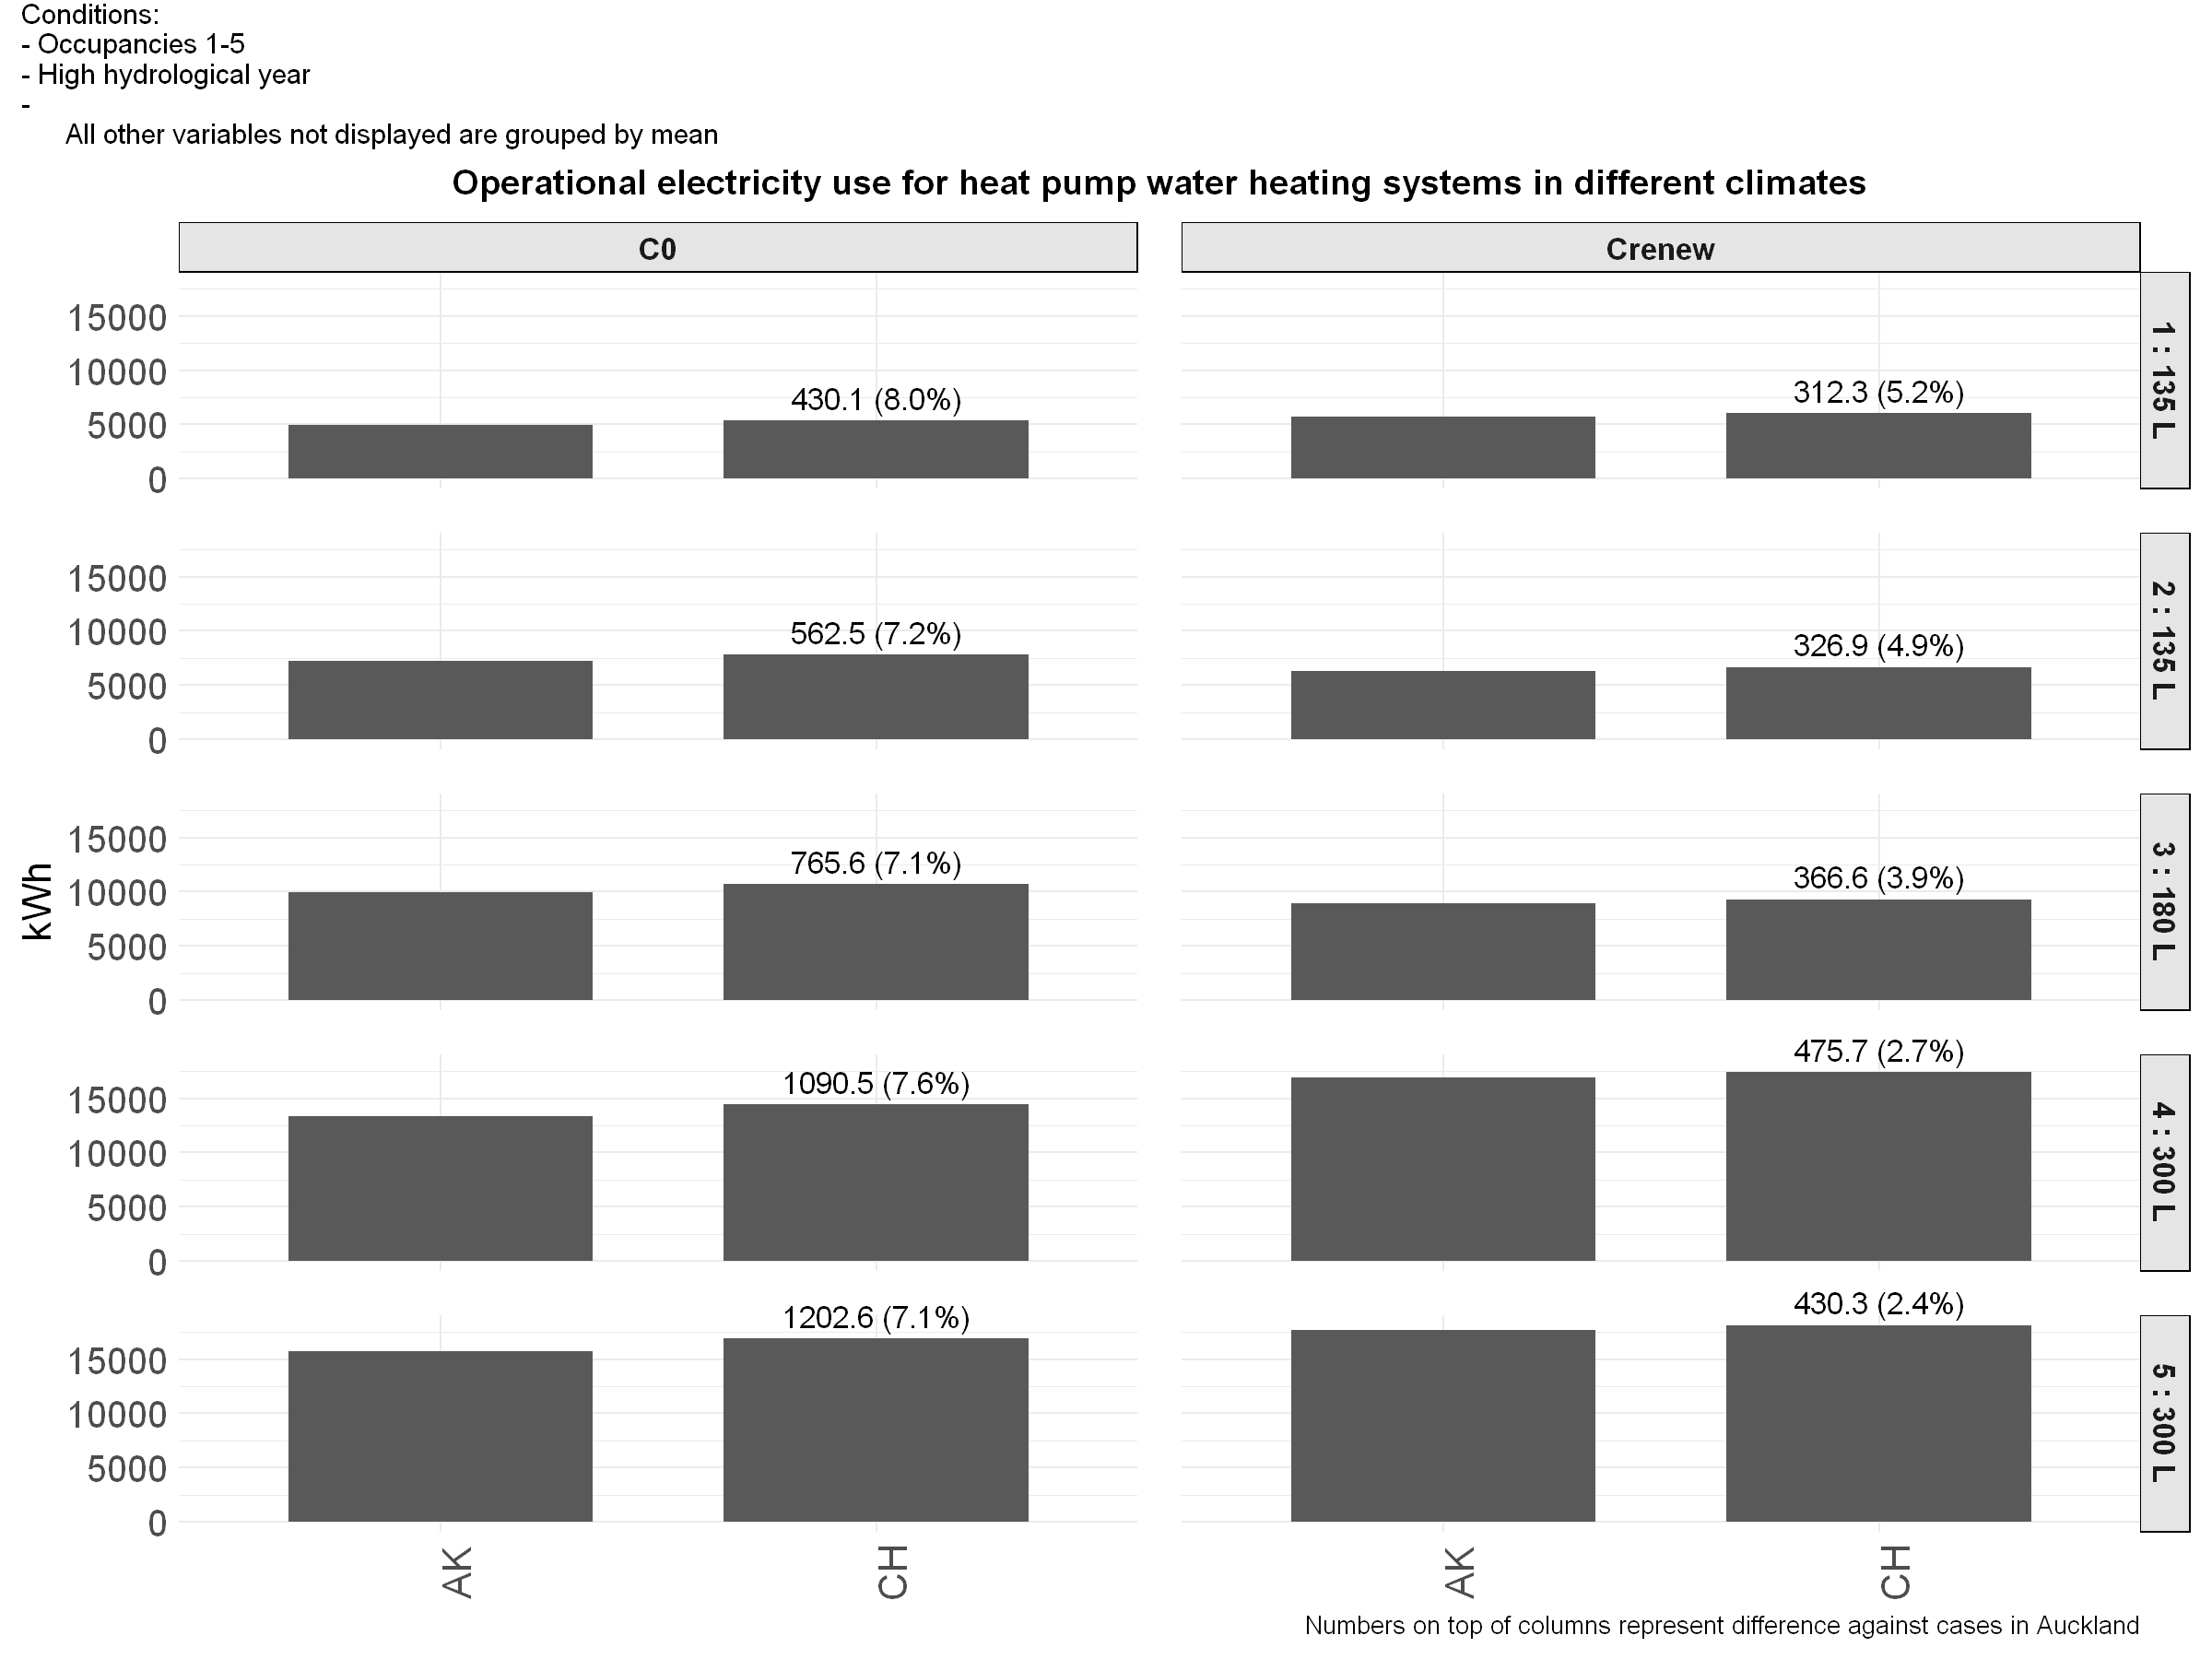

In [121]:
climate_plot <- technology_lifetime_Call_DW_HP_diff %>%
  mutate(Tank_Label = paste0(`Tank_Volume (L)`, " L")) %>%
  ggplot(aes(x= Loc_code, y = kWh)) + 
  geom_col(width = 0.7, position = position_dodge(width = 0.8)) +
  geom_text(
    aes(label = ifelse(!is.na(diff) & Loc_code == 'CH', sprintf("%.1f (%.1f%%)", diff_a, diff_p), "")),
    #hjust = -0.6,
    vjust = -0.5, 
    size = 7,
    color = "black"
  ) +
  facet_grid(interaction(Occ_code, Tank_Label, sep= " : ") ~ CS_code) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 26),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 26),
    axis.text.y = element_text(size = 24),
    legend.title = element_text(size = 22, face = "bold"),
    legend.text = element_text(size = 20), 
    strip.text = element_text(face = "bold", size = 20),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.caption = element_text(size = 16),
    plot.title = element_text(size = 23, face = "bold", hjust = 0.5, vjust = 2)  
  ) +
  labs(x= NA,
       y = "kWh",
       title = "Operational electricity use for heat pump water heating systems in different climates",
       fill= "Location",
       caption = "Numbers on top of columns represent difference against cases in Auckland")

ggsave(
  filename = "D:/EECA_SWH_LCA/results_plots/climate_plot_energy_CS_code.png",  # File path
  plot = climate_plot,                       # Plot object
  width = 10,                             # Width in inches
  height = 14,                             # Height in inches
  dpi = 300                               # Resolution
)

climate_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancies 1-5\n- High hydrological year\n- 
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )